In [1]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[1:],'GPU')

tf.executing_eagerly()
print(tf.executing_eagerly())

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import math
import random
import time
import functools

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import datasets, Input, layers, models, Model, losses
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from IPython import display
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

True


In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

tf.device('/GPU:1')
tf.config.experimental.list_physical_devices('GPU')

strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Input data stream

In [3]:
input_params = data = pd.read_table('input_data/condition.txt', header = None)

datasetNo = int(input_params.values[5,2])
n_epochs = int(input_params.values[10,2])
batch_size = int(input_params.values[11,2])
LR =float(input_params.values[12,2])
Lv1_latent_dim = int(input_params.values[13,2])
stride1 = int(input_params.values[14,2])
stride2 = int(input_params.values[15,2])
stride3 = int(input_params.values[16,2])
C1 = int(input_params.values[17,2])
C2 = int(input_params.values[18,2])
C3 = int(input_params.values[19,2])
C4 = int(input_params.values[20,2])
C5 = int(input_params.values[21,2])
alpha = int(input_params.values[22,2])

num_param = int(input_params.values[1,2])
num_time = int(input_params.values[2,2])
num_time_to = int(input_params.values[27,2])
num_node = int(input_params.values[3,2])
num_var = int(input_params.values[4,2])

epoch_read = int(input_params.values[25,2])
epoch_latent = int(input_params.values[26,2])

print('num_param : ', num_param)
print('num_time : ', num_time)
print('num_node : ', num_node)
print('num_var : ', num_var)
print(' ')
print('datasetNo : ', datasetNo)
print('Lv1_epochs : ', n_epochs)
print('Lv1_batch_size : ', batch_size)
print('Lv1_LearningRate : ', LR)
print('Lv1_latent_dim : ', Lv1_latent_dim)

num_param :  10
num_time :  800
num_node :  100
num_var :  1
 
datasetNo :  1
Lv1_epochs :  50000
Lv1_batch_size :  1
Lv1_LearningRate :  2e-05
Lv1_latent_dim :  256


In [4]:
data_save = np.zeros((num_var, num_node,num_param*num_time))
data = np.zeros((num_node,num_param*num_time))

if datasetNo == 1:
    data = pd.read_csv('input_data/FOM_u_sorted.csv', header = None)
    print(data.shape)
    #print(data)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]

if datasetNo == 2:
    del(data)
    data = pd.read_csv('input_data/FOM_v_sorted.csv', header = None)
    print(data.shape)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]

if datasetNo == 3:
    del(data)
    data = pd.read_csv('input_data/FOM_x_sorted.csv', header = None)
    print(data.shape)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]

if datasetNo == 4:
    del(data)
    data = pd.read_csv('input_data/FOM_y_sorted.csv', header = None)
    print(data.shape)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]
    del(data)


# Data_save shape : (num_var, num_node, num_time x num_param)

print(data_save.shape)
print(len(np.transpose(data_save)))

data=data_save

(14300, 8000)
(1, 100, 8000)
8000


In [5]:
# validate
data.shape

(1, 100, 8000)

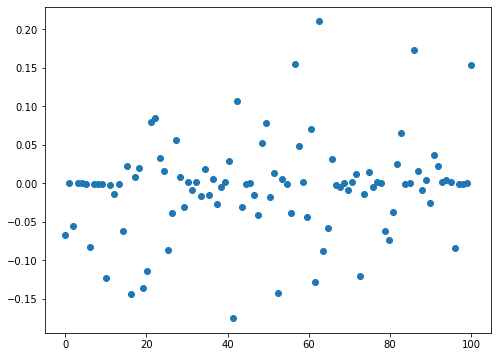

In [6]:
x_axis = np.linspace(0,num_node,num_node)
plt.scatter(x_axis, data[0,:,0])

## FOM data type : FOM_data = np.array[param, time, node, var]

In [7]:
FOM_data = np.zeros((num_param, num_time, num_node))

for i in range(num_var):
    for j in range(num_node):
        for k in range(num_param):
            for l in range(num_time):
                temp = l+k*num_time
                #print(l, k, temp)
                FOM_data[k,l,j]=data[i,j,temp]
                
FOM_data.shape

FOM_data_temp = np.zeros((num_param, num_time, num_node))
FOM_data_temp = FOM_data
del FOM_data
num_time = num_time_to
FOM_data = np.zeros((num_param, num_time, num_node))

FOM_data[:,0:num_time,:] = FOM_data_temp[:,0:num_time,:]
del FOM_data_temp

#del data

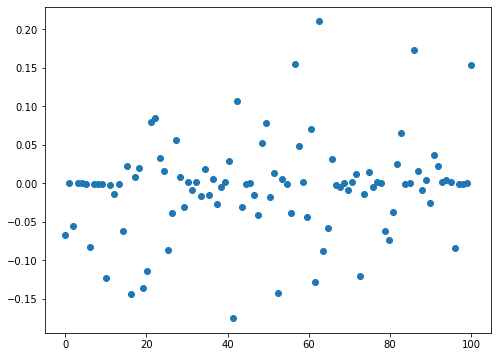

In [8]:
plt.scatter(x_axis, FOM_data[0,0,:])

## Scale data to [0,1]

In [9]:
maximum = np.amax(FOM_data)
minimum = np.amin(FOM_data)
mean = np.mean(FOM_data)
AT = maximum-minimum

print(maximum)
print(minimum)
print(mean)
print(AT)

1.8047008785
-2.14637945807875
1.4742518317234498e-15
3.95108033657875


In [10]:
FOM_data = FOM_data-mean
FOM_data = FOM_data/AT
min_FOM = np.min(FOM_data)
FOM_data = FOM_data-min_FOM

print(np.max(FOM_data))
print(np.min(FOM_data))

1.0
0.0


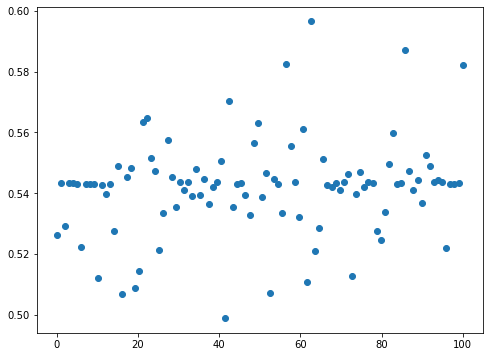

In [11]:
plt.scatter(x_axis, FOM_data[0,0,:])

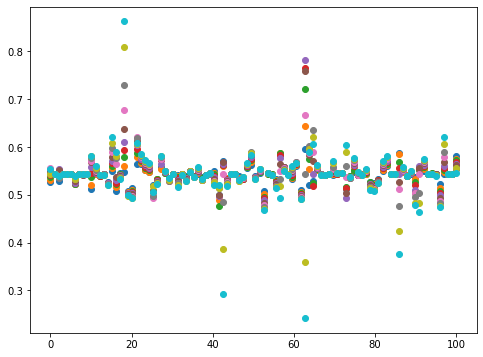

In [12]:
for i in range(num_param):
    plt.scatter(x_axis, FOM_data[i,0,:])

# Level 1, SVAE (spatial VAE)

In [13]:
Lv1_input = np.zeros((num_param,num_time, num_node))
# Lv1_input = (num_param x num_time, num_node, num_var)

Lv1_input = FOM_data#.reshape(-1, num_node, num_var)
    
Lv1_input.shape
del FOM_data
# Lv1_input is elongated w.r.t. param, 1,2,3,4,..../param change/1,2,3,4,.....

In [14]:
#validate

Lv1_input[9,0,0]
Lv1_input_shape_decoder = Lv1_input.shape[1]

In [15]:
Lv1_input_shape = Lv1_input.shape[1:]

In [16]:
print(Lv1_input.shape)
print(Lv1_input_shape)

(10, 800, 100)
(800, 100)


# Encoder

In [17]:

def encoder():
    x_input=layers.Input(shape=Lv1_input_shape)
    #x=layers.ZeroPadding1D(2)(x_input)
    
    x=layers.Conv1D(C1, 5, strides=stride3, padding='same', kernel_initializer='glorot_uniform')(x_input)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Conv1D(C2, 5, strides=stride2, padding='same', kernel_initializer='glorot_uniform')(x)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)   
    
    x=layers.Conv1D(C3, 5, strides=stride1, padding='same', kernel_initializer='glorot_uniform')(x)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Conv1D(C4, 5, strides=stride1, padding='same', kernel_initializer='glorot_uniform')(x)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Conv1D(C5, 5, strides=stride1, padding='same', kernel_initializer='glorot_uniform')(x)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Conv1D(C4, 5, strides=stride1, padding='same', kernel_initializer='glorot_uniform')(x)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Conv1D(C5, 5, strides=stride1, padding='same', kernel_initializer='glorot_uniform')(x)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Conv1D(C4, 5, strides=stride1, padding='same', kernel_initializer='glorot_uniform')(x)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Conv1D(C5, 5, strides=stride1, padding='same', kernel_initializer='glorot_uniform')(x)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Conv1D(C4, 5, strides=stride1, padding='same', kernel_initializer='glorot_uniform')(x)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Conv1D(C5, 5, strides=stride1, padding='same', kernel_initializer='glorot_uniform')(x)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    ################################################################################################0
    #x=layers.Conv2D(1, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x)
    #x=layers.BatchNormalization()(x)
    #x=layers.LeakyReLU(0.2)(x)
    #x=layers.Dropout(0.3)(x)
    ################################################################################################0
    
    x=layers.Flatten()(x)
    
    mu=layers.Dense(Lv1_latent_dim, kernel_initializer='glorot_uniform')(x)
    var=layers.Dense(Lv1_latent_dim, kernel_initializer='glorot_uniform')(x)
    var=layers.Activation(tf.nn.softplus)(var) # var > 0
    
    eps = tf.random.normal(shape=[Lv1_latent_dim], mean=0.0, stddev=1.0)
    z = eps * tf.math.sqrt(var) + mu
    
    en_coder = tf.keras.models.Model(x_input, [mu, var, z], name="ENCODER")
    return en_coder

Encoder=encoder()
Encoder.summary()
#tf.keras.utils.plot_model(Encoder, show_shapes=True)

Model: "ENCODER"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800, 100)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 800, 1024)    513024      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 800, 1024)    0           conv1d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 800, 1024)    0           leaky_re_lu[0][0]                
____________________________________________________________________________________________

# Decoder

In [18]:
print(Lv1_latent_dim)
print(Lv1_input_shape_decoder)
print(Lv1_input_shape)
print(Lv1_input.shape[0])
print(int(Lv1_input.shape[1]/4)*int(Lv1_input.shape[2]/4)*Lv1_latent_dim)

256
800
(800, 100)
10
1280000


In [19]:
strides = stride1*stride2*stride3

In [20]:
def decoder():
    z_input=layers.Input(shape=(Lv1_latent_dim))
    
    z=layers.Dense(int(Lv1_input.shape[1]/strides)*C5, kernel_initializer='glorot_uniform')(z_input)
    z=layers.LeakyReLU(alpha=0.3)(z)
    
    z=layers.Reshape([int(Lv1_input.shape[1]/strides),C5])(z)
    
    z=layers.Conv1DTranspose(C5, 4, strides=stride3, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(C4, 4, strides=stride3, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(C5, 4, strides=stride3, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(C4, 4, strides=stride3, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(C5, 4, strides=stride3, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(C4, 4, strides=stride3, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(C5, 4, strides=stride3, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(C4, 4, strides=stride3, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(C3, 4, strides=stride1, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(C2, 4, strides=stride2, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(C1, 4, strides=stride3, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)    
    
    
    ## Changed Dense(1, ...) to Dense(num_var, ....)
    z_mu=layers.Dense(num_node, kernel_initializer='glorot_uniform')(z)
    mu_prime=layers.Activation('sigmoid')(z_mu)
    
    ## Changed Dense(1, ...) to Dense(num_var, ....)
    z_var=layers.Dense(num_node, kernel_initializer='glorot_uniform')(z)
    var_prime=layers.Activation(tf.nn.softplus)(z_var) # var > 0
    ## I guess the 
    
    
    de_coder = tf.keras.models.Model(z_input, [mu_prime, var_prime], name="DECODER")
    return de_coder

Decoder=decoder()
Decoder.summary()
#tf.keras.utils.plot_model(Decoder, show_shapes=True)

Model: "DECODER"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 819200)       210534400   input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_11 (LeakyReLU)      (None, 819200)       0           dense_2[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 800, 1024)    0           leaky_re_lu_11[0][0]             
____________________________________________________________________________________________

# loss computation

In [21]:
def compute_loss(mu, var, mu_prime, var_prime, real_img, beta):
    
    reconstruction_error = tf.math.reduce_mean(tf.math.reduce_sum((0.5*tf.math.log(var_prime) + tf.math.square(real_img - mu_prime)/(2*var_prime)), 1))
    #reconstruction_error = tf.math.reduce_mean(tf.reduce_sum(tf.math.square(real_img - mu_prime)))
    
    #mse = losses.MeanSquaredError()
    #reconstruction_error = tf.reduce_mean(tf.reduce_sum(np.abs(real_img-mu_prime)))
    #reconstruction_error = tf.reduce_mean(tf.reduce_sum(losses.binary_crossentropy(real_img, mu_prime)))
    
    #print(reconstruction_error)
    
    KL_divergence = tf.math.reduce_mean(0.5 * tf.math.reduce_sum((tf.math.square(mu) + var - tf.math.log(var) - 1), 1))
    
    VAE_loss = reconstruction_error + beta * KL_divergence # L(X0)+L(X1)+L(X2)
    
    mu_a = mu[1:num_param-1,:]
    mu_b = (mu[0:num_param-2,:]+mu[2:num_param,:])/2
    var_a = var[1:num_param-1,:]
    var_b = (var[0:num_param-2,:]+var[2:num_param,:])/4

    loss_constraint = tf.math.reduce_mean(0.5 * tf.math.reduce_sum((var_a/var_b + tf.math.square(mu_b - mu_a)/var_b - 1 + tf.math.log(var_b/var_a)),1))
    
    loss = VAE_loss + alpha * loss_constraint
    
    return loss

# VAE

In [22]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, ENCODER, DECODER):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.ENCODER = ENCODER
        self.DECODER = DECODER
        
    def compile(self, opt, loss):
        super(VAE, self).compile()
        self.opt = opt
        self.loss = loss

    def train_step(self, real_img):
        if isinstance(data, tuple):
            real_img = real_img[0]
            
        with tf.GradientTape() as tape:
            # encoding
            mu, var, latent_space = self.ENCODER(real_img, training=True)
            
            # decoding
            mu_prime, var_prime = self.DECODER(latent_space, training=True)
            
            # loss calculation
            loss = self.loss(mu, var, mu_prime, var_prime, real_img, beta)
            
        gradients = tape.gradient(loss, self.trainable_variables)
        self.opt.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": loss}


# Save Model

In [23]:
class SaveModel(tf.keras.callbacks.Callback):
    def __init__(self, num_iter=n_epochs, latent_dim=Lv1_latent_dim):
        self.num_iter = num_iter
        self.latent_dim = Lv1_latent_dim
        
    def on_epoch_end(self, epoch, logs=None):
        if((epoch+1)%5000==0):
            if((epoch+1)%5000==0):          
                filename1 = 'Lv1_networks/decoder_%d.h5' % (epoch+1)
                filename2 = 'Lv1_networks/encoder_%d.h5' % (epoch+1)
                
                Decoder.save(filename1)
                Encoder.save(filename2)

In [24]:
Lv1_input.shape
print(type(Lv1_input))

<class 'numpy.ndarray'>


# Warm up

In [25]:
beta = K.variable(0.)
N_t = int(n_epochs * 0.5)

class WarmUp(tf.keras.callbacks.Callback):
    def __init__(self, beta):
        self.beta = beta
        
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < N_t:
            K.set_value(self.beta, 0)
        else:
            K.set_value(self.beta, N_t/epoch)


In [26]:
Lv1_input.shape

(10, 800, 100)

In [27]:
opt = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=0.9, beta_2=0.99)

cbk1 = SaveModel(num_iter=n_epochs,latent_dim=Lv1_latent_dim)
cbk2 = WarmUp(beta)

#with strategy.scope():
vae = VAE(latent_dim=Lv1_latent_dim, ENCODER=Encoder, DECODER=Decoder)
vae.compile(opt=opt, loss=compute_loss)

#vae.fit(Lv1_input, batch_size=batch_size, epochs=n_epochs, callbacks=[cbk1])
vae.fit(Lv1_input, batch_size=batch_size, epochs=n_epochs, callbacks=[cbk1, cbk2])
end = time.time()

print(end-start)

Epoch 1/50000
10/10 [==============================] - 600s 87ms/step - loss: -209.2684
Epoch 2/50000
10/10 [==============================] - 1s 86ms/step - loss: -173.7856
Epoch 3/50000
10/10 [==============================] - 1s 86ms/step - loss: -195.5747
Epoch 4/50000
10/10 [==============================] - 1s 86ms/step - loss: -202.7564
Epoch 5/50000
10/10 [==============================] - 1s 87ms/step - loss: -262.1595
Epoch 6/50000
10/10 [==============================] - 1s 86ms/step - loss: -491.5376
Epoch 7/50000
10/10 [==============================] - 1s 87ms/step - loss: -618.4110
Epoch 8/50000
10/10 [==============================] - 1s 87ms/step - loss: -710.7735
Epoch 9/50000
10/10 [==============================] - 1s 87ms/step - loss: -777.8419
Epoch 10/50000
10/10 [==============================] - 1s 87ms/step - loss: -833.4548
Epoch 11/50000
10/10 [==============================] - 1s 87ms/step - loss: -875.3875
Epoch 12/50000
10/10 [============================

10/10 [==============================] - 1s 88ms/step - loss: -1729.7309
Epoch 92/50000
10/10 [==============================] - 1s 88ms/step - loss: -1718.0657
Epoch 93/50000
10/10 [==============================] - 1s 88ms/step - loss: -1735.2010
Epoch 94/50000
10/10 [==============================] - 1s 88ms/step - loss: -1741.7413
Epoch 95/50000
10/10 [==============================] - 1s 87ms/step - loss: -1743.3737
Epoch 96/50000
10/10 [==============================] - 1s 88ms/step - loss: -1743.5878
Epoch 97/50000
10/10 [==============================] - 1s 88ms/step - loss: -1756.3823
Epoch 98/50000
10/10 [==============================] - 1s 87ms/step - loss: -1765.4417
Epoch 99/50000
10/10 [==============================] - 1s 88ms/step - loss: -1759.4167
Epoch 100/50000
10/10 [==============================] - 1s 88ms/step - loss: -1764.1896
Epoch 101/50000
10/10 [==============================] - 1s 88ms/step - loss: -1772.9945
Epoch 102/50000
10/10 [======================

10/10 [==============================] - 1s 89ms/step - loss: -2117.5446
Epoch 184/50000
10/10 [==============================] - 1s 88ms/step - loss: -2117.0938
Epoch 185/50000
10/10 [==============================] - 1s 89ms/step - loss: -2125.5940
Epoch 186/50000
10/10 [==============================] - 1s 88ms/step - loss: -2122.0745
Epoch 187/50000
10/10 [==============================] - 1s 89ms/step - loss: -2120.2630
Epoch 188/50000
10/10 [==============================] - 1s 89ms/step - loss: -2125.2537
Epoch 189/50000
10/10 [==============================] - 1s 88ms/step - loss: -2136.4033
Epoch 190/50000
10/10 [==============================] - 1s 89ms/step - loss: -2144.3220
Epoch 191/50000
10/10 [==============================] - 1s 88ms/step - loss: -2148.5979
Epoch 192/50000
10/10 [==============================] - 1s 89ms/step - loss: -2144.2074
Epoch 193/50000
10/10 [==============================] - 1s 88ms/step - loss: -2147.6306
Epoch 194/50000
10/10 [==============

10/10 [==============================] - 1s 90ms/step - loss: -2388.0652
Epoch 276/50000
10/10 [==============================] - 1s 89ms/step - loss: -2387.0354
Epoch 277/50000
10/10 [==============================] - 1s 89ms/step - loss: -2398.2837
Epoch 278/50000
10/10 [==============================] - 1s 88ms/step - loss: -2403.5025
Epoch 279/50000
10/10 [==============================] - 1s 89ms/step - loss: -2406.4557
Epoch 280/50000
10/10 [==============================] - 1s 89ms/step - loss: -2406.6842
Epoch 281/50000
10/10 [==============================] - 1s 89ms/step - loss: -2414.7065
Epoch 282/50000
10/10 [==============================] - 1s 89ms/step - loss: -2411.8005
Epoch 283/50000
10/10 [==============================] - 1s 89ms/step - loss: -2415.9462
Epoch 284/50000
10/10 [==============================] - 1s 89ms/step - loss: -2413.9488
Epoch 285/50000
10/10 [==============================] - 1s 89ms/step - loss: -2425.0335
Epoch 286/50000
10/10 [==============

10/10 [==============================] - 1s 89ms/step - loss: -2617.0397
Epoch 368/50000
10/10 [==============================] - 1s 89ms/step - loss: -2620.5152
Epoch 369/50000
10/10 [==============================] - 1s 89ms/step - loss: -2596.4053
Epoch 370/50000
10/10 [==============================] - 1s 89ms/step - loss: -2600.3121
Epoch 371/50000
10/10 [==============================] - 1s 89ms/step - loss: -2618.6609
Epoch 372/50000
10/10 [==============================] - 1s 89ms/step - loss: -2622.7129
Epoch 373/50000
10/10 [==============================] - 1s 89ms/step - loss: -2632.1458
Epoch 374/50000
10/10 [==============================] - 1s 90ms/step - loss: -2633.0083
Epoch 375/50000
10/10 [==============================] - 1s 89ms/step - loss: -2644.0457
Epoch 376/50000
10/10 [==============================] - 1s 89ms/step - loss: -2627.2284
Epoch 377/50000
10/10 [==============================] - 1s 89ms/step - loss: -2649.7134
Epoch 378/50000
10/10 [==============

10/10 [==============================] - 1s 89ms/step - loss: -2867.4756
Epoch 460/50000
10/10 [==============================] - 1s 89ms/step - loss: -2872.9043
Epoch 461/50000
10/10 [==============================] - 1s 89ms/step - loss: -2875.3772
Epoch 462/50000
10/10 [==============================] - 1s 89ms/step - loss: -2872.0246
Epoch 463/50000
10/10 [==============================] - 1s 89ms/step - loss: -2870.3947
Epoch 464/50000
10/10 [==============================] - 1s 89ms/step - loss: -2878.5682
Epoch 465/50000
10/10 [==============================] - 1s 89ms/step - loss: -2884.3046
Epoch 466/50000
10/10 [==============================] - 1s 89ms/step - loss: -2888.9670
Epoch 467/50000
10/10 [==============================] - 1s 89ms/step - loss: -2893.3435
Epoch 468/50000
10/10 [==============================] - 1s 89ms/step - loss: -2891.5236
Epoch 469/50000
10/10 [==============================] - 1s 89ms/step - loss: -2894.3365
Epoch 470/50000
10/10 [==============

10/10 [==============================] - 1s 89ms/step - loss: -3120.2827
Epoch 552/50000
10/10 [==============================] - 1s 89ms/step - loss: -3134.5244
Epoch 553/50000
10/10 [==============================] - 1s 89ms/step - loss: -3130.6145
Epoch 554/50000
10/10 [==============================] - 1s 89ms/step - loss: -3129.6876
Epoch 555/50000
10/10 [==============================] - 1s 89ms/step - loss: -3135.3833
Epoch 556/50000
10/10 [==============================] - 1s 89ms/step - loss: -3145.3954
Epoch 557/50000
10/10 [==============================] - 1s 89ms/step - loss: -3134.2833
Epoch 558/50000
10/10 [==============================] - 1s 89ms/step - loss: -3131.8233
Epoch 559/50000
10/10 [==============================] - 1s 89ms/step - loss: -3151.0728
Epoch 560/50000
10/10 [==============================] - 1s 90ms/step - loss: -3148.9707
Epoch 561/50000
10/10 [==============================] - 1s 89ms/step - loss: -3158.6628
Epoch 562/50000
10/10 [==============

10/10 [==============================] - 1s 90ms/step - loss: -3409.3418
Epoch 644/50000
10/10 [==============================] - 1s 90ms/step - loss: -3400.4629
Epoch 645/50000
10/10 [==============================] - 1s 89ms/step - loss: -3413.9357
Epoch 646/50000
10/10 [==============================] - 1s 89ms/step - loss: -3420.5497
Epoch 647/50000
10/10 [==============================] - 1s 89ms/step - loss: -3416.4274
Epoch 648/50000
10/10 [==============================] - 1s 90ms/step - loss: -3405.7442
Epoch 649/50000
10/10 [==============================] - 1s 90ms/step - loss: -3426.6254
Epoch 650/50000
10/10 [==============================] - 1s 90ms/step - loss: -3434.3746
Epoch 651/50000
10/10 [==============================] - 1s 89ms/step - loss: -3439.0886
Epoch 652/50000
10/10 [==============================] - 1s 89ms/step - loss: -3442.7604
Epoch 653/50000
10/10 [==============================] - 1s 89ms/step - loss: -3452.0547
Epoch 654/50000
10/10 [==============

10/10 [==============================] - 1s 89ms/step - loss: -3628.1090
Epoch 736/50000
10/10 [==============================] - 1s 89ms/step - loss: -3627.2392
Epoch 737/50000
10/10 [==============================] - 1s 89ms/step - loss: -3625.1021
Epoch 738/50000
10/10 [==============================] - 1s 89ms/step - loss: -3633.1634
Epoch 739/50000
10/10 [==============================] - 1s 89ms/step - loss: -3636.6518
Epoch 740/50000
10/10 [==============================] - 1s 90ms/step - loss: -3649.1216
Epoch 741/50000
10/10 [==============================] - 1s 90ms/step - loss: -3646.2872
Epoch 742/50000
10/10 [==============================] - 1s 89ms/step - loss: -3637.4952
Epoch 743/50000
10/10 [==============================] - 1s 89ms/step - loss: -3659.8065
Epoch 744/50000
10/10 [==============================] - 1s 89ms/step - loss: -3639.0722
Epoch 745/50000
10/10 [==============================] - 1s 89ms/step - loss: -3608.5746
Epoch 746/50000
10/10 [==============

10/10 [==============================] - 1s 89ms/step - loss: -3757.9538
Epoch 828/50000
10/10 [==============================] - 1s 89ms/step - loss: -3789.7246
Epoch 829/50000
10/10 [==============================] - 1s 89ms/step - loss: -3774.3479
Epoch 830/50000
10/10 [==============================] - 1s 89ms/step - loss: -3780.0089
Epoch 831/50000
10/10 [==============================] - 1s 89ms/step - loss: -3744.8497
Epoch 832/50000
10/10 [==============================] - 1s 89ms/step - loss: -3777.5861
Epoch 833/50000
10/10 [==============================] - 1s 89ms/step - loss: -3786.9019
Epoch 834/50000
10/10 [==============================] - 1s 89ms/step - loss: -3788.2546
Epoch 835/50000
10/10 [==============================] - 1s 89ms/step - loss: -3793.6273
Epoch 836/50000
10/10 [==============================] - 1s 89ms/step - loss: -3782.2753
Epoch 837/50000
10/10 [==============================] - 1s 89ms/step - loss: -3778.5000
Epoch 838/50000
10/10 [==============

10/10 [==============================] - 1s 89ms/step - loss: -3857.9093
Epoch 920/50000
10/10 [==============================] - 1s 89ms/step - loss: -3859.2605
Epoch 921/50000
10/10 [==============================] - 1s 89ms/step - loss: -3837.6065
Epoch 922/50000
10/10 [==============================] - 1s 89ms/step - loss: -3833.3016
Epoch 923/50000
10/10 [==============================] - 1s 89ms/step - loss: -3857.0133
Epoch 924/50000
10/10 [==============================] - 1s 90ms/step - loss: -3842.9191
Epoch 925/50000
10/10 [==============================] - 1s 89ms/step - loss: -3882.9059
Epoch 926/50000
10/10 [==============================] - 1s 89ms/step - loss: -3880.2498
Epoch 927/50000
10/10 [==============================] - 1s 89ms/step - loss: -3822.4424
Epoch 928/50000
10/10 [==============================] - 1s 89ms/step - loss: -3854.1633
Epoch 929/50000
10/10 [==============================] - 1s 89ms/step - loss: -3879.8381
Epoch 930/50000
10/10 [==============

10/10 [==============================] - 1s 89ms/step - loss: -3923.0008
Epoch 1012/50000
10/10 [==============================] - 1s 89ms/step - loss: -3932.6300
Epoch 1013/50000
10/10 [==============================] - 1s 89ms/step - loss: -3943.4872
Epoch 1014/50000
10/10 [==============================] - 1s 89ms/step - loss: -3950.6034
Epoch 1015/50000
10/10 [==============================] - 1s 89ms/step - loss: -3949.9138
Epoch 1016/50000
10/10 [==============================] - 1s 90ms/step - loss: -3971.2982
Epoch 1017/50000
10/10 [==============================] - 1s 90ms/step - loss: -3950.9550
Epoch 1018/50000
10/10 [==============================] - 1s 90ms/step - loss: -3948.3873
Epoch 1019/50000
10/10 [==============================] - 1s 90ms/step - loss: -3943.1470
Epoch 1020/50000
10/10 [==============================] - 1s 90ms/step - loss: -3960.2081
Epoch 1021/50000
10/10 [==============================] - 1s 90ms/step - loss: -3923.6003
Epoch 1022/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -3987.4443
Epoch 1103/50000
10/10 [==============================] - 1s 89ms/step - loss: -3987.0416
Epoch 1104/50000
10/10 [==============================] - 1s 89ms/step - loss: -3954.0645
Epoch 1105/50000
10/10 [==============================] - 1s 89ms/step - loss: -3964.7044
Epoch 1106/50000
10/10 [==============================] - 1s 89ms/step - loss: -3942.5859
Epoch 1107/50000
10/10 [==============================] - 1s 89ms/step - loss: -3979.0975
Epoch 1108/50000
10/10 [==============================] - 1s 89ms/step - loss: -3973.5384
Epoch 1109/50000
10/10 [==============================] - 1s 89ms/step - loss: -3987.2946
Epoch 1110/50000
10/10 [==============================] - 1s 89ms/step - loss: -3985.5485
Epoch 1111/50000
10/10 [==============================] - 1s 89ms/step - loss: -3999.2718
Epoch 1112/50000
10/10 [==============================] - 1s 89ms/step - loss: -3987.8577
Epoch 1113/50000
10/10 [===

10/10 [==============================] - 1s 90ms/step - loss: -4046.8106
Epoch 1194/50000
10/10 [==============================] - 1s 90ms/step - loss: -4040.9033
Epoch 1195/50000
10/10 [==============================] - 1s 89ms/step - loss: -4035.6555
Epoch 1196/50000
10/10 [==============================] - 1s 90ms/step - loss: -4038.5514
Epoch 1197/50000
10/10 [==============================] - 1s 90ms/step - loss: -4032.6088
Epoch 1198/50000
10/10 [==============================] - 1s 89ms/step - loss: -4051.9436
Epoch 1199/50000
10/10 [==============================] - 1s 89ms/step - loss: -4026.5216
Epoch 1200/50000
10/10 [==============================] - 1s 89ms/step - loss: -4032.9256
Epoch 1201/50000
10/10 [==============================] - 1s 89ms/step - loss: -4017.9464
Epoch 1202/50000
10/10 [==============================] - 1s 90ms/step - loss: -4040.5689
Epoch 1203/50000
10/10 [==============================] - 1s 89ms/step - loss: -4038.8589
Epoch 1204/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4054.6331
Epoch 1285/50000
10/10 [==============================] - 1s 90ms/step - loss: -4062.9771
Epoch 1286/50000
10/10 [==============================] - 1s 89ms/step - loss: -4103.6811
Epoch 1287/50000
10/10 [==============================] - 1s 89ms/step - loss: -4099.6007
Epoch 1288/50000
10/10 [==============================] - 1s 90ms/step - loss: -4100.5134
Epoch 1289/50000
10/10 [==============================] - 1s 89ms/step - loss: -4110.7565
Epoch 1290/50000
10/10 [==============================] - 1s 89ms/step - loss: -4082.6963
Epoch 1291/50000
10/10 [==============================] - 1s 89ms/step - loss: -4101.1930
Epoch 1292/50000
10/10 [==============================] - 1s 90ms/step - loss: -4080.2543
Epoch 1293/50000
10/10 [==============================] - 1s 90ms/step - loss: -4087.9829
Epoch 1294/50000
10/10 [==============================] - 1s 90ms/step - loss: -4070.4091
Epoch 1295/50000
10/10 [===

10/10 [==============================] - 1s 90ms/step - loss: -4124.7059
Epoch 1376/50000
10/10 [==============================] - 1s 89ms/step - loss: -4102.1354
Epoch 1377/50000
10/10 [==============================] - 1s 89ms/step - loss: -4130.9581
Epoch 1378/50000
10/10 [==============================] - 1s 89ms/step - loss: -4113.5051
Epoch 1379/50000
10/10 [==============================] - 1s 90ms/step - loss: -4082.6432
Epoch 1380/50000
10/10 [==============================] - 1s 90ms/step - loss: -4116.1881
Epoch 1381/50000
10/10 [==============================] - 1s 90ms/step - loss: -4134.8217
Epoch 1382/50000
10/10 [==============================] - 1s 90ms/step - loss: -4139.0139
Epoch 1383/50000
10/10 [==============================] - 1s 91ms/step - loss: -4148.0114
Epoch 1384/50000
10/10 [==============================] - 1s 89ms/step - loss: -4111.4926
Epoch 1385/50000
10/10 [==============================] - 1s 89ms/step - loss: -4112.5646
Epoch 1386/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -3972.2398
Epoch 1467/50000
10/10 [==============================] - 1s 89ms/step - loss: -3954.1222
Epoch 1468/50000
10/10 [==============================] - 1s 90ms/step - loss: -3988.0056
Epoch 1469/50000
10/10 [==============================] - 1s 90ms/step - loss: -4001.0539
Epoch 1470/50000
10/10 [==============================] - 1s 90ms/step - loss: -4097.8996
Epoch 1471/50000
10/10 [==============================] - 1s 89ms/step - loss: -4097.9536
Epoch 1472/50000
10/10 [==============================] - 1s 90ms/step - loss: -4134.4591
Epoch 1473/50000
10/10 [==============================] - 1s 89ms/step - loss: -4150.7703
Epoch 1474/50000
10/10 [==============================] - 1s 89ms/step - loss: -4133.2769
Epoch 1475/50000
10/10 [==============================] - 1s 89ms/step - loss: -4152.2180
Epoch 1476/50000
10/10 [==============================] - 1s 89ms/step - loss: -4170.8694
Epoch 1477/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4176.1355
Epoch 1558/50000
10/10 [==============================] - 1s 89ms/step - loss: -4193.4242
Epoch 1559/50000
10/10 [==============================] - 1s 89ms/step - loss: -4155.4527
Epoch 1560/50000
10/10 [==============================] - 1s 89ms/step - loss: -4136.0083
Epoch 1561/50000
10/10 [==============================] - 1s 90ms/step - loss: -4158.7436
Epoch 1562/50000
10/10 [==============================] - 1s 89ms/step - loss: -4151.1604
Epoch 1563/50000
10/10 [==============================] - 1s 89ms/step - loss: -4176.7867
Epoch 1564/50000
10/10 [==============================] - 1s 89ms/step - loss: -4176.5095
Epoch 1565/50000
10/10 [==============================] - 1s 89ms/step - loss: -4192.9772
Epoch 1566/50000
10/10 [==============================] - 1s 89ms/step - loss: -4180.7853
Epoch 1567/50000
10/10 [==============================] - 1s 89ms/step - loss: -4148.9446
Epoch 1568/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4193.4012
Epoch 1649/50000
10/10 [==============================] - 1s 89ms/step - loss: -4197.5693
Epoch 1650/50000
10/10 [==============================] - 1s 89ms/step - loss: -4186.9385
Epoch 1651/50000
10/10 [==============================] - 1s 89ms/step - loss: -4209.3481
Epoch 1652/50000
10/10 [==============================] - 1s 89ms/step - loss: -4183.3008
Epoch 1653/50000
10/10 [==============================] - 1s 89ms/step - loss: -4195.4815
Epoch 1654/50000
10/10 [==============================] - 1s 89ms/step - loss: -4175.2032
Epoch 1655/50000
10/10 [==============================] - 1s 89ms/step - loss: -4190.2393
Epoch 1656/50000
10/10 [==============================] - 1s 89ms/step - loss: -4146.3230
Epoch 1657/50000
10/10 [==============================] - 1s 89ms/step - loss: -4143.0295
Epoch 1658/50000
10/10 [==============================] - 1s 89ms/step - loss: -4169.2549
Epoch 1659/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4234.2647
Epoch 1740/50000
10/10 [==============================] - 1s 89ms/step - loss: -4198.4178
Epoch 1741/50000
10/10 [==============================] - 1s 89ms/step - loss: -4231.8305
Epoch 1742/50000
10/10 [==============================] - 1s 89ms/step - loss: -4208.9617
Epoch 1743/50000
10/10 [==============================] - 1s 89ms/step - loss: -4207.4690
Epoch 1744/50000
10/10 [==============================] - 1s 89ms/step - loss: -4228.3169
Epoch 1745/50000
10/10 [==============================] - 1s 90ms/step - loss: -4228.7867
Epoch 1746/50000
10/10 [==============================] - 1s 89ms/step - loss: -4205.6964
Epoch 1747/50000
10/10 [==============================] - 1s 89ms/step - loss: -4243.5684
Epoch 1748/50000
10/10 [==============================] - 1s 89ms/step - loss: -4222.7988
Epoch 1749/50000
10/10 [==============================] - 1s 89ms/step - loss: -4221.9367
Epoch 1750/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4231.6576
Epoch 1831/50000
10/10 [==============================] - 1s 89ms/step - loss: -4244.2373
Epoch 1832/50000
10/10 [==============================] - 1s 90ms/step - loss: -4224.3793
Epoch 1833/50000
10/10 [==============================] - 1s 90ms/step - loss: -4226.8070
Epoch 1834/50000
10/10 [==============================] - 1s 90ms/step - loss: -4216.0498
Epoch 1835/50000
10/10 [==============================] - 1s 89ms/step - loss: -4180.0166
Epoch 1836/50000
10/10 [==============================] - 1s 89ms/step - loss: -4192.4675
Epoch 1837/50000
10/10 [==============================] - 1s 89ms/step - loss: -4244.9290
Epoch 1838/50000
10/10 [==============================] - 1s 89ms/step - loss: -4238.2124
Epoch 1839/50000
10/10 [==============================] - 1s 89ms/step - loss: -4221.4804
Epoch 1840/50000
10/10 [==============================] - 1s 90ms/step - loss: -4234.0138
Epoch 1841/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4254.5548
Epoch 1922/50000
10/10 [==============================] - 1s 89ms/step - loss: -4254.1360
Epoch 1923/50000
10/10 [==============================] - 1s 89ms/step - loss: -4243.8008
Epoch 1924/50000
10/10 [==============================] - 1s 90ms/step - loss: -4230.6032
Epoch 1925/50000
10/10 [==============================] - 1s 89ms/step - loss: -4270.4207
Epoch 1926/50000
10/10 [==============================] - 1s 89ms/step - loss: -4259.3396
Epoch 1927/50000
10/10 [==============================] - 1s 89ms/step - loss: -4228.1243
Epoch 1928/50000
10/10 [==============================] - 1s 89ms/step - loss: -4227.6621
Epoch 1929/50000
10/10 [==============================] - 1s 89ms/step - loss: -4237.3939
Epoch 1930/50000
10/10 [==============================] - 1s 89ms/step - loss: -4275.0755
Epoch 1931/50000
10/10 [==============================] - 1s 89ms/step - loss: -4237.0357
Epoch 1932/50000
10/10 [===

10/10 [==============================] - 1s 90ms/step - loss: -4196.6078
Epoch 2013/50000
10/10 [==============================] - 1s 90ms/step - loss: -4210.5956
Epoch 2014/50000
10/10 [==============================] - 1s 89ms/step - loss: -4234.5449
Epoch 2015/50000
10/10 [==============================] - 1s 89ms/step - loss: -4250.8981
Epoch 2016/50000
10/10 [==============================] - 1s 89ms/step - loss: -4259.1791
Epoch 2017/50000
10/10 [==============================] - 1s 90ms/step - loss: -4248.6860
Epoch 2018/50000
10/10 [==============================] - 1s 90ms/step - loss: -4201.2610
Epoch 2019/50000
10/10 [==============================] - 1s 90ms/step - loss: -4237.9897
Epoch 2020/50000
10/10 [==============================] - 1s 90ms/step - loss: -4216.3805
Epoch 2021/50000
10/10 [==============================] - 1s 89ms/step - loss: -4253.7225
Epoch 2022/50000
10/10 [==============================] - 1s 90ms/step - loss: -4274.6081
Epoch 2023/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4307.8325
Epoch 2104/50000
10/10 [==============================] - 1s 89ms/step - loss: -4269.3869
Epoch 2105/50000
10/10 [==============================] - 1s 89ms/step - loss: -4283.2560
Epoch 2106/50000
10/10 [==============================] - 1s 89ms/step - loss: -4305.8522
Epoch 2107/50000
10/10 [==============================] - 1s 89ms/step - loss: -4271.2983
Epoch 2108/50000
10/10 [==============================] - 1s 88ms/step - loss: -4300.5657
Epoch 2109/50000
10/10 [==============================] - 1s 89ms/step - loss: -4290.6148
Epoch 2110/50000
10/10 [==============================] - 1s 89ms/step - loss: -4283.4580
Epoch 2111/50000
10/10 [==============================] - 1s 89ms/step - loss: -4306.9538
Epoch 2112/50000
10/10 [==============================] - 1s 90ms/step - loss: -4246.8235
Epoch 2113/50000
10/10 [==============================] - 1s 89ms/step - loss: -4257.4780
Epoch 2114/50000
10/10 [===

10/10 [==============================] - 1s 90ms/step - loss: -4281.1685
Epoch 2195/50000
10/10 [==============================] - 1s 89ms/step - loss: -4301.4409
Epoch 2196/50000
10/10 [==============================] - 1s 89ms/step - loss: -4269.6978
Epoch 2197/50000
10/10 [==============================] - 1s 89ms/step - loss: -4274.7934
Epoch 2198/50000
10/10 [==============================] - 1s 89ms/step - loss: -4298.7981
Epoch 2199/50000
10/10 [==============================] - 1s 89ms/step - loss: -4302.8585
Epoch 2200/50000
10/10 [==============================] - 1s 89ms/step - loss: -4315.1302
Epoch 2201/50000
10/10 [==============================] - 1s 89ms/step - loss: -4317.8618
Epoch 2202/50000
10/10 [==============================] - 1s 89ms/step - loss: -4319.0527
Epoch 2203/50000
10/10 [==============================] - 1s 89ms/step - loss: -4299.2880
Epoch 2204/50000
10/10 [==============================] - 1s 89ms/step - loss: -4294.9300
Epoch 2205/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4318.8341
Epoch 2286/50000
10/10 [==============================] - 1s 89ms/step - loss: -4313.9108
Epoch 2287/50000
10/10 [==============================] - 1s 89ms/step - loss: -4352.4094
Epoch 2288/50000
10/10 [==============================] - 1s 89ms/step - loss: -4336.4935
Epoch 2289/50000
10/10 [==============================] - 1s 89ms/step - loss: -4327.5550
Epoch 2290/50000
10/10 [==============================] - 1s 89ms/step - loss: -4335.3992
Epoch 2291/50000
10/10 [==============================] - 1s 89ms/step - loss: -4342.3858
Epoch 2292/50000
10/10 [==============================] - 1s 89ms/step - loss: -4317.2355
Epoch 2293/50000
10/10 [==============================] - 1s 89ms/step - loss: -4336.2387
Epoch 2294/50000
10/10 [==============================] - 1s 89ms/step - loss: -4342.6355
Epoch 2295/50000
10/10 [==============================] - 1s 89ms/step - loss: -4312.1141
Epoch 2296/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4340.1582
Epoch 2377/50000
10/10 [==============================] - 1s 90ms/step - loss: -4307.1725
Epoch 2378/50000
10/10 [==============================] - 1s 89ms/step - loss: -4292.7842
Epoch 2379/50000
10/10 [==============================] - 1s 90ms/step - loss: -4329.0256
Epoch 2380/50000
10/10 [==============================] - 1s 90ms/step - loss: -4338.4613
Epoch 2381/50000
10/10 [==============================] - 1s 90ms/step - loss: -4315.8157
Epoch 2382/50000
10/10 [==============================] - 1s 89ms/step - loss: -4331.2940
Epoch 2383/50000
10/10 [==============================] - 1s 90ms/step - loss: -4311.4031
Epoch 2384/50000
10/10 [==============================] - 1s 90ms/step - loss: -4319.9987
Epoch 2385/50000
10/10 [==============================] - 1s 89ms/step - loss: -4334.0506
Epoch 2386/50000
10/10 [==============================] - 1s 89ms/step - loss: -4324.9436
Epoch 2387/50000
10/10 [===

10/10 [==============================] - 1s 90ms/step - loss: -4347.6714
Epoch 2468/50000
10/10 [==============================] - 1s 89ms/step - loss: -4385.1871
Epoch 2469/50000
10/10 [==============================] - 1s 89ms/step - loss: -4301.5307
Epoch 2470/50000
10/10 [==============================] - 1s 89ms/step - loss: -4298.9063
Epoch 2471/50000
10/10 [==============================] - 1s 90ms/step - loss: -4315.9398
Epoch 2472/50000
10/10 [==============================] - 1s 90ms/step - loss: -4356.2273
Epoch 2473/50000
10/10 [==============================] - 1s 89ms/step - loss: -4327.6533
Epoch 2474/50000
10/10 [==============================] - 1s 89ms/step - loss: -4309.7470
Epoch 2475/50000
10/10 [==============================] - 1s 89ms/step - loss: -4360.6099
Epoch 2476/50000
10/10 [==============================] - 1s 89ms/step - loss: -4361.8374
Epoch 2477/50000
10/10 [==============================] - 1s 89ms/step - loss: -4368.1051
Epoch 2478/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4362.8612
Epoch 2559/50000
10/10 [==============================] - 1s 89ms/step - loss: -4330.5550
Epoch 2560/50000
10/10 [==============================] - 1s 89ms/step - loss: -4314.0878
Epoch 2561/50000
10/10 [==============================] - 1s 89ms/step - loss: -4382.5289
Epoch 2562/50000
10/10 [==============================] - 1s 89ms/step - loss: -4392.6345
Epoch 2563/50000
10/10 [==============================] - 1s 89ms/step - loss: -4355.0025
Epoch 2564/50000
10/10 [==============================] - 1s 89ms/step - loss: -4387.3194
Epoch 2565/50000
10/10 [==============================] - 1s 89ms/step - loss: -4386.3994
Epoch 2566/50000
10/10 [==============================] - 1s 89ms/step - loss: -4383.6825
Epoch 2567/50000
10/10 [==============================] - 1s 90ms/step - loss: -4328.9576
Epoch 2568/50000
10/10 [==============================] - 1s 89ms/step - loss: -4347.2069
Epoch 2569/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4376.8208
Epoch 2650/50000
10/10 [==============================] - 1s 89ms/step - loss: -4391.2572
Epoch 2651/50000
10/10 [==============================] - 1s 90ms/step - loss: -4365.1027
Epoch 2652/50000
10/10 [==============================] - 1s 89ms/step - loss: -4352.2207
Epoch 2653/50000
10/10 [==============================] - 1s 89ms/step - loss: -4360.4537
Epoch 2654/50000
10/10 [==============================] - 1s 90ms/step - loss: -4371.5706
Epoch 2655/50000
10/10 [==============================] - 1s 89ms/step - loss: -4369.9993
Epoch 2656/50000
10/10 [==============================] - 1s 89ms/step - loss: -4358.0436
Epoch 2657/50000
10/10 [==============================] - 1s 89ms/step - loss: -4392.3096
Epoch 2658/50000
10/10 [==============================] - 1s 89ms/step - loss: -4395.3972
Epoch 2659/50000
10/10 [==============================] - 1s 89ms/step - loss: -4405.9111
Epoch 2660/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4380.7942
Epoch 2741/50000
10/10 [==============================] - 1s 89ms/step - loss: -4400.4008
Epoch 2742/50000
10/10 [==============================] - 1s 89ms/step - loss: -4408.7820
Epoch 2743/50000
10/10 [==============================] - 1s 89ms/step - loss: -4371.6864
Epoch 2744/50000
10/10 [==============================] - 1s 89ms/step - loss: -4391.8743
Epoch 2745/50000
10/10 [==============================] - 1s 89ms/step - loss: -4391.5427
Epoch 2746/50000
10/10 [==============================] - 1s 90ms/step - loss: -4350.7652
Epoch 2747/50000
10/10 [==============================] - 1s 90ms/step - loss: -4353.2472
Epoch 2748/50000
10/10 [==============================] - 1s 89ms/step - loss: -4385.0532
Epoch 2749/50000
10/10 [==============================] - 1s 90ms/step - loss: -4399.4441
Epoch 2750/50000
10/10 [==============================] - 1s 89ms/step - loss: -4381.4894
Epoch 2751/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4407.9663
Epoch 2832/50000
10/10 [==============================] - 1s 90ms/step - loss: -4424.3542
Epoch 2833/50000
10/10 [==============================] - 1s 89ms/step - loss: -4412.7799
Epoch 2834/50000
10/10 [==============================] - 1s 90ms/step - loss: -4426.7896
Epoch 2835/50000
10/10 [==============================] - 1s 88ms/step - loss: -4406.5352
Epoch 2836/50000
10/10 [==============================] - 1s 89ms/step - loss: -4427.4792
Epoch 2837/50000
10/10 [==============================] - 1s 90ms/step - loss: -4420.6096
Epoch 2838/50000
10/10 [==============================] - 1s 89ms/step - loss: -4413.4687
Epoch 2839/50000
10/10 [==============================] - 1s 90ms/step - loss: -4425.9028
Epoch 2840/50000
10/10 [==============================] - 1s 90ms/step - loss: -4413.1775
Epoch 2841/50000
10/10 [==============================] - 1s 89ms/step - loss: -4402.9369
Epoch 2842/50000
10/10 [===

10/10 [==============================] - 1s 90ms/step - loss: -4445.4086
Epoch 2923/50000
10/10 [==============================] - 1s 89ms/step - loss: -4414.1404
Epoch 2924/50000
10/10 [==============================] - 1s 89ms/step - loss: -4411.1566
Epoch 2925/50000
10/10 [==============================] - 1s 89ms/step - loss: -4431.1742
Epoch 2926/50000
10/10 [==============================] - 1s 89ms/step - loss: -4419.8853
Epoch 2927/50000
10/10 [==============================] - 1s 89ms/step - loss: -4403.7778
Epoch 2928/50000
10/10 [==============================] - 1s 89ms/step - loss: -4430.9581
Epoch 2929/50000
10/10 [==============================] - 1s 89ms/step - loss: -4429.9435
Epoch 2930/50000
10/10 [==============================] - 1s 89ms/step - loss: -4412.2412
Epoch 2931/50000
10/10 [==============================] - 1s 89ms/step - loss: -4404.8397
Epoch 2932/50000
10/10 [==============================] - 1s 89ms/step - loss: -4427.4113
Epoch 2933/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4451.1132
Epoch 3014/50000
10/10 [==============================] - 1s 89ms/step - loss: -4463.4360
Epoch 3015/50000
10/10 [==============================] - 1s 89ms/step - loss: -4472.1623
Epoch 3016/50000
10/10 [==============================] - 1s 89ms/step - loss: -4438.6494
Epoch 3017/50000
10/10 [==============================] - 1s 89ms/step - loss: -4439.7559
Epoch 3018/50000
10/10 [==============================] - 1s 89ms/step - loss: -4431.7290
Epoch 3019/50000
10/10 [==============================] - 1s 89ms/step - loss: -4395.8304
Epoch 3020/50000
10/10 [==============================] - 1s 89ms/step - loss: -4415.4840
Epoch 3021/50000
10/10 [==============================] - 1s 89ms/step - loss: -4435.6179
Epoch 3022/50000
10/10 [==============================] - 1s 89ms/step - loss: -4424.8729
Epoch 3023/50000
10/10 [==============================] - 1s 89ms/step - loss: -4436.6812
Epoch 3024/50000
10/10 [===

10/10 [==============================] - 1s 90ms/step - loss: -4442.5334
Epoch 3105/50000
10/10 [==============================] - 1s 89ms/step - loss: -4446.3344
Epoch 3106/50000
10/10 [==============================] - 1s 89ms/step - loss: -4412.1513
Epoch 3107/50000
10/10 [==============================] - 1s 89ms/step - loss: -4415.7061
Epoch 3108/50000
10/10 [==============================] - 1s 89ms/step - loss: -4447.3368
Epoch 3109/50000
10/10 [==============================] - 1s 89ms/step - loss: -4443.8671
Epoch 3110/50000
10/10 [==============================] - 1s 89ms/step - loss: -4439.6430
Epoch 3111/50000
10/10 [==============================] - 1s 89ms/step - loss: -4429.1026
Epoch 3112/50000
10/10 [==============================] - 1s 89ms/step - loss: -4423.8900
Epoch 3113/50000
10/10 [==============================] - 1s 89ms/step - loss: -4447.0039
Epoch 3114/50000
10/10 [==============================] - 1s 89ms/step - loss: -4429.6600
Epoch 3115/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4395.1296
Epoch 3196/50000
10/10 [==============================] - 1s 89ms/step - loss: -4395.6876
Epoch 3197/50000
10/10 [==============================] - 1s 89ms/step - loss: -4407.1981
Epoch 3198/50000
10/10 [==============================] - 1s 89ms/step - loss: -4467.7064
Epoch 3199/50000
10/10 [==============================] - 1s 89ms/step - loss: -4467.8127
Epoch 3200/50000
10/10 [==============================] - 1s 90ms/step - loss: -4440.4934
Epoch 3201/50000
10/10 [==============================] - 1s 89ms/step - loss: -4447.3719
Epoch 3202/50000
10/10 [==============================] - 1s 89ms/step - loss: -4457.0402
Epoch 3203/50000
10/10 [==============================] - 1s 89ms/step - loss: -4458.7283
Epoch 3204/50000
10/10 [==============================] - 1s 89ms/step - loss: -4494.6495
Epoch 3205/50000
10/10 [==============================] - 1s 90ms/step - loss: -4483.2206
Epoch 3206/50000
10/10 [===

10/10 [==============================] - 1s 90ms/step - loss: -4496.4810
Epoch 3287/50000
10/10 [==============================] - 1s 90ms/step - loss: -4436.8677
Epoch 3288/50000
10/10 [==============================] - 1s 89ms/step - loss: -4463.3772
Epoch 3289/50000
10/10 [==============================] - 1s 90ms/step - loss: -4461.9952
Epoch 3290/50000
10/10 [==============================] - 1s 89ms/step - loss: -4494.0735
Epoch 3291/50000
10/10 [==============================] - 1s 89ms/step - loss: -4466.0241
Epoch 3292/50000
10/10 [==============================] - 1s 89ms/step - loss: -4471.2323
Epoch 3293/50000
10/10 [==============================] - 1s 89ms/step - loss: -4464.0381
Epoch 3294/50000
10/10 [==============================] - 1s 89ms/step - loss: -4485.7453
Epoch 3295/50000
10/10 [==============================] - 1s 89ms/step - loss: -4487.1514
Epoch 3296/50000
10/10 [==============================] - 1s 89ms/step - loss: -4485.3608
Epoch 3297/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4474.9557
Epoch 3378/50000
10/10 [==============================] - 1s 89ms/step - loss: -4475.7603
Epoch 3379/50000
10/10 [==============================] - 1s 90ms/step - loss: -4482.8829
Epoch 3380/50000
10/10 [==============================] - 1s 90ms/step - loss: -4494.3192
Epoch 3381/50000
10/10 [==============================] - 1s 89ms/step - loss: -4483.8922
Epoch 3382/50000
10/10 [==============================] - 1s 89ms/step - loss: -4521.7523
Epoch 3383/50000
10/10 [==============================] - 1s 89ms/step - loss: -4492.4221
Epoch 3384/50000
10/10 [==============================] - 1s 89ms/step - loss: -4444.5730
Epoch 3385/50000
10/10 [==============================] - 1s 89ms/step - loss: -4448.8951
Epoch 3386/50000
10/10 [==============================] - 1s 89ms/step - loss: -4450.9569
Epoch 3387/50000
10/10 [==============================] - 1s 90ms/step - loss: -4429.2613
Epoch 3388/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4329.9307
Epoch 3469/50000
10/10 [==============================] - 1s 89ms/step - loss: -4395.5560
Epoch 3470/50000
10/10 [==============================] - 1s 89ms/step - loss: -4430.1750
Epoch 3471/50000
10/10 [==============================] - 1s 89ms/step - loss: -4433.6232
Epoch 3472/50000
10/10 [==============================] - 1s 89ms/step - loss: -4475.2188
Epoch 3473/50000
10/10 [==============================] - 1s 89ms/step - loss: -4517.7432
Epoch 3474/50000
10/10 [==============================] - 1s 89ms/step - loss: -4518.7428
Epoch 3475/50000
10/10 [==============================] - 1s 89ms/step - loss: -4508.9169
Epoch 3476/50000
10/10 [==============================] - 1s 89ms/step - loss: -4512.8192
Epoch 3477/50000
10/10 [==============================] - 1s 89ms/step - loss: -4522.8983
Epoch 3478/50000
10/10 [==============================] - 1s 89ms/step - loss: -4521.2704
Epoch 3479/50000
10/10 [===

10/10 [==============================] - 1s 90ms/step - loss: -4477.4626
Epoch 3560/50000
10/10 [==============================] - 1s 89ms/step - loss: -4437.4756
Epoch 3561/50000
10/10 [==============================] - 1s 90ms/step - loss: -4466.0902
Epoch 3562/50000
10/10 [==============================] - 1s 90ms/step - loss: -4480.9776
Epoch 3563/50000
10/10 [==============================] - 1s 90ms/step - loss: -4519.4450
Epoch 3564/50000
10/10 [==============================] - 1s 89ms/step - loss: -4512.6396
Epoch 3565/50000
10/10 [==============================] - 1s 89ms/step - loss: -4498.1657
Epoch 3566/50000
10/10 [==============================] - 1s 89ms/step - loss: -4532.6020
Epoch 3567/50000
10/10 [==============================] - 1s 90ms/step - loss: -4523.6768
Epoch 3568/50000
10/10 [==============================] - 1s 89ms/step - loss: -4508.8147
Epoch 3569/50000
10/10 [==============================] - 1s 89ms/step - loss: -4542.0516
Epoch 3570/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4519.1661
Epoch 3651/50000
10/10 [==============================] - 1s 89ms/step - loss: -4503.1106
Epoch 3652/50000
10/10 [==============================] - 1s 89ms/step - loss: -4487.6609
Epoch 3653/50000
10/10 [==============================] - 1s 89ms/step - loss: -4531.4479
Epoch 3654/50000
10/10 [==============================] - 1s 89ms/step - loss: -4495.8724
Epoch 3655/50000
10/10 [==============================] - 1s 90ms/step - loss: -4471.7598
Epoch 3656/50000
10/10 [==============================] - 1s 89ms/step - loss: -4398.7021
Epoch 3657/50000
10/10 [==============================] - 1s 89ms/step - loss: -4444.4616
Epoch 3658/50000
10/10 [==============================] - 1s 89ms/step - loss: -4470.2052
Epoch 3659/50000
10/10 [==============================] - 1s 89ms/step - loss: -4495.4657
Epoch 3660/50000
10/10 [==============================] - 1s 89ms/step - loss: -4516.1761
Epoch 3661/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4522.9648
Epoch 3742/50000
10/10 [==============================] - 1s 89ms/step - loss: -4509.4256
Epoch 3743/50000
10/10 [==============================] - 1s 89ms/step - loss: -4549.2432
Epoch 3744/50000
10/10 [==============================] - 1s 89ms/step - loss: -4555.7370
Epoch 3745/50000
10/10 [==============================] - 1s 89ms/step - loss: -4549.1820
Epoch 3746/50000
10/10 [==============================] - 1s 90ms/step - loss: -4527.9580
Epoch 3747/50000
10/10 [==============================] - 1s 89ms/step - loss: -4553.6934
Epoch 3748/50000
10/10 [==============================] - 1s 89ms/step - loss: -4518.8115
Epoch 3749/50000
10/10 [==============================] - 1s 89ms/step - loss: -4539.3794
Epoch 3750/50000
10/10 [==============================] - 1s 89ms/step - loss: -4543.7816
Epoch 3751/50000
10/10 [==============================] - 1s 89ms/step - loss: -4539.3319
Epoch 3752/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4495.0038
Epoch 3833/50000
10/10 [==============================] - 1s 89ms/step - loss: -4511.7058
Epoch 3834/50000
10/10 [==============================] - 1s 89ms/step - loss: -4545.4933
Epoch 3835/50000
10/10 [==============================] - 1s 89ms/step - loss: -4527.4806
Epoch 3836/50000
10/10 [==============================] - 1s 89ms/step - loss: -4558.0319
Epoch 3837/50000
10/10 [==============================] - 1s 89ms/step - loss: -4543.7906
Epoch 3838/50000
10/10 [==============================] - 1s 89ms/step - loss: -4550.1854
Epoch 3839/50000
10/10 [==============================] - 1s 89ms/step - loss: -4535.6931
Epoch 3840/50000
10/10 [==============================] - 1s 89ms/step - loss: -4543.0359
Epoch 3841/50000
10/10 [==============================] - 1s 89ms/step - loss: -4529.4562
Epoch 3842/50000
10/10 [==============================] - 1s 89ms/step - loss: -4529.4382
Epoch 3843/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4563.7332
Epoch 3924/50000
10/10 [==============================] - 1s 89ms/step - loss: -4579.1792
Epoch 3925/50000
10/10 [==============================] - 1s 89ms/step - loss: -4565.7663
Epoch 3926/50000
10/10 [==============================] - 1s 90ms/step - loss: -4571.0565
Epoch 3927/50000
10/10 [==============================] - 1s 89ms/step - loss: -4551.4706
Epoch 3928/50000
10/10 [==============================] - 1s 89ms/step - loss: -4573.7986
Epoch 3929/50000
10/10 [==============================] - 1s 90ms/step - loss: -4569.3300
Epoch 3930/50000
10/10 [==============================] - 1s 89ms/step - loss: -4567.1719
Epoch 3931/50000
10/10 [==============================] - 1s 89ms/step - loss: -4581.6226
Epoch 3932/50000
10/10 [==============================] - 1s 89ms/step - loss: -4557.6401
Epoch 3933/50000
10/10 [==============================] - 1s 89ms/step - loss: -4591.6358
Epoch 3934/50000
10/10 [===

10/10 [==============================] - 1s 90ms/step - loss: -4523.8701
Epoch 4015/50000
10/10 [==============================] - 1s 90ms/step - loss: -4553.2303
Epoch 4016/50000
10/10 [==============================] - 1s 90ms/step - loss: -4553.8181
Epoch 4017/50000
10/10 [==============================] - 1s 90ms/step - loss: -4575.9870
Epoch 4018/50000
10/10 [==============================] - 1s 89ms/step - loss: -4566.4863
Epoch 4019/50000
10/10 [==============================] - 1s 89ms/step - loss: -4572.8194
Epoch 4020/50000
10/10 [==============================] - 1s 90ms/step - loss: -4565.2100
Epoch 4021/50000
10/10 [==============================] - 1s 89ms/step - loss: -4576.2224
Epoch 4022/50000
10/10 [==============================] - 1s 90ms/step - loss: -4572.3295
Epoch 4023/50000
10/10 [==============================] - 1s 90ms/step - loss: -4557.5477
Epoch 4024/50000
10/10 [==============================] - 1s 90ms/step - loss: -4578.4122
Epoch 4025/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4597.4530
Epoch 4106/50000
10/10 [==============================] - 1s 89ms/step - loss: -4576.4263
Epoch 4107/50000
10/10 [==============================] - 1s 89ms/step - loss: -4557.7121
Epoch 4108/50000
10/10 [==============================] - 1s 89ms/step - loss: -4593.7194
Epoch 4109/50000
10/10 [==============================] - 1s 89ms/step - loss: -4610.1327
Epoch 4110/50000
10/10 [==============================] - 1s 89ms/step - loss: -4594.8831
Epoch 4111/50000
10/10 [==============================] - 1s 89ms/step - loss: -4578.2954
Epoch 4112/50000
10/10 [==============================] - 1s 89ms/step - loss: -4588.2492
Epoch 4113/50000
10/10 [==============================] - 1s 89ms/step - loss: -4560.2065
Epoch 4114/50000
10/10 [==============================] - 1s 89ms/step - loss: -4581.0403
Epoch 4115/50000
10/10 [==============================] - 1s 89ms/step - loss: -4572.2059
Epoch 4116/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4586.5779
Epoch 4197/50000
10/10 [==============================] - 1s 89ms/step - loss: -4596.1824
Epoch 4198/50000
10/10 [==============================] - 1s 89ms/step - loss: -4611.3530
Epoch 4199/50000
10/10 [==============================] - 1s 89ms/step - loss: -4608.4264
Epoch 4200/50000
10/10 [==============================] - 1s 89ms/step - loss: -4591.3531
Epoch 4201/50000
10/10 [==============================] - 1s 89ms/step - loss: -4597.0669
Epoch 4202/50000
10/10 [==============================] - 1s 89ms/step - loss: -4580.9698
Epoch 4203/50000
10/10 [==============================] - 1s 88ms/step - loss: -4581.6294
Epoch 4204/50000
10/10 [==============================] - 1s 89ms/step - loss: -4574.1800
Epoch 4205/50000
10/10 [==============================] - 1s 89ms/step - loss: -4601.0948
Epoch 4206/50000
10/10 [==============================] - 1s 89ms/step - loss: -4593.4115
Epoch 4207/50000
10/10 [===

10/10 [==============================] - 1s 90ms/step - loss: -4579.7081
Epoch 4288/50000
10/10 [==============================] - 1s 89ms/step - loss: -4616.0049
Epoch 4289/50000
10/10 [==============================] - 1s 90ms/step - loss: -4583.2106
Epoch 4290/50000
10/10 [==============================] - 1s 90ms/step - loss: -4562.5822
Epoch 4291/50000
10/10 [==============================] - 1s 89ms/step - loss: -4586.0206
Epoch 4292/50000
10/10 [==============================] - 1s 89ms/step - loss: -4584.6175
Epoch 4293/50000
10/10 [==============================] - 1s 90ms/step - loss: -4614.0010
Epoch 4294/50000
10/10 [==============================] - 1s 89ms/step - loss: -4606.5475
Epoch 4295/50000
10/10 [==============================] - 1s 89ms/step - loss: -4592.8669
Epoch 4296/50000
10/10 [==============================] - 1s 90ms/step - loss: -4598.4082
Epoch 4297/50000
10/10 [==============================] - 1s 89ms/step - loss: -4588.0159
Epoch 4298/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4606.4001
Epoch 4379/50000
10/10 [==============================] - 1s 88ms/step - loss: -4595.2268
Epoch 4380/50000
10/10 [==============================] - 1s 88ms/step - loss: -4596.2332
Epoch 4381/50000
10/10 [==============================] - 1s 89ms/step - loss: -4578.7267
Epoch 4382/50000
10/10 [==============================] - 1s 89ms/step - loss: -4585.8701
Epoch 4383/50000
10/10 [==============================] - 1s 89ms/step - loss: -4606.2670
Epoch 4384/50000
10/10 [==============================] - 1s 89ms/step - loss: -4588.2919
Epoch 4385/50000
10/10 [==============================] - 1s 89ms/step - loss: -4613.4172
Epoch 4386/50000
10/10 [==============================] - 1s 90ms/step - loss: -4618.7685
Epoch 4387/50000
10/10 [==============================] - 1s 89ms/step - loss: -4597.2287
Epoch 4388/50000
10/10 [==============================] - 1s 89ms/step - loss: -4632.7640
Epoch 4389/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4609.4245
Epoch 4470/50000
10/10 [==============================] - 1s 89ms/step - loss: -4620.0346
Epoch 4471/50000
10/10 [==============================] - 1s 90ms/step - loss: -4615.8047
Epoch 4472/50000
10/10 [==============================] - 1s 90ms/step - loss: -4638.4127
Epoch 4473/50000
10/10 [==============================] - 1s 90ms/step - loss: -4619.6300
Epoch 4474/50000
10/10 [==============================] - 1s 90ms/step - loss: -4610.9842
Epoch 4475/50000
10/10 [==============================] - 1s 90ms/step - loss: -4598.7888
Epoch 4476/50000
10/10 [==============================] - 1s 90ms/step - loss: -4637.2258
Epoch 4477/50000
10/10 [==============================] - 1s 90ms/step - loss: -4641.7128
Epoch 4478/50000
10/10 [==============================] - 1s 90ms/step - loss: -4618.1566
Epoch 4479/50000
10/10 [==============================] - 1s 89ms/step - loss: -4617.5982
Epoch 4480/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4634.0034
Epoch 4561/50000
10/10 [==============================] - 1s 89ms/step - loss: -4614.9259
Epoch 4562/50000
10/10 [==============================] - 1s 89ms/step - loss: -4634.9927
Epoch 4563/50000
10/10 [==============================] - 1s 90ms/step - loss: -4645.1433
Epoch 4564/50000
10/10 [==============================] - 1s 89ms/step - loss: -4644.3692
Epoch 4565/50000
10/10 [==============================] - 1s 90ms/step - loss: -4657.4522
Epoch 4566/50000
10/10 [==============================] - 1s 90ms/step - loss: -4620.5921
Epoch 4567/50000
10/10 [==============================] - 1s 89ms/step - loss: -4630.2401
Epoch 4568/50000
10/10 [==============================] - 1s 90ms/step - loss: -4638.1995
Epoch 4569/50000
10/10 [==============================] - 1s 90ms/step - loss: -4638.4197
Epoch 4570/50000
10/10 [==============================] - 1s 90ms/step - loss: -4633.3618
Epoch 4571/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4675.5641
Epoch 4652/50000
10/10 [==============================] - 1s 89ms/step - loss: -4677.5500
Epoch 4653/50000
10/10 [==============================] - 1s 89ms/step - loss: -4664.2295
Epoch 4654/50000
10/10 [==============================] - 1s 90ms/step - loss: -4649.3137
Epoch 4655/50000
10/10 [==============================] - 1s 89ms/step - loss: -4626.6987
Epoch 4656/50000
10/10 [==============================] - 1s 89ms/step - loss: -4643.2839
Epoch 4657/50000
10/10 [==============================] - 1s 89ms/step - loss: -4652.8778
Epoch 4658/50000
10/10 [==============================] - 1s 89ms/step - loss: -4625.4596
Epoch 4659/50000
10/10 [==============================] - 1s 89ms/step - loss: -4634.7059
Epoch 4660/50000
10/10 [==============================] - 1s 89ms/step - loss: -4625.4092
Epoch 4661/50000
10/10 [==============================] - 1s 89ms/step - loss: -4658.2518
Epoch 4662/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4662.2758
Epoch 4743/50000
10/10 [==============================] - 1s 89ms/step - loss: -4622.1750
Epoch 4744/50000
10/10 [==============================] - 1s 89ms/step - loss: -4618.0205
Epoch 4745/50000
10/10 [==============================] - 1s 89ms/step - loss: -4636.3676
Epoch 4746/50000
10/10 [==============================] - 1s 89ms/step - loss: -4652.9322
Epoch 4747/50000
10/10 [==============================] - 1s 90ms/step - loss: -4652.5236
Epoch 4748/50000
10/10 [==============================] - 1s 89ms/step - loss: -4672.0416
Epoch 4749/50000
10/10 [==============================] - 1s 89ms/step - loss: -4621.9578
Epoch 4750/50000
10/10 [==============================] - 1s 89ms/step - loss: -4640.5494
Epoch 4751/50000
10/10 [==============================] - 1s 89ms/step - loss: -4616.2005
Epoch 4752/50000
10/10 [==============================] - 1s 89ms/step - loss: -4624.8941
Epoch 4753/50000
10/10 [===

10/10 [==============================] - 1s 88ms/step - loss: -4687.8768
Epoch 4834/50000
10/10 [==============================] - 1s 89ms/step - loss: -4651.5918
Epoch 4835/50000
10/10 [==============================] - 1s 89ms/step - loss: -4662.8113
Epoch 4836/50000
10/10 [==============================] - 1s 89ms/step - loss: -4666.5752
Epoch 4837/50000
10/10 [==============================] - 1s 89ms/step - loss: -4656.1433
Epoch 4838/50000
10/10 [==============================] - 1s 88ms/step - loss: -4637.7831
Epoch 4839/50000
10/10 [==============================] - 1s 89ms/step - loss: -4663.8726
Epoch 4840/50000
10/10 [==============================] - 1s 89ms/step - loss: -4659.0005
Epoch 4841/50000
10/10 [==============================] - 1s 89ms/step - loss: -4662.4238
Epoch 4842/50000
10/10 [==============================] - 1s 89ms/step - loss: -4666.1219
Epoch 4843/50000
10/10 [==============================] - 1s 90ms/step - loss: -4635.2193
Epoch 4844/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4653.4529
Epoch 4925/50000
10/10 [==============================] - 1s 89ms/step - loss: -4664.0752
Epoch 4926/50000
10/10 [==============================] - 1s 89ms/step - loss: -4671.0516
Epoch 4927/50000
10/10 [==============================] - 1s 89ms/step - loss: -4706.6168
Epoch 4928/50000
10/10 [==============================] - 1s 89ms/step - loss: -4663.4054
Epoch 4929/50000
10/10 [==============================] - 1s 89ms/step - loss: -4681.1858
Epoch 4930/50000
10/10 [==============================] - 1s 89ms/step - loss: -4664.0240
Epoch 4931/50000
10/10 [==============================] - 1s 90ms/step - loss: -4685.7252
Epoch 4932/50000
10/10 [==============================] - 1s 89ms/step - loss: -4686.2216
Epoch 4933/50000
10/10 [==============================] - 1s 89ms/step - loss: -4682.8889
Epoch 4934/50000
10/10 [==============================] - 1s 89ms/step - loss: -4670.0403
Epoch 4935/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4706.5747
Epoch 5012/50000
10/10 [==============================] - 1s 89ms/step - loss: -4714.4371
Epoch 5013/50000
10/10 [==============================] - 1s 89ms/step - loss: -4694.2452
Epoch 5014/50000
10/10 [==============================] - 1s 89ms/step - loss: -4689.9146
Epoch 5015/50000
10/10 [==============================] - 1s 89ms/step - loss: -4687.3388
Epoch 5016/50000
10/10 [==============================] - 1s 90ms/step - loss: -4670.9293
Epoch 5017/50000
10/10 [==============================] - 1s 89ms/step - loss: -4669.3232
Epoch 5018/50000
10/10 [==============================] - 1s 89ms/step - loss: -4681.6847
Epoch 5019/50000
10/10 [==============================] - 1s 89ms/step - loss: -4704.4428
Epoch 5020/50000
10/10 [==============================] - 1s 89ms/step - loss: -4704.3618
Epoch 5021/50000
10/10 [==============================] - 1s 89ms/step - loss: -4698.9265
Epoch 5022/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4699.8752
Epoch 5103/50000
10/10 [==============================] - 1s 89ms/step - loss: -4665.0820
Epoch 5104/50000
10/10 [==============================] - 1s 90ms/step - loss: -4716.4909
Epoch 5105/50000
10/10 [==============================] - 1s 89ms/step - loss: -4650.3974
Epoch 5106/50000
10/10 [==============================] - 1s 89ms/step - loss: -4686.2189
Epoch 5107/50000
10/10 [==============================] - 1s 89ms/step - loss: -4671.0257
Epoch 5108/50000
10/10 [==============================] - 1s 89ms/step - loss: -4696.2325
Epoch 5109/50000
10/10 [==============================] - 1s 89ms/step - loss: -4653.8905
Epoch 5110/50000
10/10 [==============================] - 1s 89ms/step - loss: -4684.8651
Epoch 5111/50000
10/10 [==============================] - 1s 89ms/step - loss: -4699.9566
Epoch 5112/50000
10/10 [==============================] - 1s 89ms/step - loss: -4699.4170
Epoch 5113/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4681.1737
Epoch 5194/50000
10/10 [==============================] - 1s 89ms/step - loss: -4705.7373
Epoch 5195/50000
10/10 [==============================] - 1s 90ms/step - loss: -4668.3788
Epoch 5196/50000
10/10 [==============================] - 1s 90ms/step - loss: -4705.4933
Epoch 5197/50000
10/10 [==============================] - 1s 89ms/step - loss: -4701.2847
Epoch 5198/50000
10/10 [==============================] - 1s 89ms/step - loss: -4680.7748
Epoch 5199/50000
10/10 [==============================] - 1s 89ms/step - loss: -4718.5692
Epoch 5200/50000
10/10 [==============================] - 1s 89ms/step - loss: -4693.5732
Epoch 5201/50000
10/10 [==============================] - 1s 89ms/step - loss: -4710.8611
Epoch 5202/50000
10/10 [==============================] - 1s 89ms/step - loss: -4697.2433
Epoch 5203/50000
10/10 [==============================] - 1s 89ms/step - loss: -4729.7966
Epoch 5204/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4715.6856
Epoch 5285/50000
10/10 [==============================] - 1s 89ms/step - loss: -4712.3805
Epoch 5286/50000
10/10 [==============================] - 1s 89ms/step - loss: -4702.5839
Epoch 5287/50000
10/10 [==============================] - 1s 89ms/step - loss: -4702.1720
Epoch 5288/50000
10/10 [==============================] - 1s 89ms/step - loss: -4707.4462
Epoch 5289/50000
10/10 [==============================] - 1s 89ms/step - loss: -4695.6134
Epoch 5290/50000
10/10 [==============================] - 1s 89ms/step - loss: -4704.2480
Epoch 5291/50000
10/10 [==============================] - 1s 89ms/step - loss: -4692.5866
Epoch 5292/50000
10/10 [==============================] - 1s 89ms/step - loss: -4693.9852
Epoch 5293/50000
10/10 [==============================] - 1s 88ms/step - loss: -4733.7470
Epoch 5294/50000
10/10 [==============================] - 1s 88ms/step - loss: -4715.0716
Epoch 5295/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4735.1663
Epoch 5376/50000
10/10 [==============================] - 1s 89ms/step - loss: -4725.0787
Epoch 5377/50000
10/10 [==============================] - 1s 90ms/step - loss: -4764.9274
Epoch 5378/50000
10/10 [==============================] - 1s 90ms/step - loss: -4759.3672
Epoch 5379/50000
10/10 [==============================] - 1s 90ms/step - loss: -4763.1227
Epoch 5380/50000
10/10 [==============================] - 1s 90ms/step - loss: -4750.9473
Epoch 5381/50000
10/10 [==============================] - 1s 90ms/step - loss: -4738.3954
Epoch 5382/50000
10/10 [==============================] - 1s 89ms/step - loss: -4712.8386
Epoch 5383/50000
10/10 [==============================] - 1s 89ms/step - loss: -4747.2968
Epoch 5384/50000
10/10 [==============================] - 1s 90ms/step - loss: -4744.6722
Epoch 5385/50000
10/10 [==============================] - 1s 89ms/step - loss: -4719.0515
Epoch 5386/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4742.8734
Epoch 5467/50000
10/10 [==============================] - 1s 89ms/step - loss: -4747.5463
Epoch 5468/50000
10/10 [==============================] - 1s 89ms/step - loss: -4737.5690
Epoch 5469/50000
10/10 [==============================] - 1s 89ms/step - loss: -4731.0994
Epoch 5470/50000
10/10 [==============================] - 1s 89ms/step - loss: -4745.9706
Epoch 5471/50000
10/10 [==============================] - 1s 89ms/step - loss: -4770.0416
Epoch 5472/50000
10/10 [==============================] - 1s 90ms/step - loss: -4749.0304
Epoch 5473/50000
10/10 [==============================] - 1s 89ms/step - loss: -4742.2780
Epoch 5474/50000
10/10 [==============================] - 1s 89ms/step - loss: -4759.9970
Epoch 5475/50000
10/10 [==============================] - 1s 89ms/step - loss: -4769.9270
Epoch 5476/50000
10/10 [==============================] - 1s 89ms/step - loss: -4732.4268
Epoch 5477/50000
10/10 [===

10/10 [==============================] - 1s 90ms/step - loss: -4764.3589
Epoch 5558/50000
10/10 [==============================] - 1s 90ms/step - loss: -4756.0135
Epoch 5559/50000
10/10 [==============================] - 1s 90ms/step - loss: -4744.2450
Epoch 5560/50000
10/10 [==============================] - 1s 89ms/step - loss: -4755.9610
Epoch 5561/50000
10/10 [==============================] - 1s 90ms/step - loss: -4773.5890
Epoch 5562/50000
10/10 [==============================] - 1s 89ms/step - loss: -4729.1150
Epoch 5563/50000
10/10 [==============================] - 1s 89ms/step - loss: -4742.8625
Epoch 5564/50000
10/10 [==============================] - 1s 89ms/step - loss: -4748.9926
Epoch 5565/50000
10/10 [==============================] - 1s 89ms/step - loss: -4743.1966
Epoch 5566/50000
10/10 [==============================] - 1s 89ms/step - loss: -4739.1385
Epoch 5567/50000
10/10 [==============================] - 1s 89ms/step - loss: -4752.2023
Epoch 5568/50000
10/10 [===

10/10 [==============================] - 1s 90ms/step - loss: -4758.9424
Epoch 5649/50000
10/10 [==============================] - 1s 89ms/step - loss: -4756.4127
Epoch 5650/50000
10/10 [==============================] - 1s 90ms/step - loss: -4772.8679
Epoch 5651/50000
10/10 [==============================] - 1s 89ms/step - loss: -4786.3788
Epoch 5652/50000
10/10 [==============================] - 1s 89ms/step - loss: -4781.0439
Epoch 5653/50000
10/10 [==============================] - 1s 89ms/step - loss: -4785.5621
Epoch 5654/50000
10/10 [==============================] - 1s 90ms/step - loss: -4778.0545
Epoch 5655/50000
10/10 [==============================] - 1s 89ms/step - loss: -4778.1238
Epoch 5656/50000
10/10 [==============================] - 1s 89ms/step - loss: -4740.8941
Epoch 5657/50000
10/10 [==============================] - 1s 90ms/step - loss: -4781.1275
Epoch 5658/50000
10/10 [==============================] - 1s 89ms/step - loss: -4776.0781
Epoch 5659/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4800.6892
Epoch 5740/50000
10/10 [==============================] - 1s 89ms/step - loss: -4747.0543
Epoch 5741/50000
10/10 [==============================] - 1s 89ms/step - loss: -4770.6475
Epoch 5742/50000
10/10 [==============================] - 1s 90ms/step - loss: -4775.3737
Epoch 5743/50000
10/10 [==============================] - 1s 90ms/step - loss: -4775.4905
Epoch 5744/50000
10/10 [==============================] - 1s 90ms/step - loss: -4765.6440
Epoch 5745/50000
10/10 [==============================] - 1s 90ms/step - loss: -4786.6018
Epoch 5746/50000
10/10 [==============================] - 1s 89ms/step - loss: -4723.1872
Epoch 5747/50000
10/10 [==============================] - 1s 89ms/step - loss: -4752.5937
Epoch 5748/50000
10/10 [==============================] - 1s 89ms/step - loss: -4758.0117
Epoch 5749/50000
10/10 [==============================] - 1s 89ms/step - loss: -4793.5066
Epoch 5750/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4785.6161
Epoch 5831/50000
10/10 [==============================] - 1s 89ms/step - loss: -4785.1334
Epoch 5832/50000
10/10 [==============================] - 1s 89ms/step - loss: -4791.5771
Epoch 5833/50000
10/10 [==============================] - 1s 89ms/step - loss: -4792.8858
Epoch 5834/50000
10/10 [==============================] - 1s 89ms/step - loss: -4777.0098
Epoch 5835/50000
10/10 [==============================] - 1s 89ms/step - loss: -4781.7362
Epoch 5836/50000
10/10 [==============================] - 1s 89ms/step - loss: -4793.1990
Epoch 5837/50000
10/10 [==============================] - 1s 90ms/step - loss: -4777.1574
Epoch 5838/50000
10/10 [==============================] - 1s 90ms/step - loss: -4803.7885
Epoch 5839/50000
10/10 [==============================] - 1s 89ms/step - loss: -4766.2682
Epoch 5840/50000
10/10 [==============================] - 1s 89ms/step - loss: -4792.0676
Epoch 5841/50000
10/10 [===

10/10 [==============================] - 1s 90ms/step - loss: -4781.3335
Epoch 5922/50000
10/10 [==============================] - 1s 89ms/step - loss: -4776.8165
Epoch 5923/50000
10/10 [==============================] - 1s 89ms/step - loss: -4819.3319
Epoch 5924/50000
10/10 [==============================] - 1s 90ms/step - loss: -4801.4863
Epoch 5925/50000
10/10 [==============================] - 1s 89ms/step - loss: -4760.7630
Epoch 5926/50000
10/10 [==============================] - 1s 89ms/step - loss: -4795.4378
Epoch 5927/50000
10/10 [==============================] - 1s 89ms/step - loss: -4777.9823
Epoch 5928/50000
10/10 [==============================] - 1s 89ms/step - loss: -4807.1756
Epoch 5929/50000
10/10 [==============================] - 1s 89ms/step - loss: -4828.4735
Epoch 5930/50000
10/10 [==============================] - 1s 90ms/step - loss: -4821.4734
Epoch 5931/50000
10/10 [==============================] - 1s 89ms/step - loss: -4812.6805
Epoch 5932/50000
10/10 [===

10/10 [==============================] - 1s 90ms/step - loss: -4831.2571
Epoch 6013/50000
10/10 [==============================] - 1s 90ms/step - loss: -4845.3961
Epoch 6014/50000
10/10 [==============================] - 1s 90ms/step - loss: -4834.8024
Epoch 6015/50000
10/10 [==============================] - 1s 90ms/step - loss: -4816.3541
Epoch 6016/50000
10/10 [==============================] - 1s 90ms/step - loss: -4836.5109
Epoch 6017/50000
10/10 [==============================] - 1s 90ms/step - loss: -4840.2156
Epoch 6018/50000
10/10 [==============================] - 1s 90ms/step - loss: -4807.7163
Epoch 6019/50000
10/10 [==============================] - 1s 89ms/step - loss: -4821.8935
Epoch 6020/50000
10/10 [==============================] - 1s 90ms/step - loss: -4807.8579
Epoch 6021/50000
10/10 [==============================] - 1s 89ms/step - loss: -4789.4857
Epoch 6022/50000
10/10 [==============================] - 1s 89ms/step - loss: -4816.2661
Epoch 6023/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4771.1512
Epoch 6104/50000
10/10 [==============================] - 1s 89ms/step - loss: -4791.2348
Epoch 6105/50000
10/10 [==============================] - 1s 90ms/step - loss: -4792.6523
Epoch 6106/50000
10/10 [==============================] - 1s 90ms/step - loss: -4829.6851
Epoch 6107/50000
10/10 [==============================] - 1s 90ms/step - loss: -4830.6583
Epoch 6108/50000
10/10 [==============================] - 1s 90ms/step - loss: -4819.0052
Epoch 6109/50000
10/10 [==============================] - 1s 90ms/step - loss: -4828.2725
Epoch 6110/50000
10/10 [==============================] - 1s 89ms/step - loss: -4813.7647
Epoch 6111/50000
10/10 [==============================] - 1s 89ms/step - loss: -4818.3920
Epoch 6112/50000
10/10 [==============================] - 1s 90ms/step - loss: -4850.0423
Epoch 6113/50000
10/10 [==============================] - 1s 89ms/step - loss: -4826.3765
Epoch 6114/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4829.1466
Epoch 6195/50000
10/10 [==============================] - 1s 89ms/step - loss: -4834.5104
Epoch 6196/50000
10/10 [==============================] - 1s 90ms/step - loss: -4815.1970
Epoch 6197/50000
10/10 [==============================] - 1s 89ms/step - loss: -4801.3586
Epoch 6198/50000
10/10 [==============================] - 1s 89ms/step - loss: -4826.3441
Epoch 6199/50000
10/10 [==============================] - 1s 89ms/step - loss: -4836.7278
Epoch 6200/50000
10/10 [==============================] - 1s 89ms/step - loss: -4828.2720
Epoch 6201/50000
10/10 [==============================] - 1s 89ms/step - loss: -4832.2772
Epoch 6202/50000
10/10 [==============================] - 1s 89ms/step - loss: -4861.2731
Epoch 6203/50000
10/10 [==============================] - 1s 89ms/step - loss: -4846.0965
Epoch 6204/50000
10/10 [==============================] - 1s 89ms/step - loss: -4787.3727
Epoch 6205/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4824.4425
Epoch 6286/50000
10/10 [==============================] - 1s 90ms/step - loss: -4812.9155
Epoch 6287/50000
10/10 [==============================] - 1s 89ms/step - loss: -4828.0395
Epoch 6288/50000
10/10 [==============================] - 1s 89ms/step - loss: -4836.4463
Epoch 6289/50000
10/10 [==============================] - 1s 89ms/step - loss: -4859.8928
Epoch 6290/50000
10/10 [==============================] - 1s 89ms/step - loss: -4868.8356
Epoch 6291/50000
10/10 [==============================] - 1s 89ms/step - loss: -4839.4615
Epoch 6292/50000
10/10 [==============================] - 1s 89ms/step - loss: -4839.6539
Epoch 6293/50000
10/10 [==============================] - 1s 89ms/step - loss: -4875.6074
Epoch 6294/50000
10/10 [==============================] - 1s 89ms/step - loss: -4852.6881
Epoch 6295/50000
10/10 [==============================] - 1s 89ms/step - loss: -4839.4380
Epoch 6296/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4850.1332
Epoch 6377/50000
10/10 [==============================] - 1s 90ms/step - loss: -4861.6989
Epoch 6378/50000
10/10 [==============================] - 1s 89ms/step - loss: -4862.4112
Epoch 6379/50000
10/10 [==============================] - 1s 90ms/step - loss: -4852.8495
Epoch 6380/50000
10/10 [==============================] - 1s 89ms/step - loss: -4886.5664
Epoch 6381/50000
10/10 [==============================] - 1s 89ms/step - loss: -4847.4994
Epoch 6382/50000
10/10 [==============================] - 1s 90ms/step - loss: -4828.4109
Epoch 6383/50000
10/10 [==============================] - 1s 90ms/step - loss: -4877.1017
Epoch 6384/50000
10/10 [==============================] - 1s 89ms/step - loss: -4860.8750
Epoch 6385/50000
10/10 [==============================] - 1s 89ms/step - loss: -4845.6301
Epoch 6386/50000
10/10 [==============================] - 1s 89ms/step - loss: -4849.2632
Epoch 6387/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4883.5024
Epoch 6468/50000
10/10 [==============================] - 1s 89ms/step - loss: -4856.6690
Epoch 6469/50000
10/10 [==============================] - 1s 89ms/step - loss: -4873.2383
Epoch 6470/50000
10/10 [==============================] - 1s 89ms/step - loss: -4862.4725
Epoch 6471/50000
10/10 [==============================] - 1s 89ms/step - loss: -4837.9684
Epoch 6472/50000
10/10 [==============================] - 1s 89ms/step - loss: -4879.6426
Epoch 6473/50000
10/10 [==============================] - 1s 89ms/step - loss: -4852.6543
Epoch 6474/50000
10/10 [==============================] - 1s 89ms/step - loss: -4829.5483
Epoch 6475/50000
10/10 [==============================] - 1s 89ms/step - loss: -4842.7129
Epoch 6476/50000
10/10 [==============================] - 1s 89ms/step - loss: -4879.6401
Epoch 6477/50000
10/10 [==============================] - 1s 90ms/step - loss: -4847.7296
Epoch 6478/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4862.6475
Epoch 6559/50000
10/10 [==============================] - 1s 89ms/step - loss: -4848.6252
Epoch 6560/50000
10/10 [==============================] - 1s 89ms/step - loss: -4891.0283
Epoch 6561/50000
10/10 [==============================] - 1s 89ms/step - loss: -4904.9988
Epoch 6562/50000
10/10 [==============================] - 1s 89ms/step - loss: -4889.0858
Epoch 6563/50000
10/10 [==============================] - 1s 90ms/step - loss: -4890.1357
Epoch 6564/50000
10/10 [==============================] - 1s 90ms/step - loss: -4869.6820
Epoch 6565/50000
10/10 [==============================] - 1s 89ms/step - loss: -4859.4792
Epoch 6566/50000
10/10 [==============================] - 1s 89ms/step - loss: -4864.9472
Epoch 6567/50000
10/10 [==============================] - 1s 89ms/step - loss: -4874.7218
Epoch 6568/50000
10/10 [==============================] - 1s 89ms/step - loss: -4885.3590
Epoch 6569/50000
10/10 [===

10/10 [==============================] - 1s 90ms/step - loss: -4854.2440
Epoch 6650/50000
10/10 [==============================] - 1s 90ms/step - loss: -4857.6986
Epoch 6651/50000
10/10 [==============================] - 1s 90ms/step - loss: -4843.5941
Epoch 6652/50000
10/10 [==============================] - 1s 89ms/step - loss: -4870.5189
Epoch 6653/50000
10/10 [==============================] - 1s 90ms/step - loss: -4858.7237
Epoch 6654/50000
10/10 [==============================] - 1s 90ms/step - loss: -4861.0021
Epoch 6655/50000
10/10 [==============================] - 1s 89ms/step - loss: -4883.9022
Epoch 6656/50000
10/10 [==============================] - 1s 89ms/step - loss: -4880.7356
Epoch 6657/50000
10/10 [==============================] - 1s 89ms/step - loss: -4897.9547
Epoch 6658/50000
10/10 [==============================] - 1s 90ms/step - loss: -4883.0850
Epoch 6659/50000
10/10 [==============================] - 1s 90ms/step - loss: -4875.4022
Epoch 6660/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4879.9769
Epoch 6741/50000
10/10 [==============================] - 1s 89ms/step - loss: -4878.3467
Epoch 6742/50000
10/10 [==============================] - 1s 89ms/step - loss: -4875.8109
Epoch 6743/50000
10/10 [==============================] - 1s 89ms/step - loss: -4876.3505
Epoch 6744/50000
10/10 [==============================] - 1s 89ms/step - loss: -4864.1990
Epoch 6745/50000
10/10 [==============================] - 1s 89ms/step - loss: -4841.0695
Epoch 6746/50000
10/10 [==============================] - 1s 90ms/step - loss: -4823.5740
Epoch 6747/50000
10/10 [==============================] - 1s 89ms/step - loss: -4804.3710
Epoch 6748/50000
10/10 [==============================] - 1s 90ms/step - loss: -4891.1332
Epoch 6749/50000
10/10 [==============================] - 1s 90ms/step - loss: -4920.1657
Epoch 6750/50000
10/10 [==============================] - 1s 89ms/step - loss: -4872.3145
Epoch 6751/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4941.8599
Epoch 6832/50000
10/10 [==============================] - 1s 89ms/step - loss: -4918.2845
Epoch 6833/50000
10/10 [==============================] - 1s 89ms/step - loss: -4924.3208
Epoch 6834/50000
10/10 [==============================] - 1s 90ms/step - loss: -4906.0458
Epoch 6835/50000
10/10 [==============================] - 1s 89ms/step - loss: -4926.9675
Epoch 6836/50000
10/10 [==============================] - 1s 89ms/step - loss: -4878.1913
Epoch 6837/50000
10/10 [==============================] - 1s 89ms/step - loss: -4881.1719
Epoch 6838/50000
10/10 [==============================] - 1s 89ms/step - loss: -4871.4028
Epoch 6839/50000
10/10 [==============================] - 1s 89ms/step - loss: -4884.8214
Epoch 6840/50000
10/10 [==============================] - 1s 90ms/step - loss: -4916.3469
Epoch 6841/50000
10/10 [==============================] - 1s 89ms/step - loss: -4916.3841
Epoch 6842/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4900.7202
Epoch 6923/50000
10/10 [==============================] - 1s 89ms/step - loss: -4931.1180
Epoch 6924/50000
10/10 [==============================] - 1s 89ms/step - loss: -4927.3320
Epoch 6925/50000
10/10 [==============================] - 1s 89ms/step - loss: -4956.5395
Epoch 6926/50000
10/10 [==============================] - 1s 89ms/step - loss: -4939.8187
Epoch 6927/50000
10/10 [==============================] - 1s 89ms/step - loss: -4920.1978
Epoch 6928/50000
10/10 [==============================] - 1s 89ms/step - loss: -4953.3537
Epoch 6929/50000
10/10 [==============================] - 1s 90ms/step - loss: -4919.3620
Epoch 6930/50000
10/10 [==============================] - 1s 89ms/step - loss: -4936.7863
Epoch 6931/50000
10/10 [==============================] - 1s 89ms/step - loss: -4925.5507
Epoch 6932/50000
10/10 [==============================] - 1s 89ms/step - loss: -4896.9227
Epoch 6933/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4952.1210
Epoch 7014/50000
10/10 [==============================] - 1s 89ms/step - loss: -4924.1990
Epoch 7015/50000
10/10 [==============================] - 1s 89ms/step - loss: -4914.4672
Epoch 7016/50000
10/10 [==============================] - 1s 89ms/step - loss: -4959.4343
Epoch 7017/50000
10/10 [==============================] - 1s 89ms/step - loss: -4966.9838
Epoch 7018/50000
10/10 [==============================] - 1s 90ms/step - loss: -4940.3294
Epoch 7019/50000
10/10 [==============================] - 1s 90ms/step - loss: -4948.6944
Epoch 7020/50000
10/10 [==============================] - 1s 89ms/step - loss: -4962.3900
Epoch 7021/50000
10/10 [==============================] - 1s 89ms/step - loss: -4953.6378
Epoch 7022/50000
10/10 [==============================] - 1s 90ms/step - loss: -4950.4096
Epoch 7023/50000
10/10 [==============================] - 1s 90ms/step - loss: -4954.1032
Epoch 7024/50000
10/10 [===

10/10 [==============================] - 1s 90ms/step - loss: -4964.1126
Epoch 7105/50000
10/10 [==============================] - 1s 90ms/step - loss: -4971.8243
Epoch 7106/50000
10/10 [==============================] - 1s 89ms/step - loss: -4971.2128
Epoch 7107/50000
10/10 [==============================] - 1s 89ms/step - loss: -4938.7761
Epoch 7108/50000
10/10 [==============================] - 1s 90ms/step - loss: -4963.4770
Epoch 7109/50000
10/10 [==============================] - 1s 89ms/step - loss: -4949.8826
Epoch 7110/50000
10/10 [==============================] - 1s 89ms/step - loss: -4970.4213
Epoch 7111/50000
10/10 [==============================] - 1s 90ms/step - loss: -4951.9143
Epoch 7112/50000
10/10 [==============================] - 1s 89ms/step - loss: -4953.2311
Epoch 7113/50000
10/10 [==============================] - 1s 89ms/step - loss: -4985.5695
Epoch 7114/50000
10/10 [==============================] - 1s 89ms/step - loss: -4974.5629
Epoch 7115/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4944.8768
Epoch 7196/50000
10/10 [==============================] - 1s 90ms/step - loss: -4954.4450
Epoch 7197/50000
10/10 [==============================] - 1s 89ms/step - loss: -4945.0242
Epoch 7198/50000
10/10 [==============================] - 1s 89ms/step - loss: -4958.5786
Epoch 7199/50000
10/10 [==============================] - 1s 89ms/step - loss: -4924.4053
Epoch 7200/50000
10/10 [==============================] - 1s 90ms/step - loss: -4888.1710
Epoch 7201/50000
10/10 [==============================] - 1s 90ms/step - loss: -4929.5177
Epoch 7202/50000
10/10 [==============================] - 1s 90ms/step - loss: -4951.6852
Epoch 7203/50000
10/10 [==============================] - 1s 90ms/step - loss: -4966.3568
Epoch 7204/50000
10/10 [==============================] - 1s 90ms/step - loss: -4958.9218
Epoch 7205/50000
10/10 [==============================] - 1s 90ms/step - loss: -4940.0335
Epoch 7206/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4988.1966
Epoch 7287/50000
10/10 [==============================] - 1s 90ms/step - loss: -4977.3525
Epoch 7288/50000
10/10 [==============================] - 1s 90ms/step - loss: -4957.4583
Epoch 7289/50000
10/10 [==============================] - 1s 90ms/step - loss: -4933.4011
Epoch 7290/50000
10/10 [==============================] - 1s 89ms/step - loss: -4956.5594
Epoch 7291/50000
10/10 [==============================] - 1s 89ms/step - loss: -4962.3393
Epoch 7292/50000
10/10 [==============================] - 1s 89ms/step - loss: -4938.2628
Epoch 7293/50000
10/10 [==============================] - 1s 89ms/step - loss: -4924.5304
Epoch 7294/50000
10/10 [==============================] - 1s 89ms/step - loss: -4970.9252
Epoch 7295/50000
10/10 [==============================] - 1s 89ms/step - loss: -5005.7979
Epoch 7296/50000
10/10 [==============================] - 1s 89ms/step - loss: -5002.8104
Epoch 7297/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4954.6126
Epoch 7378/50000
10/10 [==============================] - 1s 89ms/step - loss: -4983.8972
Epoch 7379/50000
10/10 [==============================] - 1s 89ms/step - loss: -4955.7289
Epoch 7380/50000
10/10 [==============================] - 1s 89ms/step - loss: -4943.0512
Epoch 7381/50000
10/10 [==============================] - 1s 89ms/step - loss: -5004.7205
Epoch 7382/50000
10/10 [==============================] - 1s 89ms/step - loss: -5005.1590
Epoch 7383/50000
10/10 [==============================] - 1s 89ms/step - loss: -5007.9292
Epoch 7384/50000
10/10 [==============================] - 1s 89ms/step - loss: -4991.0345
Epoch 7385/50000
10/10 [==============================] - 1s 89ms/step - loss: -4976.0259
Epoch 7386/50000
10/10 [==============================] - 1s 89ms/step - loss: -4994.2031
Epoch 7387/50000
10/10 [==============================] - 1s 89ms/step - loss: -4995.5180
Epoch 7388/50000
10/10 [===

10/10 [==============================] - 1s 90ms/step - loss: -5011.2424
Epoch 7469/50000
10/10 [==============================] - 1s 89ms/step - loss: -4973.8979
Epoch 7470/50000
10/10 [==============================] - 1s 90ms/step - loss: -4993.2865
Epoch 7471/50000
10/10 [==============================] - 1s 89ms/step - loss: -4978.4496
Epoch 7472/50000
10/10 [==============================] - 1s 89ms/step - loss: -4986.7356
Epoch 7473/50000
10/10 [==============================] - 1s 89ms/step - loss: -4959.7869
Epoch 7474/50000
10/10 [==============================] - 1s 89ms/step - loss: -5003.1599
Epoch 7475/50000
10/10 [==============================] - 1s 90ms/step - loss: -5001.3293
Epoch 7476/50000
10/10 [==============================] - 1s 90ms/step - loss: -4966.7786
Epoch 7477/50000
10/10 [==============================] - 1s 90ms/step - loss: -5002.6103
Epoch 7478/50000
10/10 [==============================] - 1s 90ms/step - loss: -4995.3623
Epoch 7479/50000
10/10 [===

10/10 [==============================] - 1s 90ms/step - loss: -4981.7611
Epoch 7560/50000
10/10 [==============================] - 1s 89ms/step - loss: -5003.4546
Epoch 7561/50000
10/10 [==============================] - 1s 90ms/step - loss: -5029.5860
Epoch 7562/50000
10/10 [==============================] - 1s 89ms/step - loss: -5021.0071
Epoch 7563/50000
10/10 [==============================] - 1s 89ms/step - loss: -5018.5253
Epoch 7564/50000
10/10 [==============================] - 1s 90ms/step - loss: -5028.7231
Epoch 7565/50000
10/10 [==============================] - 1s 89ms/step - loss: -5005.1900
Epoch 7566/50000
10/10 [==============================] - 1s 89ms/step - loss: -4992.4195
Epoch 7567/50000
10/10 [==============================] - 1s 89ms/step - loss: -4989.5502
Epoch 7568/50000
10/10 [==============================] - 1s 89ms/step - loss: -5035.6144
Epoch 7569/50000
10/10 [==============================] - 1s 89ms/step - loss: -4995.9390
Epoch 7570/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -5002.0688
Epoch 7651/50000
10/10 [==============================] - 1s 89ms/step - loss: -5001.9603
Epoch 7652/50000
10/10 [==============================] - 1s 90ms/step - loss: -5009.8220
Epoch 7653/50000
10/10 [==============================] - 1s 89ms/step - loss: -5036.3532
Epoch 7654/50000
10/10 [==============================] - 1s 89ms/step - loss: -5044.3595
Epoch 7655/50000
10/10 [==============================] - 1s 90ms/step - loss: -5032.7080
Epoch 7656/50000
10/10 [==============================] - 1s 90ms/step - loss: -5016.1915
Epoch 7657/50000
10/10 [==============================] - 1s 89ms/step - loss: -5039.4697
Epoch 7658/50000
10/10 [==============================] - 1s 89ms/step - loss: -5018.0915
Epoch 7659/50000
10/10 [==============================] - 1s 89ms/step - loss: -4989.7298
Epoch 7660/50000
10/10 [==============================] - 1s 90ms/step - loss: -5034.6776
Epoch 7661/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -5045.7199
Epoch 7742/50000
10/10 [==============================] - 1s 88ms/step - loss: -5023.5419
Epoch 7743/50000
10/10 [==============================] - 1s 89ms/step - loss: -5064.3586
Epoch 7744/50000
10/10 [==============================] - 1s 89ms/step - loss: -5054.1487
Epoch 7745/50000
10/10 [==============================] - 1s 89ms/step - loss: -5027.3754
Epoch 7746/50000
10/10 [==============================] - 1s 89ms/step - loss: -5039.9568
Epoch 7747/50000
10/10 [==============================] - 1s 89ms/step - loss: -5016.1946
Epoch 7748/50000
10/10 [==============================] - 1s 89ms/step - loss: -5025.4319
Epoch 7749/50000
10/10 [==============================] - 1s 89ms/step - loss: -4950.1690
Epoch 7750/50000
10/10 [==============================] - 1s 90ms/step - loss: -4987.4763
Epoch 7751/50000
10/10 [==============================] - 1s 89ms/step - loss: -5035.5676
Epoch 7752/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -4976.1517
Epoch 7833/50000
10/10 [==============================] - 1s 89ms/step - loss: -5030.4142
Epoch 7834/50000
10/10 [==============================] - 1s 89ms/step - loss: -5008.9272
Epoch 7835/50000
10/10 [==============================] - 1s 89ms/step - loss: -5000.9904
Epoch 7836/50000
10/10 [==============================] - 1s 89ms/step - loss: -4990.3189
Epoch 7837/50000
10/10 [==============================] - 1s 89ms/step - loss: -5031.8898
Epoch 7838/50000
10/10 [==============================] - 1s 90ms/step - loss: -5050.0011
Epoch 7839/50000
10/10 [==============================] - 1s 89ms/step - loss: -5071.1342
Epoch 7840/50000
10/10 [==============================] - 1s 89ms/step - loss: -5057.9994
Epoch 7841/50000
10/10 [==============================] - 1s 89ms/step - loss: -5025.7618
Epoch 7842/50000
10/10 [==============================] - 1s 89ms/step - loss: -5069.5142
Epoch 7843/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -5032.2907
Epoch 7924/50000
10/10 [==============================] - 1s 89ms/step - loss: -5074.5424
Epoch 7925/50000
10/10 [==============================] - 1s 89ms/step - loss: -5064.6637
Epoch 7926/50000
10/10 [==============================] - 1s 89ms/step - loss: -5070.2252
Epoch 7927/50000
10/10 [==============================] - 1s 89ms/step - loss: -5033.7842
Epoch 7928/50000
10/10 [==============================] - 1s 89ms/step - loss: -5042.1343
Epoch 7929/50000
10/10 [==============================] - 1s 89ms/step - loss: -5084.1875
Epoch 7930/50000
10/10 [==============================] - 1s 89ms/step - loss: -5069.2131
Epoch 7931/50000
10/10 [==============================] - 1s 89ms/step - loss: -5081.2851
Epoch 7932/50000
10/10 [==============================] - 1s 90ms/step - loss: -5067.6876
Epoch 7933/50000
10/10 [==============================] - 1s 89ms/step - loss: -5037.8079
Epoch 7934/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -5070.5370
Epoch 8015/50000
10/10 [==============================] - 1s 89ms/step - loss: -5046.9443
Epoch 8016/50000
10/10 [==============================] - 1s 89ms/step - loss: -5060.3300
Epoch 8017/50000
10/10 [==============================] - 1s 89ms/step - loss: -5090.9471
Epoch 8018/50000
10/10 [==============================] - 1s 89ms/step - loss: -5067.1748
Epoch 8019/50000
10/10 [==============================] - 1s 89ms/step - loss: -5053.4474
Epoch 8020/50000
10/10 [==============================] - 1s 89ms/step - loss: -5072.7985
Epoch 8021/50000
10/10 [==============================] - 1s 90ms/step - loss: -5051.2692
Epoch 8022/50000
10/10 [==============================] - 1s 90ms/step - loss: -5068.8639
Epoch 8023/50000
10/10 [==============================] - 1s 90ms/step - loss: -5076.2911
Epoch 8024/50000
10/10 [==============================] - 1s 89ms/step - loss: -5045.3389
Epoch 8025/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -5041.7008
Epoch 8106/50000
10/10 [==============================] - 1s 90ms/step - loss: -5076.5915
Epoch 8107/50000
10/10 [==============================] - 1s 89ms/step - loss: -5103.5997
Epoch 8108/50000
10/10 [==============================] - 1s 89ms/step - loss: -5113.5756
Epoch 8109/50000
10/10 [==============================] - 1s 89ms/step - loss: -5120.7278
Epoch 8110/50000
10/10 [==============================] - 1s 89ms/step - loss: -5125.6100
Epoch 8111/50000
10/10 [==============================] - 1s 89ms/step - loss: -5104.0057
Epoch 8112/50000
10/10 [==============================] - 1s 89ms/step - loss: -5092.7856
Epoch 8113/50000
10/10 [==============================] - 1s 89ms/step - loss: -5089.4565
Epoch 8114/50000
10/10 [==============================] - 1s 89ms/step - loss: -5070.0411
Epoch 8115/50000
10/10 [==============================] - 1s 89ms/step - loss: -5087.7449
Epoch 8116/50000
10/10 [===

10/10 [==============================] - 1s 90ms/step - loss: -5109.3855
Epoch 8197/50000
10/10 [==============================] - 1s 90ms/step - loss: -5071.4628
Epoch 8198/50000
10/10 [==============================] - 1s 90ms/step - loss: -5066.3916
Epoch 8199/50000
10/10 [==============================] - 1s 89ms/step - loss: -5057.0065
Epoch 8200/50000
10/10 [==============================] - 1s 90ms/step - loss: -5104.6688
Epoch 8201/50000
10/10 [==============================] - 1s 89ms/step - loss: -5019.5265
Epoch 8202/50000
10/10 [==============================] - 1s 89ms/step - loss: -5072.5902
Epoch 8203/50000
10/10 [==============================] - 1s 89ms/step - loss: -5092.8090
Epoch 8204/50000
10/10 [==============================] - 1s 89ms/step - loss: -5089.0791
Epoch 8205/50000
10/10 [==============================] - 1s 90ms/step - loss: -5067.6300
Epoch 8206/50000
10/10 [==============================] - 1s 90ms/step - loss: -5067.1732
Epoch 8207/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -5139.3834
Epoch 8288/50000
10/10 [==============================] - 1s 89ms/step - loss: -5099.1419
Epoch 8289/50000
10/10 [==============================] - 1s 89ms/step - loss: -5079.0502
Epoch 8290/50000
10/10 [==============================] - 1s 90ms/step - loss: -5031.6242
Epoch 8291/50000
10/10 [==============================] - 1s 89ms/step - loss: -4993.2711
Epoch 8292/50000
10/10 [==============================] - 1s 90ms/step - loss: -5017.1306
Epoch 8293/50000
10/10 [==============================] - 1s 89ms/step - loss: -5005.4400
Epoch 8294/50000
10/10 [==============================] - 1s 89ms/step - loss: -5002.0441
Epoch 8295/50000
10/10 [==============================] - 1s 89ms/step - loss: -5005.8420
Epoch 8296/50000
10/10 [==============================] - 1s 89ms/step - loss: -5068.6347
Epoch 8297/50000
10/10 [==============================] - 1s 90ms/step - loss: -5085.7641
Epoch 8298/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -5094.8104
Epoch 8379/50000
10/10 [==============================] - 1s 89ms/step - loss: -5110.2439
Epoch 8380/50000
10/10 [==============================] - 1s 90ms/step - loss: -5094.1398
Epoch 8381/50000
10/10 [==============================] - 1s 90ms/step - loss: -5119.2237
Epoch 8382/50000
10/10 [==============================] - 1s 90ms/step - loss: -5106.6984
Epoch 8383/50000
10/10 [==============================] - 1s 89ms/step - loss: -5128.1446
Epoch 8384/50000
10/10 [==============================] - 1s 89ms/step - loss: -5138.6777
Epoch 8385/50000
10/10 [==============================] - 1s 89ms/step - loss: -5133.5241
Epoch 8386/50000
10/10 [==============================] - 1s 89ms/step - loss: -5132.2701
Epoch 8387/50000
10/10 [==============================] - 1s 89ms/step - loss: -5116.1463
Epoch 8388/50000
10/10 [==============================] - 1s 89ms/step - loss: -5105.0348
Epoch 8389/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -5130.9095
Epoch 8470/50000
10/10 [==============================] - 1s 89ms/step - loss: -5109.5014
Epoch 8471/50000
10/10 [==============================] - 1s 90ms/step - loss: -5123.0790
Epoch 8472/50000
10/10 [==============================] - 1s 90ms/step - loss: -5141.8699
Epoch 8473/50000
10/10 [==============================] - 1s 90ms/step - loss: -5117.7334
Epoch 8474/50000
10/10 [==============================] - 1s 89ms/step - loss: -5139.7528
Epoch 8475/50000
10/10 [==============================] - 1s 89ms/step - loss: -5105.2879
Epoch 8476/50000
10/10 [==============================] - 1s 89ms/step - loss: -5154.7114
Epoch 8477/50000
10/10 [==============================] - 1s 89ms/step - loss: -5064.9697
Epoch 8478/50000
10/10 [==============================] - 1s 90ms/step - loss: -5073.5989
Epoch 8479/50000
10/10 [==============================] - 1s 90ms/step - loss: -5100.6078
Epoch 8480/50000
10/10 [===

10/10 [==============================] - 1s 90ms/step - loss: -5153.6459
Epoch 8561/50000
10/10 [==============================] - 1s 90ms/step - loss: -5139.2872
Epoch 8562/50000
10/10 [==============================] - 1s 90ms/step - loss: -5088.4783
Epoch 8563/50000
10/10 [==============================] - 1s 90ms/step - loss: -5065.0326
Epoch 8564/50000
10/10 [==============================] - 1s 89ms/step - loss: -5112.7165
Epoch 8565/50000
10/10 [==============================] - 1s 89ms/step - loss: -5162.9209
Epoch 8566/50000
10/10 [==============================] - 1s 89ms/step - loss: -5136.5916
Epoch 8567/50000
10/10 [==============================] - 1s 89ms/step - loss: -5076.5869
Epoch 8568/50000
10/10 [==============================] - 1s 89ms/step - loss: -5112.6486
Epoch 8569/50000
10/10 [==============================] - 1s 89ms/step - loss: -5134.7244
Epoch 8570/50000
10/10 [==============================] - 1s 89ms/step - loss: -5132.2892
Epoch 8571/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -5122.1390
Epoch 8652/50000
10/10 [==============================] - 1s 89ms/step - loss: -5122.0785
Epoch 8653/50000
10/10 [==============================] - 1s 89ms/step - loss: -5147.1081
Epoch 8654/50000
10/10 [==============================] - 1s 89ms/step - loss: -5119.3464
Epoch 8655/50000
10/10 [==============================] - 1s 89ms/step - loss: -5093.2538
Epoch 8656/50000
10/10 [==============================] - 1s 89ms/step - loss: -5097.2408
Epoch 8657/50000
10/10 [==============================] - 1s 89ms/step - loss: -5110.5723
Epoch 8658/50000
10/10 [==============================] - 1s 89ms/step - loss: -5134.4770
Epoch 8659/50000
10/10 [==============================] - 1s 90ms/step - loss: -5175.0944
Epoch 8660/50000
10/10 [==============================] - 1s 90ms/step - loss: -5163.0430
Epoch 8661/50000
10/10 [==============================] - 1s 89ms/step - loss: -5121.0968
Epoch 8662/50000
10/10 [===

10/10 [==============================] - 1s 90ms/step - loss: -5138.4860
Epoch 8743/50000
10/10 [==============================] - 1s 89ms/step - loss: -5147.0556
Epoch 8744/50000
10/10 [==============================] - 1s 89ms/step - loss: -5163.4532
Epoch 8745/50000
10/10 [==============================] - 1s 88ms/step - loss: -5089.6948
Epoch 8746/50000
10/10 [==============================] - 1s 89ms/step - loss: -5083.7741
Epoch 8747/50000
10/10 [==============================] - 1s 89ms/step - loss: -5101.7318
Epoch 8748/50000
10/10 [==============================] - 1s 90ms/step - loss: -5143.6495
Epoch 8749/50000
10/10 [==============================] - 1s 89ms/step - loss: -5116.9716
Epoch 8750/50000
10/10 [==============================] - 1s 89ms/step - loss: -5108.8011
Epoch 8751/50000
10/10 [==============================] - 1s 89ms/step - loss: -5113.5091
Epoch 8752/50000
10/10 [==============================] - 1s 89ms/step - loss: -5109.0063
Epoch 8753/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -5173.0185
Epoch 8834/50000
10/10 [==============================] - 1s 90ms/step - loss: -5149.4589
Epoch 8835/50000
10/10 [==============================] - 1s 89ms/step - loss: -5170.0767
Epoch 8836/50000
10/10 [==============================] - 1s 89ms/step - loss: -5149.4320
Epoch 8837/50000
10/10 [==============================] - 1s 89ms/step - loss: -5109.7277
Epoch 8838/50000
10/10 [==============================] - 1s 90ms/step - loss: -5101.7118
Epoch 8839/50000
10/10 [==============================] - 1s 89ms/step - loss: -5134.2944
Epoch 8840/50000
10/10 [==============================] - 1s 90ms/step - loss: -5111.9691
Epoch 8841/50000
10/10 [==============================] - 1s 89ms/step - loss: -5129.0397
Epoch 8842/50000
10/10 [==============================] - 1s 89ms/step - loss: -5143.2054
Epoch 8843/50000
10/10 [==============================] - 1s 89ms/step - loss: -5195.2982
Epoch 8844/50000
10/10 [===

10/10 [==============================] - 1s 90ms/step - loss: -5187.8362
Epoch 8925/50000
10/10 [==============================] - 1s 89ms/step - loss: -5164.6053
Epoch 8926/50000
10/10 [==============================] - 1s 90ms/step - loss: -5201.8089
Epoch 8927/50000
10/10 [==============================] - 1s 89ms/step - loss: -5201.3826
Epoch 8928/50000
10/10 [==============================] - 1s 89ms/step - loss: -5191.0743
Epoch 8929/50000
10/10 [==============================] - 1s 90ms/step - loss: -5128.9660
Epoch 8930/50000
10/10 [==============================] - 1s 90ms/step - loss: -5181.1904
Epoch 8931/50000
10/10 [==============================] - 1s 89ms/step - loss: -5200.4145
Epoch 8932/50000
10/10 [==============================] - 1s 90ms/step - loss: -5183.5886
Epoch 8933/50000
10/10 [==============================] - 1s 90ms/step - loss: -5173.1343
Epoch 8934/50000
10/10 [==============================] - 1s 89ms/step - loss: -5183.4495
Epoch 8935/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -5203.8391
Epoch 9016/50000
10/10 [==============================] - 1s 89ms/step - loss: -5191.6681
Epoch 9017/50000
10/10 [==============================] - 1s 89ms/step - loss: -5163.6146
Epoch 9018/50000
10/10 [==============================] - 1s 90ms/step - loss: -5163.3000
Epoch 9019/50000
10/10 [==============================] - 1s 89ms/step - loss: -5194.6879
Epoch 9020/50000
10/10 [==============================] - 1s 89ms/step - loss: -5183.3329
Epoch 9021/50000
10/10 [==============================] - 1s 89ms/step - loss: -5171.3801
Epoch 9022/50000
10/10 [==============================] - 1s 89ms/step - loss: -5202.4029
Epoch 9023/50000
10/10 [==============================] - 1s 89ms/step - loss: -5216.5307
Epoch 9024/50000
10/10 [==============================] - 1s 89ms/step - loss: -5212.5212
Epoch 9025/50000
10/10 [==============================] - 1s 90ms/step - loss: -5172.1586
Epoch 9026/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -5196.5968
Epoch 9107/50000
10/10 [==============================] - 1s 89ms/step - loss: -5167.5306
Epoch 9108/50000
10/10 [==============================] - 1s 89ms/step - loss: -5154.0569
Epoch 9109/50000
10/10 [==============================] - 1s 89ms/step - loss: -5153.4826
Epoch 9110/50000
10/10 [==============================] - 1s 89ms/step - loss: -5078.1608
Epoch 9111/50000
10/10 [==============================] - 1s 89ms/step - loss: -5170.3831
Epoch 9112/50000
10/10 [==============================] - 1s 89ms/step - loss: -5194.8540
Epoch 9113/50000
10/10 [==============================] - 1s 90ms/step - loss: -5170.6193
Epoch 9114/50000
10/10 [==============================] - 1s 89ms/step - loss: -5210.5560
Epoch 9115/50000
10/10 [==============================] - 1s 90ms/step - loss: -5223.5177
Epoch 9116/50000
10/10 [==============================] - 1s 89ms/step - loss: -5208.3351
Epoch 9117/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -5219.4612
Epoch 9198/50000
10/10 [==============================] - 1s 89ms/step - loss: -5211.2892
Epoch 9199/50000
10/10 [==============================] - 1s 89ms/step - loss: -5192.4853
Epoch 9200/50000
10/10 [==============================] - 1s 90ms/step - loss: -5235.9421
Epoch 9201/50000
10/10 [==============================] - 1s 89ms/step - loss: -5230.4282
Epoch 9202/50000
10/10 [==============================] - 1s 90ms/step - loss: -5230.1330
Epoch 9203/50000
10/10 [==============================] - 1s 89ms/step - loss: -5201.1112
Epoch 9204/50000
10/10 [==============================] - 1s 89ms/step - loss: -5179.0346
Epoch 9205/50000
10/10 [==============================] - 1s 89ms/step - loss: -5185.1202
Epoch 9206/50000
10/10 [==============================] - 1s 89ms/step - loss: -5162.9158
Epoch 9207/50000
10/10 [==============================] - 1s 89ms/step - loss: -5206.6886
Epoch 9208/50000
10/10 [===

10/10 [==============================] - 1s 90ms/step - loss: -5214.7341
Epoch 9289/50000
10/10 [==============================] - 1s 89ms/step - loss: -5238.0756
Epoch 9290/50000
10/10 [==============================] - 1s 89ms/step - loss: -5228.3153
Epoch 9291/50000
10/10 [==============================] - 1s 89ms/step - loss: -5213.6834
Epoch 9292/50000
10/10 [==============================] - 1s 89ms/step - loss: -5229.7608
Epoch 9293/50000
10/10 [==============================] - 1s 90ms/step - loss: -5192.4313
Epoch 9294/50000
10/10 [==============================] - 1s 90ms/step - loss: -5229.2579
Epoch 9295/50000
10/10 [==============================] - 1s 90ms/step - loss: -5188.3284
Epoch 9296/50000
10/10 [==============================] - 1s 90ms/step - loss: -5238.2331
Epoch 9297/50000
10/10 [==============================] - 1s 89ms/step - loss: -5195.4130
Epoch 9298/50000
10/10 [==============================] - 1s 90ms/step - loss: -5161.4949
Epoch 9299/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -5189.9421
Epoch 9380/50000
10/10 [==============================] - 1s 89ms/step - loss: -5209.8268
Epoch 9381/50000
10/10 [==============================] - 1s 89ms/step - loss: -5209.2405
Epoch 9382/50000
10/10 [==============================] - 1s 90ms/step - loss: -5219.1002
Epoch 9383/50000
10/10 [==============================] - 1s 89ms/step - loss: -5248.3009
Epoch 9384/50000
10/10 [==============================] - 1s 90ms/step - loss: -5233.8320
Epoch 9385/50000
10/10 [==============================] - 1s 89ms/step - loss: -5246.8356
Epoch 9386/50000
10/10 [==============================] - 1s 90ms/step - loss: -5255.9724
Epoch 9387/50000
10/10 [==============================] - 1s 89ms/step - loss: -5215.8238
Epoch 9388/50000
10/10 [==============================] - 1s 89ms/step - loss: -5182.7567
Epoch 9389/50000
10/10 [==============================] - 1s 89ms/step - loss: -5237.1393
Epoch 9390/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -5237.8147
Epoch 9471/50000
10/10 [==============================] - 1s 89ms/step - loss: -5213.6134
Epoch 9472/50000
10/10 [==============================] - 1s 89ms/step - loss: -5206.5618
Epoch 9473/50000
10/10 [==============================] - 1s 90ms/step - loss: -5222.2410
Epoch 9474/50000
10/10 [==============================] - 1s 89ms/step - loss: -5215.1663
Epoch 9475/50000
10/10 [==============================] - 1s 89ms/step - loss: -5192.3128
Epoch 9476/50000
10/10 [==============================] - 1s 90ms/step - loss: -5175.7569
Epoch 9477/50000
10/10 [==============================] - 1s 90ms/step - loss: -5208.4834
Epoch 9478/50000
10/10 [==============================] - 1s 90ms/step - loss: -5259.1342
Epoch 9479/50000
10/10 [==============================] - 1s 90ms/step - loss: -5272.5102
Epoch 9480/50000
10/10 [==============================] - 1s 90ms/step - loss: -5227.2962
Epoch 9481/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -5230.5083
Epoch 9562/50000
10/10 [==============================] - 1s 89ms/step - loss: -5215.2206
Epoch 9563/50000
10/10 [==============================] - 1s 89ms/step - loss: -5218.2255
Epoch 9564/50000
10/10 [==============================] - 1s 89ms/step - loss: -5122.0000
Epoch 9565/50000
10/10 [==============================] - 1s 89ms/step - loss: -5172.6362
Epoch 9566/50000
10/10 [==============================] - 1s 89ms/step - loss: -5136.1698
Epoch 9567/50000
10/10 [==============================] - 1s 89ms/step - loss: -5171.3900
Epoch 9568/50000
10/10 [==============================] - 1s 90ms/step - loss: -5189.1562
Epoch 9569/50000
10/10 [==============================] - 1s 89ms/step - loss: -5253.8792
Epoch 9570/50000
10/10 [==============================] - 1s 89ms/step - loss: -5209.6943
Epoch 9571/50000
10/10 [==============================] - 1s 89ms/step - loss: -5222.3020
Epoch 9572/50000
10/10 [===

10/10 [==============================] - 1s 88ms/step - loss: -5162.8053
Epoch 9653/50000
10/10 [==============================] - 1s 89ms/step - loss: -5138.4516
Epoch 9654/50000
10/10 [==============================] - 1s 89ms/step - loss: -5108.1778
Epoch 9655/50000
10/10 [==============================] - 1s 89ms/step - loss: -5166.6295
Epoch 9656/50000
10/10 [==============================] - 1s 90ms/step - loss: -5239.9384
Epoch 9657/50000
10/10 [==============================] - 1s 89ms/step - loss: -5270.3923
Epoch 9658/50000
10/10 [==============================] - 1s 89ms/step - loss: -5229.8510
Epoch 9659/50000
10/10 [==============================] - 1s 89ms/step - loss: -5255.5144
Epoch 9660/50000
10/10 [==============================] - 1s 89ms/step - loss: -5272.3457
Epoch 9661/50000
10/10 [==============================] - 1s 89ms/step - loss: -5279.8699
Epoch 9662/50000
10/10 [==============================] - 1s 89ms/step - loss: -5266.9439
Epoch 9663/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -5208.5824
Epoch 9744/50000
10/10 [==============================] - 1s 89ms/step - loss: -5159.0046
Epoch 9745/50000
10/10 [==============================] - 1s 89ms/step - loss: -5165.2082
Epoch 9746/50000
10/10 [==============================] - 1s 89ms/step - loss: -5176.9399
Epoch 9747/50000
10/10 [==============================] - 1s 89ms/step - loss: -5250.8795
Epoch 9748/50000
10/10 [==============================] - 1s 89ms/step - loss: -5268.4546
Epoch 9749/50000
10/10 [==============================] - 1s 89ms/step - loss: -5270.9214
Epoch 9750/50000
10/10 [==============================] - 1s 89ms/step - loss: -5255.1588
Epoch 9751/50000
10/10 [==============================] - 1s 89ms/step - loss: -5232.2508
Epoch 9752/50000
10/10 [==============================] - 1s 89ms/step - loss: -5196.7703
Epoch 9753/50000
10/10 [==============================] - 1s 89ms/step - loss: -5240.7090
Epoch 9754/50000
10/10 [===

10/10 [==============================] - 1s 90ms/step - loss: -5297.8431
Epoch 9835/50000
10/10 [==============================] - 1s 89ms/step - loss: -5203.7933
Epoch 9836/50000
10/10 [==============================] - 1s 89ms/step - loss: -5201.7851
Epoch 9837/50000
10/10 [==============================] - 1s 90ms/step - loss: -5214.7121
Epoch 9838/50000
10/10 [==============================] - 1s 90ms/step - loss: -5264.8101
Epoch 9839/50000
10/10 [==============================] - 1s 89ms/step - loss: -5283.9664
Epoch 9840/50000
10/10 [==============================] - 1s 89ms/step - loss: -5272.8866
Epoch 9841/50000
10/10 [==============================] - 1s 90ms/step - loss: -5254.0775
Epoch 9842/50000
10/10 [==============================] - 1s 90ms/step - loss: -5210.0431
Epoch 9843/50000
10/10 [==============================] - 1s 90ms/step - loss: -5188.6401
Epoch 9844/50000
10/10 [==============================] - 1s 90ms/step - loss: -5222.6380
Epoch 9845/50000
10/10 [===

10/10 [==============================] - 1s 89ms/step - loss: -5265.0018
Epoch 9926/50000
10/10 [==============================] - 1s 89ms/step - loss: -5266.9649
Epoch 9927/50000
10/10 [==============================] - 1s 90ms/step - loss: -5256.3706
Epoch 9928/50000
10/10 [==============================] - 1s 90ms/step - loss: -5293.1048
Epoch 9929/50000
10/10 [==============================] - 1s 89ms/step - loss: -5290.4063
Epoch 9930/50000
10/10 [==============================] - 1s 89ms/step - loss: -5272.3691
Epoch 9931/50000
10/10 [==============================] - 1s 89ms/step - loss: -5302.1027
Epoch 9932/50000
10/10 [==============================] - 1s 89ms/step - loss: -5269.3900
Epoch 9933/50000
10/10 [==============================] - 1s 89ms/step - loss: -5254.2828
Epoch 9934/50000
10/10 [==============================] - 1s 89ms/step - loss: -5274.5106
Epoch 9935/50000
10/10 [==============================] - 1s 90ms/step - loss: -5317.2440
Epoch 9936/50000
10/10 [===

10/10 [==============================] - 1s 88ms/step - loss: -5320.2646
Epoch 10013/50000
10/10 [==============================] - 1s 89ms/step - loss: -5296.7383
Epoch 10014/50000
10/10 [==============================] - 1s 89ms/step - loss: -5302.4603
Epoch 10015/50000
10/10 [==============================] - 1s 89ms/step - loss: -5289.1306
Epoch 10016/50000
10/10 [==============================] - 1s 89ms/step - loss: -5252.6975
Epoch 10017/50000
10/10 [==============================] - 1s 89ms/step - loss: -5276.0896
Epoch 10018/50000
10/10 [==============================] - 1s 89ms/step - loss: -5297.1539
Epoch 10019/50000
10/10 [==============================] - 1s 89ms/step - loss: -5292.1797
Epoch 10020/50000
10/10 [==============================] - 1s 88ms/step - loss: -5284.8288
Epoch 10021/50000
10/10 [==============================] - 1s 89ms/step - loss: -5226.9144
Epoch 10022/50000
10/10 [==============================] - 1s 89ms/step - loss: -5224.1348
Epoch 10023/50000

10/10 [==============================] - 1s 89ms/step - loss: -5208.8897
Epoch 10103/50000
10/10 [==============================] - 1s 89ms/step - loss: -5246.2295
Epoch 10104/50000
10/10 [==============================] - 1s 89ms/step - loss: -5266.2075
Epoch 10105/50000
10/10 [==============================] - 1s 90ms/step - loss: -5315.7762
Epoch 10106/50000
10/10 [==============================] - 1s 89ms/step - loss: -5263.0583
Epoch 10107/50000
10/10 [==============================] - 1s 89ms/step - loss: -5292.1500
Epoch 10108/50000
10/10 [==============================] - 1s 89ms/step - loss: -5321.2407
Epoch 10109/50000
10/10 [==============================] - 1s 90ms/step - loss: -5274.3842
Epoch 10110/50000
10/10 [==============================] - 1s 89ms/step - loss: -5277.7856
Epoch 10111/50000
10/10 [==============================] - 1s 89ms/step - loss: -5301.8818
Epoch 10112/50000
10/10 [==============================] - 1s 89ms/step - loss: -5300.1801
Epoch 10113/50000

10/10 [==============================] - 1s 89ms/step - loss: -5200.3832
Epoch 10193/50000
10/10 [==============================] - 1s 89ms/step - loss: -5188.7403
Epoch 10194/50000
10/10 [==============================] - 1s 89ms/step - loss: -5245.3398
Epoch 10195/50000
10/10 [==============================] - 1s 88ms/step - loss: -5314.4077
Epoch 10196/50000
10/10 [==============================] - 1s 89ms/step - loss: -5315.2037
Epoch 10197/50000
10/10 [==============================] - 1s 89ms/step - loss: -5241.4812
Epoch 10198/50000
10/10 [==============================] - 1s 89ms/step - loss: -5239.0007
Epoch 10199/50000
10/10 [==============================] - 1s 89ms/step - loss: -5256.7916
Epoch 10200/50000
10/10 [==============================] - 1s 89ms/step - loss: -5300.1234
Epoch 10201/50000
10/10 [==============================] - 1s 89ms/step - loss: -5232.6602
Epoch 10202/50000
10/10 [==============================] - 1s 89ms/step - loss: -5097.7076
Epoch 10203/50000

10/10 [==============================] - 1s 89ms/step - loss: -5250.0915
Epoch 10283/50000
10/10 [==============================] - 1s 89ms/step - loss: -5323.5680
Epoch 10284/50000
10/10 [==============================] - 1s 90ms/step - loss: -5303.6791
Epoch 10285/50000
10/10 [==============================] - 1s 90ms/step - loss: -5341.1235
Epoch 10286/50000
10/10 [==============================] - 1s 90ms/step - loss: -5309.8469
Epoch 10287/50000
10/10 [==============================] - 1s 90ms/step - loss: -5281.7680
Epoch 10288/50000
10/10 [==============================] - 1s 89ms/step - loss: -5318.2551
Epoch 10289/50000
10/10 [==============================] - 1s 89ms/step - loss: -5301.6117
Epoch 10290/50000
10/10 [==============================] - 1s 89ms/step - loss: -5256.1648
Epoch 10291/50000
10/10 [==============================] - 1s 89ms/step - loss: -5251.0774
Epoch 10292/50000
10/10 [==============================] - 1s 89ms/step - loss: -5194.1226
Epoch 10293/50000

10/10 [==============================] - 1s 89ms/step - loss: -5288.6525
Epoch 10373/50000
10/10 [==============================] - 1s 89ms/step - loss: -5307.6340
Epoch 10374/50000
10/10 [==============================] - 1s 90ms/step - loss: -5329.6003
Epoch 10375/50000
10/10 [==============================] - 1s 89ms/step - loss: -5297.6898
Epoch 10376/50000
10/10 [==============================] - 1s 89ms/step - loss: -5334.2638
Epoch 10377/50000
10/10 [==============================] - 1s 89ms/step - loss: -5287.7737
Epoch 10378/50000
10/10 [==============================] - 1s 90ms/step - loss: -5314.8142
Epoch 10379/50000
10/10 [==============================] - 1s 90ms/step - loss: -5248.5961
Epoch 10380/50000
10/10 [==============================] - 1s 90ms/step - loss: -5287.0813
Epoch 10381/50000
10/10 [==============================] - 1s 89ms/step - loss: -5288.9749
Epoch 10382/50000
10/10 [==============================] - 1s 90ms/step - loss: -5190.7874
Epoch 10383/50000

10/10 [==============================] - 1s 89ms/step - loss: -5345.8288
Epoch 10463/50000
10/10 [==============================] - 1s 89ms/step - loss: -5313.0588
Epoch 10464/50000
10/10 [==============================] - 1s 89ms/step - loss: -5306.6460
Epoch 10465/50000
10/10 [==============================] - 1s 90ms/step - loss: -5212.0206
Epoch 10466/50000
10/10 [==============================] - 1s 90ms/step - loss: -5234.0539
Epoch 10467/50000
10/10 [==============================] - 1s 90ms/step - loss: -5324.4130
Epoch 10468/50000
10/10 [==============================] - 1s 90ms/step - loss: -5325.4915
Epoch 10469/50000
10/10 [==============================] - 1s 90ms/step - loss: -5282.8382
Epoch 10470/50000
10/10 [==============================] - 1s 90ms/step - loss: -5302.0846
Epoch 10471/50000
10/10 [==============================] - 1s 91ms/step - loss: -5320.4990
Epoch 10472/50000
10/10 [==============================] - 1s 90ms/step - loss: -5305.7792
Epoch 10473/50000

10/10 [==============================] - 1s 89ms/step - loss: -5323.1346
Epoch 10553/50000
10/10 [==============================] - 1s 89ms/step - loss: -5326.5125
Epoch 10554/50000
10/10 [==============================] - 1s 89ms/step - loss: -5267.4440
Epoch 10555/50000
10/10 [==============================] - 1s 89ms/step - loss: -5311.8688
Epoch 10556/50000
10/10 [==============================] - 1s 90ms/step - loss: -5240.7895
Epoch 10557/50000
10/10 [==============================] - 1s 89ms/step - loss: -5228.8298
Epoch 10558/50000
10/10 [==============================] - 1s 90ms/step - loss: -5263.8675
Epoch 10559/50000
10/10 [==============================] - 1s 89ms/step - loss: -5261.7581
Epoch 10560/50000
10/10 [==============================] - 1s 89ms/step - loss: -5150.3471
Epoch 10561/50000
10/10 [==============================] - 1s 90ms/step - loss: -5128.1632
Epoch 10562/50000
10/10 [==============================] - 1s 89ms/step - loss: -5250.9124
Epoch 10563/50000

10/10 [==============================] - 1s 89ms/step - loss: -5329.2510
Epoch 10643/50000
10/10 [==============================] - 1s 90ms/step - loss: -5335.2266
Epoch 10644/50000
10/10 [==============================] - 1s 90ms/step - loss: -5353.2973
Epoch 10645/50000
10/10 [==============================] - 1s 89ms/step - loss: -5300.2441
Epoch 10646/50000
10/10 [==============================] - 1s 90ms/step - loss: -5312.6374
Epoch 10647/50000
10/10 [==============================] - 1s 90ms/step - loss: -5357.3506
Epoch 10648/50000
10/10 [==============================] - 1s 90ms/step - loss: -5289.3806
Epoch 10649/50000
10/10 [==============================] - 1s 89ms/step - loss: -5261.2061
Epoch 10650/50000
10/10 [==============================] - 1s 90ms/step - loss: -5303.6817
Epoch 10651/50000
10/10 [==============================] - 1s 89ms/step - loss: -5305.9975
Epoch 10652/50000
10/10 [==============================] - 1s 89ms/step - loss: -5358.2182
Epoch 10653/50000

10/10 [==============================] - 1s 89ms/step - loss: -5287.0392
Epoch 10733/50000
10/10 [==============================] - 1s 89ms/step - loss: -5322.6750
Epoch 10734/50000
10/10 [==============================] - 1s 89ms/step - loss: -5301.5253
Epoch 10735/50000
10/10 [==============================] - 1s 89ms/step - loss: -5317.2565
Epoch 10736/50000
10/10 [==============================] - 1s 90ms/step - loss: -5330.4989
Epoch 10737/50000
10/10 [==============================] - 1s 89ms/step - loss: -5281.5783
Epoch 10738/50000
10/10 [==============================] - 1s 90ms/step - loss: -5297.9805
Epoch 10739/50000
10/10 [==============================] - 1s 89ms/step - loss: -5257.9822
Epoch 10740/50000
10/10 [==============================] - 1s 90ms/step - loss: -5322.9798
Epoch 10741/50000
10/10 [==============================] - 1s 90ms/step - loss: -5344.6568
Epoch 10742/50000
10/10 [==============================] - 1s 89ms/step - loss: -5370.7560
Epoch 10743/50000

10/10 [==============================] - 1s 89ms/step - loss: -5327.5725
Epoch 10823/50000
10/10 [==============================] - 1s 89ms/step - loss: -5252.5777
Epoch 10824/50000
10/10 [==============================] - 1s 89ms/step - loss: -5293.9353
Epoch 10825/50000
10/10 [==============================] - 1s 89ms/step - loss: -5297.1151
Epoch 10826/50000
10/10 [==============================] - 1s 89ms/step - loss: -5305.7235
Epoch 10827/50000
10/10 [==============================] - 1s 90ms/step - loss: -5280.5975
Epoch 10828/50000
10/10 [==============================] - 1s 90ms/step - loss: -5280.9677
Epoch 10829/50000
10/10 [==============================] - 1s 89ms/step - loss: -5247.9291
Epoch 10830/50000
10/10 [==============================] - 1s 89ms/step - loss: -5315.0644
Epoch 10831/50000
10/10 [==============================] - 1s 90ms/step - loss: -5294.2645
Epoch 10832/50000
10/10 [==============================] - 1s 90ms/step - loss: -5323.1732
Epoch 10833/50000

10/10 [==============================] - 1s 89ms/step - loss: -5337.2570
Epoch 10913/50000
10/10 [==============================] - 1s 89ms/step - loss: -5359.3399
Epoch 10914/50000
10/10 [==============================] - 1s 89ms/step - loss: -5321.3117
Epoch 10915/50000
10/10 [==============================] - 1s 89ms/step - loss: -5303.2524
Epoch 10916/50000
10/10 [==============================] - 1s 89ms/step - loss: -5306.5266
Epoch 10917/50000
10/10 [==============================] - 1s 89ms/step - loss: -5342.8536
Epoch 10918/50000
10/10 [==============================] - 1s 89ms/step - loss: -5378.8271
Epoch 10919/50000
10/10 [==============================] - 1s 89ms/step - loss: -5316.9422
Epoch 10920/50000
10/10 [==============================] - 1s 89ms/step - loss: -5340.4619
Epoch 10921/50000
10/10 [==============================] - 1s 89ms/step - loss: -5296.3068
Epoch 10922/50000
10/10 [==============================] - 1s 89ms/step - loss: -5369.0858
Epoch 10923/50000

10/10 [==============================] - 1s 89ms/step - loss: -5365.3052
Epoch 11003/50000
10/10 [==============================] - 1s 91ms/step - loss: -5379.2284
Epoch 11004/50000
10/10 [==============================] - 1s 90ms/step - loss: -5305.0581
Epoch 11005/50000
10/10 [==============================] - 1s 89ms/step - loss: -5274.2617
Epoch 11006/50000
10/10 [==============================] - 1s 89ms/step - loss: -5288.0540
Epoch 11007/50000
10/10 [==============================] - 1s 89ms/step - loss: -5370.5085
Epoch 11008/50000
10/10 [==============================] - 1s 89ms/step - loss: -5364.0364
Epoch 11009/50000
10/10 [==============================] - 1s 89ms/step - loss: -5345.6309
Epoch 11010/50000
10/10 [==============================] - 1s 89ms/step - loss: -5380.2967
Epoch 11011/50000
10/10 [==============================] - 1s 89ms/step - loss: -5305.9025
Epoch 11012/50000
10/10 [==============================] - 1s 89ms/step - loss: -5238.6065
Epoch 11013/50000

10/10 [==============================] - 1s 89ms/step - loss: -5347.8961
Epoch 11093/50000
10/10 [==============================] - 1s 89ms/step - loss: -5306.6350
Epoch 11094/50000
10/10 [==============================] - 1s 89ms/step - loss: -5357.2344
Epoch 11095/50000
10/10 [==============================] - 1s 89ms/step - loss: -5314.7957
Epoch 11096/50000
10/10 [==============================] - 1s 89ms/step - loss: -5332.6652
Epoch 11097/50000
10/10 [==============================] - 1s 89ms/step - loss: -5325.3756
Epoch 11098/50000
10/10 [==============================] - 1s 89ms/step - loss: -5341.8390
Epoch 11099/50000
10/10 [==============================] - 1s 89ms/step - loss: -5305.1250
Epoch 11100/50000
10/10 [==============================] - 1s 89ms/step - loss: -5379.0336
Epoch 11101/50000
10/10 [==============================] - 1s 90ms/step - loss: -5358.5415
Epoch 11102/50000
10/10 [==============================] - 1s 90ms/step - loss: -5324.5273
Epoch 11103/50000

10/10 [==============================] - 1s 89ms/step - loss: -5348.6783
Epoch 11183/50000
10/10 [==============================] - 1s 89ms/step - loss: -5288.9535
Epoch 11184/50000
10/10 [==============================] - 1s 89ms/step - loss: -5306.6398
Epoch 11185/50000
10/10 [==============================] - 1s 90ms/step - loss: -5303.7666
Epoch 11186/50000
10/10 [==============================] - 1s 89ms/step - loss: -5308.7239
Epoch 11187/50000
10/10 [==============================] - 1s 89ms/step - loss: -5355.3024
Epoch 11188/50000
10/10 [==============================] - 1s 89ms/step - loss: -5366.5287
Epoch 11189/50000
10/10 [==============================] - 1s 88ms/step - loss: -5328.5086
Epoch 11190/50000
10/10 [==============================] - 1s 89ms/step - loss: -5289.6239
Epoch 11191/50000
10/10 [==============================] - 1s 89ms/step - loss: -5317.8791
Epoch 11192/50000
10/10 [==============================] - 1s 90ms/step - loss: -5324.2397
Epoch 11193/50000

10/10 [==============================] - 1s 89ms/step - loss: -5342.7968
Epoch 11273/50000
10/10 [==============================] - 1s 89ms/step - loss: -5321.5601
Epoch 11274/50000
10/10 [==============================] - 1s 90ms/step - loss: -5267.0935
Epoch 11275/50000
10/10 [==============================] - 1s 89ms/step - loss: -5061.1305
Epoch 11276/50000
10/10 [==============================] - 1s 89ms/step - loss: -5085.9498
Epoch 11277/50000
10/10 [==============================] - 1s 89ms/step - loss: -5127.2425
Epoch 11278/50000
10/10 [==============================] - 1s 89ms/step - loss: -5244.4486
Epoch 11279/50000
10/10 [==============================] - 1s 89ms/step - loss: -5327.0151
Epoch 11280/50000
10/10 [==============================] - 1s 89ms/step - loss: -5359.8080
Epoch 11281/50000
10/10 [==============================] - 1s 89ms/step - loss: -5304.2790
Epoch 11282/50000
10/10 [==============================] - 1s 89ms/step - loss: -5314.3912
Epoch 11283/50000

10/10 [==============================] - 1s 90ms/step - loss: -5284.9887
Epoch 11363/50000
10/10 [==============================] - 1s 89ms/step - loss: -5380.6595
Epoch 11364/50000
10/10 [==============================] - 1s 89ms/step - loss: -5400.9102
Epoch 11365/50000
10/10 [==============================] - 1s 89ms/step - loss: -5342.0839
Epoch 11366/50000
10/10 [==============================] - 1s 89ms/step - loss: -5379.0502
Epoch 11367/50000
10/10 [==============================] - 1s 89ms/step - loss: -5375.1705
Epoch 11368/50000
10/10 [==============================] - 1s 89ms/step - loss: -5367.0583
Epoch 11369/50000
10/10 [==============================] - 1s 89ms/step - loss: -5365.3039
Epoch 11370/50000
10/10 [==============================] - 1s 89ms/step - loss: -5335.8006
Epoch 11371/50000
10/10 [==============================] - 1s 89ms/step - loss: -5315.0261
Epoch 11372/50000
10/10 [==============================] - 1s 89ms/step - loss: -5321.9517
Epoch 11373/50000

10/10 [==============================] - 1s 89ms/step - loss: -5345.1837
Epoch 11453/50000
10/10 [==============================] - 1s 89ms/step - loss: -5335.8038
Epoch 11454/50000
10/10 [==============================] - 1s 90ms/step - loss: -5308.5620
Epoch 11455/50000
10/10 [==============================] - 1s 90ms/step - loss: -5328.8301
Epoch 11456/50000
10/10 [==============================] - 1s 89ms/step - loss: -5384.4779
Epoch 11457/50000
10/10 [==============================] - 1s 89ms/step - loss: -5385.4225
Epoch 11458/50000
10/10 [==============================] - 1s 89ms/step - loss: -5399.0929
Epoch 11459/50000
10/10 [==============================] - 1s 89ms/step - loss: -5264.9762
Epoch 11460/50000
10/10 [==============================] - 1s 89ms/step - loss: -4999.3755
Epoch 11461/50000
10/10 [==============================] - 1s 90ms/step - loss: -5138.0435
Epoch 11462/50000
10/10 [==============================] - 1s 89ms/step - loss: -5187.5744
Epoch 11463/50000

10/10 [==============================] - 1s 89ms/step - loss: -5392.2736
Epoch 11543/50000
10/10 [==============================] - 1s 89ms/step - loss: -5386.2322
Epoch 11544/50000
10/10 [==============================] - 1s 90ms/step - loss: -5367.1633
Epoch 11545/50000
10/10 [==============================] - 1s 90ms/step - loss: -5288.1563
Epoch 11546/50000
10/10 [==============================] - 1s 89ms/step - loss: -5250.0513
Epoch 11547/50000
10/10 [==============================] - 1s 90ms/step - loss: -5292.7180
Epoch 11548/50000
10/10 [==============================] - 1s 90ms/step - loss: -5389.2483
Epoch 11549/50000
10/10 [==============================] - 1s 89ms/step - loss: -5326.4700
Epoch 11550/50000
10/10 [==============================] - 1s 90ms/step - loss: -5288.5792
Epoch 11551/50000
10/10 [==============================] - 1s 90ms/step - loss: -5292.6456
Epoch 11552/50000
10/10 [==============================] - 1s 90ms/step - loss: -5329.0731
Epoch 11553/50000

10/10 [==============================] - 1s 90ms/step - loss: -5329.7025
Epoch 11633/50000
10/10 [==============================] - 1s 90ms/step - loss: -5344.4025
Epoch 11634/50000
10/10 [==============================] - 1s 90ms/step - loss: -5352.5623
Epoch 11635/50000
10/10 [==============================] - 1s 89ms/step - loss: -5347.2588
Epoch 11636/50000
10/10 [==============================] - 1s 90ms/step - loss: -5381.2500
Epoch 11637/50000
10/10 [==============================] - 1s 89ms/step - loss: -5362.4359
Epoch 11638/50000
10/10 [==============================] - 1s 89ms/step - loss: -5333.8406
Epoch 11639/50000
10/10 [==============================] - 1s 89ms/step - loss: -5391.2363
Epoch 11640/50000
10/10 [==============================] - 1s 89ms/step - loss: -5335.2855
Epoch 11641/50000
10/10 [==============================] - 1s 89ms/step - loss: -5336.9736
Epoch 11642/50000
10/10 [==============================] - 1s 90ms/step - loss: -5287.7678
Epoch 11643/50000

10/10 [==============================] - 1s 89ms/step - loss: -5402.5831
Epoch 11723/50000
10/10 [==============================] - 1s 89ms/step - loss: -5380.9683
Epoch 11724/50000
10/10 [==============================] - 1s 89ms/step - loss: -5328.0996
Epoch 11725/50000
10/10 [==============================] - 1s 89ms/step - loss: -5342.0949
Epoch 11726/50000
10/10 [==============================] - 1s 89ms/step - loss: -5386.2362
Epoch 11727/50000
10/10 [==============================] - 1s 89ms/step - loss: -5360.3527
Epoch 11728/50000
10/10 [==============================] - 1s 90ms/step - loss: -5351.8398
Epoch 11729/50000
10/10 [==============================] - 1s 89ms/step - loss: -5400.3323
Epoch 11730/50000
10/10 [==============================] - 1s 89ms/step - loss: -5365.0375
Epoch 11731/50000
10/10 [==============================] - 1s 89ms/step - loss: -5365.1939
Epoch 11732/50000
10/10 [==============================] - 1s 89ms/step - loss: -5366.4453
Epoch 11733/50000

10/10 [==============================] - 1s 89ms/step - loss: -5383.0320
Epoch 11813/50000
10/10 [==============================] - 1s 89ms/step - loss: -5363.4283
Epoch 11814/50000
10/10 [==============================] - 1s 89ms/step - loss: -5380.8217
Epoch 11815/50000
10/10 [==============================] - 1s 89ms/step - loss: -5383.7989
Epoch 11816/50000
10/10 [==============================] - 1s 89ms/step - loss: -5378.3586
Epoch 11817/50000
10/10 [==============================] - 1s 89ms/step - loss: -5360.3919
Epoch 11818/50000
10/10 [==============================] - 1s 90ms/step - loss: -5383.5217
Epoch 11819/50000
10/10 [==============================] - 1s 90ms/step - loss: -5376.3658
Epoch 11820/50000
10/10 [==============================] - 1s 90ms/step - loss: -5367.5195
Epoch 11821/50000
10/10 [==============================] - 1s 89ms/step - loss: -5363.3728
Epoch 11822/50000
10/10 [==============================] - 1s 90ms/step - loss: -5374.8775
Epoch 11823/50000

10/10 [==============================] - 1s 90ms/step - loss: -5384.0866
Epoch 11903/50000
10/10 [==============================] - 1s 89ms/step - loss: -5404.0348
Epoch 11904/50000
10/10 [==============================] - 1s 89ms/step - loss: -5415.8039
Epoch 11905/50000
10/10 [==============================] - 1s 89ms/step - loss: -5413.1634
Epoch 11906/50000
10/10 [==============================] - 1s 89ms/step - loss: -5321.7244
Epoch 11907/50000
10/10 [==============================] - 1s 89ms/step - loss: -5404.5028
Epoch 11908/50000
10/10 [==============================] - 1s 89ms/step - loss: -5411.5625
Epoch 11909/50000
10/10 [==============================] - 1s 89ms/step - loss: -5299.6061
Epoch 11910/50000
10/10 [==============================] - 1s 89ms/step - loss: -5217.6084
Epoch 11911/50000
10/10 [==============================] - 1s 90ms/step - loss: -5181.4685
Epoch 11912/50000
10/10 [==============================] - 1s 89ms/step - loss: -5266.4827
Epoch 11913/50000

10/10 [==============================] - 1s 89ms/step - loss: -5351.9831
Epoch 11993/50000
10/10 [==============================] - 1s 89ms/step - loss: -5333.9921
Epoch 11994/50000
10/10 [==============================] - 1s 89ms/step - loss: -5340.7566
Epoch 11995/50000
10/10 [==============================] - 1s 89ms/step - loss: -5369.3191
Epoch 11996/50000
10/10 [==============================] - 1s 89ms/step - loss: -5362.0142
Epoch 11997/50000
10/10 [==============================] - 1s 89ms/step - loss: -5396.3217
Epoch 11998/50000
10/10 [==============================] - 1s 89ms/step - loss: -5378.6307
Epoch 11999/50000
10/10 [==============================] - 1s 90ms/step - loss: -5376.6352
Epoch 12000/50000
10/10 [==============================] - 1s 90ms/step - loss: -5357.9950
Epoch 12001/50000
10/10 [==============================] - 1s 90ms/step - loss: -5362.3303
Epoch 12002/50000
10/10 [==============================] - 1s 89ms/step - loss: -5358.0644
Epoch 12003/50000

10/10 [==============================] - 1s 90ms/step - loss: -5389.8739
Epoch 12083/50000
10/10 [==============================] - 1s 89ms/step - loss: -5388.5799
Epoch 12084/50000
10/10 [==============================] - 1s 90ms/step - loss: -5325.0954
Epoch 12085/50000
10/10 [==============================] - 1s 89ms/step - loss: -5295.8958
Epoch 12086/50000
10/10 [==============================] - 1s 89ms/step - loss: -5359.3654
Epoch 12087/50000
10/10 [==============================] - 1s 89ms/step - loss: -5400.2263
Epoch 12088/50000
10/10 [==============================] - 1s 90ms/step - loss: -5428.2179
Epoch 12089/50000
10/10 [==============================] - 1s 89ms/step - loss: -5384.2019
Epoch 12090/50000
10/10 [==============================] - 1s 89ms/step - loss: -5401.1519
Epoch 12091/50000
10/10 [==============================] - 1s 89ms/step - loss: -5394.0107
Epoch 12092/50000
10/10 [==============================] - 1s 89ms/step - loss: -5436.1118
Epoch 12093/50000

10/10 [==============================] - 1s 89ms/step - loss: -5388.0363
Epoch 12173/50000
10/10 [==============================] - 1s 89ms/step - loss: -5372.9820
Epoch 12174/50000
10/10 [==============================] - 1s 89ms/step - loss: -5371.2313
Epoch 12175/50000
10/10 [==============================] - 1s 89ms/step - loss: -5280.5706
Epoch 12176/50000
10/10 [==============================] - 1s 90ms/step - loss: -5352.8816
Epoch 12177/50000
10/10 [==============================] - 1s 90ms/step - loss: -5366.7822
Epoch 12178/50000
10/10 [==============================] - 1s 90ms/step - loss: -5365.9616
Epoch 12179/50000
10/10 [==============================] - 1s 89ms/step - loss: -5419.2027
Epoch 12180/50000
10/10 [==============================] - 1s 89ms/step - loss: -5377.9039
Epoch 12181/50000
10/10 [==============================] - 1s 89ms/step - loss: -5361.7638
Epoch 12182/50000
10/10 [==============================] - 1s 89ms/step - loss: -5357.1108
Epoch 12183/50000

10/10 [==============================] - 1s 89ms/step - loss: -5279.0827
Epoch 12263/50000
10/10 [==============================] - 1s 89ms/step - loss: -5283.0247
Epoch 12264/50000
10/10 [==============================] - 1s 90ms/step - loss: -5332.4991
Epoch 12265/50000
10/10 [==============================] - 1s 89ms/step - loss: -5373.0238
Epoch 12266/50000
10/10 [==============================] - 1s 90ms/step - loss: -5391.2449
Epoch 12267/50000
10/10 [==============================] - 1s 89ms/step - loss: -5401.7262
Epoch 12268/50000
10/10 [==============================] - 1s 89ms/step - loss: -5409.3670
Epoch 12269/50000
10/10 [==============================] - 1s 89ms/step - loss: -5361.6065
Epoch 12270/50000
10/10 [==============================] - 1s 89ms/step - loss: -5350.6785
Epoch 12271/50000
10/10 [==============================] - 1s 89ms/step - loss: -5382.4521
Epoch 12272/50000
10/10 [==============================] - 1s 89ms/step - loss: -5368.4362
Epoch 12273/50000

10/10 [==============================] - 1s 88ms/step - loss: -5349.7147
Epoch 12353/50000
10/10 [==============================] - 1s 89ms/step - loss: -5388.7676
Epoch 12354/50000
10/10 [==============================] - 1s 89ms/step - loss: -5386.7732
Epoch 12355/50000
10/10 [==============================] - 1s 89ms/step - loss: -5428.3565
Epoch 12356/50000
10/10 [==============================] - 1s 89ms/step - loss: -5399.9971
Epoch 12357/50000
10/10 [==============================] - 1s 89ms/step - loss: -5399.5503
Epoch 12358/50000
10/10 [==============================] - 1s 89ms/step - loss: -5398.3106
Epoch 12359/50000
10/10 [==============================] - 1s 89ms/step - loss: -5397.3105
Epoch 12360/50000
10/10 [==============================] - 1s 89ms/step - loss: -5401.3011
Epoch 12361/50000
10/10 [==============================] - 1s 89ms/step - loss: -5416.6536
Epoch 12362/50000
10/10 [==============================] - 1s 89ms/step - loss: -5350.3515
Epoch 12363/50000

10/10 [==============================] - 1s 90ms/step - loss: -5329.2339
Epoch 12443/50000
10/10 [==============================] - 1s 89ms/step - loss: -5266.9696
Epoch 12444/50000
10/10 [==============================] - 1s 89ms/step - loss: -5327.8405
Epoch 12445/50000
10/10 [==============================] - 1s 89ms/step - loss: -5344.9174
Epoch 12446/50000
10/10 [==============================] - 1s 90ms/step - loss: -5406.4828
Epoch 12447/50000
10/10 [==============================] - 1s 89ms/step - loss: -5443.8445
Epoch 12448/50000
10/10 [==============================] - 1s 89ms/step - loss: -5423.9146
Epoch 12449/50000
10/10 [==============================] - 1s 89ms/step - loss: -5407.1074
Epoch 12450/50000
10/10 [==============================] - 1s 90ms/step - loss: -5407.1297
Epoch 12451/50000
10/10 [==============================] - 1s 89ms/step - loss: -5404.0704
Epoch 12452/50000
10/10 [==============================] - 1s 89ms/step - loss: -5405.1155
Epoch 12453/50000

10/10 [==============================] - 1s 90ms/step - loss: -5235.3599
Epoch 12533/50000
10/10 [==============================] - 1s 90ms/step - loss: -5289.7420
Epoch 12534/50000
10/10 [==============================] - 1s 89ms/step - loss: -5353.3810
Epoch 12535/50000
10/10 [==============================] - 1s 89ms/step - loss: -5399.6104
Epoch 12536/50000
10/10 [==============================] - 1s 89ms/step - loss: -5406.2534
Epoch 12537/50000
10/10 [==============================] - 1s 89ms/step - loss: -5377.2741
Epoch 12538/50000
10/10 [==============================] - 1s 89ms/step - loss: -5433.0088
Epoch 12539/50000
10/10 [==============================] - 1s 89ms/step - loss: -5363.2929
Epoch 12540/50000
10/10 [==============================] - 1s 89ms/step - loss: -5264.5208
Epoch 12541/50000
10/10 [==============================] - 1s 90ms/step - loss: -5332.2712
Epoch 12542/50000
10/10 [==============================] - 1s 90ms/step - loss: -5364.5210
Epoch 12543/50000

10/10 [==============================] - 1s 90ms/step - loss: -5414.0849
Epoch 12623/50000
10/10 [==============================] - 1s 90ms/step - loss: -5405.7163
Epoch 12624/50000
10/10 [==============================] - 1s 90ms/step - loss: -5452.8878
Epoch 12625/50000
10/10 [==============================] - 1s 90ms/step - loss: -5438.2658
Epoch 12626/50000
10/10 [==============================] - 1s 90ms/step - loss: -5356.9150
Epoch 12627/50000
10/10 [==============================] - 1s 90ms/step - loss: -5370.9098
Epoch 12628/50000
10/10 [==============================] - 1s 89ms/step - loss: -5400.6836
Epoch 12629/50000
10/10 [==============================] - 1s 90ms/step - loss: -5432.1695
Epoch 12630/50000
10/10 [==============================] - 1s 89ms/step - loss: -5448.8883
Epoch 12631/50000
10/10 [==============================] - 1s 90ms/step - loss: -5417.2478
Epoch 12632/50000
10/10 [==============================] - 1s 89ms/step - loss: -5395.7077
Epoch 12633/50000

10/10 [==============================] - 1s 89ms/step - loss: -5371.1287
Epoch 12713/50000
10/10 [==============================] - 1s 90ms/step - loss: -5370.4923
Epoch 12714/50000
10/10 [==============================] - 1s 90ms/step - loss: -5352.3239
Epoch 12715/50000
10/10 [==============================] - 1s 90ms/step - loss: -5419.8685
Epoch 12716/50000
10/10 [==============================] - 1s 90ms/step - loss: -5371.9461
Epoch 12717/50000
10/10 [==============================] - 1s 90ms/step - loss: -5394.7383
Epoch 12718/50000
10/10 [==============================] - 1s 90ms/step - loss: -5390.6569
Epoch 12719/50000
10/10 [==============================] - 1s 89ms/step - loss: -5405.6624
Epoch 12720/50000
10/10 [==============================] - 1s 90ms/step - loss: -5367.3983
Epoch 12721/50000
10/10 [==============================] - 1s 90ms/step - loss: -5333.5880
Epoch 12722/50000
10/10 [==============================] - 1s 89ms/step - loss: -5305.1982
Epoch 12723/50000

10/10 [==============================] - 1s 89ms/step - loss: -5390.9061
Epoch 12803/50000
10/10 [==============================] - 1s 89ms/step - loss: -5370.1524
Epoch 12804/50000
10/10 [==============================] - 1s 89ms/step - loss: -5379.1063
Epoch 12805/50000
10/10 [==============================] - 1s 89ms/step - loss: -5422.7167
Epoch 12806/50000
10/10 [==============================] - 1s 89ms/step - loss: -5427.0083
Epoch 12807/50000
10/10 [==============================] - 1s 89ms/step - loss: -5347.7452
Epoch 12808/50000
10/10 [==============================] - 1s 90ms/step - loss: -5432.4293
Epoch 12809/50000
10/10 [==============================] - 1s 89ms/step - loss: -5377.2729
Epoch 12810/50000
10/10 [==============================] - 1s 89ms/step - loss: -5371.7004
Epoch 12811/50000
10/10 [==============================] - 1s 89ms/step - loss: -5358.9168
Epoch 12812/50000
10/10 [==============================] - 1s 89ms/step - loss: -5390.1806
Epoch 12813/50000

10/10 [==============================] - 1s 90ms/step - loss: -5409.7210
Epoch 12893/50000
10/10 [==============================] - 1s 89ms/step - loss: -5420.1629
Epoch 12894/50000
10/10 [==============================] - 1s 89ms/step - loss: -5359.2605
Epoch 12895/50000
10/10 [==============================] - 1s 89ms/step - loss: -5396.8776
Epoch 12896/50000
10/10 [==============================] - 1s 89ms/step - loss: -5368.3153
Epoch 12897/50000
10/10 [==============================] - 1s 89ms/step - loss: -5436.2536
Epoch 12898/50000
10/10 [==============================] - 1s 89ms/step - loss: -5433.7309
Epoch 12899/50000
10/10 [==============================] - 1s 89ms/step - loss: -5386.0858
Epoch 12900/50000
10/10 [==============================] - 1s 89ms/step - loss: -5372.0271
Epoch 12901/50000
10/10 [==============================] - 1s 89ms/step - loss: -5296.9142
Epoch 12902/50000
10/10 [==============================] - 1s 89ms/step - loss: -5398.8925
Epoch 12903/50000

10/10 [==============================] - 1s 90ms/step - loss: -5284.9356
Epoch 12983/50000
10/10 [==============================] - 1s 90ms/step - loss: -5300.9661
Epoch 12984/50000
10/10 [==============================] - 1s 89ms/step - loss: -5309.0690
Epoch 12985/50000
10/10 [==============================] - 1s 89ms/step - loss: -5412.6212
Epoch 12986/50000
10/10 [==============================] - 1s 89ms/step - loss: -5384.9909
Epoch 12987/50000
10/10 [==============================] - 1s 89ms/step - loss: -5465.1052
Epoch 12988/50000
10/10 [==============================] - 1s 89ms/step - loss: -5456.0273
Epoch 12989/50000
10/10 [==============================] - 1s 90ms/step - loss: -5419.9937
Epoch 12990/50000
10/10 [==============================] - 1s 89ms/step - loss: -5458.4102
Epoch 12991/50000
10/10 [==============================] - 1s 90ms/step - loss: -5397.6569
Epoch 12992/50000
10/10 [==============================] - 1s 89ms/step - loss: -5445.9351
Epoch 12993/50000

10/10 [==============================] - 1s 89ms/step - loss: -5469.8179
Epoch 13073/50000
10/10 [==============================] - 1s 89ms/step - loss: -5414.6081
Epoch 13074/50000
10/10 [==============================] - 1s 89ms/step - loss: -5388.2494
Epoch 13075/50000
10/10 [==============================] - 1s 89ms/step - loss: -5385.8558
Epoch 13076/50000
10/10 [==============================] - 1s 89ms/step - loss: -5382.2063
Epoch 13077/50000
10/10 [==============================] - 1s 89ms/step - loss: -5392.1362
Epoch 13078/50000
10/10 [==============================] - 1s 89ms/step - loss: -5367.6869
Epoch 13079/50000
10/10 [==============================] - 1s 89ms/step - loss: -5447.7174
Epoch 13080/50000
10/10 [==============================] - 1s 89ms/step - loss: -5443.4024
Epoch 13081/50000
10/10 [==============================] - 1s 90ms/step - loss: -5434.0228
Epoch 13082/50000
10/10 [==============================] - 1s 90ms/step - loss: -5422.3974
Epoch 13083/50000

10/10 [==============================] - 1s 89ms/step - loss: -5447.8942
Epoch 13163/50000
10/10 [==============================] - 1s 89ms/step - loss: -5397.0038
Epoch 13164/50000
10/10 [==============================] - 1s 90ms/step - loss: -5369.5004
Epoch 13165/50000
10/10 [==============================] - 1s 89ms/step - loss: -5384.6380
Epoch 13166/50000
10/10 [==============================] - 1s 89ms/step - loss: -5305.0222
Epoch 13167/50000
10/10 [==============================] - 1s 89ms/step - loss: -5368.1856
Epoch 13168/50000
10/10 [==============================] - 1s 90ms/step - loss: -5428.7355
Epoch 13169/50000
10/10 [==============================] - 1s 90ms/step - loss: -5457.0735
Epoch 13170/50000
10/10 [==============================] - 1s 90ms/step - loss: -5426.7755
Epoch 13171/50000
10/10 [==============================] - 1s 90ms/step - loss: -5415.4968
Epoch 13172/50000
10/10 [==============================] - 1s 89ms/step - loss: -5387.7268
Epoch 13173/50000

10/10 [==============================] - 1s 89ms/step - loss: -5427.4141
Epoch 13253/50000
10/10 [==============================] - 1s 89ms/step - loss: -5404.3821
Epoch 13254/50000
10/10 [==============================] - 1s 89ms/step - loss: -5401.5073
Epoch 13255/50000
10/10 [==============================] - 1s 89ms/step - loss: -5436.1776
Epoch 13256/50000
10/10 [==============================] - 1s 89ms/step - loss: -5418.1339
Epoch 13257/50000
10/10 [==============================] - 1s 89ms/step - loss: -5434.3233
Epoch 13258/50000
10/10 [==============================] - 1s 89ms/step - loss: -5432.2890
Epoch 13259/50000
10/10 [==============================] - 1s 89ms/step - loss: -5423.9525
Epoch 13260/50000
10/10 [==============================] - 1s 89ms/step - loss: -5367.0795
Epoch 13261/50000
10/10 [==============================] - 1s 90ms/step - loss: -5400.8311
Epoch 13262/50000
10/10 [==============================] - 1s 89ms/step - loss: -5442.7579
Epoch 13263/50000

10/10 [==============================] - 1s 89ms/step - loss: -5465.2778
Epoch 13343/50000
10/10 [==============================] - 1s 89ms/step - loss: -5475.4167
Epoch 13344/50000
10/10 [==============================] - 1s 90ms/step - loss: -5447.3979
Epoch 13345/50000
10/10 [==============================] - 1s 90ms/step - loss: -5463.5041
Epoch 13346/50000
10/10 [==============================] - 1s 89ms/step - loss: -5453.2848
Epoch 13347/50000
10/10 [==============================] - 1s 90ms/step - loss: -5457.3650
Epoch 13348/50000
10/10 [==============================] - 1s 89ms/step - loss: -5422.3132
Epoch 13349/50000
10/10 [==============================] - 1s 89ms/step - loss: -5394.4000
Epoch 13350/50000
10/10 [==============================] - 1s 89ms/step - loss: -5348.3720
Epoch 13351/50000
10/10 [==============================] - 1s 90ms/step - loss: -5427.6767
Epoch 13352/50000
10/10 [==============================] - 1s 89ms/step - loss: -5373.3120
Epoch 13353/50000

10/10 [==============================] - 1s 89ms/step - loss: -5432.8896
Epoch 13433/50000
10/10 [==============================] - 1s 89ms/step - loss: -5466.1778
Epoch 13434/50000
10/10 [==============================] - 1s 89ms/step - loss: -5446.3288
Epoch 13435/50000
10/10 [==============================] - 1s 89ms/step - loss: -5395.0771
Epoch 13436/50000
10/10 [==============================] - 1s 89ms/step - loss: -5391.4131
Epoch 13437/50000
10/10 [==============================] - 1s 89ms/step - loss: -5436.5237
Epoch 13438/50000
10/10 [==============================] - 1s 90ms/step - loss: -5412.7728
Epoch 13439/50000
10/10 [==============================] - 1s 89ms/step - loss: -5470.1798
Epoch 13440/50000
10/10 [==============================] - 1s 89ms/step - loss: -5427.3145
Epoch 13441/50000
10/10 [==============================] - 1s 89ms/step - loss: -5426.3980
Epoch 13442/50000
10/10 [==============================] - 1s 89ms/step - loss: -5471.3255
Epoch 13443/50000

10/10 [==============================] - 1s 89ms/step - loss: -5410.6155
Epoch 13523/50000
10/10 [==============================] - 1s 89ms/step - loss: -5399.3803
Epoch 13524/50000
10/10 [==============================] - 1s 89ms/step - loss: -5405.6226
Epoch 13525/50000
10/10 [==============================] - 1s 89ms/step - loss: -5379.1202
Epoch 13526/50000
10/10 [==============================] - 1s 89ms/step - loss: -5445.7204
Epoch 13527/50000
10/10 [==============================] - 1s 89ms/step - loss: -5466.5350
Epoch 13528/50000
10/10 [==============================] - 1s 89ms/step - loss: -5431.2140
Epoch 13529/50000
10/10 [==============================] - 1s 89ms/step - loss: -5420.5538
Epoch 13530/50000
10/10 [==============================] - 1s 89ms/step - loss: -5443.5957
Epoch 13531/50000
10/10 [==============================] - 1s 89ms/step - loss: -5412.7871
Epoch 13532/50000
10/10 [==============================] - 1s 89ms/step - loss: -5382.1983
Epoch 13533/50000

10/10 [==============================] - 1s 90ms/step - loss: -5405.4363
Epoch 13613/50000
10/10 [==============================] - 1s 89ms/step - loss: -5452.0034
Epoch 13614/50000
10/10 [==============================] - 1s 89ms/step - loss: -5417.5201
Epoch 13615/50000
10/10 [==============================] - 1s 89ms/step - loss: -5427.0588
Epoch 13616/50000
10/10 [==============================] - 1s 91ms/step - loss: -5419.6290
Epoch 13617/50000
10/10 [==============================] - 1s 89ms/step - loss: -5375.5547
Epoch 13618/50000
10/10 [==============================] - 1s 89ms/step - loss: -5381.6467
Epoch 13619/50000
10/10 [==============================] - 1s 89ms/step - loss: -5417.4296
Epoch 13620/50000
10/10 [==============================] - 1s 89ms/step - loss: -5450.0813
Epoch 13621/50000
10/10 [==============================] - 1s 89ms/step - loss: -5484.0735
Epoch 13622/50000
10/10 [==============================] - 1s 89ms/step - loss: -5406.9778
Epoch 13623/50000

10/10 [==============================] - 1s 90ms/step - loss: -5414.5212
Epoch 13703/50000
10/10 [==============================] - 1s 89ms/step - loss: -5453.8212
Epoch 13704/50000
10/10 [==============================] - 1s 89ms/step - loss: -5487.8110
Epoch 13705/50000
10/10 [==============================] - 1s 89ms/step - loss: -5426.4930
Epoch 13706/50000
10/10 [==============================] - 1s 89ms/step - loss: -5399.3304
Epoch 13707/50000
10/10 [==============================] - 1s 89ms/step - loss: -5421.7743
Epoch 13708/50000
10/10 [==============================] - 1s 89ms/step - loss: -5423.4984
Epoch 13709/50000
10/10 [==============================] - 1s 89ms/step - loss: -5351.9975
Epoch 13710/50000
10/10 [==============================] - 1s 89ms/step - loss: -5388.9414
Epoch 13711/50000
10/10 [==============================] - 1s 89ms/step - loss: -5421.4891
Epoch 13712/50000
10/10 [==============================] - 1s 89ms/step - loss: -5420.7029
Epoch 13713/50000

10/10 [==============================] - 1s 89ms/step - loss: -5472.8586
Epoch 13793/50000
10/10 [==============================] - 1s 90ms/step - loss: -5473.8374
Epoch 13794/50000
10/10 [==============================] - 1s 90ms/step - loss: -5470.0329
Epoch 13795/50000
10/10 [==============================] - 1s 90ms/step - loss: -5443.7248
Epoch 13796/50000
10/10 [==============================] - 1s 90ms/step - loss: -5400.8928
Epoch 13797/50000
10/10 [==============================] - 1s 89ms/step - loss: -5408.1041
Epoch 13798/50000
10/10 [==============================] - 1s 90ms/step - loss: -5432.2055
Epoch 13799/50000
10/10 [==============================] - 1s 90ms/step - loss: -5395.9045
Epoch 13800/50000
10/10 [==============================] - 1s 89ms/step - loss: -5410.7166
Epoch 13801/50000
10/10 [==============================] - 1s 89ms/step - loss: -5449.3320
Epoch 13802/50000
10/10 [==============================] - 1s 90ms/step - loss: -5412.0827
Epoch 13803/50000

10/10 [==============================] - 1s 90ms/step - loss: -5498.5759
Epoch 13883/50000
10/10 [==============================] - 1s 89ms/step - loss: -5452.6079
Epoch 13884/50000
10/10 [==============================] - 1s 89ms/step - loss: -5450.8828
Epoch 13885/50000
10/10 [==============================] - 1s 89ms/step - loss: -5401.6775
Epoch 13886/50000
10/10 [==============================] - 1s 90ms/step - loss: -5442.7046
Epoch 13887/50000
10/10 [==============================] - 1s 90ms/step - loss: -5405.6214
Epoch 13888/50000
10/10 [==============================] - 1s 90ms/step - loss: -5474.2693
Epoch 13889/50000
10/10 [==============================] - 1s 89ms/step - loss: -5445.9250
Epoch 13890/50000
10/10 [==============================] - 1s 89ms/step - loss: -5416.8920
Epoch 13891/50000
10/10 [==============================] - 1s 90ms/step - loss: -5384.8606
Epoch 13892/50000
10/10 [==============================] - 1s 90ms/step - loss: -5437.9549
Epoch 13893/50000

10/10 [==============================] - 1s 89ms/step - loss: -5476.8648
Epoch 13973/50000
10/10 [==============================] - 1s 89ms/step - loss: -5465.5765
Epoch 13974/50000
10/10 [==============================] - 1s 89ms/step - loss: -5457.0163
Epoch 13975/50000
10/10 [==============================] - 1s 89ms/step - loss: -5454.6969
Epoch 13976/50000
10/10 [==============================] - 1s 89ms/step - loss: -5406.5027
Epoch 13977/50000
10/10 [==============================] - 1s 89ms/step - loss: -5390.6287
Epoch 13978/50000
10/10 [==============================] - 1s 89ms/step - loss: -5331.9900
Epoch 13979/50000
10/10 [==============================] - 1s 89ms/step - loss: -5280.4929
Epoch 13980/50000
10/10 [==============================] - 1s 90ms/step - loss: -5373.2690
Epoch 13981/50000
10/10 [==============================] - 1s 89ms/step - loss: -5393.9628
Epoch 13982/50000
10/10 [==============================] - 1s 89ms/step - loss: -5442.1274
Epoch 13983/50000

10/10 [==============================] - 1s 89ms/step - loss: -5456.2168
Epoch 14063/50000
10/10 [==============================] - 1s 89ms/step - loss: -5457.8661
Epoch 14064/50000
10/10 [==============================] - 1s 89ms/step - loss: -5471.3659
Epoch 14065/50000
10/10 [==============================] - 1s 90ms/step - loss: -5342.5654
Epoch 14066/50000
10/10 [==============================] - 1s 89ms/step - loss: -5362.6654
Epoch 14067/50000
10/10 [==============================] - 1s 90ms/step - loss: -5435.4193
Epoch 14068/50000
10/10 [==============================] - 1s 90ms/step - loss: -5380.5024
Epoch 14069/50000
10/10 [==============================] - 1s 90ms/step - loss: -5428.9905
Epoch 14070/50000
10/10 [==============================] - 1s 89ms/step - loss: -5436.3648
Epoch 14071/50000
10/10 [==============================] - 1s 89ms/step - loss: -5427.2966
Epoch 14072/50000
10/10 [==============================] - 1s 89ms/step - loss: -5455.9766
Epoch 14073/50000

10/10 [==============================] - 1s 89ms/step - loss: -5460.6973
Epoch 14153/50000
10/10 [==============================] - 1s 89ms/step - loss: -5439.2712
Epoch 14154/50000
10/10 [==============================] - 1s 89ms/step - loss: -5410.4503
Epoch 14155/50000
10/10 [==============================] - 1s 89ms/step - loss: -5437.2034
Epoch 14156/50000
10/10 [==============================] - 1s 90ms/step - loss: -5475.6431
Epoch 14157/50000
10/10 [==============================] - 1s 90ms/step - loss: -5468.9422
Epoch 14158/50000
10/10 [==============================] - 1s 90ms/step - loss: -5452.9257
Epoch 14159/50000
10/10 [==============================] - 1s 90ms/step - loss: -5425.3689
Epoch 14160/50000
10/10 [==============================] - 1s 90ms/step - loss: -5317.4135
Epoch 14161/50000
10/10 [==============================] - 1s 90ms/step - loss: -5426.3427
Epoch 14162/50000
10/10 [==============================] - 1s 89ms/step - loss: -5409.4256
Epoch 14163/50000

10/10 [==============================] - 1s 89ms/step - loss: -5405.1254
Epoch 14243/50000
10/10 [==============================] - 1s 89ms/step - loss: -5332.6604
Epoch 14244/50000
10/10 [==============================] - 1s 89ms/step - loss: -5352.5021
Epoch 14245/50000
10/10 [==============================] - 1s 89ms/step - loss: -5423.9562
Epoch 14246/50000
10/10 [==============================] - 1s 89ms/step - loss: -5420.9902
Epoch 14247/50000
10/10 [==============================] - 1s 90ms/step - loss: -5430.7446
Epoch 14248/50000
10/10 [==============================] - 1s 89ms/step - loss: -5249.7044
Epoch 14249/50000
10/10 [==============================] - 1s 89ms/step - loss: -5312.5335
Epoch 14250/50000
10/10 [==============================] - 1s 90ms/step - loss: -5392.8233
Epoch 14251/50000
10/10 [==============================] - 1s 89ms/step - loss: -5421.3692
Epoch 14252/50000
10/10 [==============================] - 1s 90ms/step - loss: -5463.3145
Epoch 14253/50000

10/10 [==============================] - 1s 90ms/step - loss: -5456.5305
Epoch 14333/50000
10/10 [==============================] - 1s 90ms/step - loss: -5505.3866
Epoch 14334/50000
10/10 [==============================] - 1s 89ms/step - loss: -5457.6243
Epoch 14335/50000
10/10 [==============================] - 1s 89ms/step - loss: -5472.9885
Epoch 14336/50000
10/10 [==============================] - 1s 89ms/step - loss: -5442.2399
Epoch 14337/50000
10/10 [==============================] - 1s 89ms/step - loss: -5475.2320
Epoch 14338/50000
10/10 [==============================] - 1s 89ms/step - loss: -5492.6274
Epoch 14339/50000
10/10 [==============================] - 1s 89ms/step - loss: -5419.9288
Epoch 14340/50000
10/10 [==============================] - 1s 89ms/step - loss: -5448.0426
Epoch 14341/50000
10/10 [==============================] - 1s 89ms/step - loss: -5422.6191
Epoch 14342/50000
10/10 [==============================] - 1s 89ms/step - loss: -5477.2305
Epoch 14343/50000

10/10 [==============================] - 1s 89ms/step - loss: -5360.1785
Epoch 14423/50000
10/10 [==============================] - 1s 89ms/step - loss: -5382.0441
Epoch 14424/50000
10/10 [==============================] - 1s 90ms/step - loss: -5432.3716
Epoch 14425/50000
10/10 [==============================] - 1s 89ms/step - loss: -5473.9821
Epoch 14426/50000
10/10 [==============================] - 1s 90ms/step - loss: -5430.4358
Epoch 14427/50000
10/10 [==============================] - 1s 90ms/step - loss: -5437.6712
Epoch 14428/50000
10/10 [==============================] - 1s 90ms/step - loss: -5416.5186
Epoch 14429/50000
10/10 [==============================] - 1s 89ms/step - loss: -5442.1941
Epoch 14430/50000
10/10 [==============================] - 1s 89ms/step - loss: -5393.1623
Epoch 14431/50000
10/10 [==============================] - 1s 89ms/step - loss: -5419.6079
Epoch 14432/50000
10/10 [==============================] - 1s 89ms/step - loss: -5353.3510
Epoch 14433/50000

10/10 [==============================] - 1s 90ms/step - loss: -5371.1066
Epoch 14513/50000
10/10 [==============================] - 1s 90ms/step - loss: -5468.4345
Epoch 14514/50000
10/10 [==============================] - 1s 89ms/step - loss: -5507.2239
Epoch 14515/50000
10/10 [==============================] - 1s 89ms/step - loss: -5480.7082
Epoch 14516/50000
10/10 [==============================] - 1s 89ms/step - loss: -5475.0632
Epoch 14517/50000
10/10 [==============================] - 1s 89ms/step - loss: -5478.1704
Epoch 14518/50000
10/10 [==============================] - 1s 89ms/step - loss: -5443.0630
Epoch 14519/50000
10/10 [==============================] - 1s 89ms/step - loss: -5426.6576
Epoch 14520/50000
10/10 [==============================] - 1s 89ms/step - loss: -5336.7184
Epoch 14521/50000
10/10 [==============================] - 1s 88ms/step - loss: -5328.4744
Epoch 14522/50000
10/10 [==============================] - 1s 89ms/step - loss: -5437.4738
Epoch 14523/50000

10/10 [==============================] - 1s 89ms/step - loss: -5360.6448
Epoch 14603/50000
10/10 [==============================] - 1s 89ms/step - loss: -5380.8538
Epoch 14604/50000
10/10 [==============================] - 1s 89ms/step - loss: -5458.4881
Epoch 14605/50000
10/10 [==============================] - 1s 89ms/step - loss: -5449.7972
Epoch 14606/50000
10/10 [==============================] - 1s 90ms/step - loss: -5514.8395
Epoch 14607/50000
10/10 [==============================] - 1s 90ms/step - loss: -5481.8714
Epoch 14608/50000
10/10 [==============================] - 1s 90ms/step - loss: -5349.6329
Epoch 14609/50000
10/10 [==============================] - 1s 89ms/step - loss: -5411.5564
Epoch 14610/50000
10/10 [==============================] - 1s 89ms/step - loss: -5388.6802
Epoch 14611/50000
10/10 [==============================] - 1s 89ms/step - loss: -5448.3872
Epoch 14612/50000
10/10 [==============================] - 1s 90ms/step - loss: -5503.7509
Epoch 14613/50000

10/10 [==============================] - 1s 90ms/step - loss: -5477.6852
Epoch 14693/50000
10/10 [==============================] - 1s 89ms/step - loss: -5494.0031
Epoch 14694/50000
10/10 [==============================] - 1s 89ms/step - loss: -5463.8948
Epoch 14695/50000
10/10 [==============================] - 1s 89ms/step - loss: -5480.5934
Epoch 14696/50000
10/10 [==============================] - 1s 89ms/step - loss: -5485.6533
Epoch 14697/50000
10/10 [==============================] - 1s 90ms/step - loss: -5408.0812
Epoch 14698/50000
10/10 [==============================] - 1s 90ms/step - loss: -5412.6249
Epoch 14699/50000
10/10 [==============================] - 1s 89ms/step - loss: -5424.6284
Epoch 14700/50000
10/10 [==============================] - 1s 89ms/step - loss: -5426.9331
Epoch 14701/50000
10/10 [==============================] - 1s 89ms/step - loss: -5451.1863
Epoch 14702/50000
10/10 [==============================] - 1s 90ms/step - loss: -5441.1640
Epoch 14703/50000

10/10 [==============================] - 1s 90ms/step - loss: -5422.8672
Epoch 14783/50000
10/10 [==============================] - 1s 89ms/step - loss: -5443.8624
Epoch 14784/50000
10/10 [==============================] - 1s 89ms/step - loss: -5471.5936
Epoch 14785/50000
10/10 [==============================] - 1s 89ms/step - loss: -5472.2278
Epoch 14786/50000
10/10 [==============================] - 1s 89ms/step - loss: -5506.6213
Epoch 14787/50000
10/10 [==============================] - 1s 89ms/step - loss: -5494.8359
Epoch 14788/50000
10/10 [==============================] - 1s 89ms/step - loss: -5488.4122
Epoch 14789/50000
10/10 [==============================] - 1s 90ms/step - loss: -5458.6916
Epoch 14790/50000
10/10 [==============================] - 1s 89ms/step - loss: -5413.1412
Epoch 14791/50000
10/10 [==============================] - 1s 89ms/step - loss: -5425.9288
Epoch 14792/50000
10/10 [==============================] - 1s 89ms/step - loss: -5429.7035
Epoch 14793/50000

10/10 [==============================] - 1s 89ms/step - loss: -5434.9312
Epoch 14873/50000
10/10 [==============================] - 1s 89ms/step - loss: -5449.6426
Epoch 14874/50000
10/10 [==============================] - 1s 89ms/step - loss: -5497.2195
Epoch 14875/50000
10/10 [==============================] - 1s 89ms/step - loss: -5451.0504
Epoch 14876/50000
10/10 [==============================] - 1s 88ms/step - loss: -5426.6460
Epoch 14877/50000
10/10 [==============================] - 1s 89ms/step - loss: -5504.2484
Epoch 14878/50000
10/10 [==============================] - 1s 89ms/step - loss: -5502.6754
Epoch 14879/50000
10/10 [==============================] - 1s 89ms/step - loss: -5472.5904
Epoch 14880/50000
10/10 [==============================] - 1s 90ms/step - loss: -5468.4577
Epoch 14881/50000
10/10 [==============================] - 1s 90ms/step - loss: -5468.8095
Epoch 14882/50000
10/10 [==============================] - 1s 90ms/step - loss: -5471.0183
Epoch 14883/50000

10/10 [==============================] - 1s 90ms/step - loss: -5414.6231
Epoch 14963/50000
10/10 [==============================] - 1s 89ms/step - loss: -5370.2504
Epoch 14964/50000
10/10 [==============================] - 1s 89ms/step - loss: -5332.0770
Epoch 14965/50000
10/10 [==============================] - 1s 89ms/step - loss: -5370.8542
Epoch 14966/50000
10/10 [==============================] - 1s 90ms/step - loss: -5453.6676
Epoch 14967/50000
10/10 [==============================] - 1s 90ms/step - loss: -5516.1743
Epoch 14968/50000
10/10 [==============================] - 1s 90ms/step - loss: -5432.7916
Epoch 14969/50000
10/10 [==============================] - 1s 90ms/step - loss: -5461.1590
Epoch 14970/50000
10/10 [==============================] - 1s 89ms/step - loss: -5426.3343
Epoch 14971/50000
10/10 [==============================] - 1s 89ms/step - loss: -5461.9602
Epoch 14972/50000
10/10 [==============================] - 1s 89ms/step - loss: -5412.5764
Epoch 14973/50000

10/10 [==============================] - 1s 89ms/step - loss: -5462.7182
Epoch 15049/50000
10/10 [==============================] - 1s 89ms/step - loss: -5457.7573
Epoch 15050/50000
10/10 [==============================] - 1s 89ms/step - loss: -5433.3822
Epoch 15051/50000
10/10 [==============================] - 1s 90ms/step - loss: -5496.6971
Epoch 15052/50000
10/10 [==============================] - 1s 89ms/step - loss: -5444.1262
Epoch 15053/50000
10/10 [==============================] - 1s 89ms/step - loss: -5457.4092
Epoch 15054/50000
10/10 [==============================] - 1s 89ms/step - loss: -5492.4399
Epoch 15055/50000
10/10 [==============================] - 1s 89ms/step - loss: -5510.5009
Epoch 15056/50000
10/10 [==============================] - 1s 89ms/step - loss: -5514.9265
Epoch 15057/50000
10/10 [==============================] - 1s 89ms/step - loss: -5524.7193
Epoch 15058/50000
10/10 [==============================] - 1s 89ms/step - loss: -5509.8678
Epoch 15059/50000

10/10 [==============================] - 1s 89ms/step - loss: -5409.7563
Epoch 15139/50000
10/10 [==============================] - 1s 89ms/step - loss: -5461.8552
Epoch 15140/50000
10/10 [==============================] - 1s 89ms/step - loss: -5437.5407
Epoch 15141/50000
10/10 [==============================] - 1s 89ms/step - loss: -5516.7297
Epoch 15142/50000
10/10 [==============================] - 1s 89ms/step - loss: -5490.2953
Epoch 15143/50000
10/10 [==============================] - 1s 90ms/step - loss: -5452.1972
Epoch 15144/50000
10/10 [==============================] - 1s 89ms/step - loss: -5478.5726
Epoch 15145/50000
10/10 [==============================] - 1s 90ms/step - loss: -5488.4436
Epoch 15146/50000
10/10 [==============================] - 1s 89ms/step - loss: -5505.3439
Epoch 15147/50000
10/10 [==============================] - 1s 89ms/step - loss: -5501.4494
Epoch 15148/50000
10/10 [==============================] - 1s 89ms/step - loss: -5480.6541
Epoch 15149/50000

10/10 [==============================] - 1s 89ms/step - loss: -5478.8032
Epoch 15229/50000
10/10 [==============================] - 1s 89ms/step - loss: -5460.7638
Epoch 15230/50000
10/10 [==============================] - 1s 89ms/step - loss: -5486.1676
Epoch 15231/50000
10/10 [==============================] - 1s 90ms/step - loss: -5511.9677
Epoch 15232/50000
10/10 [==============================] - 1s 90ms/step - loss: -5499.4303
Epoch 15233/50000
10/10 [==============================] - 1s 90ms/step - loss: -5493.8878
Epoch 15234/50000
10/10 [==============================] - 1s 90ms/step - loss: -5481.7334
Epoch 15235/50000
10/10 [==============================] - 1s 90ms/step - loss: -5450.2024
Epoch 15236/50000
10/10 [==============================] - 1s 89ms/step - loss: -5477.8944
Epoch 15237/50000
10/10 [==============================] - 1s 89ms/step - loss: -5499.9108
Epoch 15238/50000
10/10 [==============================] - 1s 89ms/step - loss: -5459.2909
Epoch 15239/50000

10/10 [==============================] - 1s 89ms/step - loss: -5258.6455
Epoch 15319/50000
10/10 [==============================] - 1s 89ms/step - loss: -5443.6921
Epoch 15320/50000
10/10 [==============================] - 1s 89ms/step - loss: -5469.1236
Epoch 15321/50000
10/10 [==============================] - 1s 89ms/step - loss: -5482.4042
Epoch 15322/50000
10/10 [==============================] - 1s 89ms/step - loss: -5491.6881
Epoch 15323/50000
10/10 [==============================] - 1s 89ms/step - loss: -5448.5374
Epoch 15324/50000
10/10 [==============================] - 1s 89ms/step - loss: -5477.1828
Epoch 15325/50000
10/10 [==============================] - 1s 89ms/step - loss: -5474.6960
Epoch 15326/50000
10/10 [==============================] - 1s 89ms/step - loss: -5451.7231
Epoch 15327/50000
10/10 [==============================] - 1s 89ms/step - loss: -5479.2896
Epoch 15328/50000
10/10 [==============================] - 1s 89ms/step - loss: -5451.7668
Epoch 15329/50000

10/10 [==============================] - 1s 89ms/step - loss: -5472.0716
Epoch 15409/50000
10/10 [==============================] - 1s 89ms/step - loss: -5447.1251
Epoch 15410/50000
10/10 [==============================] - 1s 89ms/step - loss: -5460.4229
Epoch 15411/50000
10/10 [==============================] - 1s 89ms/step - loss: -5449.5812
Epoch 15412/50000
10/10 [==============================] - 1s 89ms/step - loss: -5433.3871
Epoch 15413/50000
10/10 [==============================] - 1s 89ms/step - loss: -5487.0616
Epoch 15414/50000
10/10 [==============================] - 1s 89ms/step - loss: -5486.9738
Epoch 15415/50000
10/10 [==============================] - 1s 89ms/step - loss: -5467.0605
Epoch 15416/50000
10/10 [==============================] - 1s 89ms/step - loss: -5496.8999
Epoch 15417/50000
10/10 [==============================] - 1s 89ms/step - loss: -5449.0065
Epoch 15418/50000
10/10 [==============================] - 1s 89ms/step - loss: -5495.0055
Epoch 15419/50000

10/10 [==============================] - 1s 89ms/step - loss: -5500.8463
Epoch 15499/50000
10/10 [==============================] - 1s 89ms/step - loss: -5488.8238
Epoch 15500/50000
10/10 [==============================] - 1s 89ms/step - loss: -5440.4422
Epoch 15501/50000
10/10 [==============================] - 1s 89ms/step - loss: -5436.2216
Epoch 15502/50000
10/10 [==============================] - 1s 89ms/step - loss: -5473.9248
Epoch 15503/50000
10/10 [==============================] - 1s 90ms/step - loss: -5494.0578
Epoch 15504/50000
10/10 [==============================] - 1s 90ms/step - loss: -5499.6803
Epoch 15505/50000
10/10 [==============================] - 1s 89ms/step - loss: -5496.6221
Epoch 15506/50000
10/10 [==============================] - 1s 89ms/step - loss: -5457.6919
Epoch 15507/50000
10/10 [==============================] - 1s 89ms/step - loss: -5467.7627
Epoch 15508/50000
10/10 [==============================] - 1s 90ms/step - loss: -5470.7273
Epoch 15509/50000

10/10 [==============================] - 1s 89ms/step - loss: -5454.7825
Epoch 15589/50000
10/10 [==============================] - 1s 90ms/step - loss: -5390.1500
Epoch 15590/50000
10/10 [==============================] - 1s 89ms/step - loss: -5345.6659
Epoch 15591/50000
10/10 [==============================] - 1s 89ms/step - loss: -5431.0418
Epoch 15592/50000
10/10 [==============================] - 1s 89ms/step - loss: -5441.3449
Epoch 15593/50000
10/10 [==============================] - 1s 89ms/step - loss: -5505.6939
Epoch 15594/50000
10/10 [==============================] - 1s 89ms/step - loss: -5480.4303
Epoch 15595/50000
10/10 [==============================] - 1s 89ms/step - loss: -5451.4616
Epoch 15596/50000
10/10 [==============================] - 1s 89ms/step - loss: -5349.4077
Epoch 15597/50000
10/10 [==============================] - 1s 90ms/step - loss: -5399.6092
Epoch 15598/50000
10/10 [==============================] - 1s 89ms/step - loss: -5361.1680
Epoch 15599/50000

10/10 [==============================] - 1s 89ms/step - loss: -5524.1444
Epoch 15679/50000
10/10 [==============================] - 1s 89ms/step - loss: -5454.3955
Epoch 15680/50000
10/10 [==============================] - 1s 89ms/step - loss: -5415.2687
Epoch 15681/50000
10/10 [==============================] - 1s 89ms/step - loss: -5452.1249
Epoch 15682/50000
10/10 [==============================] - 1s 89ms/step - loss: -5526.2737
Epoch 15683/50000
10/10 [==============================] - 1s 89ms/step - loss: -5543.1014
Epoch 15684/50000
10/10 [==============================] - 1s 89ms/step - loss: -5454.1352
Epoch 15685/50000
10/10 [==============================] - 1s 90ms/step - loss: -5472.5614
Epoch 15686/50000
10/10 [==============================] - 1s 89ms/step - loss: -5494.5117
Epoch 15687/50000
10/10 [==============================] - 1s 90ms/step - loss: -5469.7400
Epoch 15688/50000
10/10 [==============================] - 1s 90ms/step - loss: -5460.2526
Epoch 15689/50000

10/10 [==============================] - 1s 90ms/step - loss: -5470.1460
Epoch 15769/50000
10/10 [==============================] - 1s 89ms/step - loss: -5459.8151
Epoch 15770/50000
10/10 [==============================] - 1s 89ms/step - loss: -5455.4719
Epoch 15771/50000
10/10 [==============================] - 1s 89ms/step - loss: -5464.5737
Epoch 15772/50000
10/10 [==============================] - 1s 89ms/step - loss: -5470.3799
Epoch 15773/50000
10/10 [==============================] - 1s 89ms/step - loss: -5539.1820
Epoch 15774/50000
10/10 [==============================] - 1s 89ms/step - loss: -5458.9668
Epoch 15775/50000
10/10 [==============================] - 1s 89ms/step - loss: -5432.8021
Epoch 15776/50000
10/10 [==============================] - 1s 89ms/step - loss: -5432.2532
Epoch 15777/50000
10/10 [==============================] - 1s 89ms/step - loss: -5365.8952
Epoch 15778/50000
10/10 [==============================] - 1s 89ms/step - loss: -5403.2745
Epoch 15779/50000

10/10 [==============================] - 1s 89ms/step - loss: -5436.4100
Epoch 15859/50000
10/10 [==============================] - 1s 89ms/step - loss: -5299.0730
Epoch 15860/50000
10/10 [==============================] - 1s 89ms/step - loss: -5382.8921
Epoch 15861/50000
10/10 [==============================] - 1s 89ms/step - loss: -5382.8758
Epoch 15862/50000
10/10 [==============================] - 1s 89ms/step - loss: -5442.6505
Epoch 15863/50000
10/10 [==============================] - 1s 89ms/step - loss: -5469.1017
Epoch 15864/50000
10/10 [==============================] - 1s 89ms/step - loss: -5477.1733
Epoch 15865/50000
10/10 [==============================] - 1s 89ms/step - loss: -5504.4102
Epoch 15866/50000
10/10 [==============================] - 1s 89ms/step - loss: -5370.3591
Epoch 15867/50000
10/10 [==============================] - 1s 90ms/step - loss: -5432.4793
Epoch 15868/50000
10/10 [==============================] - 1s 89ms/step - loss: -5475.8639
Epoch 15869/50000

10/10 [==============================] - 1s 89ms/step - loss: -5510.7723
Epoch 15949/50000
10/10 [==============================] - 1s 90ms/step - loss: -5508.4522
Epoch 15950/50000
10/10 [==============================] - 1s 90ms/step - loss: -5515.7336
Epoch 15951/50000
10/10 [==============================] - 1s 90ms/step - loss: -5518.9323
Epoch 15952/50000
10/10 [==============================] - 1s 90ms/step - loss: -5476.6863
Epoch 15953/50000
10/10 [==============================] - 1s 89ms/step - loss: -5469.2607
Epoch 15954/50000
10/10 [==============================] - 1s 89ms/step - loss: -5429.4641
Epoch 15955/50000
10/10 [==============================] - 1s 89ms/step - loss: -5450.9614
Epoch 15956/50000
10/10 [==============================] - 1s 89ms/step - loss: -5376.8975
Epoch 15957/50000
10/10 [==============================] - 1s 89ms/step - loss: -5432.7831
Epoch 15958/50000
10/10 [==============================] - 1s 90ms/step - loss: -5532.1378
Epoch 15959/50000

10/10 [==============================] - 1s 89ms/step - loss: -5480.1537
Epoch 16039/50000
10/10 [==============================] - 1s 89ms/step - loss: -5489.4385
Epoch 16040/50000
10/10 [==============================] - 1s 89ms/step - loss: -5452.6701
Epoch 16041/50000
10/10 [==============================] - 1s 89ms/step - loss: -5447.1802
Epoch 16042/50000
10/10 [==============================] - 1s 89ms/step - loss: -5500.4260
Epoch 16043/50000
10/10 [==============================] - 1s 89ms/step - loss: -5493.9380
Epoch 16044/50000
10/10 [==============================] - 1s 89ms/step - loss: -5505.2314
Epoch 16045/50000
10/10 [==============================] - 1s 90ms/step - loss: -5481.1365
Epoch 16046/50000
10/10 [==============================] - 1s 89ms/step - loss: -5477.8768
Epoch 16047/50000
10/10 [==============================] - 1s 89ms/step - loss: -5489.9714
Epoch 16048/50000
10/10 [==============================] - 1s 89ms/step - loss: -5522.4895
Epoch 16049/50000

10/10 [==============================] - 1s 89ms/step - loss: -5533.3838
Epoch 16129/50000
10/10 [==============================] - 1s 89ms/step - loss: -5501.5306
Epoch 16130/50000
10/10 [==============================] - 1s 89ms/step - loss: -5436.3825
Epoch 16131/50000
10/10 [==============================] - 1s 89ms/step - loss: -5410.0756
Epoch 16132/50000
10/10 [==============================] - 1s 89ms/step - loss: -5473.0812
Epoch 16133/50000
10/10 [==============================] - 1s 89ms/step - loss: -5476.2556
Epoch 16134/50000
10/10 [==============================] - 1s 89ms/step - loss: -5502.7092
Epoch 16135/50000
10/10 [==============================] - 1s 89ms/step - loss: -5522.7474
Epoch 16136/50000
10/10 [==============================] - 1s 89ms/step - loss: -5518.6463
Epoch 16137/50000
10/10 [==============================] - 1s 90ms/step - loss: -5449.9030
Epoch 16138/50000
10/10 [==============================] - 1s 89ms/step - loss: -5483.1583
Epoch 16139/50000

10/10 [==============================] - 1s 89ms/step - loss: -5457.1954
Epoch 16219/50000
10/10 [==============================] - 1s 88ms/step - loss: -5549.4506
Epoch 16220/50000
10/10 [==============================] - 1s 89ms/step - loss: -5542.7135
Epoch 16221/50000
10/10 [==============================] - 1s 89ms/step - loss: -5421.6845
Epoch 16222/50000
10/10 [==============================] - 1s 89ms/step - loss: -5470.4957
Epoch 16223/50000
10/10 [==============================] - 1s 89ms/step - loss: -5439.6377
Epoch 16224/50000
10/10 [==============================] - 1s 89ms/step - loss: -5520.1059
Epoch 16225/50000
10/10 [==============================] - 1s 89ms/step - loss: -5483.3975
Epoch 16226/50000
10/10 [==============================] - 1s 89ms/step - loss: -5498.4352
Epoch 16227/50000
10/10 [==============================] - 1s 89ms/step - loss: -5465.2083
Epoch 16228/50000
10/10 [==============================] - 1s 89ms/step - loss: -5451.5676
Epoch 16229/50000

10/10 [==============================] - 1s 90ms/step - loss: -5462.1871
Epoch 16309/50000
10/10 [==============================] - 1s 89ms/step - loss: -5474.1435
Epoch 16310/50000
10/10 [==============================] - 1s 89ms/step - loss: -5521.1586
Epoch 16311/50000
10/10 [==============================] - 1s 89ms/step - loss: -5479.9818
Epoch 16312/50000
10/10 [==============================] - 1s 89ms/step - loss: -5466.0276
Epoch 16313/50000
10/10 [==============================] - 1s 90ms/step - loss: -5522.0550
Epoch 16314/50000
10/10 [==============================] - 1s 89ms/step - loss: -5529.6454
Epoch 16315/50000
10/10 [==============================] - 1s 89ms/step - loss: -5493.3074
Epoch 16316/50000
10/10 [==============================] - 1s 90ms/step - loss: -5505.0727
Epoch 16317/50000
10/10 [==============================] - 1s 90ms/step - loss: -5460.0511
Epoch 16318/50000
10/10 [==============================] - 1s 90ms/step - loss: -5479.4556
Epoch 16319/50000

10/10 [==============================] - 1s 89ms/step - loss: -5429.9931
Epoch 16399/50000
10/10 [==============================] - 1s 89ms/step - loss: -5445.1997
Epoch 16400/50000
10/10 [==============================] - 1s 89ms/step - loss: -5482.5918
Epoch 16401/50000
10/10 [==============================] - 1s 89ms/step - loss: -5514.2684
Epoch 16402/50000
10/10 [==============================] - 1s 89ms/step - loss: -5493.7710
Epoch 16403/50000
10/10 [==============================] - 1s 90ms/step - loss: -5526.2214
Epoch 16404/50000
10/10 [==============================] - 1s 89ms/step - loss: -5496.5455
Epoch 16405/50000
10/10 [==============================] - 1s 90ms/step - loss: -5538.3951
Epoch 16406/50000
10/10 [==============================] - 1s 89ms/step - loss: -5518.4645
Epoch 16407/50000
10/10 [==============================] - 1s 90ms/step - loss: -5547.6041
Epoch 16408/50000
10/10 [==============================] - 1s 89ms/step - loss: -5540.9133
Epoch 16409/50000

10/10 [==============================] - 1s 89ms/step - loss: -5491.8477
Epoch 16489/50000
10/10 [==============================] - 1s 90ms/step - loss: -5489.4379
Epoch 16490/50000
10/10 [==============================] - 1s 89ms/step - loss: -5510.2893
Epoch 16491/50000
10/10 [==============================] - 1s 89ms/step - loss: -5494.0737
Epoch 16492/50000
10/10 [==============================] - 1s 89ms/step - loss: -5488.2486
Epoch 16493/50000
10/10 [==============================] - 1s 89ms/step - loss: -5433.4843
Epoch 16494/50000
10/10 [==============================] - 1s 89ms/step - loss: -5456.9481
Epoch 16495/50000
10/10 [==============================] - 1s 89ms/step - loss: -5402.4806
Epoch 16496/50000
10/10 [==============================] - 1s 89ms/step - loss: -5314.3456
Epoch 16497/50000
10/10 [==============================] - 1s 90ms/step - loss: -5366.4564
Epoch 16498/50000
10/10 [==============================] - 1s 90ms/step - loss: -5419.9520
Epoch 16499/50000

10/10 [==============================] - 1s 90ms/step - loss: -5514.4016
Epoch 16579/50000
10/10 [==============================] - 1s 90ms/step - loss: -5455.1311
Epoch 16580/50000
10/10 [==============================] - 1s 90ms/step - loss: -5493.5074
Epoch 16581/50000
10/10 [==============================] - 1s 90ms/step - loss: -5539.9016
Epoch 16582/50000
10/10 [==============================] - 1s 90ms/step - loss: -5508.2981
Epoch 16583/50000
10/10 [==============================] - 1s 89ms/step - loss: -5486.9098
Epoch 16584/50000
10/10 [==============================] - 1s 90ms/step - loss: -5444.9220
Epoch 16585/50000
10/10 [==============================] - 1s 90ms/step - loss: -5480.0335
Epoch 16586/50000
10/10 [==============================] - 1s 90ms/step - loss: -5489.4395
Epoch 16587/50000
10/10 [==============================] - 1s 89ms/step - loss: -5499.3194
Epoch 16588/50000
10/10 [==============================] - 1s 89ms/step - loss: -5483.1815
Epoch 16589/50000

10/10 [==============================] - 1s 90ms/step - loss: -5455.4174
Epoch 16669/50000
10/10 [==============================] - 1s 89ms/step - loss: -5470.2471
Epoch 16670/50000
10/10 [==============================] - 1s 89ms/step - loss: -5482.3058
Epoch 16671/50000
10/10 [==============================] - 1s 90ms/step - loss: -5458.6991
Epoch 16672/50000
10/10 [==============================] - 1s 90ms/step - loss: -5429.1135
Epoch 16673/50000
10/10 [==============================] - 1s 89ms/step - loss: -5445.5232
Epoch 16674/50000
10/10 [==============================] - 1s 89ms/step - loss: -5484.3926
Epoch 16675/50000
10/10 [==============================] - 1s 90ms/step - loss: -5504.1911
Epoch 16676/50000
10/10 [==============================] - 1s 90ms/step - loss: -5562.0215
Epoch 16677/50000
10/10 [==============================] - 1s 90ms/step - loss: -5542.1309
Epoch 16678/50000
10/10 [==============================] - 1s 89ms/step - loss: -5476.3552
Epoch 16679/50000

10/10 [==============================] - 1s 90ms/step - loss: -5453.8761
Epoch 16759/50000
10/10 [==============================] - 1s 90ms/step - loss: -5529.9288
Epoch 16760/50000
10/10 [==============================] - 1s 90ms/step - loss: -5483.7186
Epoch 16761/50000
10/10 [==============================] - 1s 90ms/step - loss: -5508.7746
Epoch 16762/50000
10/10 [==============================] - 1s 89ms/step - loss: -5435.6388
Epoch 16763/50000
10/10 [==============================] - 1s 89ms/step - loss: -5452.5393
Epoch 16764/50000
10/10 [==============================] - 1s 89ms/step - loss: -5498.1164
Epoch 16765/50000
10/10 [==============================] - 1s 89ms/step - loss: -5476.6732
Epoch 16766/50000
10/10 [==============================] - 1s 90ms/step - loss: -5495.2670
Epoch 16767/50000
10/10 [==============================] - 1s 90ms/step - loss: -5544.1748
Epoch 16768/50000
10/10 [==============================] - 1s 90ms/step - loss: -5512.1001
Epoch 16769/50000

10/10 [==============================] - 1s 89ms/step - loss: -5511.8571
Epoch 16849/50000
10/10 [==============================] - 1s 89ms/step - loss: -5490.5096
Epoch 16850/50000
10/10 [==============================] - 1s 89ms/step - loss: -5453.5498
Epoch 16851/50000
10/10 [==============================] - 1s 89ms/step - loss: -5481.0142
Epoch 16852/50000
10/10 [==============================] - 1s 90ms/step - loss: -5537.0603
Epoch 16853/50000
10/10 [==============================] - 1s 89ms/step - loss: -5530.0309
Epoch 16854/50000
10/10 [==============================] - 1s 90ms/step - loss: -5584.1496
Epoch 16855/50000
10/10 [==============================] - 1s 90ms/step - loss: -5508.8628
Epoch 16856/50000
10/10 [==============================] - 1s 90ms/step - loss: -5527.5386
Epoch 16857/50000
10/10 [==============================] - 1s 90ms/step - loss: -5484.5648
Epoch 16858/50000
10/10 [==============================] - 1s 90ms/step - loss: -5359.9278
Epoch 16859/50000

10/10 [==============================] - 1s 89ms/step - loss: -5440.9720
Epoch 16939/50000
10/10 [==============================] - 1s 89ms/step - loss: -5382.9376
Epoch 16940/50000
10/10 [==============================] - 1s 89ms/step - loss: -5367.4560
Epoch 16941/50000
10/10 [==============================] - 1s 90ms/step - loss: -5443.3190
Epoch 16942/50000
10/10 [==============================] - 1s 90ms/step - loss: -5476.9487
Epoch 16943/50000
10/10 [==============================] - 1s 90ms/step - loss: -5465.9140
Epoch 16944/50000
10/10 [==============================] - 1s 89ms/step - loss: -5453.9686
Epoch 16945/50000
10/10 [==============================] - 1s 90ms/step - loss: -5422.5350
Epoch 16946/50000
10/10 [==============================] - 1s 89ms/step - loss: -5463.2228
Epoch 16947/50000
10/10 [==============================] - 1s 91ms/step - loss: -5510.6993
Epoch 16948/50000
10/10 [==============================] - 1s 90ms/step - loss: -5510.8587
Epoch 16949/50000

10/10 [==============================] - 1s 89ms/step - loss: -5479.0229
Epoch 17029/50000
10/10 [==============================] - 1s 90ms/step - loss: -5512.4346
Epoch 17030/50000
10/10 [==============================] - 1s 90ms/step - loss: -5514.2931
Epoch 17031/50000
10/10 [==============================] - 1s 90ms/step - loss: -5505.7514
Epoch 17032/50000
10/10 [==============================] - 1s 89ms/step - loss: -5490.7189
Epoch 17033/50000
10/10 [==============================] - 1s 89ms/step - loss: -5454.3058
Epoch 17034/50000
10/10 [==============================] - 1s 89ms/step - loss: -5475.8156
Epoch 17035/50000
10/10 [==============================] - 1s 89ms/step - loss: -5495.3749
Epoch 17036/50000
10/10 [==============================] - 1s 88ms/step - loss: -5491.7645
Epoch 17037/50000
10/10 [==============================] - 1s 89ms/step - loss: -5518.8815
Epoch 17038/50000
10/10 [==============================] - 1s 89ms/step - loss: -5380.1095
Epoch 17039/50000

10/10 [==============================] - 1s 89ms/step - loss: -5345.5831
Epoch 17119/50000
10/10 [==============================] - 1s 90ms/step - loss: -5425.3970
Epoch 17120/50000
10/10 [==============================] - 1s 89ms/step - loss: -5459.6232
Epoch 17121/50000
10/10 [==============================] - 1s 89ms/step - loss: -5501.5138
Epoch 17122/50000
10/10 [==============================] - 1s 89ms/step - loss: -5443.2539
Epoch 17123/50000
10/10 [==============================] - 1s 89ms/step - loss: -5524.0164
Epoch 17124/50000
10/10 [==============================] - 1s 90ms/step - loss: -5495.5786
Epoch 17125/50000
10/10 [==============================] - 1s 90ms/step - loss: -5509.9124
Epoch 17126/50000
10/10 [==============================] - 1s 90ms/step - loss: -5505.3064
Epoch 17127/50000
10/10 [==============================] - 1s 89ms/step - loss: -5521.4494
Epoch 17128/50000
10/10 [==============================] - 1s 89ms/step - loss: -5496.8015
Epoch 17129/50000

10/10 [==============================] - 1s 89ms/step - loss: -5504.9509
Epoch 17209/50000
10/10 [==============================] - 1s 89ms/step - loss: -5513.3811
Epoch 17210/50000
10/10 [==============================] - 1s 89ms/step - loss: -5524.2156
Epoch 17211/50000
10/10 [==============================] - 1s 90ms/step - loss: -5520.8752
Epoch 17212/50000
10/10 [==============================] - 1s 90ms/step - loss: -5478.1677
Epoch 17213/50000
10/10 [==============================] - 1s 90ms/step - loss: -5539.5841
Epoch 17214/50000
10/10 [==============================] - 1s 90ms/step - loss: -5467.7186
Epoch 17215/50000
10/10 [==============================] - 1s 90ms/step - loss: -5474.3240
Epoch 17216/50000
10/10 [==============================] - 1s 89ms/step - loss: -5487.4198
Epoch 17217/50000
10/10 [==============================] - 1s 89ms/step - loss: -5422.1428
Epoch 17218/50000
10/10 [==============================] - 1s 89ms/step - loss: -5458.0786
Epoch 17219/50000

10/10 [==============================] - 1s 90ms/step - loss: -5512.4207
Epoch 17299/50000
10/10 [==============================] - 1s 90ms/step - loss: -5491.6935
Epoch 17300/50000
10/10 [==============================] - 1s 89ms/step - loss: -5494.3236
Epoch 17301/50000
10/10 [==============================] - 1s 89ms/step - loss: -5495.9535
Epoch 17302/50000
10/10 [==============================] - 1s 89ms/step - loss: -5475.0499
Epoch 17303/50000
10/10 [==============================] - 1s 89ms/step - loss: -5497.7281
Epoch 17304/50000
10/10 [==============================] - 1s 90ms/step - loss: -5484.4807
Epoch 17305/50000
10/10 [==============================] - 1s 89ms/step - loss: -5541.9737
Epoch 17306/50000
10/10 [==============================] - 1s 89ms/step - loss: -5470.6949
Epoch 17307/50000
10/10 [==============================] - 1s 89ms/step - loss: -5472.8736
Epoch 17308/50000
10/10 [==============================] - 1s 89ms/step - loss: -5453.6888
Epoch 17309/50000

10/10 [==============================] - 1s 89ms/step - loss: -5525.1485
Epoch 17389/50000
10/10 [==============================] - 1s 90ms/step - loss: -5578.2888
Epoch 17390/50000
10/10 [==============================] - 1s 90ms/step - loss: -5527.2529
Epoch 17391/50000
10/10 [==============================] - 1s 89ms/step - loss: -5486.7038
Epoch 17392/50000
10/10 [==============================] - 1s 89ms/step - loss: -5478.7090
Epoch 17393/50000
10/10 [==============================] - 1s 89ms/step - loss: -5437.9385
Epoch 17394/50000
10/10 [==============================] - 1s 90ms/step - loss: -5323.3381
Epoch 17395/50000
10/10 [==============================] - 1s 90ms/step - loss: -5385.1767
Epoch 17396/50000
10/10 [==============================] - 1s 90ms/step - loss: -5403.7794
Epoch 17397/50000
10/10 [==============================] - 1s 90ms/step - loss: -5464.1377
Epoch 17398/50000
10/10 [==============================] - 1s 90ms/step - loss: -5469.9532
Epoch 17399/50000

10/10 [==============================] - 1s 89ms/step - loss: -5398.3002
Epoch 17479/50000
10/10 [==============================] - 1s 89ms/step - loss: -5502.8716
Epoch 17480/50000
10/10 [==============================] - 1s 89ms/step - loss: -5494.3034
Epoch 17481/50000
10/10 [==============================] - 1s 90ms/step - loss: -5553.5446
Epoch 17482/50000
10/10 [==============================] - 1s 89ms/step - loss: -5507.8510
Epoch 17483/50000
10/10 [==============================] - 1s 89ms/step - loss: -5490.9644
Epoch 17484/50000
10/10 [==============================] - 1s 89ms/step - loss: -5366.4783
Epoch 17485/50000
10/10 [==============================] - 1s 90ms/step - loss: -5278.9367
Epoch 17486/50000
10/10 [==============================] - 1s 89ms/step - loss: -5424.4803
Epoch 17487/50000
10/10 [==============================] - 1s 89ms/step - loss: -5504.4846
Epoch 17488/50000
10/10 [==============================] - 1s 89ms/step - loss: -5509.4552
Epoch 17489/50000

10/10 [==============================] - 1s 90ms/step - loss: -5478.0554
Epoch 17569/50000
10/10 [==============================] - 1s 90ms/step - loss: -5534.0162
Epoch 17570/50000
10/10 [==============================] - 1s 89ms/step - loss: -5502.3125
Epoch 17571/50000
10/10 [==============================] - 1s 89ms/step - loss: -5545.1053
Epoch 17572/50000
10/10 [==============================] - 1s 90ms/step - loss: -5550.4458
Epoch 17573/50000
10/10 [==============================] - 1s 89ms/step - loss: -5496.4461
Epoch 17574/50000
10/10 [==============================] - 1s 89ms/step - loss: -5519.1894
Epoch 17575/50000
10/10 [==============================] - 1s 89ms/step - loss: -5552.8262
Epoch 17576/50000
10/10 [==============================] - 1s 89ms/step - loss: -5506.1341
Epoch 17577/50000
10/10 [==============================] - 1s 89ms/step - loss: -5495.4315
Epoch 17578/50000
10/10 [==============================] - 1s 89ms/step - loss: -5520.1653
Epoch 17579/50000

10/10 [==============================] - 1s 90ms/step - loss: -5467.4927
Epoch 17659/50000
10/10 [==============================] - 1s 89ms/step - loss: -5529.1260
Epoch 17660/50000
10/10 [==============================] - 1s 89ms/step - loss: -5472.8284
Epoch 17661/50000
10/10 [==============================] - 1s 90ms/step - loss: -5486.0315
Epoch 17662/50000
10/10 [==============================] - 1s 89ms/step - loss: -5453.5400
Epoch 17663/50000
10/10 [==============================] - 1s 90ms/step - loss: -5502.6101
Epoch 17664/50000
10/10 [==============================] - 1s 90ms/step - loss: -5477.4771
Epoch 17665/50000
10/10 [==============================] - 1s 90ms/step - loss: -5492.7991
Epoch 17666/50000
10/10 [==============================] - 1s 90ms/step - loss: -5524.3397
Epoch 17667/50000
10/10 [==============================] - 1s 89ms/step - loss: -5543.3826
Epoch 17668/50000
10/10 [==============================] - 1s 89ms/step - loss: -5527.0875
Epoch 17669/50000

10/10 [==============================] - 1s 89ms/step - loss: -5447.6028
Epoch 17749/50000
10/10 [==============================] - 1s 89ms/step - loss: -5480.3200
Epoch 17750/50000
10/10 [==============================] - 1s 89ms/step - loss: -5507.1179
Epoch 17751/50000
10/10 [==============================] - 1s 89ms/step - loss: -5497.9893
Epoch 17752/50000
10/10 [==============================] - 1s 89ms/step - loss: -5495.5501
Epoch 17753/50000
10/10 [==============================] - 1s 89ms/step - loss: -5503.5050
Epoch 17754/50000
10/10 [==============================] - 1s 89ms/step - loss: -5526.4579
Epoch 17755/50000
10/10 [==============================] - 1s 89ms/step - loss: -5462.6139
Epoch 17756/50000
10/10 [==============================] - 1s 90ms/step - loss: -5516.1243
Epoch 17757/50000
10/10 [==============================] - 1s 90ms/step - loss: -5546.5756
Epoch 17758/50000
10/10 [==============================] - 1s 89ms/step - loss: -5487.9490
Epoch 17759/50000

10/10 [==============================] - 1s 89ms/step - loss: -5537.4141
Epoch 17839/50000
10/10 [==============================] - 1s 89ms/step - loss: -5523.7274
Epoch 17840/50000
10/10 [==============================] - 1s 90ms/step - loss: -5520.1172
Epoch 17841/50000
10/10 [==============================] - 1s 89ms/step - loss: -5548.7073
Epoch 17842/50000
10/10 [==============================] - 1s 89ms/step - loss: -5516.9160
Epoch 17843/50000
10/10 [==============================] - 1s 90ms/step - loss: -5457.0411
Epoch 17844/50000
10/10 [==============================] - 1s 90ms/step - loss: -5480.2544
Epoch 17845/50000
10/10 [==============================] - 1s 89ms/step - loss: -5471.3845
Epoch 17846/50000
10/10 [==============================] - 1s 89ms/step - loss: -5571.8956
Epoch 17847/50000
10/10 [==============================] - 1s 89ms/step - loss: -5568.7282
Epoch 17848/50000
10/10 [==============================] - 1s 89ms/step - loss: -5552.4306
Epoch 17849/50000

10/10 [==============================] - 1s 89ms/step - loss: -5533.5882
Epoch 17929/50000
10/10 [==============================] - 1s 89ms/step - loss: -5508.4545
Epoch 17930/50000
10/10 [==============================] - 1s 89ms/step - loss: -5549.3354
Epoch 17931/50000
10/10 [==============================] - 1s 89ms/step - loss: -5516.1051
Epoch 17932/50000
10/10 [==============================] - 1s 90ms/step - loss: -5490.7048
Epoch 17933/50000
10/10 [==============================] - 1s 89ms/step - loss: -5519.3022
Epoch 17934/50000
10/10 [==============================] - 1s 90ms/step - loss: -5504.2132
Epoch 17935/50000
10/10 [==============================] - 1s 90ms/step - loss: -5472.1012
Epoch 17936/50000
10/10 [==============================] - 1s 89ms/step - loss: -5473.3292
Epoch 17937/50000
10/10 [==============================] - 1s 89ms/step - loss: -5509.3667
Epoch 17938/50000
10/10 [==============================] - 1s 90ms/step - loss: -5491.9178
Epoch 17939/50000

10/10 [==============================] - 1s 89ms/step - loss: -5538.3435
Epoch 18019/50000
10/10 [==============================] - 1s 89ms/step - loss: -5528.6169
Epoch 18020/50000
10/10 [==============================] - 1s 90ms/step - loss: -5533.4759
Epoch 18021/50000
10/10 [==============================] - 1s 89ms/step - loss: -5513.2392
Epoch 18022/50000
10/10 [==============================] - 1s 90ms/step - loss: -5566.2648
Epoch 18023/50000
10/10 [==============================] - 1s 90ms/step - loss: -5535.1026
Epoch 18024/50000
10/10 [==============================] - 1s 90ms/step - loss: -5551.7163
Epoch 18025/50000
10/10 [==============================] - 1s 90ms/step - loss: -5510.1258
Epoch 18026/50000
10/10 [==============================] - 1s 89ms/step - loss: -5361.0400
Epoch 18027/50000
10/10 [==============================] - 1s 90ms/step - loss: -5454.4846
Epoch 18028/50000
10/10 [==============================] - 1s 90ms/step - loss: -5465.2105
Epoch 18029/50000

10/10 [==============================] - 1s 89ms/step - loss: -5519.8678
Epoch 18109/50000
10/10 [==============================] - 1s 89ms/step - loss: -5548.3252
Epoch 18110/50000
10/10 [==============================] - 1s 89ms/step - loss: -5564.9993
Epoch 18111/50000
10/10 [==============================] - 1s 89ms/step - loss: -5516.3801
Epoch 18112/50000
10/10 [==============================] - 1s 89ms/step - loss: -5542.8680
Epoch 18113/50000
10/10 [==============================] - 1s 89ms/step - loss: -5558.2893
Epoch 18114/50000
10/10 [==============================] - 1s 89ms/step - loss: -5499.7443
Epoch 18115/50000
10/10 [==============================] - 1s 89ms/step - loss: -5505.8754
Epoch 18116/50000
10/10 [==============================] - 1s 89ms/step - loss: -5443.3927
Epoch 18117/50000
10/10 [==============================] - 1s 89ms/step - loss: -5449.9028
Epoch 18118/50000
10/10 [==============================] - 1s 89ms/step - loss: -5458.5081
Epoch 18119/50000

10/10 [==============================] - 1s 89ms/step - loss: -5425.0164
Epoch 18199/50000
10/10 [==============================] - 1s 89ms/step - loss: -5484.1278
Epoch 18200/50000
10/10 [==============================] - 1s 89ms/step - loss: -5516.5678
Epoch 18201/50000
10/10 [==============================] - 1s 89ms/step - loss: -5516.1436
Epoch 18202/50000
10/10 [==============================] - 1s 90ms/step - loss: -5538.4439
Epoch 18203/50000
10/10 [==============================] - 1s 89ms/step - loss: -5523.7394
Epoch 18204/50000
10/10 [==============================] - 1s 89ms/step - loss: -5516.8493
Epoch 18205/50000
10/10 [==============================] - 1s 89ms/step - loss: -5423.9500
Epoch 18206/50000
10/10 [==============================] - 1s 89ms/step - loss: -5485.9553
Epoch 18207/50000
10/10 [==============================] - 1s 89ms/step - loss: -5536.1638
Epoch 18208/50000
10/10 [==============================] - 1s 89ms/step - loss: -5532.8916
Epoch 18209/50000

10/10 [==============================] - 1s 89ms/step - loss: -5499.1005
Epoch 18289/50000
10/10 [==============================] - 1s 89ms/step - loss: -5528.4167
Epoch 18290/50000
10/10 [==============================] - 1s 89ms/step - loss: -5542.4422
Epoch 18291/50000
10/10 [==============================] - 1s 90ms/step - loss: -5549.1955
Epoch 18292/50000
10/10 [==============================] - 1s 89ms/step - loss: -5461.8263
Epoch 18293/50000
10/10 [==============================] - 1s 90ms/step - loss: -5467.7424
Epoch 18294/50000
10/10 [==============================] - 1s 90ms/step - loss: -5468.3632
Epoch 18295/50000
10/10 [==============================] - 1s 89ms/step - loss: -5431.1833
Epoch 18296/50000
10/10 [==============================] - 1s 89ms/step - loss: -5388.0209
Epoch 18297/50000
10/10 [==============================] - 1s 89ms/step - loss: -5434.1498
Epoch 18298/50000
10/10 [==============================] - 1s 89ms/step - loss: -5488.7139
Epoch 18299/50000

10/10 [==============================] - 1s 89ms/step - loss: -5543.2964
Epoch 18379/50000
10/10 [==============================] - 1s 89ms/step - loss: -5508.9822
Epoch 18380/50000
10/10 [==============================] - 1s 89ms/step - loss: -5543.3715
Epoch 18381/50000
10/10 [==============================] - 1s 89ms/step - loss: -5526.3339
Epoch 18382/50000
10/10 [==============================] - 1s 89ms/step - loss: -5558.7687
Epoch 18383/50000
10/10 [==============================] - 1s 89ms/step - loss: -5565.3126
Epoch 18384/50000
10/10 [==============================] - 1s 89ms/step - loss: -5521.7003
Epoch 18385/50000
10/10 [==============================] - 1s 89ms/step - loss: -5526.6406
Epoch 18386/50000
10/10 [==============================] - 1s 90ms/step - loss: -5435.5373
Epoch 18387/50000
10/10 [==============================] - 1s 89ms/step - loss: -5454.3611
Epoch 18388/50000
10/10 [==============================] - 1s 90ms/step - loss: -5494.1738
Epoch 18389/50000

10/10 [==============================] - 1s 90ms/step - loss: -5540.9703
Epoch 18469/50000
10/10 [==============================] - 1s 89ms/step - loss: -5551.2820
Epoch 18470/50000
10/10 [==============================] - 1s 89ms/step - loss: -5483.5819
Epoch 18471/50000
10/10 [==============================] - 1s 89ms/step - loss: -5543.4850
Epoch 18472/50000
10/10 [==============================] - 1s 90ms/step - loss: -5510.2969
Epoch 18473/50000
10/10 [==============================] - 1s 90ms/step - loss: -5543.2071
Epoch 18474/50000
10/10 [==============================] - 1s 90ms/step - loss: -5581.4434
Epoch 18475/50000
10/10 [==============================] - 1s 89ms/step - loss: -5521.4558
Epoch 18476/50000
10/10 [==============================] - 1s 90ms/step - loss: -5475.8294
Epoch 18477/50000
10/10 [==============================] - 1s 89ms/step - loss: -5481.1996
Epoch 18478/50000
10/10 [==============================] - 1s 90ms/step - loss: -5448.0906
Epoch 18479/50000

10/10 [==============================] - 1s 90ms/step - loss: -5468.7219
Epoch 18559/50000
10/10 [==============================] - 1s 90ms/step - loss: -5372.5486
Epoch 18560/50000
10/10 [==============================] - 1s 89ms/step - loss: -5433.6084
Epoch 18561/50000
10/10 [==============================] - 1s 90ms/step - loss: -5495.0635
Epoch 18562/50000
10/10 [==============================] - 1s 89ms/step - loss: -5516.7516
Epoch 18563/50000
10/10 [==============================] - 1s 89ms/step - loss: -5554.6599
Epoch 18564/50000
10/10 [==============================] - 1s 89ms/step - loss: -5521.9802
Epoch 18565/50000
10/10 [==============================] - 1s 89ms/step - loss: -5447.3937
Epoch 18566/50000
10/10 [==============================] - 1s 90ms/step - loss: -5489.4935
Epoch 18567/50000
10/10 [==============================] - 1s 89ms/step - loss: -5517.4979
Epoch 18568/50000
10/10 [==============================] - 1s 89ms/step - loss: -5526.1374
Epoch 18569/50000

10/10 [==============================] - 1s 90ms/step - loss: -5568.0771
Epoch 18649/50000
10/10 [==============================] - 1s 91ms/step - loss: -5552.7151
Epoch 18650/50000
10/10 [==============================] - 1s 90ms/step - loss: -5537.2819
Epoch 18651/50000
10/10 [==============================] - 1s 90ms/step - loss: -5482.8365
Epoch 18652/50000
10/10 [==============================] - 1s 90ms/step - loss: -5530.0754
Epoch 18653/50000
10/10 [==============================] - 1s 89ms/step - loss: -5506.1196
Epoch 18654/50000
10/10 [==============================] - 1s 90ms/step - loss: -5495.7630
Epoch 18655/50000
10/10 [==============================] - 1s 89ms/step - loss: -5528.0708
Epoch 18656/50000
10/10 [==============================] - 1s 89ms/step - loss: -5566.7412
Epoch 18657/50000
10/10 [==============================] - 1s 89ms/step - loss: -5500.4074
Epoch 18658/50000
10/10 [==============================] - 1s 89ms/step - loss: -5551.2528
Epoch 18659/50000

10/10 [==============================] - 1s 89ms/step - loss: -5544.5940
Epoch 18739/50000
10/10 [==============================] - 1s 89ms/step - loss: -5538.7828
Epoch 18740/50000
10/10 [==============================] - 1s 89ms/step - loss: -5529.8477
Epoch 18741/50000
10/10 [==============================] - 1s 89ms/step - loss: -5555.0668
Epoch 18742/50000
10/10 [==============================] - 1s 89ms/step - loss: -5541.0545
Epoch 18743/50000
10/10 [==============================] - 1s 89ms/step - loss: -5470.0433
Epoch 18744/50000
10/10 [==============================] - 1s 89ms/step - loss: -5479.4452
Epoch 18745/50000
10/10 [==============================] - 1s 90ms/step - loss: -5484.5442
Epoch 18746/50000
10/10 [==============================] - 1s 89ms/step - loss: -5518.0871
Epoch 18747/50000
10/10 [==============================] - 1s 90ms/step - loss: -5457.0411
Epoch 18748/50000
10/10 [==============================] - 1s 89ms/step - loss: -5524.2437
Epoch 18749/50000

10/10 [==============================] - 1s 89ms/step - loss: -5559.4177
Epoch 18829/50000
10/10 [==============================] - 1s 89ms/step - loss: -5524.5243
Epoch 18830/50000
10/10 [==============================] - 1s 90ms/step - loss: -5486.5552
Epoch 18831/50000
10/10 [==============================] - 1s 89ms/step - loss: -5436.1154
Epoch 18832/50000
10/10 [==============================] - 1s 89ms/step - loss: -5505.3229
Epoch 18833/50000
10/10 [==============================] - 1s 89ms/step - loss: -5468.7228
Epoch 18834/50000
10/10 [==============================] - 1s 89ms/step - loss: -5536.8508
Epoch 18835/50000
10/10 [==============================] - 1s 89ms/step - loss: -5516.2266
Epoch 18836/50000
10/10 [==============================] - 1s 89ms/step - loss: -5444.2549
Epoch 18837/50000
10/10 [==============================] - 1s 90ms/step - loss: -5344.0684
Epoch 18838/50000
10/10 [==============================] - 1s 90ms/step - loss: -5301.3175
Epoch 18839/50000

10/10 [==============================] - 1s 90ms/step - loss: -5546.0514
Epoch 18919/50000
10/10 [==============================] - 1s 90ms/step - loss: -5534.2902
Epoch 18920/50000
10/10 [==============================] - 1s 89ms/step - loss: -5513.6293
Epoch 18921/50000
10/10 [==============================] - 1s 89ms/step - loss: -5525.6257
Epoch 18922/50000
10/10 [==============================] - 1s 90ms/step - loss: -5477.3394
Epoch 18923/50000
10/10 [==============================] - 1s 89ms/step - loss: -5371.5331
Epoch 18924/50000
10/10 [==============================] - 1s 90ms/step - loss: -5458.1380
Epoch 18925/50000
10/10 [==============================] - 1s 90ms/step - loss: -5483.8499
Epoch 18926/50000
10/10 [==============================] - 1s 90ms/step - loss: -5543.6578
Epoch 18927/50000
10/10 [==============================] - 1s 89ms/step - loss: -5547.7854
Epoch 18928/50000
10/10 [==============================] - 1s 89ms/step - loss: -5592.3383
Epoch 18929/50000

10/10 [==============================] - 1s 89ms/step - loss: -5515.4783
Epoch 19009/50000
10/10 [==============================] - 1s 90ms/step - loss: -5571.6448
Epoch 19010/50000
10/10 [==============================] - 1s 89ms/step - loss: -5539.3798
Epoch 19011/50000
10/10 [==============================] - 1s 89ms/step - loss: -5513.4927
Epoch 19012/50000
10/10 [==============================] - 1s 90ms/step - loss: -5387.7550
Epoch 19013/50000
10/10 [==============================] - 1s 89ms/step - loss: -5414.7432
Epoch 19014/50000
10/10 [==============================] - 1s 90ms/step - loss: -5489.4171
Epoch 19015/50000
10/10 [==============================] - 1s 89ms/step - loss: -5543.4670
Epoch 19016/50000
10/10 [==============================] - 1s 89ms/step - loss: -5571.9142
Epoch 19017/50000
10/10 [==============================] - 1s 90ms/step - loss: -5507.8635
Epoch 19018/50000
10/10 [==============================] - 1s 89ms/step - loss: -5549.3042
Epoch 19019/50000

10/10 [==============================] - 1s 90ms/step - loss: -5581.1986
Epoch 19099/50000
10/10 [==============================] - 1s 89ms/step - loss: -5547.0606
Epoch 19100/50000
10/10 [==============================] - 1s 89ms/step - loss: -5522.3051
Epoch 19101/50000
10/10 [==============================] - 1s 90ms/step - loss: -5466.0775
Epoch 19102/50000
10/10 [==============================] - 1s 90ms/step - loss: -5518.8644
Epoch 19103/50000
10/10 [==============================] - 1s 89ms/step - loss: -5481.7194
Epoch 19104/50000
10/10 [==============================] - 1s 89ms/step - loss: -5504.6204
Epoch 19105/50000
10/10 [==============================] - 1s 89ms/step - loss: -5436.4101
Epoch 19106/50000
10/10 [==============================] - 1s 90ms/step - loss: -5479.7847
Epoch 19107/50000
10/10 [==============================] - 1s 90ms/step - loss: -5528.4375
Epoch 19108/50000
10/10 [==============================] - 1s 90ms/step - loss: -5520.5605
Epoch 19109/50000

10/10 [==============================] - 1s 89ms/step - loss: -5519.1487
Epoch 19189/50000
10/10 [==============================] - 1s 89ms/step - loss: -5508.7690
Epoch 19190/50000
10/10 [==============================] - 1s 90ms/step - loss: -5537.1764
Epoch 19191/50000
10/10 [==============================] - 1s 89ms/step - loss: -5446.3408
Epoch 19192/50000
10/10 [==============================] - 1s 90ms/step - loss: -5486.3414
Epoch 19193/50000
10/10 [==============================] - 1s 89ms/step - loss: -5429.2783
Epoch 19194/50000
10/10 [==============================] - 1s 89ms/step - loss: -5507.3014
Epoch 19195/50000
10/10 [==============================] - 1s 90ms/step - loss: -5549.1536
Epoch 19196/50000
10/10 [==============================] - 1s 89ms/step - loss: -5584.7265
Epoch 19197/50000
10/10 [==============================] - 1s 89ms/step - loss: -5527.4125
Epoch 19198/50000
10/10 [==============================] - 1s 90ms/step - loss: -5529.1256
Epoch 19199/50000

10/10 [==============================] - 1s 89ms/step - loss: -5500.8198
Epoch 19279/50000
10/10 [==============================] - 1s 89ms/step - loss: -5593.7623
Epoch 19280/50000
10/10 [==============================] - 1s 89ms/step - loss: -5542.3461
Epoch 19281/50000
10/10 [==============================] - 1s 89ms/step - loss: -5527.5554
Epoch 19282/50000
10/10 [==============================] - 1s 89ms/step - loss: -5513.4899
Epoch 19283/50000
10/10 [==============================] - 1s 90ms/step - loss: -5512.9715
Epoch 19284/50000
10/10 [==============================] - 1s 89ms/step - loss: -5502.5712
Epoch 19285/50000
10/10 [==============================] - 1s 89ms/step - loss: -5535.1556
Epoch 19286/50000
10/10 [==============================] - 1s 90ms/step - loss: -5530.1097
Epoch 19287/50000
10/10 [==============================] - 1s 89ms/step - loss: -5568.7907
Epoch 19288/50000
10/10 [==============================] - 1s 89ms/step - loss: -5541.2620
Epoch 19289/50000

10/10 [==============================] - 1s 89ms/step - loss: -5557.5115
Epoch 19369/50000
10/10 [==============================] - 1s 89ms/step - loss: -5554.4672
Epoch 19370/50000
10/10 [==============================] - 1s 89ms/step - loss: -5511.5007
Epoch 19371/50000
10/10 [==============================] - 1s 89ms/step - loss: -5544.2998
Epoch 19372/50000
10/10 [==============================] - 1s 89ms/step - loss: -5542.0150
Epoch 19373/50000
10/10 [==============================] - 1s 89ms/step - loss: -5488.3467
Epoch 19374/50000
10/10 [==============================] - 1s 90ms/step - loss: -5440.5377
Epoch 19375/50000
10/10 [==============================] - 1s 90ms/step - loss: -5495.5130
Epoch 19376/50000
10/10 [==============================] - 1s 89ms/step - loss: -5476.8590
Epoch 19377/50000
10/10 [==============================] - 1s 89ms/step - loss: -5516.2609
Epoch 19378/50000
10/10 [==============================] - 1s 90ms/step - loss: -5478.6135
Epoch 19379/50000

10/10 [==============================] - 1s 90ms/step - loss: -5531.2267
Epoch 19459/50000
10/10 [==============================] - 1s 89ms/step - loss: -5540.3616
Epoch 19460/50000
10/10 [==============================] - 1s 90ms/step - loss: -5518.8102
Epoch 19461/50000
10/10 [==============================] - 1s 90ms/step - loss: -5508.7979
Epoch 19462/50000
10/10 [==============================] - 1s 89ms/step - loss: -5569.1517
Epoch 19463/50000
10/10 [==============================] - 1s 90ms/step - loss: -5583.6110
Epoch 19464/50000
10/10 [==============================] - 1s 89ms/step - loss: -5597.5801
Epoch 19465/50000
10/10 [==============================] - 1s 89ms/step - loss: -5539.4979
Epoch 19466/50000
10/10 [==============================] - 1s 89ms/step - loss: -5488.0781
Epoch 19467/50000
10/10 [==============================] - 1s 90ms/step - loss: -5456.9273
Epoch 19468/50000
10/10 [==============================] - 1s 90ms/step - loss: -5524.7100
Epoch 19469/50000

10/10 [==============================] - 1s 89ms/step - loss: -5548.9933
Epoch 19549/50000
10/10 [==============================] - 1s 89ms/step - loss: -5518.4851
Epoch 19550/50000
10/10 [==============================] - 1s 89ms/step - loss: -5440.2100
Epoch 19551/50000
10/10 [==============================] - 1s 90ms/step - loss: -5438.8393
Epoch 19552/50000
10/10 [==============================] - 1s 90ms/step - loss: -5475.6702
Epoch 19553/50000
10/10 [==============================] - 1s 89ms/step - loss: -5463.3380
Epoch 19554/50000
10/10 [==============================] - 1s 89ms/step - loss: -5553.4911
Epoch 19555/50000
10/10 [==============================] - 1s 89ms/step - loss: -5576.1851
Epoch 19556/50000
10/10 [==============================] - 1s 89ms/step - loss: -5558.9825
Epoch 19557/50000
10/10 [==============================] - 1s 90ms/step - loss: -5578.3758
Epoch 19558/50000
10/10 [==============================] - 1s 90ms/step - loss: -5532.9517
Epoch 19559/50000

10/10 [==============================] - 1s 90ms/step - loss: -5528.6034
Epoch 19639/50000
10/10 [==============================] - 1s 89ms/step - loss: -5533.3612
Epoch 19640/50000
10/10 [==============================] - 1s 89ms/step - loss: -5535.3231
Epoch 19641/50000
10/10 [==============================] - 1s 90ms/step - loss: -5538.1009
Epoch 19642/50000
10/10 [==============================] - 1s 90ms/step - loss: -5506.1764
Epoch 19643/50000
10/10 [==============================] - 1s 89ms/step - loss: -5444.8299
Epoch 19644/50000
10/10 [==============================] - 1s 90ms/step - loss: -5449.0652
Epoch 19645/50000
10/10 [==============================] - 1s 90ms/step - loss: -5539.4677
Epoch 19646/50000
10/10 [==============================] - 1s 90ms/step - loss: -5569.9651
Epoch 19647/50000
10/10 [==============================] - 1s 89ms/step - loss: -5497.9619
Epoch 19648/50000
10/10 [==============================] - 1s 89ms/step - loss: -5540.6323
Epoch 19649/50000

10/10 [==============================] - 1s 89ms/step - loss: -5411.3051
Epoch 19729/50000
10/10 [==============================] - 1s 89ms/step - loss: -5515.2196
Epoch 19730/50000
10/10 [==============================] - 1s 89ms/step - loss: -5525.4727
Epoch 19731/50000
10/10 [==============================] - 1s 90ms/step - loss: -5552.2612
Epoch 19732/50000
10/10 [==============================] - 1s 89ms/step - loss: -5567.9577
Epoch 19733/50000
10/10 [==============================] - 1s 90ms/step - loss: -5520.6820
Epoch 19734/50000
10/10 [==============================] - 1s 89ms/step - loss: -5577.2468
Epoch 19735/50000
10/10 [==============================] - 1s 89ms/step - loss: -5466.8558
Epoch 19736/50000
10/10 [==============================] - 1s 89ms/step - loss: -5378.4209
Epoch 19737/50000
10/10 [==============================] - 1s 89ms/step - loss: -5249.9439
Epoch 19738/50000
10/10 [==============================] - 1s 89ms/step - loss: -5380.3732
Epoch 19739/50000

10/10 [==============================] - 1s 89ms/step - loss: -5529.8900
Epoch 19819/50000
10/10 [==============================] - 1s 89ms/step - loss: -5600.6908
Epoch 19820/50000
10/10 [==============================] - 1s 89ms/step - loss: -5586.1583
Epoch 19821/50000
10/10 [==============================] - 1s 89ms/step - loss: -5482.1167
Epoch 19822/50000
10/10 [==============================] - 1s 89ms/step - loss: -5541.8223
Epoch 19823/50000
10/10 [==============================] - 1s 89ms/step - loss: -5542.0670
Epoch 19824/50000
10/10 [==============================] - 1s 89ms/step - loss: -5548.4844
Epoch 19825/50000
10/10 [==============================] - 1s 90ms/step - loss: -5518.4032
Epoch 19826/50000
10/10 [==============================] - 1s 90ms/step - loss: -5546.2733
Epoch 19827/50000
10/10 [==============================] - 1s 89ms/step - loss: -5575.1173
Epoch 19828/50000
10/10 [==============================] - 1s 90ms/step - loss: -5539.7656
Epoch 19829/50000

10/10 [==============================] - 1s 90ms/step - loss: -5534.9371
Epoch 19909/50000
10/10 [==============================] - 1s 89ms/step - loss: -5561.4412
Epoch 19910/50000
10/10 [==============================] - 1s 89ms/step - loss: -5508.9739
Epoch 19911/50000
10/10 [==============================] - 1s 89ms/step - loss: -5587.7217
Epoch 19912/50000
10/10 [==============================] - 1s 89ms/step - loss: -5583.1513
Epoch 19913/50000
10/10 [==============================] - 1s 90ms/step - loss: -5545.2397
Epoch 19914/50000
10/10 [==============================] - 1s 89ms/step - loss: -5524.2156
Epoch 19915/50000
10/10 [==============================] - 1s 89ms/step - loss: -5512.9873
Epoch 19916/50000
10/10 [==============================] - 1s 89ms/step - loss: -5496.6723
Epoch 19917/50000
10/10 [==============================] - 1s 89ms/step - loss: -5528.4931
Epoch 19918/50000
10/10 [==============================] - 1s 89ms/step - loss: -5586.2427
Epoch 19919/50000

10/10 [==============================] - 1s 90ms/step - loss: -5565.2301
Epoch 19999/50000
10/10 [==============================] - 1s 90ms/step - loss: -5553.8655
Epoch 20000/50000
10/10 [==============================] - 1s 90ms/step - loss: -5555.1509
Epoch 20001/50000
10/10 [==============================] - 1s 89ms/step - loss: -5533.0294
Epoch 20002/50000
10/10 [==============================] - 1s 89ms/step - loss: -5602.3714
Epoch 20003/50000
10/10 [==============================] - 1s 89ms/step - loss: -5519.0453
Epoch 20004/50000
10/10 [==============================] - 1s 89ms/step - loss: -5510.2745
Epoch 20005/50000
10/10 [==============================] - 1s 89ms/step - loss: -5457.9722
Epoch 20006/50000
10/10 [==============================] - 1s 89ms/step - loss: -5505.0517
Epoch 20007/50000
10/10 [==============================] - 1s 89ms/step - loss: -5489.2091
Epoch 20008/50000
10/10 [==============================] - 1s 89ms/step - loss: -5504.5990
Epoch 20009/50000

10/10 [==============================] - 1s 89ms/step - loss: -5585.3248
Epoch 20085/50000
10/10 [==============================] - 1s 89ms/step - loss: -5535.4444
Epoch 20086/50000
10/10 [==============================] - 1s 89ms/step - loss: -5555.4768
Epoch 20087/50000
10/10 [==============================] - 1s 89ms/step - loss: -5524.4409
Epoch 20088/50000
10/10 [==============================] - 1s 89ms/step - loss: -5443.4737
Epoch 20089/50000
10/10 [==============================] - 1s 90ms/step - loss: -5418.1255
Epoch 20090/50000
10/10 [==============================] - 1s 90ms/step - loss: -5488.3019
Epoch 20091/50000
10/10 [==============================] - 1s 90ms/step - loss: -5485.0788
Epoch 20092/50000
10/10 [==============================] - 1s 90ms/step - loss: -5575.0684
Epoch 20093/50000
10/10 [==============================] - 1s 89ms/step - loss: -5547.9566
Epoch 20094/50000
10/10 [==============================] - 1s 90ms/step - loss: -5554.6813
Epoch 20095/50000

10/10 [==============================] - 1s 90ms/step - loss: -5580.8365
Epoch 20175/50000
10/10 [==============================] - 1s 90ms/step - loss: -5502.4922
Epoch 20176/50000
10/10 [==============================] - 1s 90ms/step - loss: -5451.9268
Epoch 20177/50000
10/10 [==============================] - 1s 90ms/step - loss: -5480.9672
Epoch 20178/50000
10/10 [==============================] - 1s 90ms/step - loss: -5395.0272
Epoch 20179/50000
10/10 [==============================] - 1s 89ms/step - loss: -5363.0131
Epoch 20180/50000
10/10 [==============================] - 1s 89ms/step - loss: -5428.6229
Epoch 20181/50000
10/10 [==============================] - 1s 89ms/step - loss: -5433.6113
Epoch 20182/50000
10/10 [==============================] - 1s 89ms/step - loss: -5497.5534
Epoch 20183/50000
10/10 [==============================] - 1s 89ms/step - loss: -5512.7540
Epoch 20184/50000
10/10 [==============================] - 1s 89ms/step - loss: -5572.1863
Epoch 20185/50000

10/10 [==============================] - 1s 90ms/step - loss: -5467.5369
Epoch 20265/50000
10/10 [==============================] - 1s 90ms/step - loss: -5500.6646
Epoch 20266/50000
10/10 [==============================] - 1s 90ms/step - loss: -5581.5925
Epoch 20267/50000
10/10 [==============================] - 1s 89ms/step - loss: -5534.5814
Epoch 20268/50000
10/10 [==============================] - 1s 89ms/step - loss: -5568.9226
Epoch 20269/50000
10/10 [==============================] - 1s 89ms/step - loss: -5551.9368
Epoch 20270/50000
10/10 [==============================] - 1s 89ms/step - loss: -5559.9666
Epoch 20271/50000
10/10 [==============================] - 1s 89ms/step - loss: -5578.1654
Epoch 20272/50000
10/10 [==============================] - 1s 89ms/step - loss: -5501.8601
Epoch 20273/50000
10/10 [==============================] - 1s 89ms/step - loss: -5490.7951
Epoch 20274/50000
10/10 [==============================] - 1s 89ms/step - loss: -5536.0682
Epoch 20275/50000

10/10 [==============================] - 1s 89ms/step - loss: -5559.7523
Epoch 20355/50000
10/10 [==============================] - 1s 89ms/step - loss: -5523.5471
Epoch 20356/50000
10/10 [==============================] - 1s 89ms/step - loss: -5498.9037
Epoch 20357/50000
10/10 [==============================] - 1s 89ms/step - loss: -5586.0041
Epoch 20358/50000
10/10 [==============================] - 1s 89ms/step - loss: -5585.9564
Epoch 20359/50000
10/10 [==============================] - 1s 89ms/step - loss: -5555.5123
Epoch 20360/50000
10/10 [==============================] - 1s 89ms/step - loss: -5536.7781
Epoch 20361/50000
10/10 [==============================] - 1s 89ms/step - loss: -5551.7756
Epoch 20362/50000
10/10 [==============================] - 1s 89ms/step - loss: -5533.9823
Epoch 20363/50000
10/10 [==============================] - 1s 90ms/step - loss: -5507.2255
Epoch 20364/50000
10/10 [==============================] - 1s 89ms/step - loss: -5467.8553
Epoch 20365/50000

10/10 [==============================] - 1s 89ms/step - loss: -5591.9504
Epoch 20445/50000
10/10 [==============================] - 1s 89ms/step - loss: -5573.1523
Epoch 20446/50000
10/10 [==============================] - 1s 89ms/step - loss: -5515.6507
Epoch 20447/50000
10/10 [==============================] - 1s 89ms/step - loss: -5499.5413
Epoch 20448/50000
10/10 [==============================] - 1s 89ms/step - loss: -5261.5935
Epoch 20449/50000
10/10 [==============================] - 1s 89ms/step - loss: -5222.2980
Epoch 20450/50000
10/10 [==============================] - 1s 89ms/step - loss: -5292.0894
Epoch 20451/50000
10/10 [==============================] - 1s 89ms/step - loss: -5346.9011
Epoch 20452/50000
10/10 [==============================] - 1s 89ms/step - loss: -5424.0497
Epoch 20453/50000
10/10 [==============================] - 1s 90ms/step - loss: -5483.5322
Epoch 20454/50000
10/10 [==============================] - 1s 89ms/step - loss: -5494.9215
Epoch 20455/50000

10/10 [==============================] - 1s 89ms/step - loss: -5594.4270
Epoch 20535/50000
10/10 [==============================] - 1s 89ms/step - loss: -5604.6197
Epoch 20536/50000
10/10 [==============================] - 1s 89ms/step - loss: -5594.4180
Epoch 20537/50000
10/10 [==============================] - 1s 89ms/step - loss: -5547.2899
Epoch 20538/50000
10/10 [==============================] - 1s 90ms/step - loss: -5424.2748
Epoch 20539/50000
10/10 [==============================] - 1s 90ms/step - loss: -5459.8438
Epoch 20540/50000
10/10 [==============================] - 1s 90ms/step - loss: -5502.9461
Epoch 20541/50000
10/10 [==============================] - 1s 89ms/step - loss: -5539.1000
Epoch 20542/50000
10/10 [==============================] - 1s 89ms/step - loss: -5526.7599
Epoch 20543/50000
10/10 [==============================] - 1s 90ms/step - loss: -5473.0392
Epoch 20544/50000
10/10 [==============================] - 1s 89ms/step - loss: -5512.6227
Epoch 20545/50000

10/10 [==============================] - 1s 89ms/step - loss: -5538.2501
Epoch 20625/50000
10/10 [==============================] - 1s 90ms/step - loss: -5498.4208
Epoch 20626/50000
10/10 [==============================] - 1s 90ms/step - loss: -5574.3320
Epoch 20627/50000
10/10 [==============================] - 1s 90ms/step - loss: -5500.2277
Epoch 20628/50000
10/10 [==============================] - 1s 90ms/step - loss: -5520.8074
Epoch 20629/50000
10/10 [==============================] - 1s 90ms/step - loss: -5472.4635
Epoch 20630/50000
10/10 [==============================] - 1s 90ms/step - loss: -5539.8676
Epoch 20631/50000
10/10 [==============================] - 1s 90ms/step - loss: -5482.3125
Epoch 20632/50000
10/10 [==============================] - 1s 90ms/step - loss: -5559.1669
Epoch 20633/50000
10/10 [==============================] - 1s 90ms/step - loss: -5541.4763
Epoch 20634/50000
10/10 [==============================] - 1s 90ms/step - loss: -5541.3568
Epoch 20635/50000

10/10 [==============================] - 1s 89ms/step - loss: -5560.6054
Epoch 20715/50000
10/10 [==============================] - 1s 90ms/step - loss: -5562.0233
Epoch 20716/50000
10/10 [==============================] - 1s 89ms/step - loss: -5579.6167
Epoch 20717/50000
10/10 [==============================] - 1s 89ms/step - loss: -5544.4482
Epoch 20718/50000
10/10 [==============================] - 1s 90ms/step - loss: -5515.6634
Epoch 20719/50000
10/10 [==============================] - 1s 90ms/step - loss: -5554.4712
Epoch 20720/50000
10/10 [==============================] - 1s 89ms/step - loss: -5531.1390
Epoch 20721/50000
10/10 [==============================] - 1s 89ms/step - loss: -5501.2606
Epoch 20722/50000
10/10 [==============================] - 1s 89ms/step - loss: -5485.9842
Epoch 20723/50000
10/10 [==============================] - 1s 90ms/step - loss: -5557.3712
Epoch 20724/50000
10/10 [==============================] - 1s 90ms/step - loss: -5552.3986
Epoch 20725/50000

10/10 [==============================] - 1s 89ms/step - loss: -5530.4921
Epoch 20805/50000
10/10 [==============================] - 1s 89ms/step - loss: -5490.4718
Epoch 20806/50000
10/10 [==============================] - 1s 89ms/step - loss: -5427.6553
Epoch 20807/50000
10/10 [==============================] - 1s 89ms/step - loss: -5538.0402
Epoch 20808/50000
10/10 [==============================] - 1s 90ms/step - loss: -5559.9907
Epoch 20809/50000
10/10 [==============================] - 1s 89ms/step - loss: -5592.5987
Epoch 20810/50000
10/10 [==============================] - 1s 89ms/step - loss: -5586.4667
Epoch 20811/50000
10/10 [==============================] - 1s 89ms/step - loss: -5600.0464
Epoch 20812/50000
10/10 [==============================] - 1s 90ms/step - loss: -5592.6788
Epoch 20813/50000
10/10 [==============================] - 1s 89ms/step - loss: -5565.8138
Epoch 20814/50000
10/10 [==============================] - 1s 89ms/step - loss: -5549.5785
Epoch 20815/50000

10/10 [==============================] - 1s 90ms/step - loss: -5615.6479
Epoch 20895/50000
10/10 [==============================] - 1s 89ms/step - loss: -5617.2465
Epoch 20896/50000
10/10 [==============================] - 1s 89ms/step - loss: -5599.6259
Epoch 20897/50000
10/10 [==============================] - 1s 90ms/step - loss: -5564.5599
Epoch 20898/50000
10/10 [==============================] - 1s 89ms/step - loss: -5534.3065
Epoch 20899/50000
10/10 [==============================] - 1s 89ms/step - loss: -5564.8336
Epoch 20900/50000
10/10 [==============================] - 1s 89ms/step - loss: -5573.1833
Epoch 20901/50000
10/10 [==============================] - 1s 89ms/step - loss: -5587.6690
Epoch 20902/50000
10/10 [==============================] - 1s 89ms/step - loss: -5612.7879
Epoch 20903/50000
10/10 [==============================] - 1s 89ms/step - loss: -5544.9239
Epoch 20904/50000
10/10 [==============================] - 1s 89ms/step - loss: -5532.3967
Epoch 20905/50000

10/10 [==============================] - 1s 90ms/step - loss: -5572.1498
Epoch 20985/50000
10/10 [==============================] - 1s 90ms/step - loss: -5539.5386
Epoch 20986/50000
10/10 [==============================] - 1s 90ms/step - loss: -5556.7344
Epoch 20987/50000
10/10 [==============================] - 1s 89ms/step - loss: -5581.6021
Epoch 20988/50000
10/10 [==============================] - 1s 89ms/step - loss: -5585.7587
Epoch 20989/50000
10/10 [==============================] - 1s 90ms/step - loss: -5573.4561
Epoch 20990/50000
10/10 [==============================] - 1s 90ms/step - loss: -5563.8992
Epoch 20991/50000
10/10 [==============================] - 1s 89ms/step - loss: -5516.8964
Epoch 20992/50000
10/10 [==============================] - 1s 89ms/step - loss: -5541.5751
Epoch 20993/50000
10/10 [==============================] - 1s 89ms/step - loss: -5326.1117
Epoch 20994/50000
10/10 [==============================] - 1s 90ms/step - loss: -5411.7853
Epoch 20995/50000

10/10 [==============================] - 1s 89ms/step - loss: -5457.1411
Epoch 21075/50000
10/10 [==============================] - 1s 90ms/step - loss: -5493.9509
Epoch 21076/50000
10/10 [==============================] - 1s 89ms/step - loss: -5512.8362
Epoch 21077/50000
10/10 [==============================] - 1s 90ms/step - loss: -5574.3220
Epoch 21078/50000
10/10 [==============================] - 1s 89ms/step - loss: -5572.3079
Epoch 21079/50000
10/10 [==============================] - 1s 90ms/step - loss: -5571.3211
Epoch 21080/50000
10/10 [==============================] - 1s 90ms/step - loss: -5489.1829
Epoch 21081/50000
10/10 [==============================] - 1s 89ms/step - loss: -5526.4695
Epoch 21082/50000
10/10 [==============================] - 1s 90ms/step - loss: -5526.4965
Epoch 21083/50000
10/10 [==============================] - 1s 89ms/step - loss: -5538.1639
Epoch 21084/50000
10/10 [==============================] - 1s 89ms/step - loss: -5538.7946
Epoch 21085/50000

10/10 [==============================] - 1s 90ms/step - loss: -5561.9412
Epoch 21165/50000
10/10 [==============================] - 1s 89ms/step - loss: -5523.0715
Epoch 21166/50000
10/10 [==============================] - 1s 89ms/step - loss: -5514.9594
Epoch 21167/50000
10/10 [==============================] - 1s 89ms/step - loss: -5509.5421
Epoch 21168/50000
10/10 [==============================] - 1s 89ms/step - loss: -5552.9744
Epoch 21169/50000
10/10 [==============================] - 1s 89ms/step - loss: -5531.4794
Epoch 21170/50000
10/10 [==============================] - 1s 89ms/step - loss: -5536.1841
Epoch 21171/50000
10/10 [==============================] - 1s 89ms/step - loss: -5552.5681
Epoch 21172/50000
10/10 [==============================] - 1s 89ms/step - loss: -5598.1990
Epoch 21173/50000
10/10 [==============================] - 1s 89ms/step - loss: -5534.6310
Epoch 21174/50000
10/10 [==============================] - 1s 89ms/step - loss: -5581.0270
Epoch 21175/50000

10/10 [==============================] - 1s 89ms/step - loss: -5241.8377
Epoch 21255/50000
10/10 [==============================] - 1s 89ms/step - loss: -5322.3323
Epoch 21256/50000
10/10 [==============================] - 1s 90ms/step - loss: -5446.1534
Epoch 21257/50000
10/10 [==============================] - 1s 90ms/step - loss: -5512.2492
Epoch 21258/50000
10/10 [==============================] - 1s 90ms/step - loss: -5565.6375
Epoch 21259/50000
10/10 [==============================] - 1s 89ms/step - loss: -5573.9482
Epoch 21260/50000
10/10 [==============================] - 1s 90ms/step - loss: -5546.6995
Epoch 21261/50000
10/10 [==============================] - 1s 89ms/step - loss: -5514.8253
Epoch 21262/50000
10/10 [==============================] - 1s 89ms/step - loss: -5512.7825
Epoch 21263/50000
10/10 [==============================] - 1s 89ms/step - loss: -5539.1697
Epoch 21264/50000
10/10 [==============================] - 1s 89ms/step - loss: -5555.6563
Epoch 21265/50000

10/10 [==============================] - 1s 90ms/step - loss: -5585.2499
Epoch 21345/50000
10/10 [==============================] - 1s 89ms/step - loss: -5510.5144
Epoch 21346/50000
10/10 [==============================] - 1s 89ms/step - loss: -5472.0753
Epoch 21347/50000
10/10 [==============================] - 1s 89ms/step - loss: -5508.0427
Epoch 21348/50000
10/10 [==============================] - 1s 89ms/step - loss: -5480.5538
Epoch 21349/50000
10/10 [==============================] - 1s 89ms/step - loss: -5563.1667
Epoch 21350/50000
10/10 [==============================] - 1s 90ms/step - loss: -5574.1922
Epoch 21351/50000
10/10 [==============================] - 1s 89ms/step - loss: -5607.6748
Epoch 21352/50000
10/10 [==============================] - 1s 89ms/step - loss: -5528.7176
Epoch 21353/50000
10/10 [==============================] - 1s 89ms/step - loss: -5565.3469
Epoch 21354/50000
10/10 [==============================] - 1s 89ms/step - loss: -5571.6570
Epoch 21355/50000

10/10 [==============================] - 1s 90ms/step - loss: -5556.9612
Epoch 21435/50000
10/10 [==============================] - 1s 89ms/step - loss: -5535.5431
Epoch 21436/50000
10/10 [==============================] - 1s 90ms/step - loss: -5474.8403
Epoch 21437/50000
10/10 [==============================] - 1s 89ms/step - loss: -5534.5506
Epoch 21438/50000
10/10 [==============================] - 1s 89ms/step - loss: -5544.2405
Epoch 21439/50000
10/10 [==============================] - 1s 89ms/step - loss: -5578.7425
Epoch 21440/50000
10/10 [==============================] - 1s 89ms/step - loss: -5573.0659
Epoch 21441/50000
10/10 [==============================] - 1s 89ms/step - loss: -5532.2523
Epoch 21442/50000
10/10 [==============================] - 1s 90ms/step - loss: -5531.0641
Epoch 21443/50000
10/10 [==============================] - 1s 89ms/step - loss: -5458.2955
Epoch 21444/50000
10/10 [==============================] - 1s 89ms/step - loss: -5503.4494
Epoch 21445/50000

10/10 [==============================] - 1s 89ms/step - loss: -5543.5383
Epoch 21525/50000
10/10 [==============================] - 1s 89ms/step - loss: -5583.2681
Epoch 21526/50000
10/10 [==============================] - 1s 89ms/step - loss: -5483.7440
Epoch 21527/50000
10/10 [==============================] - 1s 89ms/step - loss: -5500.5582
Epoch 21528/50000
10/10 [==============================] - 1s 89ms/step - loss: -5535.0372
Epoch 21529/50000
10/10 [==============================] - 1s 89ms/step - loss: -5578.5989
Epoch 21530/50000
10/10 [==============================] - 1s 89ms/step - loss: -5560.8877
Epoch 21531/50000
10/10 [==============================] - 1s 89ms/step - loss: -5589.5874
Epoch 21532/50000
10/10 [==============================] - 1s 89ms/step - loss: -5560.1852
Epoch 21533/50000
10/10 [==============================] - 1s 89ms/step - loss: -5555.9703
Epoch 21534/50000
10/10 [==============================] - 1s 89ms/step - loss: -5571.2788
Epoch 21535/50000

10/10 [==============================] - 1s 89ms/step - loss: -5577.3771
Epoch 21615/50000
10/10 [==============================] - 1s 90ms/step - loss: -5543.4866
Epoch 21616/50000
10/10 [==============================] - 1s 90ms/step - loss: -5589.6816
Epoch 21617/50000
10/10 [==============================] - 1s 89ms/step - loss: -5573.7876
Epoch 21618/50000
10/10 [==============================] - 1s 90ms/step - loss: -5526.8231
Epoch 21619/50000
10/10 [==============================] - 1s 90ms/step - loss: -5478.7370
Epoch 21620/50000
10/10 [==============================] - 1s 89ms/step - loss: -5506.4247
Epoch 21621/50000
10/10 [==============================] - 1s 89ms/step - loss: -5542.6170
Epoch 21622/50000
10/10 [==============================] - 1s 89ms/step - loss: -5524.1848
Epoch 21623/50000
10/10 [==============================] - 1s 89ms/step - loss: -5537.7414
Epoch 21624/50000
10/10 [==============================] - 1s 89ms/step - loss: -5600.3701
Epoch 21625/50000

10/10 [==============================] - 1s 90ms/step - loss: -5569.7842
Epoch 21705/50000
10/10 [==============================] - 1s 89ms/step - loss: -5542.6661
Epoch 21706/50000
10/10 [==============================] - 1s 89ms/step - loss: -5575.6931
Epoch 21707/50000
10/10 [==============================] - 1s 90ms/step - loss: -5526.6201
Epoch 21708/50000
10/10 [==============================] - 1s 89ms/step - loss: -5562.2436
Epoch 21709/50000
10/10 [==============================] - 1s 89ms/step - loss: -5439.4500
Epoch 21710/50000
10/10 [==============================] - 1s 89ms/step - loss: -5469.5372
Epoch 21711/50000
10/10 [==============================] - 1s 89ms/step - loss: -5492.7397
Epoch 21712/50000
10/10 [==============================] - 1s 89ms/step - loss: -5574.4292
Epoch 21713/50000
10/10 [==============================] - 1s 90ms/step - loss: -5573.9868
Epoch 21714/50000
10/10 [==============================] - 1s 89ms/step - loss: -5528.6454
Epoch 21715/50000

10/10 [==============================] - 1s 89ms/step - loss: -5543.5059
Epoch 21795/50000
10/10 [==============================] - 1s 89ms/step - loss: -5494.9711
Epoch 21796/50000
10/10 [==============================] - 1s 89ms/step - loss: -5439.9149
Epoch 21797/50000
10/10 [==============================] - 1s 89ms/step - loss: -5454.6095
Epoch 21798/50000
10/10 [==============================] - 1s 90ms/step - loss: -5434.0782
Epoch 21799/50000
10/10 [==============================] - 1s 89ms/step - loss: -5417.5706
Epoch 21800/50000
10/10 [==============================] - 1s 89ms/step - loss: -5484.3089
Epoch 21801/50000
10/10 [==============================] - 1s 89ms/step - loss: -5497.9236
Epoch 21802/50000
10/10 [==============================] - 1s 89ms/step - loss: -5517.2456
Epoch 21803/50000
10/10 [==============================] - 1s 89ms/step - loss: -5481.4063
Epoch 21804/50000
10/10 [==============================] - 1s 89ms/step - loss: -5524.3852
Epoch 21805/50000

10/10 [==============================] - 1s 89ms/step - loss: -5581.9549
Epoch 21885/50000
10/10 [==============================] - 1s 90ms/step - loss: -5541.4168
Epoch 21886/50000
10/10 [==============================] - 1s 89ms/step - loss: -5562.7859
Epoch 21887/50000
10/10 [==============================] - 1s 89ms/step - loss: -5596.1882
Epoch 21888/50000
10/10 [==============================] - 1s 90ms/step - loss: -5585.5463
Epoch 21889/50000
10/10 [==============================] - 1s 89ms/step - loss: -5566.7591
Epoch 21890/50000
10/10 [==============================] - 1s 89ms/step - loss: -5569.9445
Epoch 21891/50000
10/10 [==============================] - 1s 89ms/step - loss: -5568.9660
Epoch 21892/50000
10/10 [==============================] - 1s 89ms/step - loss: -5560.8734
Epoch 21893/50000
10/10 [==============================] - 1s 89ms/step - loss: -5583.6766
Epoch 21894/50000
10/10 [==============================] - 1s 89ms/step - loss: -5596.1756
Epoch 21895/50000

10/10 [==============================] - 1s 90ms/step - loss: -5549.1339
Epoch 21975/50000
10/10 [==============================] - 1s 89ms/step - loss: -5543.7665
Epoch 21976/50000
10/10 [==============================] - 1s 90ms/step - loss: -5618.1267
Epoch 21977/50000
10/10 [==============================] - 1s 89ms/step - loss: -5615.8720
Epoch 21978/50000
10/10 [==============================] - 1s 90ms/step - loss: -5569.7615
Epoch 21979/50000
10/10 [==============================] - 1s 89ms/step - loss: -5541.8294
Epoch 21980/50000
10/10 [==============================] - 1s 89ms/step - loss: -5534.7259
Epoch 21981/50000
10/10 [==============================] - 1s 89ms/step - loss: -5534.5820
Epoch 21982/50000
10/10 [==============================] - 1s 89ms/step - loss: -5521.3605
Epoch 21983/50000
10/10 [==============================] - 1s 89ms/step - loss: -5597.5685
Epoch 21984/50000
10/10 [==============================] - 1s 89ms/step - loss: -5546.2010
Epoch 21985/50000

10/10 [==============================] - 1s 89ms/step - loss: -5564.0084
Epoch 22065/50000
10/10 [==============================] - 1s 89ms/step - loss: -5500.6027
Epoch 22066/50000
10/10 [==============================] - 1s 89ms/step - loss: -5513.8220
Epoch 22067/50000
10/10 [==============================] - 1s 89ms/step - loss: -5501.7088
Epoch 22068/50000
10/10 [==============================] - 1s 89ms/step - loss: -5582.8862
Epoch 22069/50000
10/10 [==============================] - 1s 89ms/step - loss: -5518.8399
Epoch 22070/50000
10/10 [==============================] - 1s 90ms/step - loss: -5546.2017
Epoch 22071/50000
10/10 [==============================] - 1s 89ms/step - loss: -5536.5707
Epoch 22072/50000
10/10 [==============================] - 1s 89ms/step - loss: -5541.9711
Epoch 22073/50000
10/10 [==============================] - 1s 90ms/step - loss: -5595.4695
Epoch 22074/50000
10/10 [==============================] - 1s 89ms/step - loss: -5582.7607
Epoch 22075/50000

10/10 [==============================] - 1s 89ms/step - loss: -5530.4987
Epoch 22155/50000
10/10 [==============================] - 1s 90ms/step - loss: -5502.1689
Epoch 22156/50000
10/10 [==============================] - 1s 89ms/step - loss: -5524.8485
Epoch 22157/50000
10/10 [==============================] - 1s 89ms/step - loss: -5559.9690
Epoch 22158/50000
10/10 [==============================] - 1s 89ms/step - loss: -5533.7407
Epoch 22159/50000
10/10 [==============================] - 1s 89ms/step - loss: -5541.5132
Epoch 22160/50000
10/10 [==============================] - 1s 89ms/step - loss: -5555.4753
Epoch 22161/50000
10/10 [==============================] - 1s 89ms/step - loss: -5548.5024
Epoch 22162/50000
10/10 [==============================] - 1s 90ms/step - loss: -5568.7303
Epoch 22163/50000
10/10 [==============================] - 1s 90ms/step - loss: -5528.5495
Epoch 22164/50000
10/10 [==============================] - 1s 89ms/step - loss: -5519.7390
Epoch 22165/50000

10/10 [==============================] - 1s 89ms/step - loss: -5571.0584
Epoch 22245/50000
10/10 [==============================] - 1s 89ms/step - loss: -5512.7625
Epoch 22246/50000
10/10 [==============================] - 1s 89ms/step - loss: -5554.1127
Epoch 22247/50000
10/10 [==============================] - 1s 90ms/step - loss: -5570.7947
Epoch 22248/50000
10/10 [==============================] - 1s 90ms/step - loss: -5492.9581
Epoch 22249/50000
10/10 [==============================] - 1s 89ms/step - loss: -5511.4549
Epoch 22250/50000
10/10 [==============================] - 1s 89ms/step - loss: -5555.6365
Epoch 22251/50000
10/10 [==============================] - 1s 89ms/step - loss: -5622.2597
Epoch 22252/50000
10/10 [==============================] - 1s 89ms/step - loss: -5583.5581
Epoch 22253/50000
10/10 [==============================] - 1s 89ms/step - loss: -5630.5396
Epoch 22254/50000
10/10 [==============================] - 1s 89ms/step - loss: -5556.3219
Epoch 22255/50000

10/10 [==============================] - 1s 89ms/step - loss: -5591.7316
Epoch 22335/50000
10/10 [==============================] - 1s 89ms/step - loss: -5538.3117
Epoch 22336/50000
10/10 [==============================] - 1s 89ms/step - loss: -5549.5899
Epoch 22337/50000
10/10 [==============================] - 1s 90ms/step - loss: -5547.9916
Epoch 22338/50000
10/10 [==============================] - 1s 89ms/step - loss: -5575.3817
Epoch 22339/50000
10/10 [==============================] - 1s 89ms/step - loss: -5614.1932
Epoch 22340/50000
10/10 [==============================] - 1s 89ms/step - loss: -5541.3414
Epoch 22341/50000
10/10 [==============================] - 1s 89ms/step - loss: -5552.0605
Epoch 22342/50000
10/10 [==============================] - 1s 89ms/step - loss: -5534.8252
Epoch 22343/50000
10/10 [==============================] - 1s 89ms/step - loss: -5606.0094
Epoch 22344/50000
10/10 [==============================] - 1s 89ms/step - loss: -5553.0642
Epoch 22345/50000

10/10 [==============================] - 1s 90ms/step - loss: -5605.3132
Epoch 22425/50000
10/10 [==============================] - 1s 90ms/step - loss: -5481.4058
Epoch 22426/50000
10/10 [==============================] - 1s 90ms/step - loss: -5544.1593
Epoch 22427/50000
10/10 [==============================] - 1s 89ms/step - loss: -5527.5330
Epoch 22428/50000
10/10 [==============================] - 1s 89ms/step - loss: -5540.6905
Epoch 22429/50000
10/10 [==============================] - 1s 88ms/step - loss: -5548.6855
Epoch 22430/50000
10/10 [==============================] - 1s 89ms/step - loss: -5374.1626
Epoch 22431/50000
10/10 [==============================] - 1s 89ms/step - loss: -5434.1272
Epoch 22432/50000
10/10 [==============================] - 1s 89ms/step - loss: -5506.9867
Epoch 22433/50000
10/10 [==============================] - 1s 89ms/step - loss: -5539.5984
Epoch 22434/50000
10/10 [==============================] - 1s 89ms/step - loss: -5604.1616
Epoch 22435/50000

10/10 [==============================] - 1s 89ms/step - loss: -5469.6151
Epoch 22515/50000
10/10 [==============================] - 1s 89ms/step - loss: -5548.9716
Epoch 22516/50000
10/10 [==============================] - 1s 90ms/step - loss: -5513.4114
Epoch 22517/50000
10/10 [==============================] - 1s 90ms/step - loss: -5533.8504
Epoch 22518/50000
10/10 [==============================] - 1s 89ms/step - loss: -5439.8172
Epoch 22519/50000
10/10 [==============================] - 1s 89ms/step - loss: -5441.5502
Epoch 22520/50000
10/10 [==============================] - 1s 89ms/step - loss: -5480.9316
Epoch 22521/50000
10/10 [==============================] - 1s 89ms/step - loss: -5531.7764
Epoch 22522/50000
10/10 [==============================] - 1s 89ms/step - loss: -5576.3475
Epoch 22523/50000
10/10 [==============================] - 1s 89ms/step - loss: -5546.1831
Epoch 22524/50000
10/10 [==============================] - 1s 90ms/step - loss: -5543.8609
Epoch 22525/50000

10/10 [==============================] - 1s 90ms/step - loss: -5546.3492
Epoch 22605/50000
10/10 [==============================] - 1s 89ms/step - loss: -5537.4695
Epoch 22606/50000
10/10 [==============================] - 1s 89ms/step - loss: -5522.8790
Epoch 22607/50000
10/10 [==============================] - 1s 90ms/step - loss: -5556.8135
Epoch 22608/50000
10/10 [==============================] - 1s 89ms/step - loss: -5601.0990
Epoch 22609/50000
10/10 [==============================] - 1s 89ms/step - loss: -5571.6432
Epoch 22610/50000
10/10 [==============================] - 1s 89ms/step - loss: -5567.1325
Epoch 22611/50000
10/10 [==============================] - 1s 90ms/step - loss: -5533.7360
Epoch 22612/50000
10/10 [==============================] - 1s 89ms/step - loss: -5538.8672
Epoch 22613/50000
10/10 [==============================] - 1s 89ms/step - loss: -5543.2058
Epoch 22614/50000
10/10 [==============================] - 1s 89ms/step - loss: -5535.8738
Epoch 22615/50000

10/10 [==============================] - 1s 89ms/step - loss: -5568.5894
Epoch 22695/50000
10/10 [==============================] - 1s 89ms/step - loss: -5607.8992
Epoch 22696/50000
10/10 [==============================] - 1s 89ms/step - loss: -5619.0724
Epoch 22697/50000
10/10 [==============================] - 1s 89ms/step - loss: -5558.5962
Epoch 22698/50000
10/10 [==============================] - 1s 89ms/step - loss: -5490.1724
Epoch 22699/50000
10/10 [==============================] - 1s 89ms/step - loss: -5444.2686
Epoch 22700/50000
10/10 [==============================] - 1s 89ms/step - loss: -5497.5491
Epoch 22701/50000
10/10 [==============================] - 1s 89ms/step - loss: -5512.9644
Epoch 22702/50000
10/10 [==============================] - 1s 89ms/step - loss: -5569.3543
Epoch 22703/50000
10/10 [==============================] - 1s 89ms/step - loss: -5572.3627
Epoch 22704/50000
10/10 [==============================] - 1s 90ms/step - loss: -5546.5498
Epoch 22705/50000

10/10 [==============================] - 1s 89ms/step - loss: -5593.6143
Epoch 22785/50000
10/10 [==============================] - 1s 89ms/step - loss: -5584.1521
Epoch 22786/50000
10/10 [==============================] - 1s 89ms/step - loss: -5603.4112
Epoch 22787/50000
10/10 [==============================] - 1s 90ms/step - loss: -5630.5118
Epoch 22788/50000
10/10 [==============================] - 1s 89ms/step - loss: -5507.5664
Epoch 22789/50000
10/10 [==============================] - 1s 89ms/step - loss: -5492.3448
Epoch 22790/50000
10/10 [==============================] - 1s 89ms/step - loss: -5505.0475
Epoch 22791/50000
10/10 [==============================] - 1s 90ms/step - loss: -5607.5329
Epoch 22792/50000
10/10 [==============================] - 1s 90ms/step - loss: -5580.1265
Epoch 22793/50000
10/10 [==============================] - 1s 89ms/step - loss: -5599.8480
Epoch 22794/50000
10/10 [==============================] - 1s 89ms/step - loss: -5581.7627
Epoch 22795/50000

10/10 [==============================] - 1s 89ms/step - loss: -5553.4462
Epoch 22875/50000
10/10 [==============================] - 1s 90ms/step - loss: -5569.1783
Epoch 22876/50000
10/10 [==============================] - 1s 89ms/step - loss: -5614.0215
Epoch 22877/50000
10/10 [==============================] - 1s 89ms/step - loss: -5599.6444
Epoch 22878/50000
10/10 [==============================] - 1s 89ms/step - loss: -5587.1897
Epoch 22879/50000
10/10 [==============================] - 1s 90ms/step - loss: -5576.1708
Epoch 22880/50000
10/10 [==============================] - 1s 90ms/step - loss: -5596.9882
Epoch 22881/50000
10/10 [==============================] - 1s 90ms/step - loss: -5538.6408
Epoch 22882/50000
10/10 [==============================] - 1s 89ms/step - loss: -5599.5020
Epoch 22883/50000
10/10 [==============================] - 1s 89ms/step - loss: -5579.6161
Epoch 22884/50000
10/10 [==============================] - 1s 89ms/step - loss: -5556.4349
Epoch 22885/50000

10/10 [==============================] - 1s 90ms/step - loss: -5599.3128
Epoch 22965/50000
10/10 [==============================] - 1s 90ms/step - loss: -5642.1310
Epoch 22966/50000
10/10 [==============================] - 1s 89ms/step - loss: -5560.6869
Epoch 22967/50000
10/10 [==============================] - 1s 89ms/step - loss: -5500.8165
Epoch 22968/50000
10/10 [==============================] - 1s 90ms/step - loss: -5568.3753
Epoch 22969/50000
10/10 [==============================] - 1s 89ms/step - loss: -5604.5381
Epoch 22970/50000
10/10 [==============================] - 1s 89ms/step - loss: -5593.0647
Epoch 22971/50000
10/10 [==============================] - 1s 90ms/step - loss: -5579.5201
Epoch 22972/50000
10/10 [==============================] - 1s 89ms/step - loss: -5552.2006
Epoch 22973/50000
10/10 [==============================] - 1s 89ms/step - loss: -5528.2725
Epoch 22974/50000
10/10 [==============================] - 1s 89ms/step - loss: -5558.2081
Epoch 22975/50000

10/10 [==============================] - 1s 89ms/step - loss: -5608.2109
Epoch 23055/50000
10/10 [==============================] - 1s 89ms/step - loss: -5561.9020
Epoch 23056/50000
10/10 [==============================] - 1s 89ms/step - loss: -5522.8027
Epoch 23057/50000
10/10 [==============================] - 1s 89ms/step - loss: -5499.9300
Epoch 23058/50000
10/10 [==============================] - 1s 89ms/step - loss: -5518.3828
Epoch 23059/50000
10/10 [==============================] - 1s 89ms/step - loss: -5511.7102
Epoch 23060/50000
10/10 [==============================] - 1s 89ms/step - loss: -5503.7497
Epoch 23061/50000
10/10 [==============================] - 1s 89ms/step - loss: -5541.0146
Epoch 23062/50000
10/10 [==============================] - 1s 89ms/step - loss: -5562.9504
Epoch 23063/50000
10/10 [==============================] - 1s 89ms/step - loss: -5580.5357
Epoch 23064/50000
10/10 [==============================] - 1s 89ms/step - loss: -5557.5216
Epoch 23065/50000

10/10 [==============================] - 1s 90ms/step - loss: -5548.5087
Epoch 23145/50000
10/10 [==============================] - 1s 90ms/step - loss: -5504.6365
Epoch 23146/50000
10/10 [==============================] - 1s 89ms/step - loss: -5532.9023
Epoch 23147/50000
10/10 [==============================] - 1s 90ms/step - loss: -5533.6432
Epoch 23148/50000
10/10 [==============================] - 1s 89ms/step - loss: -5588.9056
Epoch 23149/50000
10/10 [==============================] - 1s 89ms/step - loss: -5567.2522
Epoch 23150/50000
10/10 [==============================] - 1s 89ms/step - loss: -5542.5583
Epoch 23151/50000
10/10 [==============================] - 1s 89ms/step - loss: -5577.1210
Epoch 23152/50000
10/10 [==============================] - 1s 89ms/step - loss: -5585.1474
Epoch 23153/50000
10/10 [==============================] - 1s 89ms/step - loss: -5599.6785
Epoch 23154/50000
10/10 [==============================] - 1s 89ms/step - loss: -5603.5750
Epoch 23155/50000

10/10 [==============================] - 1s 89ms/step - loss: -5610.7996
Epoch 23235/50000
10/10 [==============================] - 1s 89ms/step - loss: -5585.0896
Epoch 23236/50000
10/10 [==============================] - 1s 89ms/step - loss: -5570.5460
Epoch 23237/50000
10/10 [==============================] - 1s 89ms/step - loss: -5574.1599
Epoch 23238/50000
10/10 [==============================] - 1s 89ms/step - loss: -5562.2380
Epoch 23239/50000
10/10 [==============================] - 1s 89ms/step - loss: -5587.5041
Epoch 23240/50000
10/10 [==============================] - 1s 89ms/step - loss: -5564.9202
Epoch 23241/50000
10/10 [==============================] - 1s 89ms/step - loss: -5597.8119
Epoch 23242/50000
10/10 [==============================] - 1s 89ms/step - loss: -5593.9578
Epoch 23243/50000
10/10 [==============================] - 1s 89ms/step - loss: -5568.1166
Epoch 23244/50000
10/10 [==============================] - 1s 89ms/step - loss: -5525.0601
Epoch 23245/50000

10/10 [==============================] - 1s 89ms/step - loss: -5591.7544
Epoch 23325/50000
10/10 [==============================] - 1s 89ms/step - loss: -5597.4650
Epoch 23326/50000
10/10 [==============================] - 1s 89ms/step - loss: -5567.1655
Epoch 23327/50000
10/10 [==============================] - 1s 90ms/step - loss: -5552.6040
Epoch 23328/50000
10/10 [==============================] - 1s 89ms/step - loss: -5535.3801
Epoch 23329/50000
10/10 [==============================] - 1s 89ms/step - loss: -5529.3593
Epoch 23330/50000
10/10 [==============================] - 1s 90ms/step - loss: -5525.7727
Epoch 23331/50000
10/10 [==============================] - 1s 90ms/step - loss: -5589.6721
Epoch 23332/50000
10/10 [==============================] - 1s 89ms/step - loss: -5601.7332
Epoch 23333/50000
10/10 [==============================] - 1s 89ms/step - loss: -5594.4391
Epoch 23334/50000
10/10 [==============================] - 1s 90ms/step - loss: -5554.1487
Epoch 23335/50000

10/10 [==============================] - 1s 89ms/step - loss: -5600.8800
Epoch 23415/50000
10/10 [==============================] - 1s 89ms/step - loss: -5535.3699
Epoch 23416/50000
10/10 [==============================] - 1s 89ms/step - loss: -5560.1760
Epoch 23417/50000
10/10 [==============================] - 1s 89ms/step - loss: -5600.6608
Epoch 23418/50000
10/10 [==============================] - 1s 90ms/step - loss: -5576.5591
Epoch 23419/50000
10/10 [==============================] - 1s 90ms/step - loss: -5588.6275
Epoch 23420/50000
10/10 [==============================] - 1s 89ms/step - loss: -5554.3729
Epoch 23421/50000
10/10 [==============================] - 1s 89ms/step - loss: -5560.6623
Epoch 23422/50000
10/10 [==============================] - 1s 90ms/step - loss: -5520.9610
Epoch 23423/50000
10/10 [==============================] - 1s 89ms/step - loss: -5449.3029
Epoch 23424/50000
10/10 [==============================] - 1s 90ms/step - loss: -5511.6048
Epoch 23425/50000

10/10 [==============================] - 1s 89ms/step - loss: -5577.0831
Epoch 23505/50000
10/10 [==============================] - 1s 88ms/step - loss: -5567.3051
Epoch 23506/50000
10/10 [==============================] - 1s 88ms/step - loss: -5555.8290
Epoch 23507/50000
10/10 [==============================] - 1s 89ms/step - loss: -5599.5902
Epoch 23508/50000
10/10 [==============================] - 1s 89ms/step - loss: -5576.8426
Epoch 23509/50000
10/10 [==============================] - 1s 89ms/step - loss: -5501.1289
Epoch 23510/50000
10/10 [==============================] - 1s 90ms/step - loss: -5511.9240
Epoch 23511/50000
10/10 [==============================] - 1s 90ms/step - loss: -5525.8555
Epoch 23512/50000
10/10 [==============================] - 1s 89ms/step - loss: -5499.4937
Epoch 23513/50000
10/10 [==============================] - 1s 89ms/step - loss: -5562.2848
Epoch 23514/50000
10/10 [==============================] - 1s 89ms/step - loss: -5545.1974
Epoch 23515/50000

10/10 [==============================] - 1s 89ms/step - loss: -5579.1320
Epoch 23595/50000
10/10 [==============================] - 1s 89ms/step - loss: -5580.7817
Epoch 23596/50000
10/10 [==============================] - 1s 89ms/step - loss: -5501.2030
Epoch 23597/50000
10/10 [==============================] - 1s 89ms/step - loss: -5499.0223
Epoch 23598/50000
10/10 [==============================] - 1s 89ms/step - loss: -5558.0196
Epoch 23599/50000
10/10 [==============================] - 1s 90ms/step - loss: -5469.0406
Epoch 23600/50000
10/10 [==============================] - 1s 89ms/step - loss: -5460.5241
Epoch 23601/50000
10/10 [==============================] - 1s 90ms/step - loss: -5518.0475
Epoch 23602/50000
10/10 [==============================] - 1s 89ms/step - loss: -5605.4197
Epoch 23603/50000
10/10 [==============================] - 1s 89ms/step - loss: -5598.6304
Epoch 23604/50000
10/10 [==============================] - 1s 89ms/step - loss: -5586.7162
Epoch 23605/50000

10/10 [==============================] - 1s 89ms/step - loss: -5599.3092
Epoch 23685/50000
10/10 [==============================] - 1s 89ms/step - loss: -5579.1662
Epoch 23686/50000
10/10 [==============================] - 1s 89ms/step - loss: -5619.2179
Epoch 23687/50000
10/10 [==============================] - 1s 89ms/step - loss: -5624.8178
Epoch 23688/50000
10/10 [==============================] - 1s 89ms/step - loss: -5568.2939
Epoch 23689/50000
10/10 [==============================] - 1s 89ms/step - loss: -5548.7498
Epoch 23690/50000
10/10 [==============================] - 1s 90ms/step - loss: -5590.4261
Epoch 23691/50000
10/10 [==============================] - 1s 90ms/step - loss: -5545.1030
Epoch 23692/50000
10/10 [==============================] - 1s 89ms/step - loss: -5582.8123
Epoch 23693/50000
10/10 [==============================] - 1s 89ms/step - loss: -5593.4379
Epoch 23694/50000
10/10 [==============================] - 1s 89ms/step - loss: -5593.3030
Epoch 23695/50000

10/10 [==============================] - 1s 89ms/step - loss: -5599.4892
Epoch 23775/50000
10/10 [==============================] - 1s 89ms/step - loss: -5555.6710
Epoch 23776/50000
10/10 [==============================] - 1s 89ms/step - loss: -5555.6726
Epoch 23777/50000
10/10 [==============================] - 1s 90ms/step - loss: -5570.0799
Epoch 23778/50000
10/10 [==============================] - 1s 90ms/step - loss: -5544.1620
Epoch 23779/50000
10/10 [==============================] - 1s 90ms/step - loss: -5578.5351
Epoch 23780/50000
10/10 [==============================] - 1s 89ms/step - loss: -5560.7872
Epoch 23781/50000
10/10 [==============================] - 1s 89ms/step - loss: -5541.7165
Epoch 23782/50000
10/10 [==============================] - 1s 89ms/step - loss: -5631.8748
Epoch 23783/50000
10/10 [==============================] - 1s 89ms/step - loss: -5567.7392
Epoch 23784/50000
10/10 [==============================] - 1s 90ms/step - loss: -5490.5536
Epoch 23785/50000

10/10 [==============================] - 1s 89ms/step - loss: -5538.9439
Epoch 23865/50000
10/10 [==============================] - 1s 90ms/step - loss: -5588.5636
Epoch 23866/50000
10/10 [==============================] - 1s 90ms/step - loss: -5583.5511
Epoch 23867/50000
10/10 [==============================] - 1s 90ms/step - loss: -5563.8980
Epoch 23868/50000
10/10 [==============================] - 1s 89ms/step - loss: -5605.5035
Epoch 23869/50000
10/10 [==============================] - 1s 90ms/step - loss: -5603.9574
Epoch 23870/50000
10/10 [==============================] - 1s 90ms/step - loss: -5507.3170
Epoch 23871/50000
10/10 [==============================] - 1s 90ms/step - loss: -5517.8859
Epoch 23872/50000
10/10 [==============================] - 1s 90ms/step - loss: -5498.8664
Epoch 23873/50000
10/10 [==============================] - 1s 90ms/step - loss: -5549.7698
Epoch 23874/50000
10/10 [==============================] - 1s 90ms/step - loss: -5542.3212
Epoch 23875/50000

10/10 [==============================] - 1s 89ms/step - loss: -5592.6083
Epoch 23955/50000
10/10 [==============================] - 1s 89ms/step - loss: -5606.8305
Epoch 23956/50000
10/10 [==============================] - 1s 89ms/step - loss: -5599.6103
Epoch 23957/50000
10/10 [==============================] - 1s 89ms/step - loss: -5563.7162
Epoch 23958/50000
10/10 [==============================] - 1s 89ms/step - loss: -5559.0742
Epoch 23959/50000
10/10 [==============================] - 1s 89ms/step - loss: -5525.4039
Epoch 23960/50000
10/10 [==============================] - 1s 89ms/step - loss: -5544.5225
Epoch 23961/50000
10/10 [==============================] - 1s 89ms/step - loss: -5508.2842
Epoch 23962/50000
10/10 [==============================] - 1s 89ms/step - loss: -5545.3725
Epoch 23963/50000
10/10 [==============================] - 1s 89ms/step - loss: -5287.0187
Epoch 23964/50000
10/10 [==============================] - 1s 89ms/step - loss: -5407.6210
Epoch 23965/50000

10/10 [==============================] - 1s 90ms/step - loss: -5315.5500
Epoch 24045/50000
10/10 [==============================] - 1s 90ms/step - loss: -5356.4670
Epoch 24046/50000
10/10 [==============================] - 1s 89ms/step - loss: -5447.9746
Epoch 24047/50000
10/10 [==============================] - 1s 89ms/step - loss: -5475.6359
Epoch 24048/50000
10/10 [==============================] - 1s 89ms/step - loss: -5576.5850
Epoch 24049/50000
10/10 [==============================] - 1s 89ms/step - loss: -5594.7241
Epoch 24050/50000
10/10 [==============================] - 1s 88ms/step - loss: -5633.8520
Epoch 24051/50000
10/10 [==============================] - 1s 89ms/step - loss: -5592.6314
Epoch 24052/50000
10/10 [==============================] - 1s 89ms/step - loss: -5602.7518
Epoch 24053/50000
10/10 [==============================] - 1s 89ms/step - loss: -5607.8645
Epoch 24054/50000
10/10 [==============================] - 1s 89ms/step - loss: -5497.7079
Epoch 24055/50000

10/10 [==============================] - 1s 89ms/step - loss: -5523.8123
Epoch 24135/50000
10/10 [==============================] - 1s 89ms/step - loss: -5539.5490
Epoch 24136/50000
10/10 [==============================] - 1s 89ms/step - loss: -5542.2282
Epoch 24137/50000
10/10 [==============================] - 1s 89ms/step - loss: -5555.7255
Epoch 24138/50000
10/10 [==============================] - 1s 89ms/step - loss: -5587.3263
Epoch 24139/50000
10/10 [==============================] - 1s 89ms/step - loss: -5550.3384
Epoch 24140/50000
10/10 [==============================] - 1s 89ms/step - loss: -5581.0155
Epoch 24141/50000
10/10 [==============================] - 1s 90ms/step - loss: -5606.5172
Epoch 24142/50000
10/10 [==============================] - 1s 89ms/step - loss: -5606.7884
Epoch 24143/50000
10/10 [==============================] - 1s 89ms/step - loss: -5587.9058
Epoch 24144/50000
10/10 [==============================] - 1s 89ms/step - loss: -5589.2060
Epoch 24145/50000

10/10 [==============================] - 1s 89ms/step - loss: -5529.9555
Epoch 24225/50000
10/10 [==============================] - 1s 89ms/step - loss: -5584.7569
Epoch 24226/50000
10/10 [==============================] - 1s 89ms/step - loss: -5572.5746
Epoch 24227/50000
10/10 [==============================] - 1s 89ms/step - loss: -5555.1538
Epoch 24228/50000
10/10 [==============================] - 1s 89ms/step - loss: -5556.5410
Epoch 24229/50000
10/10 [==============================] - 1s 89ms/step - loss: -5399.4411
Epoch 24230/50000
10/10 [==============================] - 1s 89ms/step - loss: -5405.8733
Epoch 24231/50000
10/10 [==============================] - 1s 89ms/step - loss: -5474.1344
Epoch 24232/50000
10/10 [==============================] - 1s 89ms/step - loss: -5565.4893
Epoch 24233/50000
10/10 [==============================] - 1s 89ms/step - loss: -5588.5672
Epoch 24234/50000
10/10 [==============================] - 1s 89ms/step - loss: -5595.6876
Epoch 24235/50000

10/10 [==============================] - 1s 89ms/step - loss: -5630.0573
Epoch 24315/50000
10/10 [==============================] - 1s 89ms/step - loss: -5629.1075
Epoch 24316/50000
10/10 [==============================] - 1s 89ms/step - loss: -5550.8423
Epoch 24317/50000
10/10 [==============================] - 1s 89ms/step - loss: -5585.3002
Epoch 24318/50000
10/10 [==============================] - 1s 90ms/step - loss: -5589.6051
Epoch 24319/50000
10/10 [==============================] - 1s 89ms/step - loss: -5539.7403
Epoch 24320/50000
10/10 [==============================] - 1s 89ms/step - loss: -5551.6229
Epoch 24321/50000
10/10 [==============================] - 1s 89ms/step - loss: -5572.0258
Epoch 24322/50000
10/10 [==============================] - 1s 89ms/step - loss: -5604.4005
Epoch 24323/50000
10/10 [==============================] - 1s 89ms/step - loss: -5578.2572
Epoch 24324/50000
10/10 [==============================] - 1s 89ms/step - loss: -5608.8982
Epoch 24325/50000

10/10 [==============================] - 1s 89ms/step - loss: -5501.9391
Epoch 24405/50000
10/10 [==============================] - 1s 89ms/step - loss: -5544.9280
Epoch 24406/50000
10/10 [==============================] - 1s 89ms/step - loss: -5525.6349
Epoch 24407/50000
10/10 [==============================] - 1s 90ms/step - loss: -5511.3925
Epoch 24408/50000
10/10 [==============================] - 1s 89ms/step - loss: -5521.9768
Epoch 24409/50000
10/10 [==============================] - 1s 89ms/step - loss: -5405.5764
Epoch 24410/50000
10/10 [==============================] - 1s 89ms/step - loss: -5440.0558
Epoch 24411/50000
10/10 [==============================] - 1s 89ms/step - loss: -5440.1977
Epoch 24412/50000
10/10 [==============================] - 1s 90ms/step - loss: -5500.2231
Epoch 24413/50000
10/10 [==============================] - 1s 89ms/step - loss: -5472.5908
Epoch 24414/50000
10/10 [==============================] - 1s 89ms/step - loss: -5516.8805
Epoch 24415/50000

10/10 [==============================] - 1s 89ms/step - loss: -5597.3959
Epoch 24495/50000
10/10 [==============================] - 1s 89ms/step - loss: -5586.4922
Epoch 24496/50000
10/10 [==============================] - 1s 89ms/step - loss: -5611.0555
Epoch 24497/50000
10/10 [==============================] - 1s 89ms/step - loss: -5574.0178
Epoch 24498/50000
10/10 [==============================] - 1s 89ms/step - loss: -5513.1841
Epoch 24499/50000
10/10 [==============================] - 1s 89ms/step - loss: -5570.5629
Epoch 24500/50000
10/10 [==============================] - 1s 89ms/step - loss: -5558.8712
Epoch 24501/50000
10/10 [==============================] - 1s 90ms/step - loss: -5636.3825
Epoch 24502/50000
10/10 [==============================] - 1s 89ms/step - loss: -5622.1619
Epoch 24503/50000
10/10 [==============================] - 1s 89ms/step - loss: -5574.6208
Epoch 24504/50000
10/10 [==============================] - 1s 88ms/step - loss: -5430.3272
Epoch 24505/50000

10/10 [==============================] - 1s 89ms/step - loss: -5582.3619
Epoch 24585/50000
10/10 [==============================] - 1s 89ms/step - loss: -5558.3269
Epoch 24586/50000
10/10 [==============================] - 1s 90ms/step - loss: -5498.7145
Epoch 24587/50000
10/10 [==============================] - 1s 90ms/step - loss: -5510.1999
Epoch 24588/50000
10/10 [==============================] - 1s 90ms/step - loss: -5495.8598
Epoch 24589/50000
10/10 [==============================] - 1s 89ms/step - loss: -5532.3524
Epoch 24590/50000
10/10 [==============================] - 1s 89ms/step - loss: -5588.5063
Epoch 24591/50000
10/10 [==============================] - 1s 88ms/step - loss: -5619.8911
Epoch 24592/50000
10/10 [==============================] - 1s 89ms/step - loss: -5601.2469
Epoch 24593/50000
10/10 [==============================] - 1s 89ms/step - loss: -5558.0463
Epoch 24594/50000
10/10 [==============================] - 1s 89ms/step - loss: -5566.2839
Epoch 24595/50000

10/10 [==============================] - 1s 90ms/step - loss: -5615.9968
Epoch 24675/50000
10/10 [==============================] - 1s 89ms/step - loss: -5625.1348
Epoch 24676/50000
10/10 [==============================] - 1s 89ms/step - loss: -5625.1760
Epoch 24677/50000
10/10 [==============================] - 1s 89ms/step - loss: -5571.6013
Epoch 24678/50000
10/10 [==============================] - 1s 89ms/step - loss: -5549.4351
Epoch 24679/50000
10/10 [==============================] - 1s 89ms/step - loss: -5594.5593
Epoch 24680/50000
10/10 [==============================] - 1s 89ms/step - loss: -5566.9744
Epoch 24681/50000
10/10 [==============================] - 1s 89ms/step - loss: -5573.0399
Epoch 24682/50000
10/10 [==============================] - 1s 89ms/step - loss: -5587.6498
Epoch 24683/50000
10/10 [==============================] - 1s 90ms/step - loss: -5531.6914
Epoch 24684/50000
10/10 [==============================] - 1s 90ms/step - loss: -5557.0310
Epoch 24685/50000

10/10 [==============================] - 1s 89ms/step - loss: -5520.9688
Epoch 24765/50000
10/10 [==============================] - 1s 89ms/step - loss: -5526.5447
Epoch 24766/50000
10/10 [==============================] - 1s 89ms/step - loss: -5541.6058
Epoch 24767/50000
10/10 [==============================] - 1s 89ms/step - loss: -5571.1376
Epoch 24768/50000
10/10 [==============================] - 1s 89ms/step - loss: -5564.8424
Epoch 24769/50000
10/10 [==============================] - 1s 90ms/step - loss: -5617.9537
Epoch 24770/50000
10/10 [==============================] - 1s 90ms/step - loss: -5575.2259
Epoch 24771/50000
10/10 [==============================] - 1s 89ms/step - loss: -5583.8896
Epoch 24772/50000
10/10 [==============================] - 1s 89ms/step - loss: -5525.3253
Epoch 24773/50000
10/10 [==============================] - 1s 89ms/step - loss: -5580.2050
Epoch 24774/50000
10/10 [==============================] - 1s 89ms/step - loss: -5571.2282
Epoch 24775/50000

10/10 [==============================] - 1s 89ms/step - loss: -5577.6558
Epoch 24855/50000
10/10 [==============================] - 1s 89ms/step - loss: -5653.5753
Epoch 24856/50000
10/10 [==============================] - 1s 90ms/step - loss: -5588.4881
Epoch 24857/50000
10/10 [==============================] - 1s 90ms/step - loss: -5667.0971
Epoch 24858/50000
10/10 [==============================] - 1s 90ms/step - loss: -5623.9724
Epoch 24859/50000
10/10 [==============================] - 1s 89ms/step - loss: -5605.0349
Epoch 24860/50000
10/10 [==============================] - 1s 89ms/step - loss: -5558.7191
Epoch 24861/50000
10/10 [==============================] - 1s 90ms/step - loss: -5575.9382
Epoch 24862/50000
10/10 [==============================] - 1s 90ms/step - loss: -5581.8066
Epoch 24863/50000
10/10 [==============================] - 1s 89ms/step - loss: -5641.0131
Epoch 24864/50000
10/10 [==============================] - 1s 90ms/step - loss: -5631.0328
Epoch 24865/50000

10/10 [==============================] - 1s 90ms/step - loss: -5596.7310
Epoch 24945/50000
10/10 [==============================] - 1s 89ms/step - loss: -5601.2675
Epoch 24946/50000
10/10 [==============================] - 1s 90ms/step - loss: -5632.8450
Epoch 24947/50000
10/10 [==============================] - 1s 90ms/step - loss: -5577.0941
Epoch 24948/50000
10/10 [==============================] - 1s 90ms/step - loss: -5631.3148
Epoch 24949/50000
10/10 [==============================] - 1s 90ms/step - loss: -5576.5976
Epoch 24950/50000
10/10 [==============================] - 1s 89ms/step - loss: -5621.7373
Epoch 24951/50000
10/10 [==============================] - 1s 89ms/step - loss: -5571.1819
Epoch 24952/50000
10/10 [==============================] - 1s 90ms/step - loss: -5615.0709
Epoch 24953/50000
10/10 [==============================] - 1s 90ms/step - loss: -5587.0510
Epoch 24954/50000
10/10 [==============================] - 1s 89ms/step - loss: -5512.3865
Epoch 24955/50000

10/10 [==============================] - 1s 89ms/step - loss: -5474.7623
Epoch 25031/50000
10/10 [==============================] - 1s 89ms/step - loss: -5495.9623
Epoch 25032/50000
10/10 [==============================] - 1s 89ms/step - loss: -5527.8279
Epoch 25033/50000
10/10 [==============================] - 1s 90ms/step - loss: -5551.0324
Epoch 25034/50000
10/10 [==============================] - 1s 90ms/step - loss: -5575.8601
Epoch 25035/50000
10/10 [==============================] - 1s 89ms/step - loss: -5506.1451
Epoch 25036/50000
10/10 [==============================] - 1s 89ms/step - loss: -5493.7868
Epoch 25037/50000
10/10 [==============================] - 1s 89ms/step - loss: -5525.3135
Epoch 25038/50000
10/10 [==============================] - 1s 89ms/step - loss: -5515.6945
Epoch 25039/50000
10/10 [==============================] - 1s 89ms/step - loss: -5560.5661
Epoch 25040/50000
10/10 [==============================] - 1s 89ms/step - loss: -5514.4097
Epoch 25041/50000

10/10 [==============================] - 1s 89ms/step - loss: -5581.4635
Epoch 25121/50000
10/10 [==============================] - 1s 89ms/step - loss: -5531.7854
Epoch 25122/50000
10/10 [==============================] - 1s 89ms/step - loss: -5536.6868
Epoch 25123/50000
10/10 [==============================] - 1s 88ms/step - loss: -5474.8665
Epoch 25124/50000
10/10 [==============================] - 1s 89ms/step - loss: -5495.2853
Epoch 25125/50000
10/10 [==============================] - 1s 88ms/step - loss: -5484.7578
Epoch 25126/50000
10/10 [==============================] - 1s 90ms/step - loss: -5468.3537
Epoch 25127/50000
10/10 [==============================] - 1s 89ms/step - loss: -5509.2168
Epoch 25128/50000
10/10 [==============================] - 1s 90ms/step - loss: -5530.5444
Epoch 25129/50000
10/10 [==============================] - 1s 89ms/step - loss: -5572.6110
Epoch 25130/50000
10/10 [==============================] - 1s 89ms/step - loss: -5506.9077
Epoch 25131/50000

10/10 [==============================] - 1s 89ms/step - loss: -5536.5039
Epoch 25211/50000
10/10 [==============================] - 1s 89ms/step - loss: -5494.0085
Epoch 25212/50000
10/10 [==============================] - 1s 89ms/step - loss: -5566.8500
Epoch 25213/50000
10/10 [==============================] - 1s 89ms/step - loss: -5551.6271
Epoch 25214/50000
10/10 [==============================] - 1s 89ms/step - loss: -5537.5573
Epoch 25215/50000
10/10 [==============================] - 1s 89ms/step - loss: -5474.8222
Epoch 25216/50000
10/10 [==============================] - 1s 89ms/step - loss: -5502.3392
Epoch 25217/50000
10/10 [==============================] - 1s 89ms/step - loss: -5484.1834
Epoch 25218/50000
10/10 [==============================] - 1s 90ms/step - loss: -5546.7264
Epoch 25219/50000
10/10 [==============================] - 1s 90ms/step - loss: -5577.4668
Epoch 25220/50000
10/10 [==============================] - 1s 89ms/step - loss: -5581.9132
Epoch 25221/50000

10/10 [==============================] - 1s 89ms/step - loss: -5528.6429
Epoch 25301/50000
10/10 [==============================] - 1s 89ms/step - loss: -5500.4609
Epoch 25302/50000
10/10 [==============================] - 1s 90ms/step - loss: -5533.9992
Epoch 25303/50000
10/10 [==============================] - 1s 89ms/step - loss: -5500.9031
Epoch 25304/50000
10/10 [==============================] - 1s 89ms/step - loss: -5542.4597
Epoch 25305/50000
10/10 [==============================] - 1s 89ms/step - loss: -5571.6631
Epoch 25306/50000
10/10 [==============================] - 1s 89ms/step - loss: -5525.2235
Epoch 25307/50000
10/10 [==============================] - 1s 89ms/step - loss: -5584.6981
Epoch 25308/50000
10/10 [==============================] - 1s 89ms/step - loss: -5544.1613
Epoch 25309/50000
10/10 [==============================] - 1s 90ms/step - loss: -5479.1862
Epoch 25310/50000
10/10 [==============================] - 1s 89ms/step - loss: -5506.4363
Epoch 25311/50000

10/10 [==============================] - 1s 89ms/step - loss: -5530.4668
Epoch 25391/50000
10/10 [==============================] - 1s 89ms/step - loss: -5414.1919
Epoch 25392/50000
10/10 [==============================] - 1s 89ms/step - loss: -5442.6762
Epoch 25393/50000
10/10 [==============================] - 1s 89ms/step - loss: -5505.5158
Epoch 25394/50000
10/10 [==============================] - 1s 89ms/step - loss: -5509.2055
Epoch 25395/50000
10/10 [==============================] - 1s 89ms/step - loss: -5523.5954
Epoch 25396/50000
10/10 [==============================] - 1s 89ms/step - loss: -5514.4895
Epoch 25397/50000
10/10 [==============================] - 1s 89ms/step - loss: -5523.2886
Epoch 25398/50000
10/10 [==============================] - 1s 89ms/step - loss: -5527.2112
Epoch 25399/50000
10/10 [==============================] - 1s 90ms/step - loss: -5530.3702
Epoch 25400/50000
10/10 [==============================] - 1s 89ms/step - loss: -5405.5614
Epoch 25401/50000

10/10 [==============================] - 1s 90ms/step - loss: -5562.9830
Epoch 25481/50000
10/10 [==============================] - 1s 89ms/step - loss: -5555.7575
Epoch 25482/50000
10/10 [==============================] - 1s 89ms/step - loss: -5540.6225
Epoch 25483/50000
10/10 [==============================] - 1s 89ms/step - loss: -5449.6800
Epoch 25484/50000
10/10 [==============================] - 1s 89ms/step - loss: -5429.0718
Epoch 25485/50000
10/10 [==============================] - 1s 89ms/step - loss: -5411.5831
Epoch 25486/50000
10/10 [==============================] - 1s 90ms/step - loss: -5464.9972
Epoch 25487/50000
10/10 [==============================] - 1s 90ms/step - loss: -5536.7625
Epoch 25488/50000
10/10 [==============================] - 1s 90ms/step - loss: -5486.0218
Epoch 25489/50000
10/10 [==============================] - 1s 90ms/step - loss: -5544.3074
Epoch 25490/50000
10/10 [==============================] - 1s 90ms/step - loss: -5558.4846
Epoch 25491/50000

10/10 [==============================] - 1s 89ms/step - loss: -5532.7636
Epoch 25571/50000
10/10 [==============================] - 1s 89ms/step - loss: -5535.0360
Epoch 25572/50000
10/10 [==============================] - 1s 89ms/step - loss: -5539.8337
Epoch 25573/50000
10/10 [==============================] - 1s 90ms/step - loss: -5561.9134
Epoch 25574/50000
10/10 [==============================] - 1s 89ms/step - loss: -5504.3231
Epoch 25575/50000
10/10 [==============================] - 1s 89ms/step - loss: -5457.7450
Epoch 25576/50000
10/10 [==============================] - 1s 89ms/step - loss: -5465.6197
Epoch 25577/50000
10/10 [==============================] - 1s 89ms/step - loss: -5462.4331
Epoch 25578/50000
10/10 [==============================] - 1s 89ms/step - loss: -5457.8626
Epoch 25579/50000
10/10 [==============================] - 1s 89ms/step - loss: -5491.5678
Epoch 25580/50000
10/10 [==============================] - 1s 89ms/step - loss: -5505.1289
Epoch 25581/50000

10/10 [==============================] - 1s 89ms/step - loss: -5557.4717
Epoch 25661/50000
10/10 [==============================] - 1s 89ms/step - loss: -5605.5711
Epoch 25662/50000
10/10 [==============================] - 1s 89ms/step - loss: -5512.3563
Epoch 25663/50000
10/10 [==============================] - 1s 89ms/step - loss: -5565.9303
Epoch 25664/50000
10/10 [==============================] - 1s 90ms/step - loss: -5517.9473
Epoch 25665/50000
10/10 [==============================] - 1s 89ms/step - loss: -5525.5678
Epoch 25666/50000
10/10 [==============================] - 1s 90ms/step - loss: -5501.3065
Epoch 25667/50000
10/10 [==============================] - 1s 89ms/step - loss: -5527.2563
Epoch 25668/50000
10/10 [==============================] - 1s 90ms/step - loss: -5553.1987
Epoch 25669/50000
10/10 [==============================] - 1s 89ms/step - loss: -5492.8701
Epoch 25670/50000
10/10 [==============================] - 1s 89ms/step - loss: -5540.6930
Epoch 25671/50000

10/10 [==============================] - 1s 89ms/step - loss: -5579.9439
Epoch 25751/50000
10/10 [==============================] - 1s 90ms/step - loss: -5566.2559
Epoch 25752/50000
10/10 [==============================] - 1s 90ms/step - loss: -5586.7037
Epoch 25753/50000
10/10 [==============================] - 1s 90ms/step - loss: -5378.0089
Epoch 25754/50000
10/10 [==============================] - 1s 90ms/step - loss: -5450.0249
Epoch 25755/50000
10/10 [==============================] - 1s 89ms/step - loss: -5506.1255
Epoch 25756/50000
10/10 [==============================] - 1s 89ms/step - loss: -5506.8863
Epoch 25757/50000
10/10 [==============================] - 1s 90ms/step - loss: -5532.6959
Epoch 25758/50000
10/10 [==============================] - 1s 89ms/step - loss: -5528.2738
Epoch 25759/50000
10/10 [==============================] - 1s 89ms/step - loss: -5532.1884
Epoch 25760/50000
10/10 [==============================] - 1s 90ms/step - loss: -5551.4695
Epoch 25761/50000

10/10 [==============================] - 1s 89ms/step - loss: -5539.4676
Epoch 25841/50000
10/10 [==============================] - 1s 89ms/step - loss: -5537.7004
Epoch 25842/50000
10/10 [==============================] - 1s 90ms/step - loss: -5537.3262
Epoch 25843/50000
10/10 [==============================] - 1s 89ms/step - loss: -5549.3794
Epoch 25844/50000
10/10 [==============================] - 1s 89ms/step - loss: -5506.8694
Epoch 25845/50000
10/10 [==============================] - 1s 89ms/step - loss: -5428.5264
Epoch 25846/50000
10/10 [==============================] - 1s 89ms/step - loss: -5469.0934
Epoch 25847/50000
10/10 [==============================] - 1s 89ms/step - loss: -5460.2717
Epoch 25848/50000
10/10 [==============================] - 1s 89ms/step - loss: -5475.1221
Epoch 25849/50000
10/10 [==============================] - 1s 89ms/step - loss: -5532.4231
Epoch 25850/50000
10/10 [==============================] - 1s 89ms/step - loss: -5515.2750
Epoch 25851/50000

10/10 [==============================] - 1s 89ms/step - loss: -5528.9561
Epoch 25931/50000
10/10 [==============================] - 1s 89ms/step - loss: -5559.1289
Epoch 25932/50000
10/10 [==============================] - 1s 89ms/step - loss: -5533.8434
Epoch 25933/50000
10/10 [==============================] - 1s 89ms/step - loss: -5564.9684
Epoch 25934/50000
10/10 [==============================] - 1s 89ms/step - loss: -5531.4501
Epoch 25935/50000
10/10 [==============================] - 1s 89ms/step - loss: -5557.3434
Epoch 25936/50000
10/10 [==============================] - 1s 89ms/step - loss: -5537.2836
Epoch 25937/50000
10/10 [==============================] - 1s 89ms/step - loss: -5573.5133
Epoch 25938/50000
10/10 [==============================] - 1s 89ms/step - loss: -5514.3648
Epoch 25939/50000
10/10 [==============================] - 1s 89ms/step - loss: -5568.8915
Epoch 25940/50000
10/10 [==============================] - 1s 90ms/step - loss: -5520.0088
Epoch 25941/50000

10/10 [==============================] - 1s 90ms/step - loss: -5384.2801
Epoch 26021/50000
10/10 [==============================] - 1s 90ms/step - loss: -5487.3750
Epoch 26022/50000
10/10 [==============================] - 1s 89ms/step - loss: -5530.9010
Epoch 26023/50000
10/10 [==============================] - 1s 90ms/step - loss: -5519.7591
Epoch 26024/50000
10/10 [==============================] - 1s 90ms/step - loss: -5605.0540
Epoch 26025/50000
10/10 [==============================] - 1s 90ms/step - loss: -5534.3748
Epoch 26026/50000
10/10 [==============================] - 1s 89ms/step - loss: -5544.3885
Epoch 26027/50000
10/10 [==============================] - 1s 89ms/step - loss: -5475.3720
Epoch 26028/50000
10/10 [==============================] - 1s 89ms/step - loss: -5482.2379
Epoch 26029/50000
10/10 [==============================] - 1s 89ms/step - loss: -5529.7088
Epoch 26030/50000
10/10 [==============================] - 1s 90ms/step - loss: -5534.5022
Epoch 26031/50000

10/10 [==============================] - 1s 89ms/step - loss: -5543.4893
Epoch 26111/50000
10/10 [==============================] - 1s 89ms/step - loss: -5514.4349
Epoch 26112/50000
10/10 [==============================] - 1s 89ms/step - loss: -5583.0906
Epoch 26113/50000
10/10 [==============================] - 1s 89ms/step - loss: -5547.1206
Epoch 26114/50000
10/10 [==============================] - 1s 89ms/step - loss: -5547.4792
Epoch 26115/50000
10/10 [==============================] - 1s 89ms/step - loss: -5546.3607
Epoch 26116/50000
10/10 [==============================] - 1s 89ms/step - loss: -5565.3123
Epoch 26117/50000
10/10 [==============================] - 1s 89ms/step - loss: -5592.1956
Epoch 26118/50000
10/10 [==============================] - 1s 89ms/step - loss: -5535.9729
Epoch 26119/50000
10/10 [==============================] - 1s 89ms/step - loss: -5581.8559
Epoch 26120/50000
10/10 [==============================] - 1s 90ms/step - loss: -5538.4206
Epoch 26121/50000

10/10 [==============================] - 1s 89ms/step - loss: -5517.0140
Epoch 26201/50000
10/10 [==============================] - 1s 89ms/step - loss: -5480.3020
Epoch 26202/50000
10/10 [==============================] - 1s 89ms/step - loss: -5510.3158
Epoch 26203/50000
10/10 [==============================] - 1s 89ms/step - loss: -5479.0392
Epoch 26204/50000
10/10 [==============================] - 1s 89ms/step - loss: -5512.7483
Epoch 26205/50000
10/10 [==============================] - 1s 89ms/step - loss: -5502.0006
Epoch 26206/50000
10/10 [==============================] - 1s 90ms/step - loss: -5519.0451
Epoch 26207/50000
10/10 [==============================] - 1s 89ms/step - loss: -5484.4603
Epoch 26208/50000
10/10 [==============================] - 1s 89ms/step - loss: -5508.3270
Epoch 26209/50000
10/10 [==============================] - 1s 89ms/step - loss: -5526.2019
Epoch 26210/50000
10/10 [==============================] - 1s 89ms/step - loss: -5550.6089
Epoch 26211/50000

10/10 [==============================] - 1s 89ms/step - loss: -5569.9202
Epoch 26291/50000
10/10 [==============================] - 1s 89ms/step - loss: -5491.3363
Epoch 26292/50000
10/10 [==============================] - 1s 89ms/step - loss: -5501.9254
Epoch 26293/50000
10/10 [==============================] - 1s 89ms/step - loss: -5498.1258
Epoch 26294/50000
10/10 [==============================] - 1s 89ms/step - loss: -5532.4585
Epoch 26295/50000
10/10 [==============================] - 1s 89ms/step - loss: -5563.2302
Epoch 26296/50000
10/10 [==============================] - 1s 89ms/step - loss: -5585.6199
Epoch 26297/50000
10/10 [==============================] - 1s 89ms/step - loss: -5561.2040
Epoch 26298/50000
10/10 [==============================] - 1s 90ms/step - loss: -5554.6715
Epoch 26299/50000
10/10 [==============================] - 1s 90ms/step - loss: -5592.7215
Epoch 26300/50000
10/10 [==============================] - 1s 90ms/step - loss: -5512.9826
Epoch 26301/50000

10/10 [==============================] - 1s 89ms/step - loss: -5528.5101
Epoch 26381/50000
10/10 [==============================] - 1s 90ms/step - loss: -5595.7848
Epoch 26382/50000
10/10 [==============================] - 1s 89ms/step - loss: -5544.7328
Epoch 26383/50000
10/10 [==============================] - 1s 90ms/step - loss: -5561.4446
Epoch 26384/50000
10/10 [==============================] - 1s 89ms/step - loss: -5579.6181
Epoch 26385/50000
10/10 [==============================] - 1s 89ms/step - loss: -5562.2989
Epoch 26386/50000
10/10 [==============================] - 1s 89ms/step - loss: -5589.2481
Epoch 26387/50000
10/10 [==============================] - 1s 89ms/step - loss: -5528.6866
Epoch 26388/50000
10/10 [==============================] - 1s 89ms/step - loss: -5546.3438
Epoch 26389/50000
10/10 [==============================] - 1s 90ms/step - loss: -5546.0802
Epoch 26390/50000
10/10 [==============================] - 1s 90ms/step - loss: -5526.0025
Epoch 26391/50000

10/10 [==============================] - 1s 89ms/step - loss: -5603.1695
Epoch 26471/50000
10/10 [==============================] - 1s 89ms/step - loss: -5541.6557
Epoch 26472/50000
10/10 [==============================] - 1s 89ms/step - loss: -5578.4970
Epoch 26473/50000
10/10 [==============================] - 1s 89ms/step - loss: -5557.5090
Epoch 26474/50000
10/10 [==============================] - 1s 90ms/step - loss: -5546.5314
Epoch 26475/50000
10/10 [==============================] - 1s 90ms/step - loss: -5496.0273
Epoch 26476/50000
10/10 [==============================] - 1s 89ms/step - loss: -5515.9854
Epoch 26477/50000
10/10 [==============================] - 1s 89ms/step - loss: -5545.8675
Epoch 26478/50000
10/10 [==============================] - 1s 90ms/step - loss: -5513.8094
Epoch 26479/50000
10/10 [==============================] - 1s 89ms/step - loss: -5508.2483
Epoch 26480/50000
10/10 [==============================] - 1s 89ms/step - loss: -5548.3344
Epoch 26481/50000

10/10 [==============================] - 1s 89ms/step - loss: -5532.6424
Epoch 26561/50000
10/10 [==============================] - 1s 89ms/step - loss: -5542.3606
Epoch 26562/50000
10/10 [==============================] - 1s 90ms/step - loss: -5532.3058
Epoch 26563/50000
10/10 [==============================] - 1s 89ms/step - loss: -5558.5839
Epoch 26564/50000
10/10 [==============================] - 1s 90ms/step - loss: -5576.2473
Epoch 26565/50000
10/10 [==============================] - 1s 90ms/step - loss: -5590.1504
Epoch 26566/50000
10/10 [==============================] - 1s 89ms/step - loss: -5544.7198
Epoch 26567/50000
10/10 [==============================] - 1s 89ms/step - loss: -5558.3157
Epoch 26568/50000
10/10 [==============================] - 1s 89ms/step - loss: -5584.2112
Epoch 26569/50000
10/10 [==============================] - 1s 89ms/step - loss: -5538.2179
Epoch 26570/50000
10/10 [==============================] - 1s 89ms/step - loss: -5584.5948
Epoch 26571/50000

10/10 [==============================] - 1s 89ms/step - loss: -5615.6443
Epoch 26651/50000
10/10 [==============================] - 1s 90ms/step - loss: -5552.8790
Epoch 26652/50000
10/10 [==============================] - 1s 90ms/step - loss: -5580.0366
Epoch 26653/50000
10/10 [==============================] - 1s 89ms/step - loss: -5516.7260
Epoch 26654/50000
10/10 [==============================] - 1s 89ms/step - loss: -5510.5770
Epoch 26655/50000
10/10 [==============================] - 1s 89ms/step - loss: -5520.8047
Epoch 26656/50000
10/10 [==============================] - 1s 89ms/step - loss: -5565.5021
Epoch 26657/50000
10/10 [==============================] - 1s 89ms/step - loss: -5561.0997
Epoch 26658/50000
10/10 [==============================] - 1s 89ms/step - loss: -5558.9920
Epoch 26659/50000
10/10 [==============================] - 1s 89ms/step - loss: -5589.2954
Epoch 26660/50000
10/10 [==============================] - 1s 89ms/step - loss: -5475.7773
Epoch 26661/50000

10/10 [==============================] - 1s 89ms/step - loss: -5525.7878
Epoch 26741/50000
10/10 [==============================] - 1s 89ms/step - loss: -5547.5027
Epoch 26742/50000
10/10 [==============================] - 1s 90ms/step - loss: -5483.2536
Epoch 26743/50000
10/10 [==============================] - 1s 89ms/step - loss: -5520.8406
Epoch 26744/50000
10/10 [==============================] - 1s 89ms/step - loss: -5617.6330
Epoch 26745/50000
10/10 [==============================] - 1s 89ms/step - loss: -5569.6565
Epoch 26746/50000
10/10 [==============================] - 1s 89ms/step - loss: -5518.8857
Epoch 26747/50000
10/10 [==============================] - 1s 89ms/step - loss: -5460.8826
Epoch 26748/50000
10/10 [==============================] - 1s 90ms/step - loss: -5438.0465
Epoch 26749/50000
10/10 [==============================] - 1s 90ms/step - loss: -5467.0103
Epoch 26750/50000
10/10 [==============================] - 1s 90ms/step - loss: -5539.0735
Epoch 26751/50000

10/10 [==============================] - 1s 89ms/step - loss: -5526.8339
Epoch 26831/50000
10/10 [==============================] - 1s 89ms/step - loss: -5532.3253
Epoch 26832/50000
10/10 [==============================] - 1s 89ms/step - loss: -5575.7965
Epoch 26833/50000
10/10 [==============================] - 1s 89ms/step - loss: -5570.4302
Epoch 26834/50000
10/10 [==============================] - 1s 89ms/step - loss: -5564.8212
Epoch 26835/50000
10/10 [==============================] - 1s 89ms/step - loss: -5554.4221
Epoch 26836/50000
10/10 [==============================] - 1s 89ms/step - loss: -5534.8205
Epoch 26837/50000
10/10 [==============================] - 1s 89ms/step - loss: -5561.3600
Epoch 26838/50000
10/10 [==============================] - 1s 90ms/step - loss: -5568.9348
Epoch 26839/50000
10/10 [==============================] - 1s 89ms/step - loss: -5540.5028
Epoch 26840/50000
10/10 [==============================] - 1s 89ms/step - loss: -5553.5879
Epoch 26841/50000

10/10 [==============================] - 1s 90ms/step - loss: -5545.2358
Epoch 26921/50000
10/10 [==============================] - 1s 89ms/step - loss: -5595.1913
Epoch 26922/50000
10/10 [==============================] - 1s 89ms/step - loss: -5572.3050
Epoch 26923/50000
10/10 [==============================] - 1s 89ms/step - loss: -5598.0757
Epoch 26924/50000
10/10 [==============================] - 1s 90ms/step - loss: -5607.6571
Epoch 26925/50000
10/10 [==============================] - 1s 89ms/step - loss: -5543.5297
Epoch 26926/50000
10/10 [==============================] - 1s 89ms/step - loss: -5590.9889
Epoch 26927/50000
10/10 [==============================] - 1s 89ms/step - loss: -5564.9348
Epoch 26928/50000
10/10 [==============================] - 1s 89ms/step - loss: -5619.0657
Epoch 26929/50000
10/10 [==============================] - 1s 89ms/step - loss: -5585.7750
Epoch 26930/50000
10/10 [==============================] - 1s 89ms/step - loss: -5599.1463
Epoch 26931/50000

10/10 [==============================] - 1s 89ms/step - loss: -5567.4462
Epoch 27011/50000
10/10 [==============================] - 1s 89ms/step - loss: -5555.8665
Epoch 27012/50000
10/10 [==============================] - 1s 90ms/step - loss: -5598.5744
Epoch 27013/50000
10/10 [==============================] - 1s 90ms/step - loss: -5573.3183
Epoch 27014/50000
10/10 [==============================] - 1s 89ms/step - loss: -5547.9794
Epoch 27015/50000
10/10 [==============================] - 1s 89ms/step - loss: -5546.1689
Epoch 27016/50000
10/10 [==============================] - 1s 90ms/step - loss: -5525.8117
Epoch 27017/50000
10/10 [==============================] - 1s 89ms/step - loss: -5578.5822
Epoch 27018/50000
10/10 [==============================] - 1s 89ms/step - loss: -5489.7769
Epoch 27019/50000
10/10 [==============================] - 1s 90ms/step - loss: -5538.4193
Epoch 27020/50000
10/10 [==============================] - 1s 90ms/step - loss: -5526.7132
Epoch 27021/50000

10/10 [==============================] - 1s 89ms/step - loss: -5607.9251
Epoch 27101/50000
10/10 [==============================] - 1s 90ms/step - loss: -5586.7051
Epoch 27102/50000
10/10 [==============================] - 1s 89ms/step - loss: -5542.0099
Epoch 27103/50000
10/10 [==============================] - 1s 89ms/step - loss: -5414.9449
Epoch 27104/50000
10/10 [==============================] - 1s 89ms/step - loss: -5500.7231
Epoch 27105/50000
10/10 [==============================] - 1s 89ms/step - loss: -5506.2120
Epoch 27106/50000
10/10 [==============================] - 1s 90ms/step - loss: -5560.5537
Epoch 27107/50000
10/10 [==============================] - 1s 90ms/step - loss: -5566.8242
Epoch 27108/50000
10/10 [==============================] - 1s 89ms/step - loss: -5553.9019
Epoch 27109/50000
10/10 [==============================] - 1s 89ms/step - loss: -5579.7071
Epoch 27110/50000
10/10 [==============================] - 1s 89ms/step - loss: -5601.4869
Epoch 27111/50000

10/10 [==============================] - 1s 89ms/step - loss: -5523.9462
Epoch 27191/50000
10/10 [==============================] - 1s 89ms/step - loss: -5497.9102
Epoch 27192/50000
10/10 [==============================] - 1s 89ms/step - loss: -5568.2211
Epoch 27193/50000
10/10 [==============================] - 1s 89ms/step - loss: -5574.0169
Epoch 27194/50000
10/10 [==============================] - 1s 89ms/step - loss: -5568.4796
Epoch 27195/50000
10/10 [==============================] - 1s 89ms/step - loss: -5552.3841
Epoch 27196/50000
10/10 [==============================] - 1s 89ms/step - loss: -5610.5774
Epoch 27197/50000
10/10 [==============================] - 1s 89ms/step - loss: -5576.6895
Epoch 27198/50000
10/10 [==============================] - 1s 89ms/step - loss: -5534.1366
Epoch 27199/50000
10/10 [==============================] - 1s 89ms/step - loss: -5513.0831
Epoch 27200/50000
10/10 [==============================] - 1s 90ms/step - loss: -5547.1804
Epoch 27201/50000

10/10 [==============================] - 1s 89ms/step - loss: -5615.3439
Epoch 27281/50000
10/10 [==============================] - 1s 89ms/step - loss: -5598.1063
Epoch 27282/50000
10/10 [==============================] - 1s 89ms/step - loss: -5597.9727
Epoch 27283/50000
10/10 [==============================] - 1s 89ms/step - loss: -5605.2577
Epoch 27284/50000
10/10 [==============================] - 1s 89ms/step - loss: -5567.0134
Epoch 27285/50000
10/10 [==============================] - 1s 89ms/step - loss: -5590.5373
Epoch 27286/50000
10/10 [==============================] - 1s 89ms/step - loss: -5564.6835
Epoch 27287/50000
10/10 [==============================] - 1s 89ms/step - loss: -5556.9147
Epoch 27288/50000
10/10 [==============================] - 1s 89ms/step - loss: -5565.7722
Epoch 27289/50000
10/10 [==============================] - 1s 90ms/step - loss: -5516.2856
Epoch 27290/50000
10/10 [==============================] - 1s 89ms/step - loss: -5532.2306
Epoch 27291/50000

10/10 [==============================] - 1s 89ms/step - loss: -5492.9493
Epoch 27371/50000
10/10 [==============================] - 1s 89ms/step - loss: -5486.8747
Epoch 27372/50000
10/10 [==============================] - 1s 89ms/step - loss: -5557.7803
Epoch 27373/50000
10/10 [==============================] - 1s 89ms/step - loss: -5545.0348
Epoch 27374/50000
10/10 [==============================] - 1s 90ms/step - loss: -5567.3966
Epoch 27375/50000
10/10 [==============================] - 1s 89ms/step - loss: -5602.1787
Epoch 27376/50000
10/10 [==============================] - 1s 90ms/step - loss: -5524.3967
Epoch 27377/50000
10/10 [==============================] - 1s 89ms/step - loss: -5482.9401
Epoch 27378/50000
10/10 [==============================] - 1s 89ms/step - loss: -5486.5550
Epoch 27379/50000
10/10 [==============================] - 1s 89ms/step - loss: -5508.9800
Epoch 27380/50000
10/10 [==============================] - 1s 89ms/step - loss: -5548.0574
Epoch 27381/50000

10/10 [==============================] - 1s 89ms/step - loss: -5506.2100
Epoch 27461/50000
10/10 [==============================] - 1s 90ms/step - loss: -5481.7305
Epoch 27462/50000
10/10 [==============================] - 1s 89ms/step - loss: -5554.2754
Epoch 27463/50000
10/10 [==============================] - 1s 89ms/step - loss: -5548.0093
Epoch 27464/50000
10/10 [==============================] - 1s 89ms/step - loss: -5514.3570
Epoch 27465/50000
10/10 [==============================] - 1s 89ms/step - loss: -5589.5674
Epoch 27466/50000
10/10 [==============================] - 1s 89ms/step - loss: -5584.1717
Epoch 27467/50000
10/10 [==============================] - 1s 89ms/step - loss: -5588.8651
Epoch 27468/50000
10/10 [==============================] - 1s 89ms/step - loss: -5557.2326
Epoch 27469/50000
10/10 [==============================] - 1s 89ms/step - loss: -5536.9691
Epoch 27470/50000
10/10 [==============================] - 1s 89ms/step - loss: -5580.4796
Epoch 27471/50000

10/10 [==============================] - 1s 89ms/step - loss: -5532.0743
Epoch 27551/50000
10/10 [==============================] - 1s 90ms/step - loss: -5590.8213
Epoch 27552/50000
10/10 [==============================] - 1s 90ms/step - loss: -5624.5139
Epoch 27553/50000
10/10 [==============================] - 1s 90ms/step - loss: -5597.2925
Epoch 27554/50000
10/10 [==============================] - 1s 90ms/step - loss: -5591.7894
Epoch 27555/50000
10/10 [==============================] - 1s 90ms/step - loss: -5569.5123
Epoch 27556/50000
10/10 [==============================] - 1s 90ms/step - loss: -5578.6094
Epoch 27557/50000
10/10 [==============================] - 1s 90ms/step - loss: -5510.7954
Epoch 27558/50000
10/10 [==============================] - 1s 89ms/step - loss: -5505.8762
Epoch 27559/50000
10/10 [==============================] - 1s 89ms/step - loss: -5541.3288
Epoch 27560/50000
10/10 [==============================] - 1s 90ms/step - loss: -5512.5199
Epoch 27561/50000

10/10 [==============================] - 1s 89ms/step - loss: -5521.1253
Epoch 27641/50000
10/10 [==============================] - 1s 89ms/step - loss: -5556.5581
Epoch 27642/50000
10/10 [==============================] - 1s 89ms/step - loss: -5505.7067
Epoch 27643/50000
10/10 [==============================] - 1s 89ms/step - loss: -5602.5331
Epoch 27644/50000
10/10 [==============================] - 1s 90ms/step - loss: -5565.3661
Epoch 27645/50000
10/10 [==============================] - 1s 90ms/step - loss: -5590.6723
Epoch 27646/50000
10/10 [==============================] - 1s 90ms/step - loss: -5616.5376
Epoch 27647/50000
10/10 [==============================] - 1s 89ms/step - loss: -5562.6165
Epoch 27648/50000
10/10 [==============================] - 1s 89ms/step - loss: -5585.9725
Epoch 27649/50000
10/10 [==============================] - 1s 89ms/step - loss: -5534.5371
Epoch 27650/50000
10/10 [==============================] - 1s 89ms/step - loss: -5612.2231
Epoch 27651/50000

10/10 [==============================] - 1s 89ms/step - loss: -5609.8612
Epoch 27731/50000
10/10 [==============================] - 1s 89ms/step - loss: -5593.5023
Epoch 27732/50000
10/10 [==============================] - 1s 89ms/step - loss: -5540.7705
Epoch 27733/50000
10/10 [==============================] - 1s 89ms/step - loss: -5589.9561
Epoch 27734/50000
10/10 [==============================] - 1s 89ms/step - loss: -5617.6727
Epoch 27735/50000
10/10 [==============================] - 1s 90ms/step - loss: -5613.1662
Epoch 27736/50000
10/10 [==============================] - 1s 89ms/step - loss: -5647.8421
Epoch 27737/50000
10/10 [==============================] - 1s 89ms/step - loss: -5635.1918
Epoch 27738/50000
10/10 [==============================] - 1s 89ms/step - loss: -5615.9162
Epoch 27739/50000
10/10 [==============================] - 1s 89ms/step - loss: -5563.2732
Epoch 27740/50000
10/10 [==============================] - 1s 89ms/step - loss: -5490.0665
Epoch 27741/50000

10/10 [==============================] - 1s 89ms/step - loss: -5580.7393
Epoch 27821/50000
10/10 [==============================] - 1s 89ms/step - loss: -5602.1063
Epoch 27822/50000
10/10 [==============================] - 1s 89ms/step - loss: -5602.1163
Epoch 27823/50000
10/10 [==============================] - 1s 89ms/step - loss: -5606.4711
Epoch 27824/50000
10/10 [==============================] - 1s 89ms/step - loss: -5581.7147
Epoch 27825/50000
10/10 [==============================] - 1s 89ms/step - loss: -5627.8307
Epoch 27826/50000
10/10 [==============================] - 1s 89ms/step - loss: -5594.8184
Epoch 27827/50000
10/10 [==============================] - 1s 90ms/step - loss: -5527.1569
Epoch 27828/50000
10/10 [==============================] - 1s 89ms/step - loss: -5527.4876
Epoch 27829/50000
10/10 [==============================] - 1s 89ms/step - loss: -5540.9302
Epoch 27830/50000
10/10 [==============================] - 1s 89ms/step - loss: -5497.2807
Epoch 27831/50000

10/10 [==============================] - 1s 89ms/step - loss: -5555.1394
Epoch 27911/50000
10/10 [==============================] - 1s 89ms/step - loss: -5576.4585
Epoch 27912/50000
10/10 [==============================] - 1s 89ms/step - loss: -5603.0831
Epoch 27913/50000
10/10 [==============================] - 1s 89ms/step - loss: -5607.9975
Epoch 27914/50000
10/10 [==============================] - 1s 89ms/step - loss: -5621.0159
Epoch 27915/50000
10/10 [==============================] - 1s 89ms/step - loss: -5584.8995
Epoch 27916/50000
10/10 [==============================] - 1s 89ms/step - loss: -5610.2761
Epoch 27917/50000
10/10 [==============================] - 1s 89ms/step - loss: -5617.3226
Epoch 27918/50000
10/10 [==============================] - 1s 89ms/step - loss: -5571.3057
Epoch 27919/50000
10/10 [==============================] - 1s 89ms/step - loss: -5556.1335
Epoch 27920/50000
10/10 [==============================] - 1s 89ms/step - loss: -5483.4949
Epoch 27921/50000

10/10 [==============================] - 1s 89ms/step - loss: -5623.2371
Epoch 28001/50000
10/10 [==============================] - 1s 89ms/step - loss: -5604.2504
Epoch 28002/50000
10/10 [==============================] - 1s 89ms/step - loss: -5600.6659
Epoch 28003/50000
10/10 [==============================] - 1s 89ms/step - loss: -5612.5914
Epoch 28004/50000
10/10 [==============================] - 1s 89ms/step - loss: -5581.2292
Epoch 28005/50000
10/10 [==============================] - 1s 90ms/step - loss: -5564.9058
Epoch 28006/50000
10/10 [==============================] - 1s 89ms/step - loss: -5516.9284
Epoch 28007/50000
10/10 [==============================] - 1s 89ms/step - loss: -5425.9129
Epoch 28008/50000
10/10 [==============================] - 1s 90ms/step - loss: -5502.9014
Epoch 28009/50000
10/10 [==============================] - 1s 90ms/step - loss: -5539.2469
Epoch 28010/50000
10/10 [==============================] - 1s 89ms/step - loss: -5615.7084
Epoch 28011/50000

10/10 [==============================] - 1s 89ms/step - loss: -5590.6151
Epoch 28091/50000
10/10 [==============================] - 1s 89ms/step - loss: -5538.0453
Epoch 28092/50000
10/10 [==============================] - 1s 89ms/step - loss: -5568.1132
Epoch 28093/50000
10/10 [==============================] - 1s 89ms/step - loss: -5586.8008
Epoch 28094/50000
10/10 [==============================] - 1s 89ms/step - loss: -5586.3667
Epoch 28095/50000
10/10 [==============================] - 1s 89ms/step - loss: -5622.5975
Epoch 28096/50000
10/10 [==============================] - 1s 89ms/step - loss: -5578.6315
Epoch 28097/50000
10/10 [==============================] - 1s 90ms/step - loss: -5518.2898
Epoch 28098/50000
10/10 [==============================] - 1s 89ms/step - loss: -5577.0934
Epoch 28099/50000
10/10 [==============================] - 1s 90ms/step - loss: -5466.3876
Epoch 28100/50000
10/10 [==============================] - 1s 89ms/step - loss: -5525.1535
Epoch 28101/50000

10/10 [==============================] - 1s 89ms/step - loss: -5617.7720
Epoch 28181/50000
10/10 [==============================] - 1s 89ms/step - loss: -5589.4866
Epoch 28182/50000
10/10 [==============================] - 1s 89ms/step - loss: -5620.0726
Epoch 28183/50000
10/10 [==============================] - 1s 89ms/step - loss: -5585.8014
Epoch 28184/50000
10/10 [==============================] - 1s 90ms/step - loss: -5560.3388
Epoch 28185/50000
10/10 [==============================] - 1s 89ms/step - loss: -5574.7442
Epoch 28186/50000
10/10 [==============================] - 1s 89ms/step - loss: -5609.8805
Epoch 28187/50000
10/10 [==============================] - 1s 89ms/step - loss: -5631.6833
Epoch 28188/50000
10/10 [==============================] - 1s 89ms/step - loss: -5604.8644
Epoch 28189/50000
10/10 [==============================] - 1s 89ms/step - loss: -5594.0191
Epoch 28190/50000
10/10 [==============================] - 1s 89ms/step - loss: -5626.4555
Epoch 28191/50000

10/10 [==============================] - 1s 90ms/step - loss: -5585.4945
Epoch 28271/50000
10/10 [==============================] - 1s 89ms/step - loss: -5580.1626
Epoch 28272/50000
10/10 [==============================] - 1s 89ms/step - loss: -5596.9309
Epoch 28273/50000
10/10 [==============================] - 1s 90ms/step - loss: -5595.9984
Epoch 28274/50000
10/10 [==============================] - 1s 89ms/step - loss: -5585.0714
Epoch 28275/50000
10/10 [==============================] - 1s 89ms/step - loss: -5567.5530
Epoch 28276/50000
10/10 [==============================] - 1s 89ms/step - loss: -5539.9017
Epoch 28277/50000
10/10 [==============================] - 1s 89ms/step - loss: -5467.7808
Epoch 28278/50000
10/10 [==============================] - 1s 89ms/step - loss: -5522.8975
Epoch 28279/50000
10/10 [==============================] - 1s 90ms/step - loss: -5581.0737
Epoch 28280/50000
10/10 [==============================] - 1s 89ms/step - loss: -5554.3306
Epoch 28281/50000

10/10 [==============================] - 1s 89ms/step - loss: -5540.2487
Epoch 28361/50000
10/10 [==============================] - 1s 89ms/step - loss: -5601.1316
Epoch 28362/50000
10/10 [==============================] - 1s 89ms/step - loss: -5590.6373
Epoch 28363/50000
10/10 [==============================] - 1s 90ms/step - loss: -5554.6752
Epoch 28364/50000
10/10 [==============================] - 1s 89ms/step - loss: -5544.9245
Epoch 28365/50000
10/10 [==============================] - 1s 90ms/step - loss: -5611.1109
Epoch 28366/50000
10/10 [==============================] - 1s 91ms/step - loss: -5540.5628
Epoch 28367/50000
10/10 [==============================] - 1s 90ms/step - loss: -5600.0720
Epoch 28368/50000
10/10 [==============================] - 1s 90ms/step - loss: -5630.6874
Epoch 28369/50000
10/10 [==============================] - 1s 90ms/step - loss: -5552.6034
Epoch 28370/50000
10/10 [==============================] - 1s 89ms/step - loss: -5478.2492
Epoch 28371/50000

10/10 [==============================] - 1s 89ms/step - loss: -5633.5240
Epoch 28451/50000
10/10 [==============================] - 1s 89ms/step - loss: -5612.6307
Epoch 28452/50000
10/10 [==============================] - 1s 89ms/step - loss: -5634.4168
Epoch 28453/50000
10/10 [==============================] - 1s 89ms/step - loss: -5605.0094
Epoch 28454/50000
10/10 [==============================] - 1s 90ms/step - loss: -5593.9918
Epoch 28455/50000
10/10 [==============================] - 1s 90ms/step - loss: -5542.0765
Epoch 28456/50000
10/10 [==============================] - 1s 89ms/step - loss: -5576.9043
Epoch 28457/50000
10/10 [==============================] - 1s 89ms/step - loss: -5563.6479
Epoch 28458/50000
10/10 [==============================] - 1s 89ms/step - loss: -5600.4210
Epoch 28459/50000
10/10 [==============================] - 1s 90ms/step - loss: -5617.5810
Epoch 28460/50000
10/10 [==============================] - 1s 89ms/step - loss: -5620.4607
Epoch 28461/50000

10/10 [==============================] - 1s 89ms/step - loss: -5599.0779
Epoch 28541/50000
10/10 [==============================] - 1s 90ms/step - loss: -5578.9669
Epoch 28542/50000
10/10 [==============================] - 1s 89ms/step - loss: -5612.3799
Epoch 28543/50000
10/10 [==============================] - 1s 89ms/step - loss: -5554.0146
Epoch 28544/50000
10/10 [==============================] - 1s 89ms/step - loss: -5541.5847
Epoch 28545/50000
10/10 [==============================] - 1s 89ms/step - loss: -5593.4229
Epoch 28546/50000
10/10 [==============================] - 1s 90ms/step - loss: -5628.9134
Epoch 28547/50000
10/10 [==============================] - 1s 89ms/step - loss: -5630.7038
Epoch 28548/50000
10/10 [==============================] - 1s 89ms/step - loss: -5582.2786
Epoch 28549/50000
10/10 [==============================] - 1s 90ms/step - loss: -5499.5969
Epoch 28550/50000
10/10 [==============================] - 1s 90ms/step - loss: -5495.2512
Epoch 28551/50000

10/10 [==============================] - 1s 90ms/step - loss: -5578.4323
Epoch 28631/50000
10/10 [==============================] - 1s 90ms/step - loss: -5611.1272
Epoch 28632/50000
10/10 [==============================] - 1s 89ms/step - loss: -5563.2960
Epoch 28633/50000
10/10 [==============================] - 1s 89ms/step - loss: -5595.6872
Epoch 28634/50000
10/10 [==============================] - 1s 89ms/step - loss: -5638.3758
Epoch 28635/50000
10/10 [==============================] - 1s 89ms/step - loss: -5618.1954
Epoch 28636/50000
10/10 [==============================] - 1s 90ms/step - loss: -5548.6650
Epoch 28637/50000
10/10 [==============================] - 1s 90ms/step - loss: -5570.9981
Epoch 28638/50000
10/10 [==============================] - 1s 90ms/step - loss: -5581.1027
Epoch 28639/50000
10/10 [==============================] - 1s 89ms/step - loss: -5582.7647
Epoch 28640/50000
10/10 [==============================] - 1s 89ms/step - loss: -5569.5594
Epoch 28641/50000

10/10 [==============================] - 1s 89ms/step - loss: -5557.8789
Epoch 28721/50000
10/10 [==============================] - 1s 89ms/step - loss: -5616.8311
Epoch 28722/50000
10/10 [==============================] - 1s 89ms/step - loss: -5562.3228
Epoch 28723/50000
10/10 [==============================] - 1s 90ms/step - loss: -5510.4570
Epoch 28724/50000
10/10 [==============================] - 1s 90ms/step - loss: -5584.6546
Epoch 28725/50000
10/10 [==============================] - 1s 90ms/step - loss: -5571.9259
Epoch 28726/50000
10/10 [==============================] - 1s 90ms/step - loss: -5468.6136
Epoch 28727/50000
10/10 [==============================] - 1s 90ms/step - loss: -5503.8061
Epoch 28728/50000
10/10 [==============================] - 1s 89ms/step - loss: -5537.7773
Epoch 28729/50000
10/10 [==============================] - 1s 89ms/step - loss: -5524.7979
Epoch 28730/50000
10/10 [==============================] - 1s 89ms/step - loss: -5556.5272
Epoch 28731/50000

10/10 [==============================] - 1s 90ms/step - loss: -5602.6843
Epoch 28811/50000
10/10 [==============================] - 1s 90ms/step - loss: -5602.0488
Epoch 28812/50000
10/10 [==============================] - 1s 90ms/step - loss: -5635.8674
Epoch 28813/50000
10/10 [==============================] - 1s 89ms/step - loss: -5606.1855
Epoch 28814/50000
10/10 [==============================] - 1s 89ms/step - loss: -5597.1781
Epoch 28815/50000
10/10 [==============================] - 1s 89ms/step - loss: -5538.3627
Epoch 28816/50000
10/10 [==============================] - 1s 89ms/step - loss: -5593.5951
Epoch 28817/50000
10/10 [==============================] - 1s 90ms/step - loss: -5602.2664
Epoch 28818/50000
10/10 [==============================] - 1s 89ms/step - loss: -5565.9554
Epoch 28819/50000
10/10 [==============================] - 1s 89ms/step - loss: -5585.2373
Epoch 28820/50000
10/10 [==============================] - 1s 89ms/step - loss: -5579.8482
Epoch 28821/50000

10/10 [==============================] - 1s 89ms/step - loss: -5532.1345
Epoch 28901/50000
10/10 [==============================] - 1s 89ms/step - loss: -5571.7434
Epoch 28902/50000
10/10 [==============================] - 1s 89ms/step - loss: -5609.2306
Epoch 28903/50000
10/10 [==============================] - 1s 89ms/step - loss: -5570.8006
Epoch 28904/50000
10/10 [==============================] - 1s 88ms/step - loss: -5584.6123
Epoch 28905/50000
10/10 [==============================] - 1s 89ms/step - loss: -5584.5755
Epoch 28906/50000
10/10 [==============================] - 1s 90ms/step - loss: -5567.6893
Epoch 28907/50000
10/10 [==============================] - 1s 90ms/step - loss: -5630.5642
Epoch 28908/50000
10/10 [==============================] - 1s 89ms/step - loss: -5599.1994
Epoch 28909/50000
10/10 [==============================] - 1s 90ms/step - loss: -5605.1926
Epoch 28910/50000
10/10 [==============================] - 1s 89ms/step - loss: -5533.7057
Epoch 28911/50000

10/10 [==============================] - 1s 89ms/step - loss: -5628.8767
Epoch 28991/50000
10/10 [==============================] - 1s 89ms/step - loss: -5578.9393
Epoch 28992/50000
10/10 [==============================] - 1s 90ms/step - loss: -5596.6428
Epoch 28993/50000
10/10 [==============================] - 1s 89ms/step - loss: -5588.9767
Epoch 28994/50000
10/10 [==============================] - 1s 89ms/step - loss: -5577.6883
Epoch 28995/50000
10/10 [==============================] - 1s 89ms/step - loss: -5509.7743
Epoch 28996/50000
10/10 [==============================] - 1s 89ms/step - loss: -5564.7136
Epoch 28997/50000
10/10 [==============================] - 1s 89ms/step - loss: -5596.2021
Epoch 28998/50000
10/10 [==============================] - 1s 89ms/step - loss: -5601.7746
Epoch 28999/50000
10/10 [==============================] - 1s 89ms/step - loss: -5631.1156
Epoch 29000/50000
10/10 [==============================] - 1s 90ms/step - loss: -5618.0163
Epoch 29001/50000

10/10 [==============================] - 1s 89ms/step - loss: -5602.4212
Epoch 29081/50000
10/10 [==============================] - 1s 89ms/step - loss: -5621.1444
Epoch 29082/50000
10/10 [==============================] - 1s 89ms/step - loss: -5594.0109
Epoch 29083/50000
10/10 [==============================] - 1s 89ms/step - loss: -5619.2597
Epoch 29084/50000
10/10 [==============================] - 1s 89ms/step - loss: -5592.9712
Epoch 29085/50000
10/10 [==============================] - 1s 89ms/step - loss: -5615.9462
Epoch 29086/50000
10/10 [==============================] - 1s 89ms/step - loss: -5523.2091
Epoch 29087/50000
10/10 [==============================] - 1s 89ms/step - loss: -5580.8995
Epoch 29088/50000
10/10 [==============================] - 1s 89ms/step - loss: -5563.9994
Epoch 29089/50000
10/10 [==============================] - 1s 89ms/step - loss: -5545.4214
Epoch 29090/50000
10/10 [==============================] - 1s 89ms/step - loss: -5568.3952
Epoch 29091/50000

10/10 [==============================] - 1s 90ms/step - loss: -5645.7594
Epoch 29171/50000
10/10 [==============================] - 1s 89ms/step - loss: -5654.3443
Epoch 29172/50000
10/10 [==============================] - 1s 89ms/step - loss: -5603.4332
Epoch 29173/50000
10/10 [==============================] - 1s 89ms/step - loss: -5620.6678
Epoch 29174/50000
10/10 [==============================] - 1s 89ms/step - loss: -5607.6765
Epoch 29175/50000
10/10 [==============================] - 1s 89ms/step - loss: -5632.3796
Epoch 29176/50000
10/10 [==============================] - 1s 89ms/step - loss: -5592.5567
Epoch 29177/50000
10/10 [==============================] - 1s 90ms/step - loss: -5606.0845
Epoch 29178/50000
10/10 [==============================] - 1s 90ms/step - loss: -5567.6187
Epoch 29179/50000
10/10 [==============================] - 1s 89ms/step - loss: -5619.3206
Epoch 29180/50000
10/10 [==============================] - 1s 90ms/step - loss: -5638.3350
Epoch 29181/50000

10/10 [==============================] - 1s 90ms/step - loss: -5642.9637
Epoch 29261/50000
10/10 [==============================] - 1s 90ms/step - loss: -5633.8619
Epoch 29262/50000
10/10 [==============================] - 1s 90ms/step - loss: -5643.9392
Epoch 29263/50000
10/10 [==============================] - 1s 89ms/step - loss: -5593.5498
Epoch 29264/50000
10/10 [==============================] - 1s 89ms/step - loss: -5368.5357
Epoch 29265/50000
10/10 [==============================] - 1s 89ms/step - loss: -5332.4138
Epoch 29266/50000
10/10 [==============================] - 1s 90ms/step - loss: -5494.4762
Epoch 29267/50000
10/10 [==============================] - 1s 89ms/step - loss: -5514.4039
Epoch 29268/50000
10/10 [==============================] - 1s 90ms/step - loss: -5571.0413
Epoch 29269/50000
10/10 [==============================] - 1s 90ms/step - loss: -5591.5148
Epoch 29270/50000
10/10 [==============================] - 1s 89ms/step - loss: -5587.3585
Epoch 29271/50000

10/10 [==============================] - 1s 89ms/step - loss: -5583.6622
Epoch 29351/50000
10/10 [==============================] - 1s 90ms/step - loss: -5607.1096
Epoch 29352/50000
10/10 [==============================] - 1s 90ms/step - loss: -5550.7730
Epoch 29353/50000
10/10 [==============================] - 1s 89ms/step - loss: -5542.5453
Epoch 29354/50000
10/10 [==============================] - 1s 89ms/step - loss: -5602.1614
Epoch 29355/50000
10/10 [==============================] - 1s 88ms/step - loss: -5618.9277
Epoch 29356/50000
10/10 [==============================] - 1s 89ms/step - loss: -5557.0826
Epoch 29357/50000
10/10 [==============================] - 1s 89ms/step - loss: -5545.1018
Epoch 29358/50000
10/10 [==============================] - 1s 89ms/step - loss: -5573.4015
Epoch 29359/50000
10/10 [==============================] - 1s 89ms/step - loss: -5547.3757
Epoch 29360/50000
10/10 [==============================] - 1s 89ms/step - loss: -5579.7829
Epoch 29361/50000

10/10 [==============================] - 1s 90ms/step - loss: -5582.8359
Epoch 29441/50000
10/10 [==============================] - 1s 89ms/step - loss: -5559.2532
Epoch 29442/50000
10/10 [==============================] - 1s 89ms/step - loss: -5588.6330
Epoch 29443/50000
10/10 [==============================] - 1s 89ms/step - loss: -5624.7009
Epoch 29444/50000
10/10 [==============================] - 1s 89ms/step - loss: -5579.2575
Epoch 29445/50000
10/10 [==============================] - 1s 90ms/step - loss: -5552.4874
Epoch 29446/50000
10/10 [==============================] - 1s 89ms/step - loss: -5545.3311
Epoch 29447/50000
10/10 [==============================] - 1s 89ms/step - loss: -5577.4924
Epoch 29448/50000
10/10 [==============================] - 1s 89ms/step - loss: -5575.4403
Epoch 29449/50000
10/10 [==============================] - 1s 89ms/step - loss: -5567.0614
Epoch 29450/50000
10/10 [==============================] - 1s 89ms/step - loss: -5566.6794
Epoch 29451/50000

10/10 [==============================] - 1s 89ms/step - loss: -5590.9135
Epoch 29531/50000
10/10 [==============================] - 1s 89ms/step - loss: -5539.5431
Epoch 29532/50000
10/10 [==============================] - 1s 90ms/step - loss: -5581.0344
Epoch 29533/50000
10/10 [==============================] - 1s 89ms/step - loss: -5519.4960
Epoch 29534/50000
10/10 [==============================] - 1s 89ms/step - loss: -5507.7866
Epoch 29535/50000
10/10 [==============================] - 1s 89ms/step - loss: -5563.6879
Epoch 29536/50000
10/10 [==============================] - 1s 89ms/step - loss: -5488.8267
Epoch 29537/50000
10/10 [==============================] - 1s 89ms/step - loss: -5550.9994
Epoch 29538/50000
10/10 [==============================] - 1s 90ms/step - loss: -5573.0498
Epoch 29539/50000
10/10 [==============================] - 1s 90ms/step - loss: -5579.5315
Epoch 29540/50000
10/10 [==============================] - 1s 90ms/step - loss: -5612.6739
Epoch 29541/50000

10/10 [==============================] - 1s 90ms/step - loss: -5629.2828
Epoch 29621/50000
10/10 [==============================] - 1s 90ms/step - loss: -5614.7990
Epoch 29622/50000
10/10 [==============================] - 1s 89ms/step - loss: -5612.9428
Epoch 29623/50000
10/10 [==============================] - 1s 89ms/step - loss: -5518.4881
Epoch 29624/50000
10/10 [==============================] - 1s 89ms/step - loss: -5596.1787
Epoch 29625/50000
10/10 [==============================] - 1s 89ms/step - loss: -5564.2748
Epoch 29626/50000
10/10 [==============================] - 1s 89ms/step - loss: -5569.0207
Epoch 29627/50000
10/10 [==============================] - 1s 89ms/step - loss: -5616.1327
Epoch 29628/50000
10/10 [==============================] - 1s 89ms/step - loss: -5577.0994
Epoch 29629/50000
10/10 [==============================] - 1s 89ms/step - loss: -5625.2037
Epoch 29630/50000
10/10 [==============================] - 1s 89ms/step - loss: -5541.7701
Epoch 29631/50000

10/10 [==============================] - 1s 89ms/step - loss: -5625.9607
Epoch 29711/50000
10/10 [==============================] - 1s 88ms/step - loss: -5591.6870
Epoch 29712/50000
10/10 [==============================] - 1s 89ms/step - loss: -5620.9547
Epoch 29713/50000
10/10 [==============================] - 1s 90ms/step - loss: -5532.3983
Epoch 29714/50000
10/10 [==============================] - 1s 89ms/step - loss: -5464.6106
Epoch 29715/50000
10/10 [==============================] - 1s 89ms/step - loss: -5494.8558
Epoch 29716/50000
10/10 [==============================] - 1s 89ms/step - loss: -5400.1467
Epoch 29717/50000
10/10 [==============================] - 1s 89ms/step - loss: -5483.9233
Epoch 29718/50000
10/10 [==============================] - 1s 90ms/step - loss: -5523.4077
Epoch 29719/50000
10/10 [==============================] - 1s 90ms/step - loss: -5531.6731
Epoch 29720/50000
10/10 [==============================] - 1s 90ms/step - loss: -5556.3535
Epoch 29721/50000

10/10 [==============================] - 1s 89ms/step - loss: -5641.3398
Epoch 29801/50000
10/10 [==============================] - 1s 89ms/step - loss: -5615.1179
Epoch 29802/50000
10/10 [==============================] - 1s 89ms/step - loss: -5658.2203
Epoch 29803/50000
10/10 [==============================] - 1s 89ms/step - loss: -5645.7459
Epoch 29804/50000
10/10 [==============================] - 1s 89ms/step - loss: -5651.2698
Epoch 29805/50000
10/10 [==============================] - 1s 90ms/step - loss: -5611.3866
Epoch 29806/50000
10/10 [==============================] - 1s 90ms/step - loss: -5565.7487
Epoch 29807/50000
10/10 [==============================] - 1s 89ms/step - loss: -5617.6040
Epoch 29808/50000
10/10 [==============================] - 1s 90ms/step - loss: -5579.6500
Epoch 29809/50000
10/10 [==============================] - 1s 89ms/step - loss: -5592.1716
Epoch 29810/50000
10/10 [==============================] - 1s 89ms/step - loss: -5515.8111
Epoch 29811/50000

10/10 [==============================] - 1s 89ms/step - loss: -5625.0287
Epoch 29891/50000
10/10 [==============================] - 1s 89ms/step - loss: -5583.9566
Epoch 29892/50000
10/10 [==============================] - 1s 89ms/step - loss: -5607.2238
Epoch 29893/50000
10/10 [==============================] - 1s 89ms/step - loss: -5585.4885
Epoch 29894/50000
10/10 [==============================] - 1s 89ms/step - loss: -5605.2682
Epoch 29895/50000
10/10 [==============================] - 1s 90ms/step - loss: -5590.4986
Epoch 29896/50000
10/10 [==============================] - 1s 89ms/step - loss: -5617.5462
Epoch 29897/50000
10/10 [==============================] - 1s 90ms/step - loss: -5622.3730
Epoch 29898/50000
10/10 [==============================] - 1s 89ms/step - loss: -5550.4059
Epoch 29899/50000
10/10 [==============================] - 1s 89ms/step - loss: -5548.5308
Epoch 29900/50000
10/10 [==============================] - 1s 89ms/step - loss: -5648.0168
Epoch 29901/50000

10/10 [==============================] - 1s 89ms/step - loss: -5593.0229
Epoch 29981/50000
10/10 [==============================] - 1s 89ms/step - loss: -5628.4550
Epoch 29982/50000
10/10 [==============================] - 1s 89ms/step - loss: -5594.2567
Epoch 29983/50000
10/10 [==============================] - 1s 89ms/step - loss: -5594.0650
Epoch 29984/50000
10/10 [==============================] - 1s 89ms/step - loss: -5574.2665
Epoch 29985/50000
10/10 [==============================] - 1s 89ms/step - loss: -5595.2030
Epoch 29986/50000
10/10 [==============================] - 1s 89ms/step - loss: -5578.8146
Epoch 29987/50000
10/10 [==============================] - 1s 90ms/step - loss: -5577.3346
Epoch 29988/50000
10/10 [==============================] - 1s 90ms/step - loss: -5596.7717
Epoch 29989/50000
10/10 [==============================] - 1s 89ms/step - loss: -5603.7883
Epoch 29990/50000
10/10 [==============================] - 1s 90ms/step - loss: -5610.7089
Epoch 29991/50000

10/10 [==============================] - 1s 89ms/step - loss: -5560.8221
Epoch 30067/50000
10/10 [==============================] - 1s 90ms/step - loss: -5576.1295
Epoch 30068/50000
10/10 [==============================] - 1s 89ms/step - loss: -5614.2014
Epoch 30069/50000
10/10 [==============================] - 1s 89ms/step - loss: -5637.4652
Epoch 30070/50000
10/10 [==============================] - 1s 89ms/step - loss: -5602.3584
Epoch 30071/50000
10/10 [==============================] - 1s 89ms/step - loss: -5668.2777
Epoch 30072/50000
10/10 [==============================] - 1s 89ms/step - loss: -5612.6548
Epoch 30073/50000
10/10 [==============================] - 1s 89ms/step - loss: -5624.5127
Epoch 30074/50000
10/10 [==============================] - 1s 89ms/step - loss: -5594.3431
Epoch 30075/50000
10/10 [==============================] - 1s 89ms/step - loss: -5607.8233
Epoch 30076/50000
10/10 [==============================] - 1s 90ms/step - loss: -5616.9114
Epoch 30077/50000

10/10 [==============================] - 1s 89ms/step - loss: -5550.7008
Epoch 30157/50000
10/10 [==============================] - 1s 89ms/step - loss: -5579.4207
Epoch 30158/50000
10/10 [==============================] - 1s 89ms/step - loss: -5620.3772
Epoch 30159/50000
10/10 [==============================] - 1s 90ms/step - loss: -5571.3548
Epoch 30160/50000
10/10 [==============================] - 1s 89ms/step - loss: -5612.7708
Epoch 30161/50000
10/10 [==============================] - 1s 90ms/step - loss: -5536.3348
Epoch 30162/50000
10/10 [==============================] - 1s 89ms/step - loss: -5595.2844
Epoch 30163/50000
10/10 [==============================] - 1s 89ms/step - loss: -5570.7990
Epoch 30164/50000
10/10 [==============================] - 1s 89ms/step - loss: -5610.9350
Epoch 30165/50000
10/10 [==============================] - 1s 89ms/step - loss: -5631.7508
Epoch 30166/50000
10/10 [==============================] - 1s 89ms/step - loss: -5620.8585
Epoch 30167/50000

10/10 [==============================] - 1s 89ms/step - loss: -5593.9676
Epoch 30247/50000
10/10 [==============================] - 1s 89ms/step - loss: -5598.3491
Epoch 30248/50000
10/10 [==============================] - 1s 90ms/step - loss: -5569.5594
Epoch 30249/50000
10/10 [==============================] - 1s 90ms/step - loss: -5550.0362
Epoch 30250/50000
10/10 [==============================] - 1s 90ms/step - loss: -5566.1734
Epoch 30251/50000
10/10 [==============================] - 1s 90ms/step - loss: -5520.4171
Epoch 30252/50000
10/10 [==============================] - 1s 89ms/step - loss: -5591.2400
Epoch 30253/50000
10/10 [==============================] - 1s 89ms/step - loss: -5556.5070
Epoch 30254/50000
10/10 [==============================] - 1s 89ms/step - loss: -5549.3777
Epoch 30255/50000
10/10 [==============================] - 1s 90ms/step - loss: -5552.5670
Epoch 30256/50000
10/10 [==============================] - 1s 89ms/step - loss: -5513.3794
Epoch 30257/50000

10/10 [==============================] - 1s 88ms/step - loss: -5598.0838
Epoch 30337/50000
10/10 [==============================] - 1s 89ms/step - loss: -5593.1719
Epoch 30338/50000
10/10 [==============================] - 1s 89ms/step - loss: -5621.2165
Epoch 30339/50000
10/10 [==============================] - 1s 89ms/step - loss: -5541.4312
Epoch 30340/50000
10/10 [==============================] - 1s 89ms/step - loss: -5616.7078
Epoch 30341/50000
10/10 [==============================] - 1s 89ms/step - loss: -5611.4645
Epoch 30342/50000
10/10 [==============================] - 1s 89ms/step - loss: -5611.0635
Epoch 30343/50000
10/10 [==============================] - 1s 89ms/step - loss: -5635.5546
Epoch 30344/50000
10/10 [==============================] - 1s 89ms/step - loss: -5620.8591
Epoch 30345/50000
10/10 [==============================] - 1s 89ms/step - loss: -5578.6840
Epoch 30346/50000
10/10 [==============================] - 1s 90ms/step - loss: -5599.2999
Epoch 30347/50000

10/10 [==============================] - 1s 89ms/step - loss: -5610.1980
Epoch 30427/50000
10/10 [==============================] - 1s 89ms/step - loss: -5561.5008
Epoch 30428/50000
10/10 [==============================] - 1s 89ms/step - loss: -5566.2286
Epoch 30429/50000
10/10 [==============================] - 1s 89ms/step - loss: -5629.1083
Epoch 30430/50000
10/10 [==============================] - 1s 89ms/step - loss: -5597.6109
Epoch 30431/50000
10/10 [==============================] - 1s 90ms/step - loss: -5576.1040
Epoch 30432/50000
10/10 [==============================] - 1s 89ms/step - loss: -5607.6595
Epoch 30433/50000
10/10 [==============================] - 1s 89ms/step - loss: -5610.2967
Epoch 30434/50000
10/10 [==============================] - 1s 90ms/step - loss: -5631.3691
Epoch 30435/50000
10/10 [==============================] - 1s 89ms/step - loss: -5579.8095
Epoch 30436/50000
10/10 [==============================] - 1s 89ms/step - loss: -5617.6936
Epoch 30437/50000

10/10 [==============================] - 1s 89ms/step - loss: -5615.7151
Epoch 30517/50000
10/10 [==============================] - 1s 89ms/step - loss: -5634.9509
Epoch 30518/50000
10/10 [==============================] - 1s 89ms/step - loss: -5652.5706
Epoch 30519/50000
10/10 [==============================] - 1s 89ms/step - loss: -5600.7487
Epoch 30520/50000
10/10 [==============================] - 1s 89ms/step - loss: -5634.1887
Epoch 30521/50000
10/10 [==============================] - 1s 89ms/step - loss: -5550.5121
Epoch 30522/50000
10/10 [==============================] - 1s 89ms/step - loss: -5549.9132
Epoch 30523/50000
10/10 [==============================] - 1s 89ms/step - loss: -5536.1534
Epoch 30524/50000
10/10 [==============================] - 1s 89ms/step - loss: -5481.7762
Epoch 30525/50000
10/10 [==============================] - 1s 89ms/step - loss: -5495.4297
Epoch 30526/50000
10/10 [==============================] - 1s 90ms/step - loss: -5594.5485
Epoch 30527/50000

10/10 [==============================] - 1s 90ms/step - loss: -5611.9472
Epoch 30607/50000
10/10 [==============================] - 1s 89ms/step - loss: -5513.8651
Epoch 30608/50000
10/10 [==============================] - 1s 90ms/step - loss: -5440.0343
Epoch 30609/50000
10/10 [==============================] - 1s 89ms/step - loss: -5573.0103
Epoch 30610/50000
10/10 [==============================] - 1s 89ms/step - loss: -5557.9276
Epoch 30611/50000
10/10 [==============================] - 1s 89ms/step - loss: -5546.7631
Epoch 30612/50000
10/10 [==============================] - 1s 88ms/step - loss: -5625.4828
Epoch 30613/50000
10/10 [==============================] - 1s 88ms/step - loss: -5637.4877
Epoch 30614/50000
10/10 [==============================] - 1s 89ms/step - loss: -5618.0736
Epoch 30615/50000
10/10 [==============================] - 1s 89ms/step - loss: -5590.9490
Epoch 30616/50000
10/10 [==============================] - 1s 90ms/step - loss: -5497.7024
Epoch 30617/50000

10/10 [==============================] - 1s 90ms/step - loss: -5537.4193
Epoch 30697/50000
10/10 [==============================] - 1s 90ms/step - loss: -5571.8347
Epoch 30698/50000
10/10 [==============================] - 1s 89ms/step - loss: -5490.0662
Epoch 30699/50000
10/10 [==============================] - 1s 89ms/step - loss: -5507.7693
Epoch 30700/50000
10/10 [==============================] - 1s 89ms/step - loss: -5519.0180
Epoch 30701/50000
10/10 [==============================] - 1s 89ms/step - loss: -5584.9890
Epoch 30702/50000
10/10 [==============================] - 1s 89ms/step - loss: -5598.4778
Epoch 30703/50000
10/10 [==============================] - 1s 90ms/step - loss: -5591.0358
Epoch 30704/50000
10/10 [==============================] - 1s 89ms/step - loss: -5628.2725
Epoch 30705/50000
10/10 [==============================] - 1s 90ms/step - loss: -5633.7108
Epoch 30706/50000
10/10 [==============================] - 1s 89ms/step - loss: -5621.8141
Epoch 30707/50000

10/10 [==============================] - 1s 90ms/step - loss: -5453.4252
Epoch 30787/50000
10/10 [==============================] - 1s 89ms/step - loss: -5501.4637
Epoch 30788/50000
10/10 [==============================] - 1s 90ms/step - loss: -5588.2067
Epoch 30789/50000
10/10 [==============================] - 1s 89ms/step - loss: -5551.3292
Epoch 30790/50000
10/10 [==============================] - 1s 89ms/step - loss: -5552.0463
Epoch 30791/50000
10/10 [==============================] - 1s 89ms/step - loss: -5622.5955
Epoch 30792/50000
10/10 [==============================] - 1s 88ms/step - loss: -5619.9422
Epoch 30793/50000
10/10 [==============================] - 1s 89ms/step - loss: -5592.7669
Epoch 30794/50000
10/10 [==============================] - 1s 89ms/step - loss: -5658.9524
Epoch 30795/50000
10/10 [==============================] - 1s 89ms/step - loss: -5569.6160
Epoch 30796/50000
10/10 [==============================] - 1s 90ms/step - loss: -5554.9784
Epoch 30797/50000

10/10 [==============================] - 1s 89ms/step - loss: -5544.8008
Epoch 30877/50000
10/10 [==============================] - 1s 89ms/step - loss: -5480.6616
Epoch 30878/50000
10/10 [==============================] - 1s 89ms/step - loss: -5538.3029
Epoch 30879/50000
10/10 [==============================] - 1s 90ms/step - loss: -5557.7284
Epoch 30880/50000
10/10 [==============================] - 1s 89ms/step - loss: -5565.2278
Epoch 30881/50000
10/10 [==============================] - 1s 89ms/step - loss: -5581.4570
Epoch 30882/50000
10/10 [==============================] - 1s 89ms/step - loss: -5611.0357
Epoch 30883/50000
10/10 [==============================] - 1s 90ms/step - loss: -5585.0261
Epoch 30884/50000
10/10 [==============================] - 1s 89ms/step - loss: -5609.5633
Epoch 30885/50000
10/10 [==============================] - 1s 89ms/step - loss: -5575.2102
Epoch 30886/50000
10/10 [==============================] - 1s 89ms/step - loss: -5569.5856
Epoch 30887/50000

10/10 [==============================] - 1s 89ms/step - loss: -5585.7468
Epoch 30967/50000
10/10 [==============================] - 1s 89ms/step - loss: -5614.9046
Epoch 30968/50000
10/10 [==============================] - 1s 89ms/step - loss: -5591.0440
Epoch 30969/50000
10/10 [==============================] - 1s 89ms/step - loss: -5615.1088
Epoch 30970/50000
10/10 [==============================] - 1s 89ms/step - loss: -5534.8291
Epoch 30971/50000
10/10 [==============================] - 1s 89ms/step - loss: -5563.6784
Epoch 30972/50000
10/10 [==============================] - 1s 89ms/step - loss: -5557.5803
Epoch 30973/50000
10/10 [==============================] - 1s 89ms/step - loss: -5583.1431
Epoch 30974/50000
10/10 [==============================] - 1s 89ms/step - loss: -5604.8252
Epoch 30975/50000
10/10 [==============================] - 1s 89ms/step - loss: -5599.1814
Epoch 30976/50000
10/10 [==============================] - 1s 89ms/step - loss: -5660.0907
Epoch 30977/50000

10/10 [==============================] - 1s 90ms/step - loss: -5489.9424
Epoch 31057/50000
10/10 [==============================] - 1s 90ms/step - loss: -5565.8107
Epoch 31058/50000
10/10 [==============================] - 1s 90ms/step - loss: -5562.4104
Epoch 31059/50000
10/10 [==============================] - 1s 89ms/step - loss: -5563.6942
Epoch 31060/50000
10/10 [==============================] - 1s 90ms/step - loss: -5571.6310
Epoch 31061/50000
10/10 [==============================] - 1s 90ms/step - loss: -5606.4515
Epoch 31062/50000
10/10 [==============================] - 1s 90ms/step - loss: -5552.8130
Epoch 31063/50000
10/10 [==============================] - 1s 89ms/step - loss: -5500.2446
Epoch 31064/50000
10/10 [==============================] - 1s 89ms/step - loss: -5601.2682
Epoch 31065/50000
10/10 [==============================] - 1s 90ms/step - loss: -5574.2639
Epoch 31066/50000
10/10 [==============================] - 1s 90ms/step - loss: -5615.2773
Epoch 31067/50000

10/10 [==============================] - 1s 89ms/step - loss: -5560.8458
Epoch 31147/50000
10/10 [==============================] - 1s 89ms/step - loss: -5575.8924
Epoch 31148/50000
10/10 [==============================] - 1s 89ms/step - loss: -5525.8027
Epoch 31149/50000
10/10 [==============================] - 1s 89ms/step - loss: -5634.9953
Epoch 31150/50000
10/10 [==============================] - 1s 89ms/step - loss: -5584.7334
Epoch 31151/50000
10/10 [==============================] - 1s 89ms/step - loss: -5591.2290
Epoch 31152/50000
10/10 [==============================] - 1s 89ms/step - loss: -5628.4360
Epoch 31153/50000
10/10 [==============================] - 1s 89ms/step - loss: -5554.7081
Epoch 31154/50000
10/10 [==============================] - 1s 89ms/step - loss: -5591.0072
Epoch 31155/50000
10/10 [==============================] - 1s 89ms/step - loss: -5615.3644
Epoch 31156/50000
10/10 [==============================] - 1s 89ms/step - loss: -5641.2405
Epoch 31157/50000

10/10 [==============================] - 1s 90ms/step - loss: -5573.5664
Epoch 31237/50000
10/10 [==============================] - 1s 89ms/step - loss: -5576.6832
Epoch 31238/50000
10/10 [==============================] - 1s 89ms/step - loss: -5611.6089
Epoch 31239/50000
10/10 [==============================] - 1s 89ms/step - loss: -5628.6266
Epoch 31240/50000
10/10 [==============================] - 1s 89ms/step - loss: -5560.2030
Epoch 31241/50000
10/10 [==============================] - 1s 90ms/step - loss: -5595.7281
Epoch 31242/50000
10/10 [==============================] - 1s 89ms/step - loss: -5626.6671
Epoch 31243/50000
10/10 [==============================] - 1s 89ms/step - loss: -5643.0763
Epoch 31244/50000
10/10 [==============================] - 1s 89ms/step - loss: -5645.4328
Epoch 31245/50000
10/10 [==============================] - 1s 89ms/step - loss: -5670.1748
Epoch 31246/50000
10/10 [==============================] - 1s 89ms/step - loss: -5630.4453
Epoch 31247/50000

10/10 [==============================] - 1s 90ms/step - loss: -5603.1007
Epoch 31327/50000
10/10 [==============================] - 1s 89ms/step - loss: -5614.3771
Epoch 31328/50000
10/10 [==============================] - 1s 89ms/step - loss: -5604.7705
Epoch 31329/50000
10/10 [==============================] - 1s 89ms/step - loss: -5599.1411
Epoch 31330/50000
10/10 [==============================] - 1s 89ms/step - loss: -5550.2449
Epoch 31331/50000
10/10 [==============================] - 1s 90ms/step - loss: -5535.6365
Epoch 31332/50000
10/10 [==============================] - 1s 90ms/step - loss: -5565.2441
Epoch 31333/50000
10/10 [==============================] - 1s 90ms/step - loss: -5572.2583
Epoch 31334/50000
10/10 [==============================] - 1s 89ms/step - loss: -5626.2988
Epoch 31335/50000
10/10 [==============================] - 1s 89ms/step - loss: -5615.0816
Epoch 31336/50000
10/10 [==============================] - 1s 89ms/step - loss: -5511.0697
Epoch 31337/50000

10/10 [==============================] - 1s 89ms/step - loss: -5558.5500
Epoch 31417/50000
10/10 [==============================] - 1s 89ms/step - loss: -5604.3557
Epoch 31418/50000
10/10 [==============================] - 1s 89ms/step - loss: -5559.5177
Epoch 31419/50000
10/10 [==============================] - 1s 89ms/step - loss: -5621.3277
Epoch 31420/50000
10/10 [==============================] - 1s 90ms/step - loss: -5630.7735
Epoch 31421/50000
10/10 [==============================] - 1s 89ms/step - loss: -5614.7099
Epoch 31422/50000
10/10 [==============================] - 1s 89ms/step - loss: -5509.0022
Epoch 31423/50000
10/10 [==============================] - 1s 90ms/step - loss: -5515.8028
Epoch 31424/50000
10/10 [==============================] - 1s 90ms/step - loss: -5524.0280
Epoch 31425/50000
10/10 [==============================] - 1s 89ms/step - loss: -5568.4581
Epoch 31426/50000
10/10 [==============================] - 1s 89ms/step - loss: -5588.6572
Epoch 31427/50000

10/10 [==============================] - 1s 89ms/step - loss: -5645.3509
Epoch 31507/50000
10/10 [==============================] - 1s 89ms/step - loss: -5639.9301
Epoch 31508/50000
10/10 [==============================] - 1s 89ms/step - loss: -5661.3221
Epoch 31509/50000
10/10 [==============================] - 1s 89ms/step - loss: -5588.8421
Epoch 31510/50000
10/10 [==============================] - 1s 89ms/step - loss: -5522.0247
Epoch 31511/50000
10/10 [==============================] - 1s 89ms/step - loss: -5559.1984
Epoch 31512/50000
10/10 [==============================] - 1s 89ms/step - loss: -5553.0526
Epoch 31513/50000
10/10 [==============================] - 1s 90ms/step - loss: -5522.2002
Epoch 31514/50000
10/10 [==============================] - 1s 89ms/step - loss: -5570.9371
Epoch 31515/50000
10/10 [==============================] - 1s 89ms/step - loss: -5618.7583
Epoch 31516/50000
10/10 [==============================] - 1s 89ms/step - loss: -5643.9054
Epoch 31517/50000

10/10 [==============================] - 1s 89ms/step - loss: -5638.1141
Epoch 31597/50000
10/10 [==============================] - 1s 90ms/step - loss: -5613.1067
Epoch 31598/50000
10/10 [==============================] - 1s 89ms/step - loss: -5551.7546
Epoch 31599/50000
10/10 [==============================] - 1s 90ms/step - loss: -5553.7725
Epoch 31600/50000
10/10 [==============================] - 1s 90ms/step - loss: -5570.4901
Epoch 31601/50000
10/10 [==============================] - 1s 89ms/step - loss: -5590.5352
Epoch 31602/50000
10/10 [==============================] - 1s 90ms/step - loss: -5590.9116
Epoch 31603/50000
10/10 [==============================] - 1s 90ms/step - loss: -5566.4159
Epoch 31604/50000
10/10 [==============================] - 1s 89ms/step - loss: -5623.3632
Epoch 31605/50000
10/10 [==============================] - 1s 90ms/step - loss: -5668.8194
Epoch 31606/50000
10/10 [==============================] - 1s 89ms/step - loss: -5618.3741
Epoch 31607/50000

10/10 [==============================] - 1s 90ms/step - loss: -5611.6601
Epoch 31687/50000
10/10 [==============================] - 1s 90ms/step - loss: -5637.2936
Epoch 31688/50000
10/10 [==============================] - 1s 90ms/step - loss: -5604.1059
Epoch 31689/50000
10/10 [==============================] - 1s 90ms/step - loss: -5556.3436
Epoch 31690/50000
10/10 [==============================] - 1s 89ms/step - loss: -5649.1467
Epoch 31691/50000
10/10 [==============================] - 1s 89ms/step - loss: -5566.1711
Epoch 31692/50000
10/10 [==============================] - 1s 89ms/step - loss: -5588.4589
Epoch 31693/50000
10/10 [==============================] - 1s 89ms/step - loss: -5623.9148
Epoch 31694/50000
10/10 [==============================] - 1s 89ms/step - loss: -5659.4183
Epoch 31695/50000
10/10 [==============================] - 1s 89ms/step - loss: -5679.6586
Epoch 31696/50000
10/10 [==============================] - 1s 90ms/step - loss: -5642.5621
Epoch 31697/50000

10/10 [==============================] - 1s 90ms/step - loss: -5587.5991
Epoch 31777/50000
10/10 [==============================] - 1s 89ms/step - loss: -5562.4799
Epoch 31778/50000
10/10 [==============================] - 1s 89ms/step - loss: -5547.8984
Epoch 31779/50000
10/10 [==============================] - 1s 89ms/step - loss: -5581.9114
Epoch 31780/50000
10/10 [==============================] - 1s 89ms/step - loss: -5645.8002
Epoch 31781/50000
10/10 [==============================] - 1s 89ms/step - loss: -5624.1456
Epoch 31782/50000
10/10 [==============================] - 1s 89ms/step - loss: -5637.9255
Epoch 31783/50000
10/10 [==============================] - 1s 89ms/step - loss: -5557.3599
Epoch 31784/50000
10/10 [==============================] - 1s 90ms/step - loss: -5630.9106
Epoch 31785/50000
10/10 [==============================] - 1s 90ms/step - loss: -5642.2355
Epoch 31786/50000
10/10 [==============================] - 1s 90ms/step - loss: -5600.5207
Epoch 31787/50000

10/10 [==============================] - 1s 89ms/step - loss: -5575.9556
Epoch 31867/50000
10/10 [==============================] - 1s 89ms/step - loss: -5570.6805
Epoch 31868/50000
10/10 [==============================] - 1s 89ms/step - loss: -5550.1939
Epoch 31869/50000
10/10 [==============================] - 1s 90ms/step - loss: -5601.5494
Epoch 31870/50000
10/10 [==============================] - 1s 89ms/step - loss: -5574.9684
Epoch 31871/50000
10/10 [==============================] - 1s 89ms/step - loss: -5582.0476
Epoch 31872/50000
10/10 [==============================] - 1s 89ms/step - loss: -5634.5862
Epoch 31873/50000
10/10 [==============================] - 1s 89ms/step - loss: -5644.9792
Epoch 31874/50000
10/10 [==============================] - 1s 90ms/step - loss: -5548.6750
Epoch 31875/50000
10/10 [==============================] - 1s 89ms/step - loss: -5472.1638
Epoch 31876/50000
10/10 [==============================] - 1s 89ms/step - loss: -5515.9713
Epoch 31877/50000

10/10 [==============================] - 1s 90ms/step - loss: -5620.7449
Epoch 31957/50000
10/10 [==============================] - 1s 90ms/step - loss: -5640.0054
Epoch 31958/50000
10/10 [==============================] - 1s 90ms/step - loss: -5657.8052
Epoch 31959/50000
10/10 [==============================] - 1s 90ms/step - loss: -5615.6039
Epoch 31960/50000
10/10 [==============================] - 1s 90ms/step - loss: -5565.3144
Epoch 31961/50000
10/10 [==============================] - 1s 90ms/step - loss: -5601.5362
Epoch 31962/50000
10/10 [==============================] - 1s 90ms/step - loss: -5587.4106
Epoch 31963/50000
10/10 [==============================] - 1s 89ms/step - loss: -5606.3657
Epoch 31964/50000
10/10 [==============================] - 1s 89ms/step - loss: -5640.7868
Epoch 31965/50000
10/10 [==============================] - 1s 89ms/step - loss: -5543.5975
Epoch 31966/50000
10/10 [==============================] - 1s 89ms/step - loss: -5567.5807
Epoch 31967/50000

10/10 [==============================] - 1s 90ms/step - loss: -5605.6060
Epoch 32047/50000
10/10 [==============================] - 1s 90ms/step - loss: -5572.7965
Epoch 32048/50000
10/10 [==============================] - 1s 90ms/step - loss: -5602.9921
Epoch 32049/50000
10/10 [==============================] - 1s 90ms/step - loss: -5665.4592
Epoch 32050/50000
10/10 [==============================] - 1s 90ms/step - loss: -5649.9244
Epoch 32051/50000
10/10 [==============================] - 1s 90ms/step - loss: -5649.3038
Epoch 32052/50000
10/10 [==============================] - 1s 90ms/step - loss: -5614.9869
Epoch 32053/50000
10/10 [==============================] - 1s 90ms/step - loss: -5580.2076
Epoch 32054/50000
10/10 [==============================] - 1s 89ms/step - loss: -5499.6437
Epoch 32055/50000
10/10 [==============================] - 1s 90ms/step - loss: -5510.7958
Epoch 32056/50000
10/10 [==============================] - 1s 90ms/step - loss: -5506.1223
Epoch 32057/50000

10/10 [==============================] - 1s 89ms/step - loss: -5527.7747
Epoch 32137/50000
10/10 [==============================] - 1s 90ms/step - loss: -5593.9374
Epoch 32138/50000
10/10 [==============================] - 1s 89ms/step - loss: -5632.1935
Epoch 32139/50000
10/10 [==============================] - 1s 89ms/step - loss: -5645.2635
Epoch 32140/50000
10/10 [==============================] - 1s 88ms/step - loss: -5648.2839
Epoch 32141/50000
10/10 [==============================] - 1s 89ms/step - loss: -5614.3838
Epoch 32142/50000
10/10 [==============================] - 1s 90ms/step - loss: -5618.9963
Epoch 32143/50000
10/10 [==============================] - 1s 89ms/step - loss: -5656.9429
Epoch 32144/50000
10/10 [==============================] - 1s 89ms/step - loss: -5603.3244
Epoch 32145/50000
10/10 [==============================] - 1s 89ms/step - loss: -5609.4974
Epoch 32146/50000
10/10 [==============================] - 1s 89ms/step - loss: -5562.0933
Epoch 32147/50000

10/10 [==============================] - 1s 89ms/step - loss: -5597.7004
Epoch 32227/50000
10/10 [==============================] - 1s 89ms/step - loss: -5637.5944
Epoch 32228/50000
10/10 [==============================] - 1s 89ms/step - loss: -5640.4293
Epoch 32229/50000
10/10 [==============================] - 1s 89ms/step - loss: -5592.7735
Epoch 32230/50000
10/10 [==============================] - 1s 89ms/step - loss: -5465.9855
Epoch 32231/50000
10/10 [==============================] - 1s 89ms/step - loss: -5528.5818
Epoch 32232/50000
10/10 [==============================] - 1s 90ms/step - loss: -5578.9428
Epoch 32233/50000
10/10 [==============================] - 1s 89ms/step - loss: -5586.8601
Epoch 32234/50000
10/10 [==============================] - 1s 89ms/step - loss: -5590.6432
Epoch 32235/50000
10/10 [==============================] - 1s 89ms/step - loss: -5579.2177
Epoch 32236/50000
10/10 [==============================] - 1s 89ms/step - loss: -5611.6969
Epoch 32237/50000

10/10 [==============================] - 1s 89ms/step - loss: -5611.9284
Epoch 32317/50000
10/10 [==============================] - 1s 89ms/step - loss: -5639.7380
Epoch 32318/50000
10/10 [==============================] - 1s 90ms/step - loss: -5653.6479
Epoch 32319/50000
10/10 [==============================] - 1s 89ms/step - loss: -5657.3351
Epoch 32320/50000
10/10 [==============================] - 1s 89ms/step - loss: -5636.1394
Epoch 32321/50000
10/10 [==============================] - 1s 90ms/step - loss: -5609.8851
Epoch 32322/50000
10/10 [==============================] - 1s 90ms/step - loss: -5509.6770
Epoch 32323/50000
10/10 [==============================] - 1s 90ms/step - loss: -5559.9822
Epoch 32324/50000
10/10 [==============================] - 1s 90ms/step - loss: -5592.9378
Epoch 32325/50000
10/10 [==============================] - 1s 89ms/step - loss: -5586.9915
Epoch 32326/50000
10/10 [==============================] - 1s 90ms/step - loss: -5590.0755
Epoch 32327/50000

10/10 [==============================] - 1s 90ms/step - loss: -5642.4973
Epoch 32407/50000
10/10 [==============================] - 1s 89ms/step - loss: -5645.3493
Epoch 32408/50000
10/10 [==============================] - 1s 89ms/step - loss: -5685.6284
Epoch 32409/50000
10/10 [==============================] - 1s 89ms/step - loss: -5641.0351
Epoch 32410/50000
10/10 [==============================] - 1s 89ms/step - loss: -5630.8422
Epoch 32411/50000
10/10 [==============================] - 1s 90ms/step - loss: -5578.6954
Epoch 32412/50000
10/10 [==============================] - 1s 89ms/step - loss: -5585.1130
Epoch 32413/50000
10/10 [==============================] - 1s 89ms/step - loss: -5652.5741
Epoch 32414/50000
10/10 [==============================] - 1s 89ms/step - loss: -5598.6262
Epoch 32415/50000
10/10 [==============================] - 1s 89ms/step - loss: -5605.1145
Epoch 32416/50000
10/10 [==============================] - 1s 90ms/step - loss: -5514.8995
Epoch 32417/50000

10/10 [==============================] - 1s 90ms/step - loss: -5567.4959
Epoch 32497/50000
10/10 [==============================] - 1s 90ms/step - loss: -5578.6664
Epoch 32498/50000
10/10 [==============================] - 1s 89ms/step - loss: -5520.3944
Epoch 32499/50000
10/10 [==============================] - 1s 90ms/step - loss: -5439.1682
Epoch 32500/50000
10/10 [==============================] - 1s 89ms/step - loss: -5452.7338
Epoch 32501/50000
10/10 [==============================] - 1s 89ms/step - loss: -5567.8164
Epoch 32502/50000
10/10 [==============================] - 1s 90ms/step - loss: -5605.2132
Epoch 32503/50000
10/10 [==============================] - 1s 90ms/step - loss: -5640.2541
Epoch 32504/50000
10/10 [==============================] - 1s 89ms/step - loss: -5639.2763
Epoch 32505/50000
10/10 [==============================] - 1s 89ms/step - loss: -5641.9267
Epoch 32506/50000
10/10 [==============================] - 1s 89ms/step - loss: -5635.7932
Epoch 32507/50000

10/10 [==============================] - 1s 90ms/step - loss: -5626.5604
Epoch 32587/50000
10/10 [==============================] - 1s 90ms/step - loss: -5596.7741
Epoch 32588/50000
10/10 [==============================] - 1s 89ms/step - loss: -5583.6756
Epoch 32589/50000
10/10 [==============================] - 1s 89ms/step - loss: -5412.7614
Epoch 32590/50000
10/10 [==============================] - 1s 89ms/step - loss: -5473.2844
Epoch 32591/50000
10/10 [==============================] - 1s 89ms/step - loss: -5537.7975
Epoch 32592/50000
10/10 [==============================] - 1s 89ms/step - loss: -5574.2767
Epoch 32593/50000
10/10 [==============================] - 1s 89ms/step - loss: -5607.7420
Epoch 32594/50000
10/10 [==============================] - 1s 89ms/step - loss: -5665.0429
Epoch 32595/50000
10/10 [==============================] - 1s 90ms/step - loss: -5626.6393
Epoch 32596/50000
10/10 [==============================] - 1s 89ms/step - loss: -5617.4307
Epoch 32597/50000

10/10 [==============================] - 1s 89ms/step - loss: -5640.8146
Epoch 32677/50000
10/10 [==============================] - 1s 89ms/step - loss: -5664.9877
Epoch 32678/50000
10/10 [==============================] - 1s 89ms/step - loss: -5576.9412
Epoch 32679/50000
10/10 [==============================] - 1s 89ms/step - loss: -5534.8005
Epoch 32680/50000
10/10 [==============================] - 1s 89ms/step - loss: -5577.3410
Epoch 32681/50000
10/10 [==============================] - 1s 89ms/step - loss: -5597.3889
Epoch 32682/50000
10/10 [==============================] - 1s 89ms/step - loss: -5555.9526
Epoch 32683/50000
10/10 [==============================] - 1s 89ms/step - loss: -5649.9363
Epoch 32684/50000
10/10 [==============================] - 1s 89ms/step - loss: -5561.1614
Epoch 32685/50000
10/10 [==============================] - 1s 90ms/step - loss: -5641.4312
Epoch 32686/50000
10/10 [==============================] - 1s 89ms/step - loss: -5577.2319
Epoch 32687/50000

10/10 [==============================] - 1s 89ms/step - loss: -5528.8221
Epoch 32767/50000
10/10 [==============================] - 1s 89ms/step - loss: -5551.6084
Epoch 32768/50000
10/10 [==============================] - 1s 89ms/step - loss: -5557.6542
Epoch 32769/50000
10/10 [==============================] - 1s 89ms/step - loss: -5644.2286
Epoch 32770/50000
10/10 [==============================] - 1s 88ms/step - loss: -5617.8069
Epoch 32771/50000
10/10 [==============================] - 1s 89ms/step - loss: -5609.6434
Epoch 32772/50000
10/10 [==============================] - 1s 89ms/step - loss: -5574.9355
Epoch 32773/50000
10/10 [==============================] - 1s 89ms/step - loss: -5519.1323
Epoch 32774/50000
10/10 [==============================] - 1s 89ms/step - loss: -5604.7476
Epoch 32775/50000
10/10 [==============================] - 1s 90ms/step - loss: -5623.5884
Epoch 32776/50000
10/10 [==============================] - 1s 89ms/step - loss: -5621.0968
Epoch 32777/50000

10/10 [==============================] - 1s 90ms/step - loss: -5672.3964
Epoch 32857/50000
10/10 [==============================] - 1s 90ms/step - loss: -5666.9761
Epoch 32858/50000
10/10 [==============================] - 1s 89ms/step - loss: -5592.7630
Epoch 32859/50000
10/10 [==============================] - 1s 89ms/step - loss: -5628.5254
Epoch 32860/50000
10/10 [==============================] - 1s 89ms/step - loss: -5611.5644
Epoch 32861/50000
10/10 [==============================] - 1s 90ms/step - loss: -5604.2080
Epoch 32862/50000
10/10 [==============================] - 1s 89ms/step - loss: -5569.1472
Epoch 32863/50000
10/10 [==============================] - 1s 90ms/step - loss: -5658.7948
Epoch 32864/50000
10/10 [==============================] - 1s 89ms/step - loss: -5646.3040
Epoch 32865/50000
10/10 [==============================] - 1s 89ms/step - loss: -5631.4418
Epoch 32866/50000
10/10 [==============================] - 1s 89ms/step - loss: -5663.7649
Epoch 32867/50000

10/10 [==============================] - 1s 90ms/step - loss: -5567.6394
Epoch 32947/50000
10/10 [==============================] - 1s 90ms/step - loss: -5609.1495
Epoch 32948/50000
10/10 [==============================] - 1s 90ms/step - loss: -5646.3730
Epoch 32949/50000
10/10 [==============================] - 1s 89ms/step - loss: -5633.0336
Epoch 32950/50000
10/10 [==============================] - 1s 90ms/step - loss: -5600.9925
Epoch 32951/50000
10/10 [==============================] - 1s 89ms/step - loss: -5564.9698
Epoch 32952/50000
10/10 [==============================] - 1s 90ms/step - loss: -5626.4987
Epoch 32953/50000
10/10 [==============================] - 1s 90ms/step - loss: -5607.0448
Epoch 32954/50000
10/10 [==============================] - 1s 90ms/step - loss: -5633.3991
Epoch 32955/50000
10/10 [==============================] - 1s 89ms/step - loss: -5614.1511
Epoch 32956/50000
10/10 [==============================] - 1s 89ms/step - loss: -5512.0737
Epoch 32957/50000

10/10 [==============================] - 1s 89ms/step - loss: -5594.6717
Epoch 33037/50000
10/10 [==============================] - 1s 89ms/step - loss: -5550.8843
Epoch 33038/50000
10/10 [==============================] - 1s 89ms/step - loss: -5608.5696
Epoch 33039/50000
10/10 [==============================] - 1s 90ms/step - loss: -5600.3667
Epoch 33040/50000
10/10 [==============================] - 1s 89ms/step - loss: -5635.9229
Epoch 33041/50000
10/10 [==============================] - 1s 89ms/step - loss: -5635.0883
Epoch 33042/50000
10/10 [==============================] - 1s 89ms/step - loss: -5611.1711
Epoch 33043/50000
10/10 [==============================] - 1s 89ms/step - loss: -5631.0624
Epoch 33044/50000
10/10 [==============================] - 1s 89ms/step - loss: -5620.7273
Epoch 33045/50000
10/10 [==============================] - 1s 89ms/step - loss: -5641.6662
Epoch 33046/50000
10/10 [==============================] - 1s 89ms/step - loss: -5633.1868
Epoch 33047/50000

10/10 [==============================] - 1s 90ms/step - loss: -5606.6653
Epoch 33127/50000
10/10 [==============================] - 1s 90ms/step - loss: -5587.2418
Epoch 33128/50000
10/10 [==============================] - 1s 90ms/step - loss: -5597.5067
Epoch 33129/50000
10/10 [==============================] - 1s 90ms/step - loss: -5558.4210
Epoch 33130/50000
10/10 [==============================] - 1s 90ms/step - loss: -5570.0008
Epoch 33131/50000
10/10 [==============================] - 1s 90ms/step - loss: -5563.8211
Epoch 33132/50000
10/10 [==============================] - 1s 90ms/step - loss: -5560.6601
Epoch 33133/50000
10/10 [==============================] - 1s 89ms/step - loss: -5572.4869
Epoch 33134/50000
10/10 [==============================] - 1s 89ms/step - loss: -5651.2038
Epoch 33135/50000
10/10 [==============================] - 1s 89ms/step - loss: -5614.8782
Epoch 33136/50000
10/10 [==============================] - 1s 90ms/step - loss: -5600.8259
Epoch 33137/50000

10/10 [==============================] - 1s 89ms/step - loss: -5597.8265
Epoch 33217/50000
10/10 [==============================] - 1s 89ms/step - loss: -5535.2811
Epoch 33218/50000
10/10 [==============================] - 1s 89ms/step - loss: -5449.7820
Epoch 33219/50000
10/10 [==============================] - 1s 89ms/step - loss: -5537.8737
Epoch 33220/50000
10/10 [==============================] - 1s 89ms/step - loss: -5565.5617
Epoch 33221/50000
10/10 [==============================] - 1s 89ms/step - loss: -5605.1856
Epoch 33222/50000
10/10 [==============================] - 1s 89ms/step - loss: -5619.1849
Epoch 33223/50000
10/10 [==============================] - 1s 89ms/step - loss: -5610.9848
Epoch 33224/50000
10/10 [==============================] - 1s 90ms/step - loss: -5521.0794
Epoch 33225/50000
10/10 [==============================] - 1s 90ms/step - loss: -5511.8159
Epoch 33226/50000
10/10 [==============================] - 1s 90ms/step - loss: -5534.9762
Epoch 33227/50000

10/10 [==============================] - 1s 89ms/step - loss: -5548.1975
Epoch 33307/50000
10/10 [==============================] - 1s 89ms/step - loss: -5514.9832
Epoch 33308/50000
10/10 [==============================] - 1s 89ms/step - loss: -5588.0962
Epoch 33309/50000
10/10 [==============================] - 1s 89ms/step - loss: -5589.0877
Epoch 33310/50000
10/10 [==============================] - 1s 89ms/step - loss: -5633.0482
Epoch 33311/50000
10/10 [==============================] - 1s 89ms/step - loss: -5643.1284
Epoch 33312/50000
10/10 [==============================] - 1s 89ms/step - loss: -5590.6475
Epoch 33313/50000
10/10 [==============================] - 1s 89ms/step - loss: -5604.5407
Epoch 33314/50000
10/10 [==============================] - 1s 90ms/step - loss: -5604.0238
Epoch 33315/50000
10/10 [==============================] - 1s 90ms/step - loss: -5634.9673
Epoch 33316/50000
10/10 [==============================] - 1s 89ms/step - loss: -5633.7672
Epoch 33317/50000

10/10 [==============================] - 1s 90ms/step - loss: -5512.3532
Epoch 33397/50000
10/10 [==============================] - 1s 90ms/step - loss: -5542.9034
Epoch 33398/50000
10/10 [==============================] - 1s 90ms/step - loss: -5591.9296
Epoch 33399/50000
10/10 [==============================] - 1s 89ms/step - loss: -5617.7762
Epoch 33400/50000
10/10 [==============================] - 1s 89ms/step - loss: -5599.2284
Epoch 33401/50000
10/10 [==============================] - 1s 89ms/step - loss: -5664.0479
Epoch 33402/50000
10/10 [==============================] - 1s 89ms/step - loss: -5628.4026
Epoch 33403/50000
10/10 [==============================] - 1s 89ms/step - loss: -5645.6446
Epoch 33404/50000
10/10 [==============================] - 1s 90ms/step - loss: -5594.6657
Epoch 33405/50000
10/10 [==============================] - 1s 89ms/step - loss: -5646.2272
Epoch 33406/50000
10/10 [==============================] - 1s 90ms/step - loss: -5664.3636
Epoch 33407/50000

10/10 [==============================] - 1s 89ms/step - loss: -5673.0991
Epoch 33487/50000
10/10 [==============================] - 1s 89ms/step - loss: -5564.1035
Epoch 33488/50000
10/10 [==============================] - 1s 89ms/step - loss: -5530.4755
Epoch 33489/50000
10/10 [==============================] - 1s 89ms/step - loss: -5569.7008
Epoch 33490/50000
10/10 [==============================] - 1s 89ms/step - loss: -5609.0167
Epoch 33491/50000
10/10 [==============================] - 1s 89ms/step - loss: -5618.0653
Epoch 33492/50000
10/10 [==============================] - 1s 90ms/step - loss: -5588.8911
Epoch 33493/50000
10/10 [==============================] - 1s 89ms/step - loss: -5427.3993
Epoch 33494/50000
10/10 [==============================] - 1s 89ms/step - loss: -5495.0766
Epoch 33495/50000
10/10 [==============================] - 1s 89ms/step - loss: -5574.5952
Epoch 33496/50000
10/10 [==============================] - 1s 89ms/step - loss: -5547.1255
Epoch 33497/50000

10/10 [==============================] - 1s 89ms/step - loss: -5639.0826
Epoch 33577/50000
10/10 [==============================] - 1s 89ms/step - loss: -5580.2874
Epoch 33578/50000
10/10 [==============================] - 1s 89ms/step - loss: -5571.3394
Epoch 33579/50000
10/10 [==============================] - 1s 90ms/step - loss: -5593.8040
Epoch 33580/50000
10/10 [==============================] - 1s 90ms/step - loss: -5639.2467
Epoch 33581/50000
10/10 [==============================] - 1s 90ms/step - loss: -5610.4407
Epoch 33582/50000
10/10 [==============================] - 1s 90ms/step - loss: -5631.9505
Epoch 33583/50000
10/10 [==============================] - 1s 90ms/step - loss: -5640.1211
Epoch 33584/50000
10/10 [==============================] - 1s 90ms/step - loss: -5621.0894
Epoch 33585/50000
10/10 [==============================] - 1s 90ms/step - loss: -5614.9698
Epoch 33586/50000
10/10 [==============================] - 1s 89ms/step - loss: -5641.5189
Epoch 33587/50000

10/10 [==============================] - 1s 89ms/step - loss: -5670.8499
Epoch 33667/50000
10/10 [==============================] - 1s 89ms/step - loss: -5614.5647
Epoch 33668/50000
10/10 [==============================] - 1s 89ms/step - loss: -5545.3993
Epoch 33669/50000
10/10 [==============================] - 1s 89ms/step - loss: -5631.3016
Epoch 33670/50000
10/10 [==============================] - 1s 89ms/step - loss: -5652.5276
Epoch 33671/50000
10/10 [==============================] - 1s 89ms/step - loss: -5610.1075
Epoch 33672/50000
10/10 [==============================] - 1s 89ms/step - loss: -5625.3129
Epoch 33673/50000
10/10 [==============================] - 1s 89ms/step - loss: -5611.2878
Epoch 33674/50000
10/10 [==============================] - 1s 89ms/step - loss: -5608.7599
Epoch 33675/50000
10/10 [==============================] - 1s 89ms/step - loss: -5489.5841
Epoch 33676/50000
10/10 [==============================] - 1s 89ms/step - loss: -5592.3489
Epoch 33677/50000

10/10 [==============================] - 1s 89ms/step - loss: -5595.8092
Epoch 33757/50000
10/10 [==============================] - 1s 89ms/step - loss: -5606.8337
Epoch 33758/50000
10/10 [==============================] - 1s 89ms/step - loss: -5624.9921
Epoch 33759/50000
10/10 [==============================] - 1s 89ms/step - loss: -5570.8377
Epoch 33760/50000
10/10 [==============================] - 1s 89ms/step - loss: -5540.4569
Epoch 33761/50000
10/10 [==============================] - 1s 89ms/step - loss: -5612.1723
Epoch 33762/50000
10/10 [==============================] - 1s 89ms/step - loss: -5611.4403
Epoch 33763/50000
10/10 [==============================] - 1s 90ms/step - loss: -5625.5270
Epoch 33764/50000
10/10 [==============================] - 1s 90ms/step - loss: -5685.6226
Epoch 33765/50000
10/10 [==============================] - 1s 90ms/step - loss: -5655.2292
Epoch 33766/50000
10/10 [==============================] - 1s 90ms/step - loss: -5618.9390
Epoch 33767/50000

10/10 [==============================] - 1s 89ms/step - loss: -5600.8687
Epoch 33847/50000
10/10 [==============================] - 1s 89ms/step - loss: -5424.9141
Epoch 33848/50000
10/10 [==============================] - 1s 89ms/step - loss: -5568.2785
Epoch 33849/50000
10/10 [==============================] - 1s 89ms/step - loss: -5601.8060
Epoch 33850/50000
10/10 [==============================] - 1s 89ms/step - loss: -5649.8665
Epoch 33851/50000
10/10 [==============================] - 1s 89ms/step - loss: -5625.9834
Epoch 33852/50000
10/10 [==============================] - 1s 89ms/step - loss: -5614.2102
Epoch 33853/50000
10/10 [==============================] - 1s 89ms/step - loss: -5614.1955
Epoch 33854/50000
10/10 [==============================] - 1s 89ms/step - loss: -5605.1456
Epoch 33855/50000
10/10 [==============================] - 1s 89ms/step - loss: -5586.4099
Epoch 33856/50000
10/10 [==============================] - 1s 89ms/step - loss: -5613.3621
Epoch 33857/50000

10/10 [==============================] - 1s 91ms/step - loss: -5616.4981
Epoch 33937/50000
10/10 [==============================] - 1s 89ms/step - loss: -5616.7465
Epoch 33938/50000
10/10 [==============================] - 1s 90ms/step - loss: -5605.4181
Epoch 33939/50000
10/10 [==============================] - 1s 89ms/step - loss: -5622.4251
Epoch 33940/50000
10/10 [==============================] - 1s 90ms/step - loss: -5596.6343
Epoch 33941/50000
10/10 [==============================] - 1s 89ms/step - loss: -5674.3718
Epoch 33942/50000
10/10 [==============================] - 1s 89ms/step - loss: -5596.9294
Epoch 33943/50000
10/10 [==============================] - 1s 89ms/step - loss: -5618.4514
Epoch 33944/50000
10/10 [==============================] - 1s 90ms/step - loss: -5576.2648
Epoch 33945/50000
10/10 [==============================] - 1s 89ms/step - loss: -5616.0080
Epoch 33946/50000
10/10 [==============================] - 1s 89ms/step - loss: -5620.3391
Epoch 33947/50000

10/10 [==============================] - 1s 89ms/step - loss: -5575.0603
Epoch 34027/50000
10/10 [==============================] - 1s 89ms/step - loss: -5542.7968
Epoch 34028/50000
10/10 [==============================] - 1s 89ms/step - loss: -5501.0056
Epoch 34029/50000
10/10 [==============================] - 1s 89ms/step - loss: -5500.5354
Epoch 34030/50000
10/10 [==============================] - 1s 90ms/step - loss: -5621.0760
Epoch 34031/50000
10/10 [==============================] - 1s 90ms/step - loss: -5636.0740
Epoch 34032/50000
10/10 [==============================] - 1s 90ms/step - loss: -5651.7911
Epoch 34033/50000
10/10 [==============================] - 1s 90ms/step - loss: -5626.4161
Epoch 34034/50000
10/10 [==============================] - 1s 90ms/step - loss: -5587.1518
Epoch 34035/50000
10/10 [==============================] - 1s 90ms/step - loss: -5623.3100
Epoch 34036/50000
10/10 [==============================] - 1s 90ms/step - loss: -5612.6228
Epoch 34037/50000

10/10 [==============================] - 1s 90ms/step - loss: -5571.9882
Epoch 34117/50000
10/10 [==============================] - 1s 90ms/step - loss: -5597.2069
Epoch 34118/50000
10/10 [==============================] - 1s 91ms/step - loss: -5629.7393
Epoch 34119/50000
10/10 [==============================] - 1s 90ms/step - loss: -5644.4879
Epoch 34120/50000
10/10 [==============================] - 1s 90ms/step - loss: -5620.8606
Epoch 34121/50000
10/10 [==============================] - 1s 90ms/step - loss: -5578.5112
Epoch 34122/50000
10/10 [==============================] - 1s 90ms/step - loss: -5552.3578
Epoch 34123/50000
10/10 [==============================] - 1s 90ms/step - loss: -5574.7844
Epoch 34124/50000
10/10 [==============================] - 1s 90ms/step - loss: -5630.6685
Epoch 34125/50000
10/10 [==============================] - 1s 89ms/step - loss: -5661.0725
Epoch 34126/50000
10/10 [==============================] - 1s 90ms/step - loss: -5594.8932
Epoch 34127/50000

10/10 [==============================] - 1s 90ms/step - loss: -5469.7247
Epoch 34207/50000
10/10 [==============================] - 1s 91ms/step - loss: -5498.7952
Epoch 34208/50000
10/10 [==============================] - 1s 91ms/step - loss: -5599.0232
Epoch 34209/50000
10/10 [==============================] - 1s 91ms/step - loss: -5548.6914
Epoch 34210/50000
10/10 [==============================] - 1s 90ms/step - loss: -5633.2744
Epoch 34211/50000
10/10 [==============================] - 1s 90ms/step - loss: -5551.4930
Epoch 34212/50000
10/10 [==============================] - 1s 90ms/step - loss: -5521.8717
Epoch 34213/50000
10/10 [==============================] - 1s 90ms/step - loss: -5536.5229
Epoch 34214/50000
10/10 [==============================] - 1s 90ms/step - loss: -5543.1579
Epoch 34215/50000
10/10 [==============================] - 1s 90ms/step - loss: -5604.4525
Epoch 34216/50000
10/10 [==============================] - 1s 90ms/step - loss: -5606.5951
Epoch 34217/50000

10/10 [==============================] - 1s 89ms/step - loss: -5583.5063
Epoch 34297/50000
10/10 [==============================] - 1s 90ms/step - loss: -5611.5136
Epoch 34298/50000
10/10 [==============================] - 1s 89ms/step - loss: -5584.3037
Epoch 34299/50000
10/10 [==============================] - 1s 89ms/step - loss: -5601.2858
Epoch 34300/50000
10/10 [==============================] - 1s 89ms/step - loss: -5615.8374
Epoch 34301/50000
10/10 [==============================] - 1s 89ms/step - loss: -5609.3099
Epoch 34302/50000
10/10 [==============================] - 1s 89ms/step - loss: -5632.0060
Epoch 34303/50000
10/10 [==============================] - 1s 89ms/step - loss: -5661.6484
Epoch 34304/50000
10/10 [==============================] - 1s 90ms/step - loss: -5666.0095
Epoch 34305/50000
10/10 [==============================] - 1s 89ms/step - loss: -5579.4930
Epoch 34306/50000
10/10 [==============================] - 1s 89ms/step - loss: -5520.0905
Epoch 34307/50000

10/10 [==============================] - 1s 90ms/step - loss: -5534.4584
Epoch 34387/50000
10/10 [==============================] - 1s 90ms/step - loss: -5542.4254
Epoch 34388/50000
10/10 [==============================] - 1s 89ms/step - loss: -5601.1421
Epoch 34389/50000
10/10 [==============================] - 1s 90ms/step - loss: -5582.5964
Epoch 34390/50000
10/10 [==============================] - 1s 90ms/step - loss: -5573.3359
Epoch 34391/50000
10/10 [==============================] - 1s 89ms/step - loss: -5599.4872
Epoch 34392/50000
10/10 [==============================] - 1s 90ms/step - loss: -5650.6864
Epoch 34393/50000
10/10 [==============================] - 1s 90ms/step - loss: -5627.5425
Epoch 34394/50000
10/10 [==============================] - 1s 90ms/step - loss: -5648.8500
Epoch 34395/50000
10/10 [==============================] - 1s 89ms/step - loss: -5668.4581
Epoch 34396/50000
10/10 [==============================] - 1s 90ms/step - loss: -5686.2206
Epoch 34397/50000

10/10 [==============================] - 1s 90ms/step - loss: -5561.8380
Epoch 34477/50000
10/10 [==============================] - 1s 90ms/step - loss: -5593.1649
Epoch 34478/50000
10/10 [==============================] - 1s 89ms/step - loss: -5617.7379
Epoch 34479/50000
10/10 [==============================] - 1s 89ms/step - loss: -5636.9263
Epoch 34480/50000
10/10 [==============================] - 1s 89ms/step - loss: -5627.0103
Epoch 34481/50000
10/10 [==============================] - 1s 89ms/step - loss: -5579.6058
Epoch 34482/50000
10/10 [==============================] - 1s 90ms/step - loss: -5598.6756
Epoch 34483/50000
10/10 [==============================] - 1s 89ms/step - loss: -5599.2830
Epoch 34484/50000
10/10 [==============================] - 1s 89ms/step - loss: -5640.5209
Epoch 34485/50000
10/10 [==============================] - 1s 89ms/step - loss: -5617.1345
Epoch 34486/50000
10/10 [==============================] - 1s 90ms/step - loss: -5542.7243
Epoch 34487/50000

10/10 [==============================] - 1s 89ms/step - loss: -5623.1561
Epoch 34567/50000
10/10 [==============================] - 1s 89ms/step - loss: -5629.0961
Epoch 34568/50000
10/10 [==============================] - 1s 89ms/step - loss: -5656.0790
Epoch 34569/50000
10/10 [==============================] - 1s 89ms/step - loss: -5632.7700
Epoch 34570/50000
10/10 [==============================] - 1s 90ms/step - loss: -5582.9393
Epoch 34571/50000
10/10 [==============================] - 1s 89ms/step - loss: -5505.9473
Epoch 34572/50000
10/10 [==============================] - 1s 89ms/step - loss: -5465.7303
Epoch 34573/50000
10/10 [==============================] - 1s 89ms/step - loss: -5534.6230
Epoch 34574/50000
10/10 [==============================] - 1s 89ms/step - loss: -5563.4105
Epoch 34575/50000
10/10 [==============================] - 1s 89ms/step - loss: -5641.5077
Epoch 34576/50000
10/10 [==============================] - 1s 90ms/step - loss: -5661.2219
Epoch 34577/50000

10/10 [==============================] - 1s 89ms/step - loss: -5554.7879
Epoch 34657/50000
10/10 [==============================] - 1s 89ms/step - loss: -5485.1877
Epoch 34658/50000
10/10 [==============================] - 1s 90ms/step - loss: -5520.1131
Epoch 34659/50000
10/10 [==============================] - 1s 89ms/step - loss: -5526.3016
Epoch 34660/50000
10/10 [==============================] - 1s 89ms/step - loss: -5594.7891
Epoch 34661/50000
10/10 [==============================] - 1s 89ms/step - loss: -5613.9805
Epoch 34662/50000
10/10 [==============================] - 1s 89ms/step - loss: -5615.9967
Epoch 34663/50000
10/10 [==============================] - 1s 89ms/step - loss: -5613.9527
Epoch 34664/50000
10/10 [==============================] - 1s 89ms/step - loss: -5648.3192
Epoch 34665/50000
10/10 [==============================] - 1s 89ms/step - loss: -5627.2390
Epoch 34666/50000
10/10 [==============================] - 1s 89ms/step - loss: -5593.0528
Epoch 34667/50000

10/10 [==============================] - 1s 90ms/step - loss: -5622.2741
Epoch 34747/50000
10/10 [==============================] - 1s 89ms/step - loss: -5651.1687
Epoch 34748/50000
10/10 [==============================] - 1s 90ms/step - loss: -5661.3202
Epoch 34749/50000
10/10 [==============================] - 1s 90ms/step - loss: -5645.5340
Epoch 34750/50000
10/10 [==============================] - 1s 91ms/step - loss: -5644.5035
Epoch 34751/50000
10/10 [==============================] - 1s 90ms/step - loss: -5661.9970
Epoch 34752/50000
10/10 [==============================] - 1s 90ms/step - loss: -5640.5542
Epoch 34753/50000
10/10 [==============================] - 1s 89ms/step - loss: -5632.3034
Epoch 34754/50000
10/10 [==============================] - 1s 90ms/step - loss: -5589.4220
Epoch 34755/50000
10/10 [==============================] - 1s 90ms/step - loss: -5633.8598
Epoch 34756/50000
10/10 [==============================] - 1s 90ms/step - loss: -5647.9934
Epoch 34757/50000

10/10 [==============================] - 1s 89ms/step - loss: -5626.9700
Epoch 34837/50000
10/10 [==============================] - 1s 89ms/step - loss: -5613.3526
Epoch 34838/50000
10/10 [==============================] - 1s 90ms/step - loss: -5521.7093
Epoch 34839/50000
10/10 [==============================] - 1s 90ms/step - loss: -5597.7948
Epoch 34840/50000
10/10 [==============================] - 1s 90ms/step - loss: -5575.1528
Epoch 34841/50000
10/10 [==============================] - 1s 89ms/step - loss: -5594.9431
Epoch 34842/50000
10/10 [==============================] - 1s 89ms/step - loss: -5668.5038
Epoch 34843/50000
10/10 [==============================] - 1s 89ms/step - loss: -5617.2073
Epoch 34844/50000
10/10 [==============================] - 1s 89ms/step - loss: -5627.7835
Epoch 34845/50000
10/10 [==============================] - 1s 89ms/step - loss: -5666.2492
Epoch 34846/50000
10/10 [==============================] - 1s 89ms/step - loss: -5590.1252
Epoch 34847/50000

10/10 [==============================] - 1s 89ms/step - loss: -5613.4719
Epoch 34927/50000
10/10 [==============================] - 1s 89ms/step - loss: -5636.0970
Epoch 34928/50000
10/10 [==============================] - 1s 89ms/step - loss: -5672.9354
Epoch 34929/50000
10/10 [==============================] - 1s 89ms/step - loss: -5671.8211
Epoch 34930/50000
10/10 [==============================] - 1s 90ms/step - loss: -5631.0197
Epoch 34931/50000
10/10 [==============================] - 1s 89ms/step - loss: -5625.7183
Epoch 34932/50000
10/10 [==============================] - 1s 89ms/step - loss: -5618.1624
Epoch 34933/50000
10/10 [==============================] - 1s 89ms/step - loss: -5482.3243
Epoch 34934/50000
10/10 [==============================] - 1s 89ms/step - loss: -5506.8025
Epoch 34935/50000
10/10 [==============================] - 1s 89ms/step - loss: -5579.6685
Epoch 34936/50000
10/10 [==============================] - 1s 89ms/step - loss: -5591.1158
Epoch 34937/50000

10/10 [==============================] - 1s 89ms/step - loss: -5597.6205
Epoch 35013/50000
10/10 [==============================] - 1s 89ms/step - loss: -5606.6592
Epoch 35014/50000
10/10 [==============================] - 1s 89ms/step - loss: -5602.0434
Epoch 35015/50000
10/10 [==============================] - 1s 89ms/step - loss: -5646.9800
Epoch 35016/50000
10/10 [==============================] - 1s 89ms/step - loss: -5584.8724
Epoch 35017/50000
10/10 [==============================] - 1s 89ms/step - loss: -5534.6030
Epoch 35018/50000
10/10 [==============================] - 1s 89ms/step - loss: -5581.4063
Epoch 35019/50000
10/10 [==============================] - 1s 89ms/step - loss: -5612.4301
Epoch 35020/50000
10/10 [==============================] - 1s 89ms/step - loss: -5589.2061
Epoch 35021/50000
10/10 [==============================] - 1s 89ms/step - loss: -5606.4484
Epoch 35022/50000
10/10 [==============================] - 1s 89ms/step - loss: -5573.5823
Epoch 35023/50000

10/10 [==============================] - 1s 89ms/step - loss: -5682.7606
Epoch 35103/50000
10/10 [==============================] - 1s 89ms/step - loss: -5618.2156
Epoch 35104/50000
10/10 [==============================] - 1s 89ms/step - loss: -5620.1112
Epoch 35105/50000
10/10 [==============================] - 1s 89ms/step - loss: -5563.5273
Epoch 35106/50000
10/10 [==============================] - 1s 89ms/step - loss: -5562.3394
Epoch 35107/50000
10/10 [==============================] - 1s 89ms/step - loss: -5510.7540
Epoch 35108/50000
10/10 [==============================] - 1s 89ms/step - loss: -5559.3105
Epoch 35109/50000
10/10 [==============================] - 1s 89ms/step - loss: -5527.6719
Epoch 35110/50000
10/10 [==============================] - 1s 89ms/step - loss: -5620.9383
Epoch 35111/50000
10/10 [==============================] - 1s 89ms/step - loss: -5597.7971
Epoch 35112/50000
10/10 [==============================] - 1s 89ms/step - loss: -5628.9673
Epoch 35113/50000

10/10 [==============================] - 1s 89ms/step - loss: -5605.7828
Epoch 35193/50000
10/10 [==============================] - 1s 89ms/step - loss: -5616.0643
Epoch 35194/50000
10/10 [==============================] - 1s 89ms/step - loss: -5554.0958
Epoch 35195/50000
10/10 [==============================] - 1s 89ms/step - loss: -5546.3343
Epoch 35196/50000
10/10 [==============================] - 1s 89ms/step - loss: -5514.2847
Epoch 35197/50000
10/10 [==============================] - 1s 89ms/step - loss: -5519.9584
Epoch 35198/50000
10/10 [==============================] - 1s 90ms/step - loss: -5538.0441
Epoch 35199/50000
10/10 [==============================] - 1s 89ms/step - loss: -5577.3603
Epoch 35200/50000
10/10 [==============================] - 1s 89ms/step - loss: -5586.5101
Epoch 35201/50000
10/10 [==============================] - 1s 90ms/step - loss: -5635.9736
Epoch 35202/50000
10/10 [==============================] - 1s 89ms/step - loss: -5608.1678
Epoch 35203/50000

10/10 [==============================] - 1s 89ms/step - loss: -5616.3214
Epoch 35283/50000
10/10 [==============================] - 1s 90ms/step - loss: -5637.1842
Epoch 35284/50000
10/10 [==============================] - 1s 90ms/step - loss: -5655.0795
Epoch 35285/50000
10/10 [==============================] - 1s 89ms/step - loss: -5621.9509
Epoch 35286/50000
10/10 [==============================] - 1s 90ms/step - loss: -5623.6856
Epoch 35287/50000
10/10 [==============================] - 1s 89ms/step - loss: -5642.9806
Epoch 35288/50000
10/10 [==============================] - 1s 89ms/step - loss: -5616.9276
Epoch 35289/50000
10/10 [==============================] - 1s 89ms/step - loss: -5603.1618
Epoch 35290/50000
10/10 [==============================] - 1s 90ms/step - loss: -5593.5557
Epoch 35291/50000
10/10 [==============================] - 1s 89ms/step - loss: -5646.2277
Epoch 35292/50000
10/10 [==============================] - 1s 89ms/step - loss: -5617.6419
Epoch 35293/50000

10/10 [==============================] - 1s 90ms/step - loss: -5528.3447
Epoch 35373/50000
10/10 [==============================] - 1s 90ms/step - loss: -5559.5755
Epoch 35374/50000
10/10 [==============================] - 1s 90ms/step - loss: -5538.1277
Epoch 35375/50000
10/10 [==============================] - 1s 89ms/step - loss: -5558.5240
Epoch 35376/50000
10/10 [==============================] - 1s 89ms/step - loss: -5554.6555
Epoch 35377/50000
10/10 [==============================] - 1s 90ms/step - loss: -5594.4463
Epoch 35378/50000
10/10 [==============================] - 1s 90ms/step - loss: -5595.8259
Epoch 35379/50000
10/10 [==============================] - 1s 90ms/step - loss: -5664.0107
Epoch 35380/50000
10/10 [==============================] - 1s 89ms/step - loss: -5646.8037
Epoch 35381/50000
10/10 [==============================] - 1s 90ms/step - loss: -5643.5044
Epoch 35382/50000
10/10 [==============================] - 1s 90ms/step - loss: -5545.7306
Epoch 35383/50000

10/10 [==============================] - 1s 89ms/step - loss: -5611.2074
Epoch 35463/50000
10/10 [==============================] - 1s 89ms/step - loss: -5645.0252
Epoch 35464/50000
10/10 [==============================] - 1s 89ms/step - loss: -5671.5160
Epoch 35465/50000
10/10 [==============================] - 1s 89ms/step - loss: -5672.8299
Epoch 35466/50000
10/10 [==============================] - 1s 89ms/step - loss: -5624.1748
Epoch 35467/50000
10/10 [==============================] - 1s 89ms/step - loss: -5631.6826
Epoch 35468/50000
10/10 [==============================] - 1s 89ms/step - loss: -5608.5551
Epoch 35469/50000
10/10 [==============================] - 1s 89ms/step - loss: -5617.5763
Epoch 35470/50000
10/10 [==============================] - 1s 89ms/step - loss: -5622.4599
Epoch 35471/50000
10/10 [==============================] - 1s 89ms/step - loss: -5650.7397
Epoch 35472/50000
10/10 [==============================] - 1s 90ms/step - loss: -5605.5303
Epoch 35473/50000

10/10 [==============================] - 1s 90ms/step - loss: -5552.0366
Epoch 35553/50000
10/10 [==============================] - 1s 89ms/step - loss: -5497.7728
Epoch 35554/50000
10/10 [==============================] - 1s 89ms/step - loss: -5550.2776
Epoch 35555/50000
10/10 [==============================] - 1s 89ms/step - loss: -5547.2423
Epoch 35556/50000
10/10 [==============================] - 1s 89ms/step - loss: -5560.4082
Epoch 35557/50000
10/10 [==============================] - 1s 89ms/step - loss: -5561.0286
Epoch 35558/50000
10/10 [==============================] - 1s 89ms/step - loss: -5613.8337
Epoch 35559/50000
10/10 [==============================] - 1s 89ms/step - loss: -5583.7078
Epoch 35560/50000
10/10 [==============================] - 1s 89ms/step - loss: -5632.6416
Epoch 35561/50000
10/10 [==============================] - 1s 89ms/step - loss: -5635.5305
Epoch 35562/50000
10/10 [==============================] - 1s 89ms/step - loss: -5597.0481
Epoch 35563/50000

10/10 [==============================] - 1s 89ms/step - loss: -5632.6878
Epoch 35643/50000
10/10 [==============================] - 1s 89ms/step - loss: -5655.8624
Epoch 35644/50000
10/10 [==============================] - 1s 89ms/step - loss: -5657.7133
Epoch 35645/50000
10/10 [==============================] - 1s 90ms/step - loss: -5662.2223
Epoch 35646/50000
10/10 [==============================] - 1s 90ms/step - loss: -5588.3117
Epoch 35647/50000
10/10 [==============================] - 1s 89ms/step - loss: -5571.2081
Epoch 35648/50000
10/10 [==============================] - 1s 89ms/step - loss: -5629.6283
Epoch 35649/50000
10/10 [==============================] - 1s 90ms/step - loss: -5631.5771
Epoch 35650/50000
10/10 [==============================] - 1s 90ms/step - loss: -5642.0786
Epoch 35651/50000
10/10 [==============================] - 1s 90ms/step - loss: -5606.3565
Epoch 35652/50000
10/10 [==============================] - 1s 89ms/step - loss: -5492.8508
Epoch 35653/50000

10/10 [==============================] - 1s 90ms/step - loss: -5587.8961
Epoch 35733/50000
10/10 [==============================] - 1s 89ms/step - loss: -5670.6223
Epoch 35734/50000
10/10 [==============================] - 1s 89ms/step - loss: -5653.8954
Epoch 35735/50000
10/10 [==============================] - 1s 89ms/step - loss: -5669.3966
Epoch 35736/50000
10/10 [==============================] - 1s 89ms/step - loss: -5592.4225
Epoch 35737/50000
10/10 [==============================] - 1s 90ms/step - loss: -5604.7135
Epoch 35738/50000
10/10 [==============================] - 1s 89ms/step - loss: -5561.9836
Epoch 35739/50000
10/10 [==============================] - 1s 90ms/step - loss: -5631.4263
Epoch 35740/50000
10/10 [==============================] - 1s 90ms/step - loss: -5573.5026
Epoch 35741/50000
10/10 [==============================] - 1s 89ms/step - loss: -5607.1614
Epoch 35742/50000
10/10 [==============================] - 1s 89ms/step - loss: -5626.2484
Epoch 35743/50000

10/10 [==============================] - 1s 90ms/step - loss: -5638.7429
Epoch 35823/50000
10/10 [==============================] - 1s 90ms/step - loss: -5619.9075
Epoch 35824/50000
10/10 [==============================] - 1s 90ms/step - loss: -5664.5031
Epoch 35825/50000
10/10 [==============================] - 1s 90ms/step - loss: -5634.7426
Epoch 35826/50000
10/10 [==============================] - 1s 90ms/step - loss: -5651.7337
Epoch 35827/50000
10/10 [==============================] - 1s 90ms/step - loss: -5575.8288
Epoch 35828/50000
10/10 [==============================] - 1s 89ms/step - loss: -5637.2627
Epoch 35829/50000
10/10 [==============================] - 1s 90ms/step - loss: -5556.3410
Epoch 35830/50000
10/10 [==============================] - 1s 90ms/step - loss: -5597.0161
Epoch 35831/50000
10/10 [==============================] - 1s 89ms/step - loss: -5670.1567
Epoch 35832/50000
10/10 [==============================] - 1s 89ms/step - loss: -5668.6227
Epoch 35833/50000

10/10 [==============================] - 1s 89ms/step - loss: -5632.2134
Epoch 35913/50000
10/10 [==============================] - 1s 89ms/step - loss: -5608.2232
Epoch 35914/50000
10/10 [==============================] - 1s 89ms/step - loss: -5638.9715
Epoch 35915/50000
10/10 [==============================] - 1s 89ms/step - loss: -5617.3597
Epoch 35916/50000
10/10 [==============================] - 1s 89ms/step - loss: -5536.6139
Epoch 35917/50000
10/10 [==============================] - 1s 89ms/step - loss: -5566.1026
Epoch 35918/50000
10/10 [==============================] - 1s 89ms/step - loss: -5560.1836
Epoch 35919/50000
10/10 [==============================] - 1s 88ms/step - loss: -5569.1678
Epoch 35920/50000
10/10 [==============================] - 1s 89ms/step - loss: -5511.4519
Epoch 35921/50000
10/10 [==============================] - 1s 89ms/step - loss: -5596.1475
Epoch 35922/50000
10/10 [==============================] - 1s 89ms/step - loss: -5620.8373
Epoch 35923/50000

10/10 [==============================] - 1s 89ms/step - loss: -5602.4672
Epoch 36003/50000
10/10 [==============================] - 1s 89ms/step - loss: -5618.0811
Epoch 36004/50000
10/10 [==============================] - 1s 89ms/step - loss: -5616.3042
Epoch 36005/50000
10/10 [==============================] - 1s 89ms/step - loss: -5593.6586
Epoch 36006/50000
10/10 [==============================] - 1s 89ms/step - loss: -5561.0246
Epoch 36007/50000
10/10 [==============================] - 1s 89ms/step - loss: -5522.2433
Epoch 36008/50000
10/10 [==============================] - 1s 89ms/step - loss: -5501.0346
Epoch 36009/50000
10/10 [==============================] - 1s 89ms/step - loss: -5465.6622
Epoch 36010/50000
10/10 [==============================] - 1s 89ms/step - loss: -5552.1509
Epoch 36011/50000
10/10 [==============================] - 1s 89ms/step - loss: -5574.0896
Epoch 36012/50000
10/10 [==============================] - 1s 89ms/step - loss: -5588.8348
Epoch 36013/50000

10/10 [==============================] - 1s 89ms/step - loss: -5674.8623
Epoch 36093/50000
10/10 [==============================] - 1s 89ms/step - loss: -5640.6458
Epoch 36094/50000
10/10 [==============================] - 1s 89ms/step - loss: -5621.3639
Epoch 36095/50000
10/10 [==============================] - 1s 89ms/step - loss: -5629.9818
Epoch 36096/50000
10/10 [==============================] - 1s 89ms/step - loss: -5589.8993
Epoch 36097/50000
10/10 [==============================] - 1s 89ms/step - loss: -5603.7789
Epoch 36098/50000
10/10 [==============================] - 1s 89ms/step - loss: -5593.9419
Epoch 36099/50000
10/10 [==============================] - 1s 89ms/step - loss: -5616.2848
Epoch 36100/50000
10/10 [==============================] - 1s 89ms/step - loss: -5647.6522
Epoch 36101/50000
10/10 [==============================] - 1s 89ms/step - loss: -5625.9552
Epoch 36102/50000
10/10 [==============================] - 1s 89ms/step - loss: -5535.2922
Epoch 36103/50000

10/10 [==============================] - 1s 89ms/step - loss: -5622.2206
Epoch 36183/50000
10/10 [==============================] - 1s 89ms/step - loss: -5589.1366
Epoch 36184/50000
10/10 [==============================] - 1s 90ms/step - loss: -5652.1025
Epoch 36185/50000
10/10 [==============================] - 1s 89ms/step - loss: -5637.7186
Epoch 36186/50000
10/10 [==============================] - 1s 90ms/step - loss: -5681.3105
Epoch 36187/50000
10/10 [==============================] - 1s 89ms/step - loss: -5668.2312
Epoch 36188/50000
10/10 [==============================] - 1s 89ms/step - loss: -5657.3099
Epoch 36189/50000
10/10 [==============================] - 1s 89ms/step - loss: -5644.5190
Epoch 36190/50000
10/10 [==============================] - 1s 89ms/step - loss: -5628.5583
Epoch 36191/50000
10/10 [==============================] - 1s 89ms/step - loss: -5625.3963
Epoch 36192/50000
10/10 [==============================] - 1s 89ms/step - loss: -5530.7960
Epoch 36193/50000

10/10 [==============================] - 1s 89ms/step - loss: -5680.8245
Epoch 36273/50000
10/10 [==============================] - 1s 90ms/step - loss: -5669.0213
Epoch 36274/50000
10/10 [==============================] - 1s 89ms/step - loss: -5633.1117
Epoch 36275/50000
10/10 [==============================] - 1s 89ms/step - loss: -5623.4698
Epoch 36276/50000
10/10 [==============================] - 1s 89ms/step - loss: -5621.2066
Epoch 36277/50000
10/10 [==============================] - 1s 89ms/step - loss: -5633.6498
Epoch 36278/50000
10/10 [==============================] - 1s 89ms/step - loss: -5687.1836
Epoch 36279/50000
10/10 [==============================] - 1s 89ms/step - loss: -5638.2297
Epoch 36280/50000
10/10 [==============================] - 1s 89ms/step - loss: -5644.1398
Epoch 36281/50000
10/10 [==============================] - 1s 89ms/step - loss: -5644.1927
Epoch 36282/50000
10/10 [==============================] - 1s 89ms/step - loss: -5687.7974
Epoch 36283/50000

10/10 [==============================] - 1s 89ms/step - loss: -5693.9971
Epoch 36363/50000
10/10 [==============================] - 1s 89ms/step - loss: -5621.4154
Epoch 36364/50000
10/10 [==============================] - 1s 89ms/step - loss: -5659.0852
Epoch 36365/50000
10/10 [==============================] - 1s 89ms/step - loss: -5690.6852
Epoch 36366/50000
10/10 [==============================] - 1s 90ms/step - loss: -5625.8054
Epoch 36367/50000
10/10 [==============================] - 1s 89ms/step - loss: -5682.1333
Epoch 36368/50000
10/10 [==============================] - 1s 90ms/step - loss: -5609.0564
Epoch 36369/50000
10/10 [==============================] - 1s 89ms/step - loss: -5603.1571
Epoch 36370/50000
10/10 [==============================] - 1s 90ms/step - loss: -5654.4091
Epoch 36371/50000
10/10 [==============================] - 1s 89ms/step - loss: -5624.6317
Epoch 36372/50000
10/10 [==============================] - 1s 89ms/step - loss: -5625.8992
Epoch 36373/50000

10/10 [==============================] - 1s 89ms/step - loss: -5599.3745
Epoch 36453/50000
10/10 [==============================] - 1s 90ms/step - loss: -5611.8349
Epoch 36454/50000
10/10 [==============================] - 1s 90ms/step - loss: -5550.7045
Epoch 36455/50000
10/10 [==============================] - 1s 89ms/step - loss: -5549.4370
Epoch 36456/50000
10/10 [==============================] - 1s 89ms/step - loss: -5620.2282
Epoch 36457/50000
10/10 [==============================] - 1s 89ms/step - loss: -5644.3401
Epoch 36458/50000
10/10 [==============================] - 1s 89ms/step - loss: -5601.5763
Epoch 36459/50000
10/10 [==============================] - 1s 89ms/step - loss: -5602.0561
Epoch 36460/50000
10/10 [==============================] - 1s 90ms/step - loss: -5616.2711
Epoch 36461/50000
10/10 [==============================] - 1s 89ms/step - loss: -5621.0559
Epoch 36462/50000
10/10 [==============================] - 1s 89ms/step - loss: -5604.5760
Epoch 36463/50000

10/10 [==============================] - 1s 89ms/step - loss: -5643.9542
Epoch 36543/50000
10/10 [==============================] - 1s 89ms/step - loss: -5630.7635
Epoch 36544/50000
10/10 [==============================] - 1s 88ms/step - loss: -5652.7791
Epoch 36545/50000
10/10 [==============================] - 1s 88ms/step - loss: -5674.5630
Epoch 36546/50000
10/10 [==============================] - 1s 89ms/step - loss: -5551.4554
Epoch 36547/50000
10/10 [==============================] - 1s 88ms/step - loss: -5532.4457
Epoch 36548/50000
10/10 [==============================] - 1s 90ms/step - loss: -5576.3139
Epoch 36549/50000
10/10 [==============================] - 1s 89ms/step - loss: -5661.3376
Epoch 36550/50000
10/10 [==============================] - 1s 89ms/step - loss: -5642.8185
Epoch 36551/50000
10/10 [==============================] - 1s 90ms/step - loss: -5637.4929
Epoch 36552/50000
10/10 [==============================] - 1s 89ms/step - loss: -5669.4126
Epoch 36553/50000

10/10 [==============================] - 1s 89ms/step - loss: -5632.2791
Epoch 36633/50000
10/10 [==============================] - 1s 89ms/step - loss: -5669.5221
Epoch 36634/50000
10/10 [==============================] - 1s 89ms/step - loss: -5655.6566
Epoch 36635/50000
10/10 [==============================] - 1s 89ms/step - loss: -5604.4726
Epoch 36636/50000
10/10 [==============================] - 1s 89ms/step - loss: -5601.7698
Epoch 36637/50000
10/10 [==============================] - 1s 89ms/step - loss: -5665.0939
Epoch 36638/50000
10/10 [==============================] - 1s 89ms/step - loss: -5663.4794
Epoch 36639/50000
10/10 [==============================] - 1s 89ms/step - loss: -5633.4360
Epoch 36640/50000
10/10 [==============================] - 1s 89ms/step - loss: -5635.8620
Epoch 36641/50000
10/10 [==============================] - 1s 89ms/step - loss: -5661.2286
Epoch 36642/50000
10/10 [==============================] - 1s 89ms/step - loss: -5601.8766
Epoch 36643/50000

10/10 [==============================] - 1s 89ms/step - loss: -5645.9841
Epoch 36723/50000
10/10 [==============================] - 1s 89ms/step - loss: -5634.5645
Epoch 36724/50000
10/10 [==============================] - 1s 89ms/step - loss: -5673.7948
Epoch 36725/50000
10/10 [==============================] - 1s 89ms/step - loss: -5629.5219
Epoch 36726/50000
10/10 [==============================] - 1s 89ms/step - loss: -5559.0902
Epoch 36727/50000
10/10 [==============================] - 1s 89ms/step - loss: -5500.3234
Epoch 36728/50000
10/10 [==============================] - 1s 89ms/step - loss: -5502.5909
Epoch 36729/50000
10/10 [==============================] - 1s 90ms/step - loss: -5574.3122
Epoch 36730/50000
10/10 [==============================] - 1s 90ms/step - loss: -5576.0657
Epoch 36731/50000
10/10 [==============================] - 1s 90ms/step - loss: -5633.0673
Epoch 36732/50000
10/10 [==============================] - 1s 89ms/step - loss: -5676.4728
Epoch 36733/50000

10/10 [==============================] - 1s 89ms/step - loss: -5576.6571
Epoch 36813/50000
10/10 [==============================] - 1s 90ms/step - loss: -5648.1461
Epoch 36814/50000
10/10 [==============================] - 1s 90ms/step - loss: -5676.6302
Epoch 36815/50000
10/10 [==============================] - 1s 89ms/step - loss: -5692.0168
Epoch 36816/50000
10/10 [==============================] - 1s 89ms/step - loss: -5675.8647
Epoch 36817/50000
10/10 [==============================] - 1s 89ms/step - loss: -5617.2974
Epoch 36818/50000
10/10 [==============================] - 1s 89ms/step - loss: -5563.3560
Epoch 36819/50000
10/10 [==============================] - 1s 89ms/step - loss: -5620.4556
Epoch 36820/50000
10/10 [==============================] - 1s 89ms/step - loss: -5627.7219
Epoch 36821/50000
10/10 [==============================] - 1s 89ms/step - loss: -5648.7070
Epoch 36822/50000
10/10 [==============================] - 1s 90ms/step - loss: -5646.0356
Epoch 36823/50000

10/10 [==============================] - 1s 89ms/step - loss: -5645.6610
Epoch 36903/50000
10/10 [==============================] - 1s 89ms/step - loss: -5552.2301
Epoch 36904/50000
10/10 [==============================] - 1s 89ms/step - loss: -5605.8392
Epoch 36905/50000
10/10 [==============================] - 1s 89ms/step - loss: -5618.6031
Epoch 36906/50000
10/10 [==============================] - 1s 89ms/step - loss: -5589.2935
Epoch 36907/50000
10/10 [==============================] - 1s 89ms/step - loss: -5624.7698
Epoch 36908/50000
10/10 [==============================] - 1s 90ms/step - loss: -5673.7691
Epoch 36909/50000
10/10 [==============================] - 1s 88ms/step - loss: -5680.1701
Epoch 36910/50000
10/10 [==============================] - 1s 89ms/step - loss: -5615.3206
Epoch 36911/50000
10/10 [==============================] - 1s 88ms/step - loss: -5517.3694
Epoch 36912/50000
10/10 [==============================] - 1s 89ms/step - loss: -5469.3300
Epoch 36913/50000

10/10 [==============================] - 1s 88ms/step - loss: -5479.1855
Epoch 36993/50000
10/10 [==============================] - 1s 89ms/step - loss: -5557.9575
Epoch 36994/50000
10/10 [==============================] - 1s 89ms/step - loss: -5546.4771
Epoch 36995/50000
10/10 [==============================] - 1s 88ms/step - loss: -5554.6854
Epoch 36996/50000
10/10 [==============================] - 1s 89ms/step - loss: -5644.9370
Epoch 36997/50000
10/10 [==============================] - 1s 90ms/step - loss: -5654.2920
Epoch 36998/50000
10/10 [==============================] - 1s 89ms/step - loss: -5629.7180
Epoch 36999/50000
10/10 [==============================] - 1s 88ms/step - loss: -5605.2175
Epoch 37000/50000
10/10 [==============================] - 1s 89ms/step - loss: -5631.6547
Epoch 37001/50000
10/10 [==============================] - 1s 90ms/step - loss: -5581.3888
Epoch 37002/50000
10/10 [==============================] - 1s 89ms/step - loss: -5672.8408
Epoch 37003/50000

10/10 [==============================] - 1s 89ms/step - loss: -5576.1548
Epoch 37083/50000
10/10 [==============================] - 1s 90ms/step - loss: -5593.8130
Epoch 37084/50000
10/10 [==============================] - 1s 89ms/step - loss: -5647.5656
Epoch 37085/50000
10/10 [==============================] - 1s 89ms/step - loss: -5610.8199
Epoch 37086/50000
10/10 [==============================] - 1s 89ms/step - loss: -5602.8687
Epoch 37087/50000
10/10 [==============================] - 1s 89ms/step - loss: -5478.5199
Epoch 37088/50000
10/10 [==============================] - 1s 89ms/step - loss: -5557.4901
Epoch 37089/50000
10/10 [==============================] - 1s 90ms/step - loss: -5587.7601
Epoch 37090/50000
10/10 [==============================] - 1s 89ms/step - loss: -5610.8836
Epoch 37091/50000
10/10 [==============================] - 1s 89ms/step - loss: -5489.5639
Epoch 37092/50000
10/10 [==============================] - 1s 89ms/step - loss: -5519.0842
Epoch 37093/50000

10/10 [==============================] - 1s 89ms/step - loss: -5646.6256
Epoch 37173/50000
10/10 [==============================] - 1s 89ms/step - loss: -5681.1016
Epoch 37174/50000
10/10 [==============================] - 1s 89ms/step - loss: -5697.8113
Epoch 37175/50000
10/10 [==============================] - 1s 89ms/step - loss: -5686.6913
Epoch 37176/50000
10/10 [==============================] - 1s 90ms/step - loss: -5640.8208
Epoch 37177/50000
10/10 [==============================] - 1s 89ms/step - loss: -5640.2964
Epoch 37178/50000
10/10 [==============================] - 1s 89ms/step - loss: -5608.9976
Epoch 37179/50000
10/10 [==============================] - 1s 90ms/step - loss: -5554.8313
Epoch 37180/50000
10/10 [==============================] - 1s 89ms/step - loss: -5638.4520
Epoch 37181/50000
10/10 [==============================] - 1s 89ms/step - loss: -5657.1276
Epoch 37182/50000
10/10 [==============================] - 1s 89ms/step - loss: -5636.4043
Epoch 37183/50000

10/10 [==============================] - 1s 89ms/step - loss: -5604.7563
Epoch 37263/50000
10/10 [==============================] - 1s 89ms/step - loss: -5583.6099
Epoch 37264/50000
10/10 [==============================] - 1s 90ms/step - loss: -5643.6673
Epoch 37265/50000
10/10 [==============================] - 1s 90ms/step - loss: -5573.3762
Epoch 37266/50000
10/10 [==============================] - 1s 90ms/step - loss: -5600.9009
Epoch 37267/50000
10/10 [==============================] - 1s 89ms/step - loss: -5605.5055
Epoch 37268/50000
10/10 [==============================] - 1s 89ms/step - loss: -5665.7093
Epoch 37269/50000
10/10 [==============================] - 1s 90ms/step - loss: -5675.8371
Epoch 37270/50000
10/10 [==============================] - 1s 89ms/step - loss: -5628.2184
Epoch 37271/50000
10/10 [==============================] - 1s 90ms/step - loss: -5655.9358
Epoch 37272/50000
10/10 [==============================] - 1s 89ms/step - loss: -5610.2949
Epoch 37273/50000

10/10 [==============================] - 1s 89ms/step - loss: -5625.8584
Epoch 37353/50000
10/10 [==============================] - 1s 89ms/step - loss: -5643.3472
Epoch 37354/50000
10/10 [==============================] - 1s 89ms/step - loss: -5636.6491
Epoch 37355/50000
10/10 [==============================] - 1s 89ms/step - loss: -5661.1021
Epoch 37356/50000
10/10 [==============================] - 1s 89ms/step - loss: -5701.6174
Epoch 37357/50000
10/10 [==============================] - 1s 89ms/step - loss: -5659.0951
Epoch 37358/50000
10/10 [==============================] - 1s 89ms/step - loss: -5672.8915
Epoch 37359/50000
10/10 [==============================] - 1s 89ms/step - loss: -5606.2397
Epoch 37360/50000
10/10 [==============================] - 1s 89ms/step - loss: -5693.4529
Epoch 37361/50000
10/10 [==============================] - 1s 89ms/step - loss: -5582.6671
Epoch 37362/50000
10/10 [==============================] - 1s 89ms/step - loss: -5563.9925
Epoch 37363/50000

10/10 [==============================] - 1s 90ms/step - loss: -5659.7321
Epoch 37443/50000
10/10 [==============================] - 1s 89ms/step - loss: -5660.5480
Epoch 37444/50000
10/10 [==============================] - 1s 89ms/step - loss: -5633.2409
Epoch 37445/50000
10/10 [==============================] - 1s 89ms/step - loss: -5583.3574
Epoch 37446/50000
10/10 [==============================] - 1s 89ms/step - loss: -5638.2671
Epoch 37447/50000
10/10 [==============================] - 1s 89ms/step - loss: -5641.8499
Epoch 37448/50000
10/10 [==============================] - 1s 89ms/step - loss: -5643.5954
Epoch 37449/50000
10/10 [==============================] - 1s 89ms/step - loss: -5668.2098
Epoch 37450/50000
10/10 [==============================] - 1s 89ms/step - loss: -5646.7306
Epoch 37451/50000
10/10 [==============================] - 1s 89ms/step - loss: -5644.8500
Epoch 37452/50000
10/10 [==============================] - 1s 90ms/step - loss: -5496.6344
Epoch 37453/50000

10/10 [==============================] - 1s 89ms/step - loss: -5612.9309
Epoch 37533/50000
10/10 [==============================] - 1s 89ms/step - loss: -5680.5339
Epoch 37534/50000
10/10 [==============================] - 1s 89ms/step - loss: -5678.8659
Epoch 37535/50000
10/10 [==============================] - 1s 90ms/step - loss: -5662.0863
Epoch 37536/50000
10/10 [==============================] - 1s 90ms/step - loss: -5624.6246
Epoch 37537/50000
10/10 [==============================] - 1s 89ms/step - loss: -5656.7955
Epoch 37538/50000
10/10 [==============================] - 1s 89ms/step - loss: -5599.1142
Epoch 37539/50000
10/10 [==============================] - 1s 89ms/step - loss: -5634.6105
Epoch 37540/50000
10/10 [==============================] - 1s 89ms/step - loss: -5664.0807
Epoch 37541/50000
10/10 [==============================] - 1s 89ms/step - loss: -5607.5624
Epoch 37542/50000
10/10 [==============================] - 1s 89ms/step - loss: -5590.5285
Epoch 37543/50000

10/10 [==============================] - 1s 89ms/step - loss: -5694.0449
Epoch 37623/50000
10/10 [==============================] - 1s 89ms/step - loss: -5696.0669
Epoch 37624/50000
10/10 [==============================] - 1s 89ms/step - loss: -5608.0220
Epoch 37625/50000
10/10 [==============================] - 1s 90ms/step - loss: -5678.2168
Epoch 37626/50000
10/10 [==============================] - 1s 90ms/step - loss: -5631.7501
Epoch 37627/50000
10/10 [==============================] - 1s 89ms/step - loss: -5700.7557
Epoch 37628/50000
10/10 [==============================] - 1s 89ms/step - loss: -5669.1804
Epoch 37629/50000
10/10 [==============================] - 1s 89ms/step - loss: -5632.5528
Epoch 37630/50000
10/10 [==============================] - 1s 89ms/step - loss: -5618.4585
Epoch 37631/50000
10/10 [==============================] - 1s 89ms/step - loss: -5581.0016
Epoch 37632/50000
10/10 [==============================] - 1s 89ms/step - loss: -5650.6233
Epoch 37633/50000

10/10 [==============================] - 1s 90ms/step - loss: -5626.3023
Epoch 37713/50000
10/10 [==============================] - 1s 90ms/step - loss: -5662.2394
Epoch 37714/50000
10/10 [==============================] - 1s 90ms/step - loss: -5679.6436
Epoch 37715/50000
10/10 [==============================] - 1s 90ms/step - loss: -5628.1078
Epoch 37716/50000
10/10 [==============================] - 1s 89ms/step - loss: -5648.0246
Epoch 37717/50000
10/10 [==============================] - 1s 89ms/step - loss: -5648.7956
Epoch 37718/50000
10/10 [==============================] - 1s 89ms/step - loss: -5598.6143
Epoch 37719/50000
10/10 [==============================] - 1s 89ms/step - loss: -5641.1037
Epoch 37720/50000
10/10 [==============================] - 1s 89ms/step - loss: -5593.4773
Epoch 37721/50000
10/10 [==============================] - 1s 89ms/step - loss: -5596.3485
Epoch 37722/50000
10/10 [==============================] - 1s 89ms/step - loss: -5584.2315
Epoch 37723/50000

10/10 [==============================] - 1s 89ms/step - loss: -5579.5558
Epoch 37803/50000
10/10 [==============================] - 1s 89ms/step - loss: -5614.2283
Epoch 37804/50000
10/10 [==============================] - 1s 89ms/step - loss: -5688.9978
Epoch 37805/50000
10/10 [==============================] - 1s 89ms/step - loss: -5656.0258
Epoch 37806/50000
10/10 [==============================] - 1s 89ms/step - loss: -5623.9817
Epoch 37807/50000
10/10 [==============================] - 1s 89ms/step - loss: -5658.1265
Epoch 37808/50000
10/10 [==============================] - 1s 89ms/step - loss: -5643.5241
Epoch 37809/50000
10/10 [==============================] - 1s 89ms/step - loss: -5616.9998
Epoch 37810/50000
10/10 [==============================] - 1s 89ms/step - loss: -5610.7719
Epoch 37811/50000
10/10 [==============================] - 1s 89ms/step - loss: -5609.0212
Epoch 37812/50000
10/10 [==============================] - 1s 89ms/step - loss: -5669.6835
Epoch 37813/50000

10/10 [==============================] - 1s 89ms/step - loss: -5652.1852
Epoch 37893/50000
10/10 [==============================] - 1s 89ms/step - loss: -5607.2252
Epoch 37894/50000
10/10 [==============================] - 1s 89ms/step - loss: -5669.6428
Epoch 37895/50000
10/10 [==============================] - 1s 90ms/step - loss: -5667.9207
Epoch 37896/50000
10/10 [==============================] - 1s 89ms/step - loss: -5652.6546
Epoch 37897/50000
10/10 [==============================] - 1s 89ms/step - loss: -5614.7550
Epoch 37898/50000
10/10 [==============================] - 1s 89ms/step - loss: -5624.3840
Epoch 37899/50000
10/10 [==============================] - 1s 90ms/step - loss: -5568.1552
Epoch 37900/50000
10/10 [==============================] - 1s 89ms/step - loss: -5580.0130
Epoch 37901/50000
10/10 [==============================] - 1s 89ms/step - loss: -5629.3474
Epoch 37902/50000
10/10 [==============================] - 1s 89ms/step - loss: -5653.6855
Epoch 37903/50000

10/10 [==============================] - 1s 90ms/step - loss: -5546.5025
Epoch 37983/50000
10/10 [==============================] - 1s 89ms/step - loss: -5608.3203
Epoch 37984/50000
10/10 [==============================] - 1s 89ms/step - loss: -5659.5429
Epoch 37985/50000
10/10 [==============================] - 1s 89ms/step - loss: -5646.1659
Epoch 37986/50000
10/10 [==============================] - 1s 90ms/step - loss: -5624.1424
Epoch 37987/50000
10/10 [==============================] - 1s 90ms/step - loss: -5691.0095
Epoch 37988/50000
10/10 [==============================] - 1s 90ms/step - loss: -5677.0345
Epoch 37989/50000
10/10 [==============================] - 1s 90ms/step - loss: -5683.2165
Epoch 37990/50000
10/10 [==============================] - 1s 89ms/step - loss: -5649.9259
Epoch 37991/50000
10/10 [==============================] - 1s 89ms/step - loss: -5639.0044
Epoch 37992/50000
10/10 [==============================] - 1s 90ms/step - loss: -5382.4984
Epoch 37993/50000

10/10 [==============================] - 1s 90ms/step - loss: -5607.5646
Epoch 38073/50000
10/10 [==============================] - 1s 90ms/step - loss: -5643.5661
Epoch 38074/50000
10/10 [==============================] - 1s 90ms/step - loss: -5608.9010
Epoch 38075/50000
10/10 [==============================] - 1s 89ms/step - loss: -5600.7290
Epoch 38076/50000
10/10 [==============================] - 1s 89ms/step - loss: -5632.6294
Epoch 38077/50000
10/10 [==============================] - 1s 89ms/step - loss: -5522.3695
Epoch 38078/50000
10/10 [==============================] - 1s 89ms/step - loss: -5575.7454
Epoch 38079/50000
10/10 [==============================] - 1s 89ms/step - loss: -5563.6998
Epoch 38080/50000
10/10 [==============================] - 1s 89ms/step - loss: -5638.6324
Epoch 38081/50000
10/10 [==============================] - 1s 91ms/step - loss: -5632.4600
Epoch 38082/50000
10/10 [==============================] - 1s 89ms/step - loss: -5685.1066
Epoch 38083/50000

10/10 [==============================] - 1s 89ms/step - loss: -5667.9014
Epoch 38163/50000
10/10 [==============================] - 1s 90ms/step - loss: -5648.5539
Epoch 38164/50000
10/10 [==============================] - 1s 89ms/step - loss: -5647.5472
Epoch 38165/50000
10/10 [==============================] - 1s 89ms/step - loss: -5618.4499
Epoch 38166/50000
10/10 [==============================] - 1s 90ms/step - loss: -5586.5871
Epoch 38167/50000
10/10 [==============================] - 1s 90ms/step - loss: -5603.3636
Epoch 38168/50000
10/10 [==============================] - 1s 89ms/step - loss: -5580.2987
Epoch 38169/50000
10/10 [==============================] - 1s 89ms/step - loss: -5588.9303
Epoch 38170/50000
10/10 [==============================] - 1s 89ms/step - loss: -5626.7077
Epoch 38171/50000
10/10 [==============================] - 1s 90ms/step - loss: -5632.0809
Epoch 38172/50000
10/10 [==============================] - 1s 89ms/step - loss: -5673.1912
Epoch 38173/50000

10/10 [==============================] - 1s 89ms/step - loss: -5698.7065
Epoch 38253/50000
10/10 [==============================] - 1s 89ms/step - loss: -5651.0262
Epoch 38254/50000
10/10 [==============================] - 1s 89ms/step - loss: -5647.5517
Epoch 38255/50000
10/10 [==============================] - 1s 89ms/step - loss: -5615.9761
Epoch 38256/50000
10/10 [==============================] - 1s 89ms/step - loss: -5658.2069
Epoch 38257/50000
10/10 [==============================] - 1s 90ms/step - loss: -5604.9640
Epoch 38258/50000
10/10 [==============================] - 1s 89ms/step - loss: -5628.2061
Epoch 38259/50000
10/10 [==============================] - 1s 89ms/step - loss: -5631.3099
Epoch 38260/50000
10/10 [==============================] - 1s 89ms/step - loss: -5662.8465
Epoch 38261/50000
10/10 [==============================] - 1s 89ms/step - loss: -5702.0884
Epoch 38262/50000
10/10 [==============================] - 1s 89ms/step - loss: -5709.4193
Epoch 38263/50000

10/10 [==============================] - 1s 89ms/step - loss: -5646.3423
Epoch 38343/50000
10/10 [==============================] - 1s 89ms/step - loss: -5626.7890
Epoch 38344/50000
10/10 [==============================] - 1s 89ms/step - loss: -5665.6960
Epoch 38345/50000
10/10 [==============================] - 1s 89ms/step - loss: -5648.6104
Epoch 38346/50000
10/10 [==============================] - 1s 89ms/step - loss: -5665.7193
Epoch 38347/50000
10/10 [==============================] - 1s 90ms/step - loss: -5608.1187
Epoch 38348/50000
10/10 [==============================] - 1s 90ms/step - loss: -5650.6662
Epoch 38349/50000
10/10 [==============================] - 1s 89ms/step - loss: -5696.0527
Epoch 38350/50000
10/10 [==============================] - 1s 89ms/step - loss: -5630.3912
Epoch 38351/50000
10/10 [==============================] - 1s 89ms/step - loss: -5532.2338
Epoch 38352/50000
10/10 [==============================] - 1s 90ms/step - loss: -5612.2975
Epoch 38353/50000

10/10 [==============================] - 1s 89ms/step - loss: -5634.7042
Epoch 38433/50000
10/10 [==============================] - 1s 89ms/step - loss: -5630.4572
Epoch 38434/50000
10/10 [==============================] - 1s 89ms/step - loss: -5635.0599
Epoch 38435/50000
10/10 [==============================] - 1s 90ms/step - loss: -5662.4830
Epoch 38436/50000
10/10 [==============================] - 1s 89ms/step - loss: -5680.3956
Epoch 38437/50000
10/10 [==============================] - 1s 90ms/step - loss: -5678.1833
Epoch 38438/50000
10/10 [==============================] - 1s 90ms/step - loss: -5671.3506
Epoch 38439/50000
10/10 [==============================] - 1s 89ms/step - loss: -5562.0641
Epoch 38440/50000
10/10 [==============================] - 1s 89ms/step - loss: -5577.6636
Epoch 38441/50000
10/10 [==============================] - 1s 90ms/step - loss: -5641.7919
Epoch 38442/50000
10/10 [==============================] - 1s 89ms/step - loss: -5677.3551
Epoch 38443/50000

10/10 [==============================] - 1s 90ms/step - loss: -5546.5865
Epoch 38523/50000
10/10 [==============================] - 1s 90ms/step - loss: -5566.6393
Epoch 38524/50000
10/10 [==============================] - 1s 90ms/step - loss: -5386.6288
Epoch 38525/50000
10/10 [==============================] - 1s 90ms/step - loss: -5513.8098
Epoch 38526/50000
10/10 [==============================] - 1s 89ms/step - loss: -5578.9715
Epoch 38527/50000
10/10 [==============================] - 1s 90ms/step - loss: -5577.9118
Epoch 38528/50000
10/10 [==============================] - 1s 89ms/step - loss: -5605.6137
Epoch 38529/50000
10/10 [==============================] - 1s 90ms/step - loss: -5661.5526
Epoch 38530/50000
10/10 [==============================] - 1s 90ms/step - loss: -5630.0732
Epoch 38531/50000
10/10 [==============================] - 1s 90ms/step - loss: -5660.2518
Epoch 38532/50000
10/10 [==============================] - 1s 90ms/step - loss: -5656.5191
Epoch 38533/50000

10/10 [==============================] - 1s 89ms/step - loss: -5648.7534
Epoch 38613/50000
10/10 [==============================] - 1s 89ms/step - loss: -5656.8770
Epoch 38614/50000
10/10 [==============================] - 1s 90ms/step - loss: -5641.0872
Epoch 38615/50000
10/10 [==============================] - 1s 89ms/step - loss: -5653.6199
Epoch 38616/50000
10/10 [==============================] - 1s 89ms/step - loss: -5651.2319
Epoch 38617/50000
10/10 [==============================] - 1s 89ms/step - loss: -5624.6718
Epoch 38618/50000
10/10 [==============================] - 1s 89ms/step - loss: -5583.1501
Epoch 38619/50000
10/10 [==============================] - 1s 89ms/step - loss: -5585.5726
Epoch 38620/50000
10/10 [==============================] - 1s 90ms/step - loss: -5611.1847
Epoch 38621/50000
10/10 [==============================] - 1s 89ms/step - loss: -5447.4325
Epoch 38622/50000
10/10 [==============================] - 1s 90ms/step - loss: -5449.4181
Epoch 38623/50000

10/10 [==============================] - 1s 89ms/step - loss: -5581.5027
Epoch 38703/50000
10/10 [==============================] - 1s 89ms/step - loss: -5588.9023
Epoch 38704/50000
10/10 [==============================] - 1s 89ms/step - loss: -5609.4342
Epoch 38705/50000
10/10 [==============================] - 1s 89ms/step - loss: -5604.7041
Epoch 38706/50000
10/10 [==============================] - 1s 90ms/step - loss: -5644.4238
Epoch 38707/50000
10/10 [==============================] - 1s 89ms/step - loss: -5558.1378
Epoch 38708/50000
10/10 [==============================] - 1s 89ms/step - loss: -5615.9625
Epoch 38709/50000
10/10 [==============================] - 1s 89ms/step - loss: -5633.7278
Epoch 38710/50000
10/10 [==============================] - 1s 89ms/step - loss: -5586.4803
Epoch 38711/50000
10/10 [==============================] - 1s 89ms/step - loss: -5614.9629
Epoch 38712/50000
10/10 [==============================] - 1s 89ms/step - loss: -5625.3052
Epoch 38713/50000

10/10 [==============================] - 1s 89ms/step - loss: -5641.7167
Epoch 38793/50000
10/10 [==============================] - 1s 89ms/step - loss: -5628.2094
Epoch 38794/50000
10/10 [==============================] - 1s 89ms/step - loss: -5671.6052
Epoch 38795/50000
10/10 [==============================] - 1s 89ms/step - loss: -5653.9403
Epoch 38796/50000
10/10 [==============================] - 1s 89ms/step - loss: -5630.1158
Epoch 38797/50000
10/10 [==============================] - 1s 89ms/step - loss: -5589.1362
Epoch 38798/50000
10/10 [==============================] - 1s 89ms/step - loss: -5641.7690
Epoch 38799/50000
10/10 [==============================] - 1s 89ms/step - loss: -5550.1533
Epoch 38800/50000
10/10 [==============================] - 1s 89ms/step - loss: -5526.9921
Epoch 38801/50000
10/10 [==============================] - 1s 89ms/step - loss: -5455.3217
Epoch 38802/50000
10/10 [==============================] - 1s 89ms/step - loss: -5575.7542
Epoch 38803/50000

10/10 [==============================] - 1s 89ms/step - loss: -5626.3734
Epoch 38883/50000
10/10 [==============================] - 1s 89ms/step - loss: -5620.8268
Epoch 38884/50000
10/10 [==============================] - 1s 88ms/step - loss: -5674.6821
Epoch 38885/50000
10/10 [==============================] - 1s 89ms/step - loss: -5625.6266
Epoch 38886/50000
10/10 [==============================] - 1s 89ms/step - loss: -5633.2051
Epoch 38887/50000
10/10 [==============================] - 1s 89ms/step - loss: -5624.2030
Epoch 38888/50000
10/10 [==============================] - 1s 89ms/step - loss: -5659.2603
Epoch 38889/50000
10/10 [==============================] - 1s 89ms/step - loss: -5621.3732
Epoch 38890/50000
10/10 [==============================] - 1s 89ms/step - loss: -5628.3612
Epoch 38891/50000
10/10 [==============================] - 1s 89ms/step - loss: -5632.0210
Epoch 38892/50000
10/10 [==============================] - 1s 89ms/step - loss: -5666.6798
Epoch 38893/50000

10/10 [==============================] - 1s 90ms/step - loss: -5630.2204
Epoch 38973/50000
10/10 [==============================] - 1s 89ms/step - loss: -5605.6913
Epoch 38974/50000
10/10 [==============================] - 1s 89ms/step - loss: -5663.1195
Epoch 38975/50000
10/10 [==============================] - 1s 89ms/step - loss: -5670.0558
Epoch 38976/50000
10/10 [==============================] - 1s 89ms/step - loss: -5663.5909
Epoch 38977/50000
10/10 [==============================] - 1s 89ms/step - loss: -5681.7812
Epoch 38978/50000
10/10 [==============================] - 1s 89ms/step - loss: -5682.0442
Epoch 38979/50000
10/10 [==============================] - 1s 89ms/step - loss: -5647.9904
Epoch 38980/50000
10/10 [==============================] - 1s 90ms/step - loss: -5690.4155
Epoch 38981/50000
10/10 [==============================] - 1s 90ms/step - loss: -5655.2376
Epoch 38982/50000
10/10 [==============================] - 1s 89ms/step - loss: -5617.0002
Epoch 38983/50000

10/10 [==============================] - 1s 89ms/step - loss: -5556.7649
Epoch 39063/50000
10/10 [==============================] - 1s 89ms/step - loss: -5567.7034
Epoch 39064/50000
10/10 [==============================] - 1s 89ms/step - loss: -5538.8178
Epoch 39065/50000
10/10 [==============================] - 1s 89ms/step - loss: -5570.1467
Epoch 39066/50000
10/10 [==============================] - 1s 89ms/step - loss: -5557.6576
Epoch 39067/50000
10/10 [==============================] - 1s 89ms/step - loss: -5593.1326
Epoch 39068/50000
10/10 [==============================] - 1s 89ms/step - loss: -5683.4672
Epoch 39069/50000
10/10 [==============================] - 1s 89ms/step - loss: -5641.1246
Epoch 39070/50000
10/10 [==============================] - 1s 89ms/step - loss: -5659.7137
Epoch 39071/50000
10/10 [==============================] - 1s 90ms/step - loss: -5657.3908
Epoch 39072/50000
10/10 [==============================] - 1s 89ms/step - loss: -5662.9641
Epoch 39073/50000

10/10 [==============================] - 1s 89ms/step - loss: -5688.4913
Epoch 39153/50000
10/10 [==============================] - 1s 89ms/step - loss: -5639.2660
Epoch 39154/50000
10/10 [==============================] - 1s 90ms/step - loss: -5684.3868
Epoch 39155/50000
10/10 [==============================] - 1s 89ms/step - loss: -5628.1234
Epoch 39156/50000
10/10 [==============================] - 1s 89ms/step - loss: -5671.0505
Epoch 39157/50000
10/10 [==============================] - 1s 90ms/step - loss: -5670.3952
Epoch 39158/50000
10/10 [==============================] - 1s 89ms/step - loss: -5621.1785
Epoch 39159/50000
10/10 [==============================] - 1s 89ms/step - loss: -5619.7202
Epoch 39160/50000
10/10 [==============================] - 1s 89ms/step - loss: -5640.1801
Epoch 39161/50000
10/10 [==============================] - 1s 89ms/step - loss: -5612.0830
Epoch 39162/50000
10/10 [==============================] - 1s 89ms/step - loss: -5653.7719
Epoch 39163/50000

10/10 [==============================] - 1s 89ms/step - loss: -5630.8350
Epoch 39243/50000
10/10 [==============================] - 1s 89ms/step - loss: -5631.0003
Epoch 39244/50000
10/10 [==============================] - 1s 89ms/step - loss: -5531.4591
Epoch 39245/50000
10/10 [==============================] - 1s 89ms/step - loss: -5536.7430
Epoch 39246/50000
10/10 [==============================] - 1s 89ms/step - loss: -5555.5780
Epoch 39247/50000
10/10 [==============================] - 1s 89ms/step - loss: -5647.3873
Epoch 39248/50000
10/10 [==============================] - 1s 89ms/step - loss: -5640.8513
Epoch 39249/50000
10/10 [==============================] - 1s 89ms/step - loss: -5667.7584
Epoch 39250/50000
10/10 [==============================] - 1s 89ms/step - loss: -5714.9164
Epoch 39251/50000
10/10 [==============================] - 1s 89ms/step - loss: -5663.5282
Epoch 39252/50000
10/10 [==============================] - 1s 89ms/step - loss: -5684.9352
Epoch 39253/50000

10/10 [==============================] - 1s 89ms/step - loss: -5601.9289
Epoch 39333/50000
10/10 [==============================] - 1s 89ms/step - loss: -5643.7111
Epoch 39334/50000
10/10 [==============================] - 1s 89ms/step - loss: -5692.5282
Epoch 39335/50000
10/10 [==============================] - 1s 89ms/step - loss: -5630.6027
Epoch 39336/50000
10/10 [==============================] - 1s 89ms/step - loss: -5688.2272
Epoch 39337/50000
10/10 [==============================] - 1s 89ms/step - loss: -5648.8381
Epoch 39338/50000
10/10 [==============================] - 1s 89ms/step - loss: -5643.6673
Epoch 39339/50000
10/10 [==============================] - 1s 89ms/step - loss: -5554.4676
Epoch 39340/50000
10/10 [==============================] - 1s 90ms/step - loss: -5608.2925
Epoch 39341/50000
10/10 [==============================] - 1s 89ms/step - loss: -5601.4142
Epoch 39342/50000
10/10 [==============================] - 1s 89ms/step - loss: -5583.0279
Epoch 39343/50000

10/10 [==============================] - 1s 89ms/step - loss: -5683.0965
Epoch 39423/50000
10/10 [==============================] - 1s 89ms/step - loss: -5695.8117
Epoch 39424/50000
10/10 [==============================] - 1s 89ms/step - loss: -5681.3432
Epoch 39425/50000
10/10 [==============================] - 1s 89ms/step - loss: -5679.7179
Epoch 39426/50000
10/10 [==============================] - 1s 89ms/step - loss: -5677.9747
Epoch 39427/50000
10/10 [==============================] - 1s 89ms/step - loss: -5676.9463
Epoch 39428/50000
10/10 [==============================] - 1s 89ms/step - loss: -5613.1921
Epoch 39429/50000
10/10 [==============================] - 1s 89ms/step - loss: -5661.3938
Epoch 39430/50000
10/10 [==============================] - 1s 89ms/step - loss: -5685.4153
Epoch 39431/50000
10/10 [==============================] - 1s 89ms/step - loss: -5682.8648
Epoch 39432/50000
10/10 [==============================] - 1s 89ms/step - loss: -5658.7536
Epoch 39433/50000

10/10 [==============================] - 1s 89ms/step - loss: -5632.7524
Epoch 39513/50000
10/10 [==============================] - 1s 89ms/step - loss: -5658.9881
Epoch 39514/50000
10/10 [==============================] - 1s 89ms/step - loss: -5703.3142
Epoch 39515/50000
10/10 [==============================] - 1s 89ms/step - loss: -5688.8954
Epoch 39516/50000
10/10 [==============================] - 1s 89ms/step - loss: -5700.1952
Epoch 39517/50000
10/10 [==============================] - 1s 89ms/step - loss: -5656.7419
Epoch 39518/50000
10/10 [==============================] - 1s 89ms/step - loss: -5551.0960
Epoch 39519/50000
10/10 [==============================] - 1s 89ms/step - loss: -5485.1406
Epoch 39520/50000
10/10 [==============================] - 1s 89ms/step - loss: -5475.6065
Epoch 39521/50000
10/10 [==============================] - 1s 89ms/step - loss: -5571.2238
Epoch 39522/50000
10/10 [==============================] - 1s 90ms/step - loss: -5587.7098
Epoch 39523/50000

10/10 [==============================] - 1s 89ms/step - loss: -5648.9012
Epoch 39603/50000
10/10 [==============================] - 1s 89ms/step - loss: -5697.7701
Epoch 39604/50000
10/10 [==============================] - 1s 89ms/step - loss: -5613.5264
Epoch 39605/50000
10/10 [==============================] - 1s 88ms/step - loss: -5639.7788
Epoch 39606/50000
10/10 [==============================] - 1s 89ms/step - loss: -5631.3439
Epoch 39607/50000
10/10 [==============================] - 1s 89ms/step - loss: -5669.5324
Epoch 39608/50000
10/10 [==============================] - 1s 89ms/step - loss: -5642.6537
Epoch 39609/50000
10/10 [==============================] - 1s 90ms/step - loss: -5630.6116
Epoch 39610/50000
10/10 [==============================] - 1s 90ms/step - loss: -5648.7404
Epoch 39611/50000
10/10 [==============================] - 1s 89ms/step - loss: -5636.8432
Epoch 39612/50000
10/10 [==============================] - 1s 89ms/step - loss: -5687.4086
Epoch 39613/50000

10/10 [==============================] - 1s 89ms/step - loss: -5641.7863
Epoch 39693/50000
10/10 [==============================] - 1s 89ms/step - loss: -5685.1540
Epoch 39694/50000
10/10 [==============================] - 1s 89ms/step - loss: -5629.9898
Epoch 39695/50000
10/10 [==============================] - 1s 90ms/step - loss: -5611.9176
Epoch 39696/50000
10/10 [==============================] - 1s 90ms/step - loss: -5633.7639
Epoch 39697/50000
10/10 [==============================] - 1s 89ms/step - loss: -5685.4684
Epoch 39698/50000
10/10 [==============================] - 1s 89ms/step - loss: -5649.3289
Epoch 39699/50000
10/10 [==============================] - 1s 89ms/step - loss: -5655.4371
Epoch 39700/50000
10/10 [==============================] - 1s 89ms/step - loss: -5576.5099
Epoch 39701/50000
10/10 [==============================] - 1s 89ms/step - loss: -5608.6083
Epoch 39702/50000
10/10 [==============================] - 1s 89ms/step - loss: -5643.6716
Epoch 39703/50000

10/10 [==============================] - 1s 90ms/step - loss: -5685.2869
Epoch 39783/50000
10/10 [==============================] - 1s 89ms/step - loss: -5682.8264
Epoch 39784/50000
10/10 [==============================] - 1s 89ms/step - loss: -5676.7894
Epoch 39785/50000
10/10 [==============================] - 1s 89ms/step - loss: -5689.1484
Epoch 39786/50000
10/10 [==============================] - 1s 89ms/step - loss: -5669.7252
Epoch 39787/50000
10/10 [==============================] - 1s 89ms/step - loss: -5544.3617
Epoch 39788/50000
10/10 [==============================] - 1s 89ms/step - loss: -5642.1161
Epoch 39789/50000
10/10 [==============================] - 1s 88ms/step - loss: -5591.2639
Epoch 39790/50000
10/10 [==============================] - 1s 89ms/step - loss: -5610.3532
Epoch 39791/50000
10/10 [==============================] - 1s 90ms/step - loss: -5608.3129
Epoch 39792/50000
10/10 [==============================] - 1s 90ms/step - loss: -5609.8181
Epoch 39793/50000

10/10 [==============================] - 1s 89ms/step - loss: -5691.7178
Epoch 39873/50000
10/10 [==============================] - 1s 89ms/step - loss: -5672.4775
Epoch 39874/50000
10/10 [==============================] - 1s 89ms/step - loss: -5671.0993
Epoch 39875/50000
10/10 [==============================] - 1s 89ms/step - loss: -5690.7805
Epoch 39876/50000
10/10 [==============================] - 1s 89ms/step - loss: -5702.4302
Epoch 39877/50000
10/10 [==============================] - 1s 89ms/step - loss: -5632.6470
Epoch 39878/50000
10/10 [==============================] - 1s 89ms/step - loss: -5711.7567
Epoch 39879/50000
10/10 [==============================] - 1s 88ms/step - loss: -5691.0402
Epoch 39880/50000
10/10 [==============================] - 1s 89ms/step - loss: -5657.4298
Epoch 39881/50000
10/10 [==============================] - 1s 88ms/step - loss: -5682.9870
Epoch 39882/50000
10/10 [==============================] - 1s 89ms/step - loss: -5652.4824
Epoch 39883/50000

10/10 [==============================] - 1s 89ms/step - loss: -5562.3857
Epoch 39963/50000
10/10 [==============================] - 1s 89ms/step - loss: -5595.4074
Epoch 39964/50000
10/10 [==============================] - 1s 89ms/step - loss: -5615.4568
Epoch 39965/50000
10/10 [==============================] - 1s 89ms/step - loss: -5668.3556
Epoch 39966/50000
10/10 [==============================] - 1s 89ms/step - loss: -5676.9733
Epoch 39967/50000
10/10 [==============================] - 1s 89ms/step - loss: -5694.2200
Epoch 39968/50000
10/10 [==============================] - 1s 89ms/step - loss: -5681.0634
Epoch 39969/50000
10/10 [==============================] - 1s 89ms/step - loss: -5631.1408
Epoch 39970/50000
10/10 [==============================] - 1s 89ms/step - loss: -5614.1838
Epoch 39971/50000
10/10 [==============================] - 1s 89ms/step - loss: -5626.8510
Epoch 39972/50000
10/10 [==============================] - 1s 89ms/step - loss: -5676.1321
Epoch 39973/50000

10/10 [==============================] - 1s 89ms/step - loss: -5618.5925
Epoch 40049/50000
10/10 [==============================] - 1s 89ms/step - loss: -5645.5729
Epoch 40050/50000
10/10 [==============================] - 1s 88ms/step - loss: -5681.0817
Epoch 40051/50000
10/10 [==============================] - 1s 88ms/step - loss: -5598.5664
Epoch 40052/50000
10/10 [==============================] - 1s 89ms/step - loss: -5635.6836
Epoch 40053/50000
10/10 [==============================] - 1s 89ms/step - loss: -5602.7765
Epoch 40054/50000
10/10 [==============================] - 1s 89ms/step - loss: -5584.8323
Epoch 40055/50000
10/10 [==============================] - 1s 89ms/step - loss: -5623.8094
Epoch 40056/50000
10/10 [==============================] - 1s 89ms/step - loss: -5609.7151
Epoch 40057/50000
10/10 [==============================] - 1s 89ms/step - loss: -5687.8869
Epoch 40058/50000
10/10 [==============================] - 1s 89ms/step - loss: -5708.9269
Epoch 40059/50000

10/10 [==============================] - 1s 89ms/step - loss: -5628.7328
Epoch 40139/50000
10/10 [==============================] - 1s 89ms/step - loss: -5578.8526
Epoch 40140/50000
10/10 [==============================] - 1s 89ms/step - loss: -5613.0392
Epoch 40141/50000
10/10 [==============================] - 1s 88ms/step - loss: -5658.7643
Epoch 40142/50000
10/10 [==============================] - 1s 89ms/step - loss: -5658.1614
Epoch 40143/50000
10/10 [==============================] - 1s 89ms/step - loss: -5658.8026
Epoch 40144/50000
10/10 [==============================] - 1s 89ms/step - loss: -5678.6799
Epoch 40145/50000
10/10 [==============================] - 1s 89ms/step - loss: -5668.6021
Epoch 40146/50000
10/10 [==============================] - 1s 89ms/step - loss: -5552.3896
Epoch 40147/50000
10/10 [==============================] - 1s 89ms/step - loss: -5323.3165
Epoch 40148/50000
10/10 [==============================] - 1s 89ms/step - loss: -5528.5584
Epoch 40149/50000

10/10 [==============================] - 1s 89ms/step - loss: -5712.2266
Epoch 40229/50000
10/10 [==============================] - 1s 89ms/step - loss: -5671.3408
Epoch 40230/50000
10/10 [==============================] - 1s 89ms/step - loss: -5664.2091
Epoch 40231/50000
10/10 [==============================] - 1s 89ms/step - loss: -5639.1687
Epoch 40232/50000
10/10 [==============================] - 1s 89ms/step - loss: -5661.9179
Epoch 40233/50000
10/10 [==============================] - 1s 89ms/step - loss: -5591.4479
Epoch 40234/50000
10/10 [==============================] - 1s 89ms/step - loss: -5583.3460
Epoch 40235/50000
10/10 [==============================] - 1s 89ms/step - loss: -5585.6240
Epoch 40236/50000
10/10 [==============================] - 1s 89ms/step - loss: -5581.6159
Epoch 40237/50000
10/10 [==============================] - 1s 89ms/step - loss: -5686.6966
Epoch 40238/50000
10/10 [==============================] - 1s 89ms/step - loss: -5691.4725
Epoch 40239/50000

10/10 [==============================] - 1s 89ms/step - loss: -5695.4508
Epoch 40319/50000
10/10 [==============================] - 1s 89ms/step - loss: -5625.4668
Epoch 40320/50000
10/10 [==============================] - 1s 89ms/step - loss: -5593.1238
Epoch 40321/50000
10/10 [==============================] - 1s 89ms/step - loss: -5641.8566
Epoch 40322/50000
10/10 [==============================] - 1s 89ms/step - loss: -5586.8944
Epoch 40323/50000
10/10 [==============================] - 1s 89ms/step - loss: -5640.2315
Epoch 40324/50000
10/10 [==============================] - 1s 90ms/step - loss: -5688.0628
Epoch 40325/50000
10/10 [==============================] - 1s 89ms/step - loss: -5644.1112
Epoch 40326/50000
10/10 [==============================] - 1s 89ms/step - loss: -5625.7539
Epoch 40327/50000
10/10 [==============================] - 1s 89ms/step - loss: -5631.0677
Epoch 40328/50000
10/10 [==============================] - 1s 89ms/step - loss: -5654.7797
Epoch 40329/50000

10/10 [==============================] - 1s 89ms/step - loss: -5613.0501
Epoch 40409/50000
10/10 [==============================] - 1s 89ms/step - loss: -5623.0968
Epoch 40410/50000
10/10 [==============================] - 1s 90ms/step - loss: -5654.5589
Epoch 40411/50000
10/10 [==============================] - 1s 89ms/step - loss: -5661.1651
Epoch 40412/50000
10/10 [==============================] - 1s 89ms/step - loss: -5687.6480
Epoch 40413/50000
10/10 [==============================] - 1s 89ms/step - loss: -5646.2836
Epoch 40414/50000
10/10 [==============================] - 1s 89ms/step - loss: -5658.9728
Epoch 40415/50000
10/10 [==============================] - 1s 89ms/step - loss: -5669.6664
Epoch 40416/50000
10/10 [==============================] - 1s 89ms/step - loss: -5696.6161
Epoch 40417/50000
10/10 [==============================] - 1s 89ms/step - loss: -5672.8829
Epoch 40418/50000
10/10 [==============================] - 1s 89ms/step - loss: -5673.3212
Epoch 40419/50000

10/10 [==============================] - 1s 89ms/step - loss: -5602.6491
Epoch 40499/50000
10/10 [==============================] - 1s 89ms/step - loss: -5611.5012
Epoch 40500/50000
10/10 [==============================] - 1s 89ms/step - loss: -5637.2785
Epoch 40501/50000
10/10 [==============================] - 1s 89ms/step - loss: -5694.8076
Epoch 40502/50000
10/10 [==============================] - 1s 89ms/step - loss: -5626.8733
Epoch 40503/50000
10/10 [==============================] - 1s 90ms/step - loss: -5571.9653
Epoch 40504/50000
10/10 [==============================] - 1s 89ms/step - loss: -5650.7185
Epoch 40505/50000
10/10 [==============================] - 1s 89ms/step - loss: -5698.0615
Epoch 40506/50000
10/10 [==============================] - 1s 89ms/step - loss: -5657.9695
Epoch 40507/50000
10/10 [==============================] - 1s 89ms/step - loss: -5692.3301
Epoch 40508/50000
10/10 [==============================] - 1s 89ms/step - loss: -5638.7277
Epoch 40509/50000

10/10 [==============================] - 1s 89ms/step - loss: -5684.0334
Epoch 40589/50000
10/10 [==============================] - 1s 89ms/step - loss: -5581.4240
Epoch 40590/50000
10/10 [==============================] - 1s 89ms/step - loss: -5543.7026
Epoch 40591/50000
10/10 [==============================] - 1s 89ms/step - loss: -5643.7109
Epoch 40592/50000
10/10 [==============================] - 1s 89ms/step - loss: -5655.0626
Epoch 40593/50000
10/10 [==============================] - 1s 89ms/step - loss: -5669.8810
Epoch 40594/50000
10/10 [==============================] - 1s 89ms/step - loss: -5632.2034
Epoch 40595/50000
10/10 [==============================] - 1s 89ms/step - loss: -5669.7376
Epoch 40596/50000
10/10 [==============================] - 1s 89ms/step - loss: -5630.9086
Epoch 40597/50000
10/10 [==============================] - 1s 89ms/step - loss: -5685.8336
Epoch 40598/50000
10/10 [==============================] - 1s 89ms/step - loss: -5682.4209
Epoch 40599/50000

10/10 [==============================] - 1s 89ms/step - loss: -5631.4370
Epoch 40679/50000
10/10 [==============================] - 1s 89ms/step - loss: -5609.1151
Epoch 40680/50000
10/10 [==============================] - 1s 89ms/step - loss: -5615.2013
Epoch 40681/50000
10/10 [==============================] - 1s 89ms/step - loss: -5605.0693
Epoch 40682/50000
10/10 [==============================] - 1s 89ms/step - loss: -5613.5601
Epoch 40683/50000
10/10 [==============================] - 1s 89ms/step - loss: -5680.4507
Epoch 40684/50000
10/10 [==============================] - 1s 89ms/step - loss: -5650.2703
Epoch 40685/50000
10/10 [==============================] - 1s 89ms/step - loss: -5616.0721
Epoch 40686/50000
10/10 [==============================] - 1s 89ms/step - loss: -5645.9370
Epoch 40687/50000
10/10 [==============================] - 1s 89ms/step - loss: -5642.5773
Epoch 40688/50000
10/10 [==============================] - 1s 89ms/step - loss: -5563.2801
Epoch 40689/50000

10/10 [==============================] - 1s 89ms/step - loss: -5719.8228
Epoch 40769/50000
10/10 [==============================] - 1s 89ms/step - loss: -5658.6505
Epoch 40770/50000
10/10 [==============================] - 1s 89ms/step - loss: -5603.9631
Epoch 40771/50000
10/10 [==============================] - 1s 89ms/step - loss: -5653.3961
Epoch 40772/50000
10/10 [==============================] - 1s 89ms/step - loss: -5666.3298
Epoch 40773/50000
10/10 [==============================] - 1s 89ms/step - loss: -5678.3269
Epoch 40774/50000
10/10 [==============================] - 1s 89ms/step - loss: -5643.1983
Epoch 40775/50000
10/10 [==============================] - 1s 88ms/step - loss: -5593.9447
Epoch 40776/50000
10/10 [==============================] - 1s 88ms/step - loss: -5612.2946
Epoch 40777/50000
10/10 [==============================] - 1s 89ms/step - loss: -5660.6288
Epoch 40778/50000
10/10 [==============================] - 1s 89ms/step - loss: -5683.5121
Epoch 40779/50000

10/10 [==============================] - 1s 89ms/step - loss: -5707.8068
Epoch 40859/50000
10/10 [==============================] - 1s 89ms/step - loss: -5695.6214
Epoch 40860/50000
10/10 [==============================] - 1s 89ms/step - loss: -5622.8657
Epoch 40861/50000
10/10 [==============================] - 1s 90ms/step - loss: -5669.5320
Epoch 40862/50000
10/10 [==============================] - 1s 89ms/step - loss: -5626.0955
Epoch 40863/50000
10/10 [==============================] - 1s 89ms/step - loss: -5602.4439
Epoch 40864/50000
10/10 [==============================] - 1s 89ms/step - loss: -5688.1332
Epoch 40865/50000
10/10 [==============================] - 1s 89ms/step - loss: -5639.3172
Epoch 40866/50000
10/10 [==============================] - 1s 89ms/step - loss: -5582.6180
Epoch 40867/50000
10/10 [==============================] - 1s 89ms/step - loss: -5635.8192
Epoch 40868/50000
10/10 [==============================] - 1s 89ms/step - loss: -5631.4241
Epoch 40869/50000

10/10 [==============================] - 1s 89ms/step - loss: -5630.6059
Epoch 40949/50000
10/10 [==============================] - 1s 89ms/step - loss: -5667.1328
Epoch 40950/50000
10/10 [==============================] - 1s 88ms/step - loss: -5705.1729
Epoch 40951/50000
10/10 [==============================] - 1s 89ms/step - loss: -5643.5802
Epoch 40952/50000
10/10 [==============================] - 1s 90ms/step - loss: -5535.9932
Epoch 40953/50000
10/10 [==============================] - 1s 90ms/step - loss: -5603.7950
Epoch 40954/50000
10/10 [==============================] - 1s 89ms/step - loss: -5635.5246
Epoch 40955/50000
10/10 [==============================] - 1s 89ms/step - loss: -5633.1511
Epoch 40956/50000
10/10 [==============================] - 1s 90ms/step - loss: -5641.4381
Epoch 40957/50000
10/10 [==============================] - 1s 89ms/step - loss: -5684.3120
Epoch 40958/50000
10/10 [==============================] - 1s 89ms/step - loss: -5697.9343
Epoch 40959/50000

10/10 [==============================] - 1s 89ms/step - loss: -5687.3873
Epoch 41039/50000
10/10 [==============================] - 1s 89ms/step - loss: -5651.2516
Epoch 41040/50000
10/10 [==============================] - 1s 89ms/step - loss: -5711.2626
Epoch 41041/50000
10/10 [==============================] - 1s 89ms/step - loss: -5695.2763
Epoch 41042/50000
10/10 [==============================] - 1s 89ms/step - loss: -5659.8026
Epoch 41043/50000
10/10 [==============================] - 1s 89ms/step - loss: -5629.4074
Epoch 41044/50000
10/10 [==============================] - 1s 89ms/step - loss: -5628.3758
Epoch 41045/50000
10/10 [==============================] - 1s 90ms/step - loss: -5619.5937
Epoch 41046/50000
10/10 [==============================] - 1s 89ms/step - loss: -5623.8807
Epoch 41047/50000
10/10 [==============================] - 1s 89ms/step - loss: -5622.6326
Epoch 41048/50000
10/10 [==============================] - 1s 89ms/step - loss: -5625.1719
Epoch 41049/50000

10/10 [==============================] - 1s 89ms/step - loss: -5576.8543
Epoch 41129/50000
10/10 [==============================] - 1s 88ms/step - loss: -5582.6263
Epoch 41130/50000
10/10 [==============================] - 1s 89ms/step - loss: -5607.7603
Epoch 41131/50000
10/10 [==============================] - 1s 89ms/step - loss: -5574.5834
Epoch 41132/50000
10/10 [==============================] - 1s 89ms/step - loss: -5604.1527
Epoch 41133/50000
10/10 [==============================] - 1s 89ms/step - loss: -5554.3029
Epoch 41134/50000
10/10 [==============================] - 1s 89ms/step - loss: -5598.8896
Epoch 41135/50000
10/10 [==============================] - 1s 89ms/step - loss: -5652.1749
Epoch 41136/50000
10/10 [==============================] - 1s 89ms/step - loss: -5673.4960
Epoch 41137/50000
10/10 [==============================] - 1s 89ms/step - loss: -5696.0230
Epoch 41138/50000
10/10 [==============================] - 1s 89ms/step - loss: -5525.9636
Epoch 41139/50000

10/10 [==============================] - 1s 89ms/step - loss: -5645.1550
Epoch 41219/50000
10/10 [==============================] - 1s 89ms/step - loss: -5609.2326
Epoch 41220/50000
10/10 [==============================] - 1s 89ms/step - loss: -5655.8054
Epoch 41221/50000
10/10 [==============================] - 1s 89ms/step - loss: -5677.9233
Epoch 41222/50000
10/10 [==============================] - 1s 88ms/step - loss: -5635.0349
Epoch 41223/50000
10/10 [==============================] - 1s 89ms/step - loss: -5678.1693
Epoch 41224/50000
10/10 [==============================] - 1s 89ms/step - loss: -5641.5387
Epoch 41225/50000
10/10 [==============================] - 1s 88ms/step - loss: -5662.3469
Epoch 41226/50000
10/10 [==============================] - 1s 88ms/step - loss: -5673.0270
Epoch 41227/50000
10/10 [==============================] - 1s 89ms/step - loss: -5686.3372
Epoch 41228/50000
10/10 [==============================] - 1s 89ms/step - loss: -5671.7532
Epoch 41229/50000

10/10 [==============================] - 1s 89ms/step - loss: -5669.4628
Epoch 41309/50000
10/10 [==============================] - 1s 89ms/step - loss: -5621.8778
Epoch 41310/50000
10/10 [==============================] - 1s 89ms/step - loss: -5642.4078
Epoch 41311/50000
10/10 [==============================] - 1s 89ms/step - loss: -5632.5613
Epoch 41312/50000
10/10 [==============================] - 1s 89ms/step - loss: -5645.7587
Epoch 41313/50000
10/10 [==============================] - 1s 89ms/step - loss: -5596.1861
Epoch 41314/50000
10/10 [==============================] - 1s 89ms/step - loss: -5627.7884
Epoch 41315/50000
10/10 [==============================] - 1s 88ms/step - loss: -5676.5693
Epoch 41316/50000
10/10 [==============================] - 1s 89ms/step - loss: -5679.7992
Epoch 41317/50000
10/10 [==============================] - 1s 89ms/step - loss: -5664.3525
Epoch 41318/50000
10/10 [==============================] - 1s 89ms/step - loss: -5651.6316
Epoch 41319/50000

10/10 [==============================] - 1s 89ms/step - loss: -5608.7361
Epoch 41399/50000
10/10 [==============================] - 1s 89ms/step - loss: -5653.2983
Epoch 41400/50000
10/10 [==============================] - 1s 89ms/step - loss: -5624.3875
Epoch 41401/50000
10/10 [==============================] - 1s 89ms/step - loss: -5658.8063
Epoch 41402/50000
10/10 [==============================] - 1s 89ms/step - loss: -5646.9359
Epoch 41403/50000
10/10 [==============================] - 1s 89ms/step - loss: -5606.0910
Epoch 41404/50000
10/10 [==============================] - 1s 89ms/step - loss: -5676.8989
Epoch 41405/50000
10/10 [==============================] - 1s 89ms/step - loss: -5685.0317
Epoch 41406/50000
10/10 [==============================] - 1s 89ms/step - loss: -5620.6409
Epoch 41407/50000
10/10 [==============================] - 1s 89ms/step - loss: -5565.2679
Epoch 41408/50000
10/10 [==============================] - 1s 89ms/step - loss: -5598.5825
Epoch 41409/50000

10/10 [==============================] - 1s 89ms/step - loss: -5611.2422
Epoch 41489/50000
10/10 [==============================] - 1s 89ms/step - loss: -5687.1824
Epoch 41490/50000
10/10 [==============================] - 1s 89ms/step - loss: -5680.1392
Epoch 41491/50000
10/10 [==============================] - 1s 89ms/step - loss: -5690.4943
Epoch 41492/50000
10/10 [==============================] - 1s 89ms/step - loss: -5716.5748
Epoch 41493/50000
10/10 [==============================] - 1s 89ms/step - loss: -5683.8947
Epoch 41494/50000
10/10 [==============================] - 1s 89ms/step - loss: -5677.3579
Epoch 41495/50000
10/10 [==============================] - 1s 89ms/step - loss: -5717.1187
Epoch 41496/50000
10/10 [==============================] - 1s 89ms/step - loss: -5715.7346
Epoch 41497/50000
10/10 [==============================] - 1s 89ms/step - loss: -5675.3508
Epoch 41498/50000
10/10 [==============================] - 1s 89ms/step - loss: -5665.4506
Epoch 41499/50000

10/10 [==============================] - 1s 89ms/step - loss: -5662.4931
Epoch 41579/50000
10/10 [==============================] - 1s 89ms/step - loss: -5635.7596
Epoch 41580/50000
10/10 [==============================] - 1s 89ms/step - loss: -5616.7650
Epoch 41581/50000
10/10 [==============================] - 1s 89ms/step - loss: -5655.2832
Epoch 41582/50000
10/10 [==============================] - 1s 89ms/step - loss: -5614.9247
Epoch 41583/50000
10/10 [==============================] - 1s 89ms/step - loss: -5660.0536
Epoch 41584/50000
10/10 [==============================] - 1s 89ms/step - loss: -5664.3341
Epoch 41585/50000
10/10 [==============================] - 1s 89ms/step - loss: -5646.7045
Epoch 41586/50000
10/10 [==============================] - 1s 89ms/step - loss: -5582.6719
Epoch 41587/50000
10/10 [==============================] - 1s 89ms/step - loss: -5663.2467
Epoch 41588/50000
10/10 [==============================] - 1s 89ms/step - loss: -5654.0003
Epoch 41589/50000

10/10 [==============================] - 1s 89ms/step - loss: -5590.0646
Epoch 41669/50000
10/10 [==============================] - 1s 89ms/step - loss: -5632.3067
Epoch 41670/50000
10/10 [==============================] - 1s 89ms/step - loss: -5647.1315
Epoch 41671/50000
10/10 [==============================] - 1s 89ms/step - loss: -5693.9134
Epoch 41672/50000
10/10 [==============================] - 1s 89ms/step - loss: -5620.7378
Epoch 41673/50000
10/10 [==============================] - 1s 89ms/step - loss: -5665.5896
Epoch 41674/50000
10/10 [==============================] - 1s 89ms/step - loss: -5601.5270
Epoch 41675/50000
10/10 [==============================] - 1s 89ms/step - loss: -5671.2151
Epoch 41676/50000
10/10 [==============================] - 1s 89ms/step - loss: -5686.5713
Epoch 41677/50000
10/10 [==============================] - 1s 89ms/step - loss: -5681.3818
Epoch 41678/50000
10/10 [==============================] - 1s 89ms/step - loss: -5630.4501
Epoch 41679/50000

10/10 [==============================] - 1s 89ms/step - loss: -5708.3457
Epoch 41759/50000
10/10 [==============================] - 1s 89ms/step - loss: -5656.7682
Epoch 41760/50000
10/10 [==============================] - 1s 89ms/step - loss: -5687.8760
Epoch 41761/50000
10/10 [==============================] - 1s 89ms/step - loss: -5656.1531
Epoch 41762/50000
10/10 [==============================] - 1s 88ms/step - loss: -5648.2285
Epoch 41763/50000
10/10 [==============================] - 1s 89ms/step - loss: -5642.3627
Epoch 41764/50000
10/10 [==============================] - 1s 89ms/step - loss: -5690.1600
Epoch 41765/50000
10/10 [==============================] - 1s 90ms/step - loss: -5616.2483
Epoch 41766/50000
10/10 [==============================] - 1s 90ms/step - loss: -5645.6727
Epoch 41767/50000
10/10 [==============================] - 1s 90ms/step - loss: -5668.3166
Epoch 41768/50000
10/10 [==============================] - 1s 89ms/step - loss: -5664.6459
Epoch 41769/50000

10/10 [==============================] - 1s 89ms/step - loss: -5708.5673
Epoch 41849/50000
10/10 [==============================] - 1s 89ms/step - loss: -5673.1143
Epoch 41850/50000
10/10 [==============================] - 1s 89ms/step - loss: -5684.9526
Epoch 41851/50000
10/10 [==============================] - 1s 89ms/step - loss: -5610.2907
Epoch 41852/50000
10/10 [==============================] - 1s 89ms/step - loss: -5629.5948
Epoch 41853/50000
10/10 [==============================] - 1s 89ms/step - loss: -5592.7382
Epoch 41854/50000
10/10 [==============================] - 1s 88ms/step - loss: -5669.9956
Epoch 41855/50000
10/10 [==============================] - 1s 89ms/step - loss: -5668.9292
Epoch 41856/50000
10/10 [==============================] - 1s 89ms/step - loss: -5696.3854
Epoch 41857/50000
10/10 [==============================] - 1s 89ms/step - loss: -5620.1319
Epoch 41858/50000
10/10 [==============================] - 1s 89ms/step - loss: -5701.4234
Epoch 41859/50000

10/10 [==============================] - 1s 89ms/step - loss: -5678.4802
Epoch 41939/50000
10/10 [==============================] - 1s 89ms/step - loss: -5688.0931
Epoch 41940/50000
10/10 [==============================] - 1s 89ms/step - loss: -5709.0363
Epoch 41941/50000
10/10 [==============================] - 1s 89ms/step - loss: -5655.6794
Epoch 41942/50000
10/10 [==============================] - 1s 89ms/step - loss: -5670.2195
Epoch 41943/50000
10/10 [==============================] - 1s 89ms/step - loss: -5617.1183
Epoch 41944/50000
10/10 [==============================] - 1s 89ms/step - loss: -5606.3074
Epoch 41945/50000
10/10 [==============================] - 1s 89ms/step - loss: -5665.6566
Epoch 41946/50000
10/10 [==============================] - 1s 89ms/step - loss: -5629.8220
Epoch 41947/50000
10/10 [==============================] - 1s 89ms/step - loss: -5701.9060
Epoch 41948/50000
10/10 [==============================] - 1s 89ms/step - loss: -5625.8426
Epoch 41949/50000

10/10 [==============================] - 1s 90ms/step - loss: -5629.4758
Epoch 42029/50000
10/10 [==============================] - 1s 89ms/step - loss: -5549.2135
Epoch 42030/50000
10/10 [==============================] - 1s 89ms/step - loss: -5519.4865
Epoch 42031/50000
10/10 [==============================] - 1s 89ms/step - loss: -5636.2188
Epoch 42032/50000
10/10 [==============================] - 1s 89ms/step - loss: -5654.6194
Epoch 42033/50000
10/10 [==============================] - 1s 90ms/step - loss: -5616.7799
Epoch 42034/50000
10/10 [==============================] - 1s 90ms/step - loss: -5649.5715
Epoch 42035/50000
10/10 [==============================] - 1s 90ms/step - loss: -5625.0175
Epoch 42036/50000
10/10 [==============================] - 1s 89ms/step - loss: -5630.9908
Epoch 42037/50000
10/10 [==============================] - 1s 89ms/step - loss: -5629.9894
Epoch 42038/50000
10/10 [==============================] - 1s 89ms/step - loss: -5653.6007
Epoch 42039/50000

10/10 [==============================] - 1s 89ms/step - loss: -5664.0007
Epoch 42119/50000
10/10 [==============================] - 1s 89ms/step - loss: -5601.6508
Epoch 42120/50000
10/10 [==============================] - 1s 89ms/step - loss: -5649.5522
Epoch 42121/50000
10/10 [==============================] - 1s 89ms/step - loss: -5553.6095
Epoch 42122/50000
10/10 [==============================] - 1s 89ms/step - loss: -5574.9961
Epoch 42123/50000
10/10 [==============================] - 1s 89ms/step - loss: -5558.3490
Epoch 42124/50000
10/10 [==============================] - 1s 89ms/step - loss: -5535.1218
Epoch 42125/50000
10/10 [==============================] - 1s 89ms/step - loss: -5603.3937
Epoch 42126/50000
10/10 [==============================] - 1s 89ms/step - loss: -5667.8730
Epoch 42127/50000
10/10 [==============================] - 1s 89ms/step - loss: -5682.6543
Epoch 42128/50000
10/10 [==============================] - 1s 90ms/step - loss: -5689.5689
Epoch 42129/50000

10/10 [==============================] - 1s 89ms/step - loss: -5555.8101
Epoch 42209/50000
10/10 [==============================] - 1s 90ms/step - loss: -5638.5909
Epoch 42210/50000
10/10 [==============================] - 1s 90ms/step - loss: -5621.2474
Epoch 42211/50000
10/10 [==============================] - 1s 90ms/step - loss: -5659.5044
Epoch 42212/50000
10/10 [==============================] - 1s 89ms/step - loss: -5647.2994
Epoch 42213/50000
10/10 [==============================] - 1s 90ms/step - loss: -5636.5929
Epoch 42214/50000
10/10 [==============================] - 1s 89ms/step - loss: -5642.9188
Epoch 42215/50000
10/10 [==============================] - 1s 90ms/step - loss: -5617.9362
Epoch 42216/50000
10/10 [==============================] - 1s 89ms/step - loss: -5631.6321
Epoch 42217/50000
10/10 [==============================] - 1s 89ms/step - loss: -5643.2501
Epoch 42218/50000
10/10 [==============================] - 1s 89ms/step - loss: -5653.9134
Epoch 42219/50000

10/10 [==============================] - 1s 89ms/step - loss: -5663.3717
Epoch 42299/50000
10/10 [==============================] - 1s 89ms/step - loss: -5648.0865
Epoch 42300/50000
10/10 [==============================] - 1s 89ms/step - loss: -5624.9140
Epoch 42301/50000
10/10 [==============================] - 1s 89ms/step - loss: -5664.8327
Epoch 42302/50000
10/10 [==============================] - 1s 89ms/step - loss: -5655.4889
Epoch 42303/50000
10/10 [==============================] - 1s 89ms/step - loss: -5683.0855
Epoch 42304/50000
10/10 [==============================] - 1s 89ms/step - loss: -5680.1940
Epoch 42305/50000
10/10 [==============================] - 1s 89ms/step - loss: -5627.2936
Epoch 42306/50000
10/10 [==============================] - 1s 89ms/step - loss: -5686.2988
Epoch 42307/50000
10/10 [==============================] - 1s 89ms/step - loss: -5596.3572
Epoch 42308/50000
10/10 [==============================] - 1s 89ms/step - loss: -5571.6196
Epoch 42309/50000

10/10 [==============================] - 1s 89ms/step - loss: -5656.5759
Epoch 42389/50000
10/10 [==============================] - 1s 89ms/step - loss: -5665.9005
Epoch 42390/50000
10/10 [==============================] - 1s 89ms/step - loss: -5693.7044
Epoch 42391/50000
10/10 [==============================] - 1s 89ms/step - loss: -5641.8256
Epoch 42392/50000
10/10 [==============================] - 1s 89ms/step - loss: -5677.9488
Epoch 42393/50000
10/10 [==============================] - 1s 89ms/step - loss: -5652.0310
Epoch 42394/50000
10/10 [==============================] - 1s 89ms/step - loss: -5697.0473
Epoch 42395/50000
10/10 [==============================] - 1s 89ms/step - loss: -5694.4999
Epoch 42396/50000
10/10 [==============================] - 1s 90ms/step - loss: -5680.7928
Epoch 42397/50000
10/10 [==============================] - 1s 89ms/step - loss: -5681.7519
Epoch 42398/50000
10/10 [==============================] - 1s 89ms/step - loss: -5670.0098
Epoch 42399/50000

10/10 [==============================] - 1s 89ms/step - loss: -5658.0854
Epoch 42479/50000
10/10 [==============================] - 1s 89ms/step - loss: -5642.3743
Epoch 42480/50000
10/10 [==============================] - 1s 89ms/step - loss: -5647.5041
Epoch 42481/50000
10/10 [==============================] - 1s 89ms/step - loss: -5639.6683
Epoch 42482/50000
10/10 [==============================] - 1s 89ms/step - loss: -5629.2288
Epoch 42483/50000
10/10 [==============================] - 1s 89ms/step - loss: -5660.6792
Epoch 42484/50000
10/10 [==============================] - 1s 89ms/step - loss: -5694.0634
Epoch 42485/50000
10/10 [==============================] - 1s 89ms/step - loss: -5668.6461
Epoch 42486/50000
10/10 [==============================] - 1s 89ms/step - loss: -5624.2765
Epoch 42487/50000
10/10 [==============================] - 1s 89ms/step - loss: -5685.6112
Epoch 42488/50000
10/10 [==============================] - 1s 88ms/step - loss: -5690.6677
Epoch 42489/50000

10/10 [==============================] - 1s 89ms/step - loss: -5629.0553
Epoch 42569/50000
10/10 [==============================] - 1s 89ms/step - loss: -5589.7318
Epoch 42570/50000
10/10 [==============================] - 1s 89ms/step - loss: -5582.2574
Epoch 42571/50000
10/10 [==============================] - 1s 89ms/step - loss: -5631.0241
Epoch 42572/50000
10/10 [==============================] - 1s 89ms/step - loss: -5614.0164
Epoch 42573/50000
10/10 [==============================] - 1s 89ms/step - loss: -5666.6566
Epoch 42574/50000
10/10 [==============================] - 1s 89ms/step - loss: -5685.1899
Epoch 42575/50000
10/10 [==============================] - 1s 90ms/step - loss: -5663.1669
Epoch 42576/50000
10/10 [==============================] - 1s 89ms/step - loss: -5658.8108
Epoch 42577/50000
10/10 [==============================] - 1s 89ms/step - loss: -5649.1104
Epoch 42578/50000
10/10 [==============================] - 1s 89ms/step - loss: -5678.3432
Epoch 42579/50000

10/10 [==============================] - 1s 90ms/step - loss: -5628.3528
Epoch 42659/50000
10/10 [==============================] - 1s 90ms/step - loss: -5625.6138
Epoch 42660/50000
10/10 [==============================] - 1s 89ms/step - loss: -5669.8416
Epoch 42661/50000
10/10 [==============================] - 1s 90ms/step - loss: -5652.8825
Epoch 42662/50000
10/10 [==============================] - 1s 90ms/step - loss: -5662.8151
Epoch 42663/50000
10/10 [==============================] - 1s 90ms/step - loss: -5636.1460
Epoch 42664/50000
10/10 [==============================] - 1s 89ms/step - loss: -5652.3859
Epoch 42665/50000
10/10 [==============================] - 1s 89ms/step - loss: -5658.5689
Epoch 42666/50000
10/10 [==============================] - 1s 90ms/step - loss: -5306.5452
Epoch 42667/50000
10/10 [==============================] - 1s 90ms/step - loss: -5196.4017
Epoch 42668/50000
10/10 [==============================] - 1s 90ms/step - loss: -5482.0254
Epoch 42669/50000

10/10 [==============================] - 1s 89ms/step - loss: -5624.7475
Epoch 42749/50000
10/10 [==============================] - 1s 89ms/step - loss: -5652.5881
Epoch 42750/50000
10/10 [==============================] - 1s 89ms/step - loss: -5651.5411
Epoch 42751/50000
10/10 [==============================] - 1s 89ms/step - loss: -5663.6427
Epoch 42752/50000
10/10 [==============================] - 1s 89ms/step - loss: -5668.3386
Epoch 42753/50000
10/10 [==============================] - 1s 89ms/step - loss: -5678.0101
Epoch 42754/50000
10/10 [==============================] - 1s 89ms/step - loss: -5690.2236
Epoch 42755/50000
10/10 [==============================] - 1s 89ms/step - loss: -5658.2174
Epoch 42756/50000
10/10 [==============================] - 1s 89ms/step - loss: -5693.7769
Epoch 42757/50000
10/10 [==============================] - 1s 89ms/step - loss: -5603.5863
Epoch 42758/50000
10/10 [==============================] - 1s 89ms/step - loss: -5572.7678
Epoch 42759/50000

10/10 [==============================] - 1s 89ms/step - loss: -5669.6505
Epoch 42839/50000
10/10 [==============================] - 1s 89ms/step - loss: -5681.7392
Epoch 42840/50000
10/10 [==============================] - 1s 89ms/step - loss: -5705.4486
Epoch 42841/50000
10/10 [==============================] - 1s 89ms/step - loss: -5688.6918
Epoch 42842/50000
10/10 [==============================] - 1s 89ms/step - loss: -5616.8046
Epoch 42843/50000
10/10 [==============================] - 1s 89ms/step - loss: -5668.2135
Epoch 42844/50000
10/10 [==============================] - 1s 89ms/step - loss: -5677.9973
Epoch 42845/50000
10/10 [==============================] - 1s 89ms/step - loss: -5701.2201
Epoch 42846/50000
10/10 [==============================] - 1s 89ms/step - loss: -5541.7789
Epoch 42847/50000
10/10 [==============================] - 1s 89ms/step - loss: -5584.9829
Epoch 42848/50000
10/10 [==============================] - 1s 89ms/step - loss: -5614.3867
Epoch 42849/50000

10/10 [==============================] - 1s 89ms/step - loss: -5286.9958
Epoch 42929/50000
10/10 [==============================] - 1s 89ms/step - loss: -5464.0091
Epoch 42930/50000
10/10 [==============================] - 1s 89ms/step - loss: -5569.1414
Epoch 42931/50000
10/10 [==============================] - 1s 89ms/step - loss: -5620.3738
Epoch 42932/50000
10/10 [==============================] - 1s 89ms/step - loss: -5661.6010
Epoch 42933/50000
10/10 [==============================] - 1s 89ms/step - loss: -5668.7575
Epoch 42934/50000
10/10 [==============================] - 1s 89ms/step - loss: -5665.9149
Epoch 42935/50000
10/10 [==============================] - 1s 89ms/step - loss: -5644.1458
Epoch 42936/50000
10/10 [==============================] - 1s 89ms/step - loss: -5658.7460
Epoch 42937/50000
10/10 [==============================] - 1s 89ms/step - loss: -5703.4468
Epoch 42938/50000
10/10 [==============================] - 1s 89ms/step - loss: -5653.7071
Epoch 42939/50000

10/10 [==============================] - 1s 89ms/step - loss: -5654.3347
Epoch 43019/50000
10/10 [==============================] - 1s 89ms/step - loss: -5663.6115
Epoch 43020/50000
10/10 [==============================] - 1s 89ms/step - loss: -5708.6115
Epoch 43021/50000
10/10 [==============================] - 1s 89ms/step - loss: -5687.4597
Epoch 43022/50000
10/10 [==============================] - 1s 89ms/step - loss: -5611.6900
Epoch 43023/50000
10/10 [==============================] - 1s 89ms/step - loss: -5612.0907
Epoch 43024/50000
10/10 [==============================] - 1s 89ms/step - loss: -5695.8720
Epoch 43025/50000
10/10 [==============================] - 1s 89ms/step - loss: -5706.4036
Epoch 43026/50000
10/10 [==============================] - 1s 89ms/step - loss: -5653.2206
Epoch 43027/50000
10/10 [==============================] - 1s 89ms/step - loss: -5690.3108
Epoch 43028/50000
10/10 [==============================] - 1s 89ms/step - loss: -5688.1324
Epoch 43029/50000

10/10 [==============================] - 1s 89ms/step - loss: -5676.8148
Epoch 43109/50000
10/10 [==============================] - 1s 89ms/step - loss: -5664.7335
Epoch 43110/50000
10/10 [==============================] - 1s 89ms/step - loss: -5665.9856
Epoch 43111/50000
10/10 [==============================] - 1s 89ms/step - loss: -5638.1754
Epoch 43112/50000
10/10 [==============================] - 1s 89ms/step - loss: -5561.7035
Epoch 43113/50000
10/10 [==============================] - 1s 89ms/step - loss: -5594.1490
Epoch 43114/50000
10/10 [==============================] - 1s 89ms/step - loss: -5565.4773
Epoch 43115/50000
10/10 [==============================] - 1s 89ms/step - loss: -5568.3991
Epoch 43116/50000
10/10 [==============================] - 1s 89ms/step - loss: -5598.0904
Epoch 43117/50000
10/10 [==============================] - 1s 89ms/step - loss: -5634.3413
Epoch 43118/50000
10/10 [==============================] - 1s 89ms/step - loss: -5629.3190
Epoch 43119/50000

10/10 [==============================] - 1s 89ms/step - loss: -5611.1259
Epoch 43199/50000
10/10 [==============================] - 1s 89ms/step - loss: -5559.4732
Epoch 43200/50000
10/10 [==============================] - 1s 89ms/step - loss: -5567.2864
Epoch 43201/50000
10/10 [==============================] - 1s 89ms/step - loss: -5612.9976
Epoch 43202/50000
10/10 [==============================] - 1s 89ms/step - loss: -5685.5555
Epoch 43203/50000
10/10 [==============================] - 1s 90ms/step - loss: -5657.1171
Epoch 43204/50000
10/10 [==============================] - 1s 90ms/step - loss: -5677.9570
Epoch 43205/50000
10/10 [==============================] - 1s 89ms/step - loss: -5657.0190
Epoch 43206/50000
10/10 [==============================] - 1s 89ms/step - loss: -5671.7164
Epoch 43207/50000
10/10 [==============================] - 1s 89ms/step - loss: -5696.2827
Epoch 43208/50000
10/10 [==============================] - 1s 89ms/step - loss: -5673.0507
Epoch 43209/50000

10/10 [==============================] - 1s 89ms/step - loss: -5536.6265
Epoch 43289/50000
10/10 [==============================] - 1s 90ms/step - loss: -5598.9974
Epoch 43290/50000
10/10 [==============================] - 1s 89ms/step - loss: -5581.7817
Epoch 43291/50000
10/10 [==============================] - 1s 89ms/step - loss: -5602.8517
Epoch 43292/50000
10/10 [==============================] - 1s 89ms/step - loss: -5624.7701
Epoch 43293/50000
10/10 [==============================] - 1s 89ms/step - loss: -5619.6119
Epoch 43294/50000
10/10 [==============================] - 1s 89ms/step - loss: -5654.8790
Epoch 43295/50000
10/10 [==============================] - 1s 89ms/step - loss: -5635.5838
Epoch 43296/50000
10/10 [==============================] - 1s 89ms/step - loss: -5639.4335
Epoch 43297/50000
10/10 [==============================] - 1s 90ms/step - loss: -5675.1405
Epoch 43298/50000
10/10 [==============================] - 1s 90ms/step - loss: -5659.9070
Epoch 43299/50000

10/10 [==============================] - 1s 89ms/step - loss: -5660.0439
Epoch 43379/50000
10/10 [==============================] - 1s 89ms/step - loss: -5686.9552
Epoch 43380/50000
10/10 [==============================] - 1s 89ms/step - loss: -5620.6212
Epoch 43381/50000
10/10 [==============================] - 1s 89ms/step - loss: -5599.6994
Epoch 43382/50000
10/10 [==============================] - 1s 89ms/step - loss: -5611.4554
Epoch 43383/50000
10/10 [==============================] - 1s 89ms/step - loss: -5688.0808
Epoch 43384/50000
10/10 [==============================] - 1s 89ms/step - loss: -5635.0398
Epoch 43385/50000
10/10 [==============================] - 1s 89ms/step - loss: -5702.9823
Epoch 43386/50000
10/10 [==============================] - 1s 89ms/step - loss: -5664.8736
Epoch 43387/50000
10/10 [==============================] - 1s 89ms/step - loss: -5653.0232
Epoch 43388/50000
10/10 [==============================] - 1s 89ms/step - loss: -5659.2379
Epoch 43389/50000

10/10 [==============================] - 1s 89ms/step - loss: -5639.2082
Epoch 43469/50000
10/10 [==============================] - 1s 89ms/step - loss: -5583.3273
Epoch 43470/50000
10/10 [==============================] - 1s 89ms/step - loss: -5600.6595
Epoch 43471/50000
10/10 [==============================] - 1s 89ms/step - loss: -5698.9769
Epoch 43472/50000
10/10 [==============================] - 1s 89ms/step - loss: -5714.9881
Epoch 43473/50000
10/10 [==============================] - 1s 89ms/step - loss: -5677.7043
Epoch 43474/50000
10/10 [==============================] - 1s 89ms/step - loss: -5685.3653
Epoch 43475/50000
10/10 [==============================] - 1s 90ms/step - loss: -5679.5840
Epoch 43476/50000
10/10 [==============================] - 1s 89ms/step - loss: -5698.6999
Epoch 43477/50000
10/10 [==============================] - 1s 89ms/step - loss: -5681.6348
Epoch 43478/50000
10/10 [==============================] - 1s 89ms/step - loss: -5669.3671
Epoch 43479/50000

10/10 [==============================] - 1s 89ms/step - loss: -5623.8302
Epoch 43559/50000
10/10 [==============================] - 1s 89ms/step - loss: -5637.0367
Epoch 43560/50000
10/10 [==============================] - 1s 89ms/step - loss: -5667.1978
Epoch 43561/50000
10/10 [==============================] - 1s 89ms/step - loss: -5666.0817
Epoch 43562/50000
10/10 [==============================] - 1s 89ms/step - loss: -5661.0079
Epoch 43563/50000
10/10 [==============================] - 1s 89ms/step - loss: -5686.8942
Epoch 43564/50000
10/10 [==============================] - 1s 89ms/step - loss: -5613.8695
Epoch 43565/50000
10/10 [==============================] - 1s 89ms/step - loss: -5591.0494
Epoch 43566/50000
10/10 [==============================] - 1s 89ms/step - loss: -5600.0568
Epoch 43567/50000
10/10 [==============================] - 1s 89ms/step - loss: -5633.6816
Epoch 43568/50000
10/10 [==============================] - 1s 89ms/step - loss: -5641.0015
Epoch 43569/50000

10/10 [==============================] - 1s 89ms/step - loss: -5634.3469
Epoch 43649/50000
10/10 [==============================] - 1s 89ms/step - loss: -5679.1914
Epoch 43650/50000
10/10 [==============================] - 1s 89ms/step - loss: -5639.6717
Epoch 43651/50000
10/10 [==============================] - 1s 89ms/step - loss: -5665.6198
Epoch 43652/50000
10/10 [==============================] - 1s 89ms/step - loss: -5664.0125
Epoch 43653/50000
10/10 [==============================] - 1s 89ms/step - loss: -5657.9952
Epoch 43654/50000
10/10 [==============================] - 1s 89ms/step - loss: -5644.9417
Epoch 43655/50000
10/10 [==============================] - 1s 89ms/step - loss: -5616.0506
Epoch 43656/50000
10/10 [==============================] - 1s 89ms/step - loss: -5635.9185
Epoch 43657/50000
10/10 [==============================] - 1s 89ms/step - loss: -5677.9265
Epoch 43658/50000
10/10 [==============================] - 1s 89ms/step - loss: -5680.8916
Epoch 43659/50000

10/10 [==============================] - 1s 89ms/step - loss: -5637.9580
Epoch 43739/50000
10/10 [==============================] - 1s 89ms/step - loss: -5681.8301
Epoch 43740/50000
10/10 [==============================] - 1s 89ms/step - loss: -5698.9189
Epoch 43741/50000
10/10 [==============================] - 1s 89ms/step - loss: -5647.9571
Epoch 43742/50000
10/10 [==============================] - 1s 89ms/step - loss: -5717.8596
Epoch 43743/50000
10/10 [==============================] - 1s 89ms/step - loss: -5666.6416
Epoch 43744/50000
10/10 [==============================] - 1s 89ms/step - loss: -5667.2031
Epoch 43745/50000
10/10 [==============================] - 1s 89ms/step - loss: -5676.8428
Epoch 43746/50000
10/10 [==============================] - 1s 89ms/step - loss: -5648.2087
Epoch 43747/50000
10/10 [==============================] - 1s 89ms/step - loss: -5663.6859
Epoch 43748/50000
10/10 [==============================] - 1s 89ms/step - loss: -5620.3604
Epoch 43749/50000

10/10 [==============================] - 1s 89ms/step - loss: -5665.1214
Epoch 43829/50000
10/10 [==============================] - 1s 89ms/step - loss: -5658.5345
Epoch 43830/50000
10/10 [==============================] - 1s 89ms/step - loss: -5667.9525
Epoch 43831/50000
10/10 [==============================] - 1s 89ms/step - loss: -5675.9602
Epoch 43832/50000
10/10 [==============================] - 1s 89ms/step - loss: -5707.5727
Epoch 43833/50000
10/10 [==============================] - 1s 89ms/step - loss: -5719.8565
Epoch 43834/50000
10/10 [==============================] - 1s 89ms/step - loss: -5719.0866
Epoch 43835/50000
10/10 [==============================] - 1s 89ms/step - loss: -5620.6753
Epoch 43836/50000
10/10 [==============================] - 1s 89ms/step - loss: -5659.8393
Epoch 43837/50000
10/10 [==============================] - 1s 89ms/step - loss: -5686.6642
Epoch 43838/50000
10/10 [==============================] - 1s 89ms/step - loss: -5693.8653
Epoch 43839/50000

10/10 [==============================] - 1s 89ms/step - loss: -5674.5719
Epoch 43919/50000
10/10 [==============================] - 1s 89ms/step - loss: -5670.7015
Epoch 43920/50000
10/10 [==============================] - 1s 89ms/step - loss: -5675.1889
Epoch 43921/50000
10/10 [==============================] - 1s 89ms/step - loss: -5675.0309
Epoch 43922/50000
10/10 [==============================] - 1s 89ms/step - loss: -5719.0231
Epoch 43923/50000
10/10 [==============================] - 1s 89ms/step - loss: -5701.9170
Epoch 43924/50000
10/10 [==============================] - 1s 89ms/step - loss: -5651.8225
Epoch 43925/50000
10/10 [==============================] - 1s 89ms/step - loss: -5721.2660
Epoch 43926/50000
10/10 [==============================] - 1s 89ms/step - loss: -5698.6848
Epoch 43927/50000
10/10 [==============================] - 1s 89ms/step - loss: -5689.2408
Epoch 43928/50000
10/10 [==============================] - 1s 89ms/step - loss: -5686.0579
Epoch 43929/50000

10/10 [==============================] - 1s 89ms/step - loss: -5665.0543
Epoch 44009/50000
10/10 [==============================] - 1s 89ms/step - loss: -5671.8679
Epoch 44010/50000
10/10 [==============================] - 1s 89ms/step - loss: -5682.8039
Epoch 44011/50000
10/10 [==============================] - 1s 89ms/step - loss: -5609.3403
Epoch 44012/50000
10/10 [==============================] - 1s 89ms/step - loss: -5562.1348
Epoch 44013/50000
10/10 [==============================] - 1s 89ms/step - loss: -5653.6519
Epoch 44014/50000
10/10 [==============================] - 1s 89ms/step - loss: -5665.9149
Epoch 44015/50000
10/10 [==============================] - 1s 89ms/step - loss: -5661.4454
Epoch 44016/50000
10/10 [==============================] - 1s 89ms/step - loss: -5653.6776
Epoch 44017/50000
10/10 [==============================] - 1s 89ms/step - loss: -5674.6262
Epoch 44018/50000
10/10 [==============================] - 1s 89ms/step - loss: -5616.6670
Epoch 44019/50000

10/10 [==============================] - 1s 89ms/step - loss: -5676.4267
Epoch 44099/50000
10/10 [==============================] - 1s 89ms/step - loss: -5693.7054
Epoch 44100/50000
10/10 [==============================] - 1s 90ms/step - loss: -5644.9937
Epoch 44101/50000
10/10 [==============================] - 1s 89ms/step - loss: -5674.9114
Epoch 44102/50000
10/10 [==============================] - 1s 89ms/step - loss: -5671.7281
Epoch 44103/50000
10/10 [==============================] - 1s 89ms/step - loss: -5613.3149
Epoch 44104/50000
10/10 [==============================] - 1s 89ms/step - loss: -5622.0802
Epoch 44105/50000
10/10 [==============================] - 1s 90ms/step - loss: -5655.0787
Epoch 44106/50000
10/10 [==============================] - 1s 89ms/step - loss: -5702.5367
Epoch 44107/50000
10/10 [==============================] - 1s 89ms/step - loss: -5652.6199
Epoch 44108/50000
10/10 [==============================] - 1s 90ms/step - loss: -5582.8019
Epoch 44109/50000

10/10 [==============================] - 1s 89ms/step - loss: -5508.0728
Epoch 44189/50000
10/10 [==============================] - 1s 90ms/step - loss: -5597.5973
Epoch 44190/50000
10/10 [==============================] - 1s 89ms/step - loss: -5670.2461
Epoch 44191/50000
10/10 [==============================] - 1s 89ms/step - loss: -5652.8413
Epoch 44192/50000
10/10 [==============================] - 1s 89ms/step - loss: -5674.7408
Epoch 44193/50000
10/10 [==============================] - 1s 89ms/step - loss: -5720.7473
Epoch 44194/50000
10/10 [==============================] - 1s 89ms/step - loss: -5687.4193
Epoch 44195/50000
10/10 [==============================] - 1s 89ms/step - loss: -5627.0986
Epoch 44196/50000
10/10 [==============================] - 1s 89ms/step - loss: -5578.8943
Epoch 44197/50000
10/10 [==============================] - 1s 89ms/step - loss: -5650.4691
Epoch 44198/50000
10/10 [==============================] - 1s 90ms/step - loss: -5673.2717
Epoch 44199/50000

10/10 [==============================] - 1s 89ms/step - loss: -5701.6665
Epoch 44279/50000
10/10 [==============================] - 1s 89ms/step - loss: -5641.8148
Epoch 44280/50000
10/10 [==============================] - 1s 89ms/step - loss: -5588.0516
Epoch 44281/50000
10/10 [==============================] - 1s 90ms/step - loss: -5659.0238
Epoch 44282/50000
10/10 [==============================] - 1s 89ms/step - loss: -5646.0889
Epoch 44283/50000
10/10 [==============================] - 1s 89ms/step - loss: -5663.2070
Epoch 44284/50000
10/10 [==============================] - 1s 89ms/step - loss: -5651.6772
Epoch 44285/50000
10/10 [==============================] - 1s 89ms/step - loss: -5663.6354
Epoch 44286/50000
10/10 [==============================] - 1s 90ms/step - loss: -5612.9938
Epoch 44287/50000
10/10 [==============================] - 1s 89ms/step - loss: -5604.5100
Epoch 44288/50000
10/10 [==============================] - 1s 89ms/step - loss: -5659.2051
Epoch 44289/50000

10/10 [==============================] - 1s 90ms/step - loss: -5664.3117
Epoch 44369/50000
10/10 [==============================] - 1s 90ms/step - loss: -5636.1291
Epoch 44370/50000
10/10 [==============================] - 1s 90ms/step - loss: -5684.5796
Epoch 44371/50000
10/10 [==============================] - 1s 89ms/step - loss: -5694.4095
Epoch 44372/50000
10/10 [==============================] - 1s 89ms/step - loss: -5677.2314
Epoch 44373/50000
10/10 [==============================] - 1s 89ms/step - loss: -5613.0871
Epoch 44374/50000
10/10 [==============================] - 1s 89ms/step - loss: -5615.0030
Epoch 44375/50000
10/10 [==============================] - 1s 89ms/step - loss: -5677.7823
Epoch 44376/50000
10/10 [==============================] - 1s 89ms/step - loss: -5696.5112
Epoch 44377/50000
10/10 [==============================] - 1s 89ms/step - loss: -5643.7529
Epoch 44378/50000
10/10 [==============================] - 1s 89ms/step - loss: -5681.7378
Epoch 44379/50000

10/10 [==============================] - 1s 89ms/step - loss: -5639.6326
Epoch 44459/50000
10/10 [==============================] - 1s 89ms/step - loss: -5660.6772
Epoch 44460/50000
10/10 [==============================] - 1s 89ms/step - loss: -5702.6293
Epoch 44461/50000
10/10 [==============================] - 1s 89ms/step - loss: -5720.7303
Epoch 44462/50000
10/10 [==============================] - 1s 89ms/step - loss: -5689.5201
Epoch 44463/50000
10/10 [==============================] - 1s 89ms/step - loss: -5695.5439
Epoch 44464/50000
10/10 [==============================] - 1s 89ms/step - loss: -5691.1353
Epoch 44465/50000
10/10 [==============================] - 1s 89ms/step - loss: -5691.1477
Epoch 44466/50000
10/10 [==============================] - 1s 89ms/step - loss: -5602.9983
Epoch 44467/50000
10/10 [==============================] - 1s 89ms/step - loss: -5646.6571
Epoch 44468/50000
10/10 [==============================] - 1s 89ms/step - loss: -5651.8167
Epoch 44469/50000

10/10 [==============================] - 1s 89ms/step - loss: -5601.0830
Epoch 44549/50000
10/10 [==============================] - 1s 89ms/step - loss: -5586.3766
Epoch 44550/50000
10/10 [==============================] - 1s 89ms/step - loss: -5637.3910
Epoch 44551/50000
10/10 [==============================] - 1s 89ms/step - loss: -5646.6988
Epoch 44552/50000
10/10 [==============================] - 1s 89ms/step - loss: -5640.1621
Epoch 44553/50000
10/10 [==============================] - 1s 89ms/step - loss: -5688.7732
Epoch 44554/50000
10/10 [==============================] - 1s 89ms/step - loss: -5669.6965
Epoch 44555/50000
10/10 [==============================] - 1s 89ms/step - loss: -5670.1707
Epoch 44556/50000
10/10 [==============================] - 1s 89ms/step - loss: -5582.5575
Epoch 44557/50000
10/10 [==============================] - 1s 89ms/step - loss: -5674.1495
Epoch 44558/50000
10/10 [==============================] - 1s 89ms/step - loss: -5640.5012
Epoch 44559/50000

10/10 [==============================] - 1s 89ms/step - loss: -5680.6001
Epoch 44639/50000
10/10 [==============================] - 1s 89ms/step - loss: -5669.6702
Epoch 44640/50000
10/10 [==============================] - 1s 89ms/step - loss: -5634.3635
Epoch 44641/50000
10/10 [==============================] - 1s 89ms/step - loss: -5655.6836
Epoch 44642/50000
10/10 [==============================] - 1s 89ms/step - loss: -5642.0111
Epoch 44643/50000
10/10 [==============================] - 1s 89ms/step - loss: -5607.7825
Epoch 44644/50000
10/10 [==============================] - 1s 89ms/step - loss: -5657.7607
Epoch 44645/50000
10/10 [==============================] - 1s 89ms/step - loss: -5648.6363
Epoch 44646/50000
10/10 [==============================] - 1s 89ms/step - loss: -5619.8109
Epoch 44647/50000
10/10 [==============================] - 1s 90ms/step - loss: -5652.4480
Epoch 44648/50000
10/10 [==============================] - 1s 89ms/step - loss: -5705.2395
Epoch 44649/50000

10/10 [==============================] - 1s 89ms/step - loss: -5687.7147
Epoch 44729/50000
10/10 [==============================] - 1s 89ms/step - loss: -5698.7643
Epoch 44730/50000
10/10 [==============================] - 1s 89ms/step - loss: -5653.8306
Epoch 44731/50000
10/10 [==============================] - 1s 89ms/step - loss: -5617.4597
Epoch 44732/50000
10/10 [==============================] - 1s 89ms/step - loss: -5653.5684
Epoch 44733/50000
10/10 [==============================] - 1s 89ms/step - loss: -5605.4921
Epoch 44734/50000
10/10 [==============================] - 1s 89ms/step - loss: -5684.7660
Epoch 44735/50000
10/10 [==============================] - 1s 89ms/step - loss: -5635.1961
Epoch 44736/50000
10/10 [==============================] - 1s 89ms/step - loss: -5683.3705
Epoch 44737/50000
10/10 [==============================] - 1s 89ms/step - loss: -5695.5540
Epoch 44738/50000
10/10 [==============================] - 1s 89ms/step - loss: -5730.6363
Epoch 44739/50000

10/10 [==============================] - 1s 89ms/step - loss: -5601.9910
Epoch 44819/50000
10/10 [==============================] - 1s 89ms/step - loss: -5659.0626
Epoch 44820/50000
10/10 [==============================] - 1s 89ms/step - loss: -5648.1800
Epoch 44821/50000
10/10 [==============================] - 1s 89ms/step - loss: -5665.2377
Epoch 44822/50000
10/10 [==============================] - 1s 89ms/step - loss: -5683.6040
Epoch 44823/50000
10/10 [==============================] - 1s 89ms/step - loss: -5681.0851
Epoch 44824/50000
10/10 [==============================] - 1s 89ms/step - loss: -5637.0291
Epoch 44825/50000
10/10 [==============================] - 1s 89ms/step - loss: -5706.4831
Epoch 44826/50000
10/10 [==============================] - 1s 89ms/step - loss: -5672.4146
Epoch 44827/50000
10/10 [==============================] - 1s 89ms/step - loss: -5701.4423
Epoch 44828/50000
10/10 [==============================] - 1s 89ms/step - loss: -5650.1323
Epoch 44829/50000

10/10 [==============================] - 1s 89ms/step - loss: -5725.4434
Epoch 44909/50000
10/10 [==============================] - 1s 89ms/step - loss: -5668.8576
Epoch 44910/50000
10/10 [==============================] - 1s 89ms/step - loss: -5685.4253
Epoch 44911/50000
10/10 [==============================] - 1s 89ms/step - loss: -5622.3862
Epoch 44912/50000
10/10 [==============================] - 1s 88ms/step - loss: -5634.4996
Epoch 44913/50000
10/10 [==============================] - 1s 89ms/step - loss: -5681.7950
Epoch 44914/50000
10/10 [==============================] - 1s 89ms/step - loss: -5703.3184
Epoch 44915/50000
10/10 [==============================] - 1s 89ms/step - loss: -5700.5997
Epoch 44916/50000
10/10 [==============================] - 1s 89ms/step - loss: -5686.7495
Epoch 44917/50000
10/10 [==============================] - 1s 89ms/step - loss: -5655.4505
Epoch 44918/50000
10/10 [==============================] - 1s 88ms/step - loss: -5671.3800
Epoch 44919/50000

10/10 [==============================] - 1s 89ms/step - loss: -5721.1321
Epoch 44999/50000
10/10 [==============================] - 1s 89ms/step - loss: -5715.6739
Epoch 45000/50000
10/10 [==============================] - 1s 89ms/step - loss: -5678.1857
Epoch 45001/50000
10/10 [==============================] - 1s 88ms/step - loss: -5627.8281
Epoch 45002/50000
10/10 [==============================] - 1s 88ms/step - loss: -5639.7938
Epoch 45003/50000
10/10 [==============================] - 1s 88ms/step - loss: -5596.3130
Epoch 45004/50000
10/10 [==============================] - 1s 89ms/step - loss: -5609.7607
Epoch 45005/50000
10/10 [==============================] - 1s 89ms/step - loss: -5589.3503
Epoch 45006/50000
10/10 [==============================] - 1s 89ms/step - loss: -5561.6314
Epoch 45007/50000
10/10 [==============================] - 1s 88ms/step - loss: -5591.1468
Epoch 45008/50000
10/10 [==============================] - 1s 88ms/step - loss: -5558.1159
Epoch 45009/50000

10/10 [==============================] - 1s 89ms/step - loss: -5645.3588
Epoch 45085/50000
10/10 [==============================] - 1s 89ms/step - loss: -5608.0270
Epoch 45086/50000
10/10 [==============================] - 1s 89ms/step - loss: -5656.1759
Epoch 45087/50000
10/10 [==============================] - 1s 88ms/step - loss: -5701.7113
Epoch 45088/50000
10/10 [==============================] - 1s 88ms/step - loss: -5711.1069
Epoch 45089/50000
10/10 [==============================] - 1s 89ms/step - loss: -5626.9623
Epoch 45090/50000
10/10 [==============================] - 1s 89ms/step - loss: -5671.9910
Epoch 45091/50000
10/10 [==============================] - 1s 89ms/step - loss: -5642.6337
Epoch 45092/50000
10/10 [==============================] - 1s 89ms/step - loss: -5705.6838
Epoch 45093/50000
10/10 [==============================] - 1s 89ms/step - loss: -5642.0810
Epoch 45094/50000
10/10 [==============================] - 1s 89ms/step - loss: -5708.1637
Epoch 45095/50000

10/10 [==============================] - 1s 89ms/step - loss: -5680.8023
Epoch 45175/50000
10/10 [==============================] - 1s 89ms/step - loss: -5645.7714
Epoch 45176/50000
10/10 [==============================] - 1s 89ms/step - loss: -5584.9031
Epoch 45177/50000
10/10 [==============================] - 1s 89ms/step - loss: -5626.9468
Epoch 45178/50000
10/10 [==============================] - 1s 89ms/step - loss: -5607.7055
Epoch 45179/50000
10/10 [==============================] - 1s 89ms/step - loss: -5556.6706
Epoch 45180/50000
10/10 [==============================] - 1s 89ms/step - loss: -5611.7682
Epoch 45181/50000
10/10 [==============================] - 1s 89ms/step - loss: -5589.6881
Epoch 45182/50000
10/10 [==============================] - 1s 89ms/step - loss: -5627.8983
Epoch 45183/50000
10/10 [==============================] - 1s 89ms/step - loss: -5624.8241
Epoch 45184/50000
10/10 [==============================] - 1s 89ms/step - loss: -5611.8806
Epoch 45185/50000

10/10 [==============================] - 1s 89ms/step - loss: -5671.1573
Epoch 45265/50000
10/10 [==============================] - 1s 89ms/step - loss: -5711.9281
Epoch 45266/50000
10/10 [==============================] - 1s 90ms/step - loss: -5672.7259
Epoch 45267/50000
10/10 [==============================] - 1s 89ms/step - loss: -5695.5894
Epoch 45268/50000
10/10 [==============================] - 1s 89ms/step - loss: -5715.4550
Epoch 45269/50000
10/10 [==============================] - 1s 90ms/step - loss: -5689.0917
Epoch 45270/50000
10/10 [==============================] - 1s 89ms/step - loss: -5666.5187
Epoch 45271/50000
10/10 [==============================] - 1s 89ms/step - loss: -5662.1908
Epoch 45272/50000
10/10 [==============================] - 1s 89ms/step - loss: -5674.0947
Epoch 45273/50000
10/10 [==============================] - 1s 89ms/step - loss: -5701.2358
Epoch 45274/50000
10/10 [==============================] - 1s 89ms/step - loss: -5669.7461
Epoch 45275/50000

10/10 [==============================] - 1s 89ms/step - loss: -5682.1941
Epoch 45355/50000
10/10 [==============================] - 1s 89ms/step - loss: -5625.2468
Epoch 45356/50000
10/10 [==============================] - 1s 89ms/step - loss: -5690.4062
Epoch 45357/50000
10/10 [==============================] - 1s 89ms/step - loss: -5658.2148
Epoch 45358/50000
10/10 [==============================] - 1s 89ms/step - loss: -5688.2007
Epoch 45359/50000
10/10 [==============================] - 1s 89ms/step - loss: -5641.0748
Epoch 45360/50000
10/10 [==============================] - 1s 89ms/step - loss: -5730.4106
Epoch 45361/50000
10/10 [==============================] - 1s 89ms/step - loss: -5736.0829
Epoch 45362/50000
10/10 [==============================] - 1s 89ms/step - loss: -5713.6432
Epoch 45363/50000
10/10 [==============================] - 1s 89ms/step - loss: -5710.6180
Epoch 45364/50000
10/10 [==============================] - 1s 89ms/step - loss: -5721.6689
Epoch 45365/50000

10/10 [==============================] - 1s 89ms/step - loss: -5684.9310
Epoch 45445/50000
10/10 [==============================] - 1s 89ms/step - loss: -5620.5272
Epoch 45446/50000
10/10 [==============================] - 1s 89ms/step - loss: -5639.1865
Epoch 45447/50000
10/10 [==============================] - 1s 89ms/step - loss: -5633.9616
Epoch 45448/50000
10/10 [==============================] - 1s 89ms/step - loss: -5627.2012
Epoch 45449/50000
10/10 [==============================] - 1s 89ms/step - loss: -5601.2416
Epoch 45450/50000
10/10 [==============================] - 1s 89ms/step - loss: -5636.8715
Epoch 45451/50000
10/10 [==============================] - 1s 89ms/step - loss: -5638.7629
Epoch 45452/50000
10/10 [==============================] - 1s 89ms/step - loss: -5633.1787
Epoch 45453/50000
10/10 [==============================] - 1s 89ms/step - loss: -5636.2148
Epoch 45454/50000
10/10 [==============================] - 1s 89ms/step - loss: -5707.5274
Epoch 45455/50000

10/10 [==============================] - 1s 89ms/step - loss: -5691.0530
Epoch 45535/50000
10/10 [==============================] - 1s 89ms/step - loss: -5646.5755
Epoch 45536/50000
10/10 [==============================] - 1s 89ms/step - loss: -5666.3158
Epoch 45537/50000
10/10 [==============================] - 1s 89ms/step - loss: -5671.9491
Epoch 45538/50000
10/10 [==============================] - 1s 89ms/step - loss: -5660.4907
Epoch 45539/50000
10/10 [==============================] - 1s 89ms/step - loss: -5654.4261
Epoch 45540/50000
10/10 [==============================] - 1s 89ms/step - loss: -5580.3699
Epoch 45541/50000
10/10 [==============================] - 1s 89ms/step - loss: -5598.1657
Epoch 45542/50000
10/10 [==============================] - 1s 89ms/step - loss: -5619.4417
Epoch 45543/50000
10/10 [==============================] - 1s 89ms/step - loss: -5667.3776
Epoch 45544/50000
10/10 [==============================] - 1s 89ms/step - loss: -5681.1951
Epoch 45545/50000

10/10 [==============================] - 1s 89ms/step - loss: -5628.5298
Epoch 45625/50000
10/10 [==============================] - 1s 89ms/step - loss: -5652.6405
Epoch 45626/50000
10/10 [==============================] - 1s 89ms/step - loss: -5635.8724
Epoch 45627/50000
10/10 [==============================] - 1s 89ms/step - loss: -5675.3597
Epoch 45628/50000
10/10 [==============================] - 1s 88ms/step - loss: -5678.6504
Epoch 45629/50000
10/10 [==============================] - 1s 89ms/step - loss: -5630.9001
Epoch 45630/50000
10/10 [==============================] - 1s 89ms/step - loss: -5663.7054
Epoch 45631/50000
10/10 [==============================] - 1s 89ms/step - loss: -5619.3606
Epoch 45632/50000
10/10 [==============================] - 1s 89ms/step - loss: -5691.5176
Epoch 45633/50000
10/10 [==============================] - 1s 89ms/step - loss: -5682.1773
Epoch 45634/50000
10/10 [==============================] - 1s 89ms/step - loss: -5659.0194
Epoch 45635/50000

10/10 [==============================] - 1s 89ms/step - loss: -5723.9632
Epoch 45715/50000
10/10 [==============================] - 1s 89ms/step - loss: -5725.8829
Epoch 45716/50000
10/10 [==============================] - 1s 89ms/step - loss: -5741.4947
Epoch 45717/50000
10/10 [==============================] - 1s 89ms/step - loss: -5670.7024
Epoch 45718/50000
10/10 [==============================] - 1s 89ms/step - loss: -5690.9775
Epoch 45719/50000
10/10 [==============================] - 1s 89ms/step - loss: -5673.0149
Epoch 45720/50000
10/10 [==============================] - 1s 89ms/step - loss: -5695.6478
Epoch 45721/50000
10/10 [==============================] - 1s 89ms/step - loss: -5645.7468
Epoch 45722/50000
10/10 [==============================] - 1s 89ms/step - loss: -5670.3612
Epoch 45723/50000
10/10 [==============================] - 1s 89ms/step - loss: -5706.6524
Epoch 45724/50000
10/10 [==============================] - 1s 89ms/step - loss: -5719.5605
Epoch 45725/50000

10/10 [==============================] - 1s 89ms/step - loss: -5692.6430
Epoch 45805/50000
10/10 [==============================] - 1s 89ms/step - loss: -5661.3480
Epoch 45806/50000
10/10 [==============================] - 1s 89ms/step - loss: -5648.1090
Epoch 45807/50000
10/10 [==============================] - 1s 89ms/step - loss: -5700.3023
Epoch 45808/50000
10/10 [==============================] - 1s 89ms/step - loss: -5702.7818
Epoch 45809/50000
10/10 [==============================] - 1s 89ms/step - loss: -5694.5261
Epoch 45810/50000
10/10 [==============================] - 1s 89ms/step - loss: -5708.2241
Epoch 45811/50000
10/10 [==============================] - 1s 89ms/step - loss: -5706.9103
Epoch 45812/50000
10/10 [==============================] - 1s 89ms/step - loss: -5681.1877
Epoch 45813/50000
10/10 [==============================] - 1s 89ms/step - loss: -5655.0166
Epoch 45814/50000
10/10 [==============================] - 1s 89ms/step - loss: -5671.5275
Epoch 45815/50000

10/10 [==============================] - 1s 90ms/step - loss: -5538.7013
Epoch 45895/50000
10/10 [==============================] - 1s 89ms/step - loss: -5617.4533
Epoch 45896/50000
10/10 [==============================] - 1s 88ms/step - loss: -5626.1125
Epoch 45897/50000
10/10 [==============================] - 1s 89ms/step - loss: -5631.4936
Epoch 45898/50000
10/10 [==============================] - 1s 89ms/step - loss: -5662.7710
Epoch 45899/50000
10/10 [==============================] - 1s 89ms/step - loss: -5662.1014
Epoch 45900/50000
10/10 [==============================] - 1s 89ms/step - loss: -5616.7787
Epoch 45901/50000
10/10 [==============================] - 1s 90ms/step - loss: -5612.0568
Epoch 45902/50000
10/10 [==============================] - 1s 89ms/step - loss: -5665.4244
Epoch 45903/50000
10/10 [==============================] - 1s 89ms/step - loss: -5619.5682
Epoch 45904/50000
10/10 [==============================] - 1s 89ms/step - loss: -5615.2563
Epoch 45905/50000

10/10 [==============================] - 1s 90ms/step - loss: -5654.6685
Epoch 45985/50000
10/10 [==============================] - 1s 89ms/step - loss: -5678.0872
Epoch 45986/50000
10/10 [==============================] - 1s 89ms/step - loss: -5649.1033
Epoch 45987/50000
10/10 [==============================] - 1s 89ms/step - loss: -5690.0953
Epoch 45988/50000
10/10 [==============================] - 1s 89ms/step - loss: -5643.7608
Epoch 45989/50000
10/10 [==============================] - 1s 89ms/step - loss: -5595.8939
Epoch 45990/50000
10/10 [==============================] - 1s 89ms/step - loss: -5596.0399
Epoch 45991/50000
10/10 [==============================] - 1s 89ms/step - loss: -5622.2267
Epoch 45992/50000
10/10 [==============================] - 1s 89ms/step - loss: -5636.9066
Epoch 45993/50000
10/10 [==============================] - 1s 89ms/step - loss: -5626.3556
Epoch 45994/50000
10/10 [==============================] - 1s 89ms/step - loss: -5679.6967
Epoch 45995/50000

10/10 [==============================] - 1s 89ms/step - loss: -5664.7015
Epoch 46075/50000
10/10 [==============================] - 1s 88ms/step - loss: -5606.7231
Epoch 46076/50000
10/10 [==============================] - 1s 88ms/step - loss: -5656.2520
Epoch 46077/50000
10/10 [==============================] - 1s 88ms/step - loss: -5641.0679
Epoch 46078/50000
10/10 [==============================] - 1s 88ms/step - loss: -5546.4972
Epoch 46079/50000
10/10 [==============================] - 1s 88ms/step - loss: -5543.0366
Epoch 46080/50000
10/10 [==============================] - 1s 89ms/step - loss: -5629.7255
Epoch 46081/50000
10/10 [==============================] - 1s 89ms/step - loss: -5650.1560
Epoch 46082/50000
10/10 [==============================] - 1s 89ms/step - loss: -5692.0685
Epoch 46083/50000
10/10 [==============================] - 1s 89ms/step - loss: -5695.3716
Epoch 46084/50000
10/10 [==============================] - 1s 89ms/step - loss: -5693.1436
Epoch 46085/50000

10/10 [==============================] - 1s 89ms/step - loss: -5591.3871
Epoch 46165/50000
10/10 [==============================] - 1s 89ms/step - loss: -5655.8902
Epoch 46166/50000
10/10 [==============================] - 1s 89ms/step - loss: -5651.8431
Epoch 46167/50000
10/10 [==============================] - 1s 89ms/step - loss: -5662.4234
Epoch 46168/50000
10/10 [==============================] - 1s 89ms/step - loss: -5674.8787
Epoch 46169/50000
10/10 [==============================] - 1s 89ms/step - loss: -5676.8543
Epoch 46170/50000
10/10 [==============================] - 1s 89ms/step - loss: -5650.2654
Epoch 46171/50000
10/10 [==============================] - 1s 89ms/step - loss: -5634.9937
Epoch 46172/50000
10/10 [==============================] - 1s 89ms/step - loss: -5673.2100
Epoch 46173/50000
10/10 [==============================] - 1s 89ms/step - loss: -5694.9439
Epoch 46174/50000
10/10 [==============================] - 1s 89ms/step - loss: -5667.1613
Epoch 46175/50000

10/10 [==============================] - 1s 89ms/step - loss: -5696.0647
Epoch 46255/50000
10/10 [==============================] - 1s 89ms/step - loss: -5640.5520
Epoch 46256/50000
10/10 [==============================] - 1s 89ms/step - loss: -5682.5237
Epoch 46257/50000
10/10 [==============================] - 1s 89ms/step - loss: -5623.5266
Epoch 46258/50000
10/10 [==============================] - 1s 89ms/step - loss: -5684.1127
Epoch 46259/50000
10/10 [==============================] - 1s 89ms/step - loss: -5690.6561
Epoch 46260/50000
10/10 [==============================] - 1s 89ms/step - loss: -5710.0448
Epoch 46261/50000
10/10 [==============================] - 1s 89ms/step - loss: -5646.2139
Epoch 46262/50000
10/10 [==============================] - 1s 89ms/step - loss: -5604.2826
Epoch 46263/50000
10/10 [==============================] - 1s 89ms/step - loss: -5577.5486
Epoch 46264/50000
10/10 [==============================] - 1s 89ms/step - loss: -5645.2809
Epoch 46265/50000

10/10 [==============================] - 1s 88ms/step - loss: -5681.2086
Epoch 46345/50000
10/10 [==============================] - 1s 89ms/step - loss: -5613.6050
Epoch 46346/50000
10/10 [==============================] - 1s 88ms/step - loss: -5634.5524
Epoch 46347/50000
10/10 [==============================] - 1s 89ms/step - loss: -5564.9585
Epoch 46348/50000
10/10 [==============================] - 1s 89ms/step - loss: -5657.9549
Epoch 46349/50000
10/10 [==============================] - 1s 89ms/step - loss: -5675.9190
Epoch 46350/50000
10/10 [==============================] - 1s 89ms/step - loss: -5670.0977
Epoch 46351/50000
10/10 [==============================] - 1s 90ms/step - loss: -5612.3362
Epoch 46352/50000
10/10 [==============================] - 1s 89ms/step - loss: -5648.1720
Epoch 46353/50000
10/10 [==============================] - 1s 89ms/step - loss: -5635.6592
Epoch 46354/50000
10/10 [==============================] - 1s 89ms/step - loss: -5670.9069
Epoch 46355/50000

10/10 [==============================] - 1s 89ms/step - loss: -5641.3603
Epoch 46435/50000
10/10 [==============================] - 1s 89ms/step - loss: -5707.5387
Epoch 46436/50000
10/10 [==============================] - 1s 89ms/step - loss: -5676.9258
Epoch 46437/50000
10/10 [==============================] - 1s 89ms/step - loss: -5677.8426
Epoch 46438/50000
10/10 [==============================] - 1s 89ms/step - loss: -5720.1635
Epoch 46439/50000
10/10 [==============================] - 1s 89ms/step - loss: -5701.0891
Epoch 46440/50000
10/10 [==============================] - 1s 89ms/step - loss: -5673.1924
Epoch 46441/50000
10/10 [==============================] - 1s 89ms/step - loss: -5693.7430
Epoch 46442/50000
10/10 [==============================] - 1s 89ms/step - loss: -5676.6878
Epoch 46443/50000
10/10 [==============================] - 1s 89ms/step - loss: -5643.3587
Epoch 46444/50000
10/10 [==============================] - 1s 89ms/step - loss: -5705.3348
Epoch 46445/50000

10/10 [==============================] - 1s 89ms/step - loss: -5589.8021
Epoch 46525/50000
10/10 [==============================] - 1s 89ms/step - loss: -5632.5026
Epoch 46526/50000
10/10 [==============================] - 1s 89ms/step - loss: -5697.8999
Epoch 46527/50000
10/10 [==============================] - 1s 89ms/step - loss: -5702.4057
Epoch 46528/50000
10/10 [==============================] - 1s 89ms/step - loss: -5732.4532
Epoch 46529/50000
10/10 [==============================] - 1s 89ms/step - loss: -5714.8885
Epoch 46530/50000
10/10 [==============================] - 1s 89ms/step - loss: -5689.5846
Epoch 46531/50000
10/10 [==============================] - 1s 89ms/step - loss: -5690.5158
Epoch 46532/50000
10/10 [==============================] - 1s 89ms/step - loss: -5719.0800
Epoch 46533/50000
10/10 [==============================] - 1s 89ms/step - loss: -5679.7801
Epoch 46534/50000
10/10 [==============================] - 1s 89ms/step - loss: -5672.8381
Epoch 46535/50000

10/10 [==============================] - 1s 89ms/step - loss: -5693.7405
Epoch 46615/50000
10/10 [==============================] - 1s 89ms/step - loss: -5648.9452
Epoch 46616/50000
10/10 [==============================] - 1s 89ms/step - loss: -5676.5104
Epoch 46617/50000
10/10 [==============================] - 1s 89ms/step - loss: -5690.4905
Epoch 46618/50000
10/10 [==============================] - 1s 89ms/step - loss: -5646.9494
Epoch 46619/50000
10/10 [==============================] - 1s 89ms/step - loss: -5683.2783
Epoch 46620/50000
10/10 [==============================] - 1s 89ms/step - loss: -5675.7991
Epoch 46621/50000
10/10 [==============================] - 1s 89ms/step - loss: -5632.9897
Epoch 46622/50000
10/10 [==============================] - 1s 89ms/step - loss: -5655.9761
Epoch 46623/50000
10/10 [==============================] - 1s 89ms/step - loss: -5661.0121
Epoch 46624/50000
10/10 [==============================] - 1s 89ms/step - loss: -5660.9121
Epoch 46625/50000

10/10 [==============================] - 1s 88ms/step - loss: -5649.9990
Epoch 46705/50000
10/10 [==============================] - 1s 88ms/step - loss: -5644.4307
Epoch 46706/50000
10/10 [==============================] - 1s 88ms/step - loss: -5699.4925
Epoch 46707/50000
10/10 [==============================] - 1s 89ms/step - loss: -5618.9017
Epoch 46708/50000
10/10 [==============================] - 1s 90ms/step - loss: -5570.6514
Epoch 46709/50000
10/10 [==============================] - 1s 89ms/step - loss: -5571.5464
Epoch 46710/50000
10/10 [==============================] - 1s 89ms/step - loss: -5638.1217
Epoch 46711/50000
10/10 [==============================] - 1s 89ms/step - loss: -5670.4466
Epoch 46712/50000
10/10 [==============================] - 1s 89ms/step - loss: -5705.6286
Epoch 46713/50000
10/10 [==============================] - 1s 89ms/step - loss: -5650.0483
Epoch 46714/50000
10/10 [==============================] - 1s 89ms/step - loss: -5599.4563
Epoch 46715/50000

10/10 [==============================] - 1s 89ms/step - loss: -5694.5451
Epoch 46795/50000
10/10 [==============================] - 1s 89ms/step - loss: -5725.3954
Epoch 46796/50000
10/10 [==============================] - 1s 89ms/step - loss: -5647.9977
Epoch 46797/50000
10/10 [==============================] - 1s 89ms/step - loss: -5700.0743
Epoch 46798/50000
10/10 [==============================] - 1s 89ms/step - loss: -5714.9028
Epoch 46799/50000
10/10 [==============================] - 1s 89ms/step - loss: -5674.9723
Epoch 46800/50000
10/10 [==============================] - 1s 89ms/step - loss: -5689.5880
Epoch 46801/50000
10/10 [==============================] - 1s 90ms/step - loss: -5705.0535
Epoch 46802/50000
10/10 [==============================] - 1s 90ms/step - loss: -5546.2185
Epoch 46803/50000
10/10 [==============================] - 1s 90ms/step - loss: -5522.4510
Epoch 46804/50000
10/10 [==============================] - 1s 89ms/step - loss: -5631.6838
Epoch 46805/50000

10/10 [==============================] - 1s 89ms/step - loss: -5683.1590
Epoch 46885/50000
10/10 [==============================] - 1s 89ms/step - loss: -5650.2994
Epoch 46886/50000
10/10 [==============================] - 1s 89ms/step - loss: -5635.2615
Epoch 46887/50000
10/10 [==============================] - 1s 89ms/step - loss: -5624.7614
Epoch 46888/50000
10/10 [==============================] - 1s 89ms/step - loss: -5628.4747
Epoch 46889/50000
10/10 [==============================] - 1s 89ms/step - loss: -5639.1877
Epoch 46890/50000
10/10 [==============================] - 1s 90ms/step - loss: -5662.6404
Epoch 46891/50000
10/10 [==============================] - 1s 89ms/step - loss: -5683.9661
Epoch 46892/50000
10/10 [==============================] - 1s 89ms/step - loss: -5644.4648
Epoch 46893/50000
10/10 [==============================] - 1s 89ms/step - loss: -5709.3548
Epoch 46894/50000
10/10 [==============================] - 1s 89ms/step - loss: -5653.1942
Epoch 46895/50000

10/10 [==============================] - 1s 89ms/step - loss: -5666.7223
Epoch 46975/50000
10/10 [==============================] - 1s 89ms/step - loss: -5639.4506
Epoch 46976/50000
10/10 [==============================] - 1s 89ms/step - loss: -5640.3912
Epoch 46977/50000
10/10 [==============================] - 1s 89ms/step - loss: -5676.3214
Epoch 46978/50000
10/10 [==============================] - 1s 89ms/step - loss: -5689.3194
Epoch 46979/50000
10/10 [==============================] - 1s 89ms/step - loss: -5708.9820
Epoch 46980/50000
10/10 [==============================] - 1s 89ms/step - loss: -5642.6332
Epoch 46981/50000
10/10 [==============================] - 1s 89ms/step - loss: -5712.8905
Epoch 46982/50000
10/10 [==============================] - 1s 89ms/step - loss: -5701.1620
Epoch 46983/50000
10/10 [==============================] - 1s 89ms/step - loss: -5643.8607
Epoch 46984/50000
10/10 [==============================] - 1s 89ms/step - loss: -5570.8177
Epoch 46985/50000

10/10 [==============================] - 1s 90ms/step - loss: -5725.5223
Epoch 47065/50000
10/10 [==============================] - 1s 90ms/step - loss: -5697.9011
Epoch 47066/50000
10/10 [==============================] - 1s 90ms/step - loss: -5639.7646
Epoch 47067/50000
10/10 [==============================] - 1s 89ms/step - loss: -5647.8911
Epoch 47068/50000
10/10 [==============================] - 1s 90ms/step - loss: -5500.4784
Epoch 47069/50000
10/10 [==============================] - 1s 90ms/step - loss: -5591.3495
Epoch 47070/50000
10/10 [==============================] - 1s 89ms/step - loss: -5533.0942
Epoch 47071/50000
10/10 [==============================] - 1s 90ms/step - loss: -5555.0692
Epoch 47072/50000
10/10 [==============================] - 1s 89ms/step - loss: -5617.5121
Epoch 47073/50000
10/10 [==============================] - 1s 89ms/step - loss: -5625.2322
Epoch 47074/50000
10/10 [==============================] - 1s 89ms/step - loss: -5666.9371
Epoch 47075/50000

10/10 [==============================] - 1s 89ms/step - loss: -5704.1867
Epoch 47155/50000
10/10 [==============================] - 1s 89ms/step - loss: -5669.5535
Epoch 47156/50000
10/10 [==============================] - 1s 90ms/step - loss: -5723.4148
Epoch 47157/50000
10/10 [==============================] - 1s 89ms/step - loss: -5628.6879
Epoch 47158/50000
10/10 [==============================] - 1s 89ms/step - loss: -5660.9521
Epoch 47159/50000
10/10 [==============================] - 1s 89ms/step - loss: -5691.3710
Epoch 47160/50000
10/10 [==============================] - 1s 89ms/step - loss: -5658.8043
Epoch 47161/50000
10/10 [==============================] - 1s 89ms/step - loss: -5664.3310
Epoch 47162/50000
10/10 [==============================] - 1s 89ms/step - loss: -5657.5613
Epoch 47163/50000
10/10 [==============================] - 1s 89ms/step - loss: -5687.2128
Epoch 47164/50000
10/10 [==============================] - 1s 89ms/step - loss: -5663.6124
Epoch 47165/50000

10/10 [==============================] - 1s 89ms/step - loss: -5694.0206
Epoch 47245/50000
10/10 [==============================] - 1s 89ms/step - loss: -5686.9974
Epoch 47246/50000
10/10 [==============================] - 1s 89ms/step - loss: -5630.3760
Epoch 47247/50000
10/10 [==============================] - 1s 89ms/step - loss: -5696.6786
Epoch 47248/50000
10/10 [==============================] - 1s 89ms/step - loss: -5687.2921
Epoch 47249/50000
10/10 [==============================] - 1s 89ms/step - loss: -5623.4150
Epoch 47250/50000
10/10 [==============================] - 1s 89ms/step - loss: -5654.5290
Epoch 47251/50000
10/10 [==============================] - 1s 89ms/step - loss: -5698.4435
Epoch 47252/50000
10/10 [==============================] - 1s 89ms/step - loss: -5679.9068
Epoch 47253/50000
10/10 [==============================] - 1s 89ms/step - loss: -5650.6943
Epoch 47254/50000
10/10 [==============================] - 1s 89ms/step - loss: -5682.7019
Epoch 47255/50000

10/10 [==============================] - 1s 89ms/step - loss: -5517.6468
Epoch 47335/50000
10/10 [==============================] - 1s 89ms/step - loss: -5490.7593
Epoch 47336/50000
10/10 [==============================] - 1s 89ms/step - loss: -5573.9231
Epoch 47337/50000
10/10 [==============================] - 1s 89ms/step - loss: -5603.0324
Epoch 47338/50000
10/10 [==============================] - 1s 89ms/step - loss: -5648.9032
Epoch 47339/50000
10/10 [==============================] - 1s 89ms/step - loss: -5687.6502
Epoch 47340/50000
10/10 [==============================] - 1s 89ms/step - loss: -5713.7588
Epoch 47341/50000
10/10 [==============================] - 1s 89ms/step - loss: -5701.9833
Epoch 47342/50000
10/10 [==============================] - 1s 89ms/step - loss: -5654.7306
Epoch 47343/50000
10/10 [==============================] - 1s 89ms/step - loss: -5683.7834
Epoch 47344/50000
10/10 [==============================] - 1s 89ms/step - loss: -5674.4988
Epoch 47345/50000

10/10 [==============================] - 1s 89ms/step - loss: -5660.8787
Epoch 47425/50000
10/10 [==============================] - 1s 89ms/step - loss: -5703.9593
Epoch 47426/50000
10/10 [==============================] - 1s 89ms/step - loss: -5699.1719
Epoch 47427/50000
10/10 [==============================] - 1s 89ms/step - loss: -5668.9862
Epoch 47428/50000
10/10 [==============================] - 1s 89ms/step - loss: -5683.4877
Epoch 47429/50000
10/10 [==============================] - 1s 89ms/step - loss: -5668.6786
Epoch 47430/50000
10/10 [==============================] - 1s 89ms/step - loss: -5656.9598
Epoch 47431/50000
10/10 [==============================] - 1s 89ms/step - loss: -5695.3373
Epoch 47432/50000
10/10 [==============================] - 1s 89ms/step - loss: -5669.0173
Epoch 47433/50000
10/10 [==============================] - 1s 89ms/step - loss: -5684.4150
Epoch 47434/50000
10/10 [==============================] - 1s 90ms/step - loss: -5667.8278
Epoch 47435/50000

10/10 [==============================] - 1s 89ms/step - loss: -5688.0439
Epoch 47515/50000
10/10 [==============================] - 1s 89ms/step - loss: -5612.6007
Epoch 47516/50000
10/10 [==============================] - 1s 89ms/step - loss: -5648.6052
Epoch 47517/50000
10/10 [==============================] - 1s 89ms/step - loss: -5658.3897
Epoch 47518/50000
10/10 [==============================] - 1s 89ms/step - loss: -5675.0589
Epoch 47519/50000
10/10 [==============================] - 1s 89ms/step - loss: -5683.2544
Epoch 47520/50000
10/10 [==============================] - 1s 89ms/step - loss: -5638.6515
Epoch 47521/50000
10/10 [==============================] - 1s 89ms/step - loss: -5600.5703
Epoch 47522/50000
10/10 [==============================] - 1s 89ms/step - loss: -5621.4099
Epoch 47523/50000
10/10 [==============================] - 1s 89ms/step - loss: -5370.6729
Epoch 47524/50000
10/10 [==============================] - 1s 89ms/step - loss: -5469.8779
Epoch 47525/50000

10/10 [==============================] - 1s 89ms/step - loss: -5604.8364
Epoch 47605/50000
10/10 [==============================] - 1s 89ms/step - loss: -5601.0435
Epoch 47606/50000
10/10 [==============================] - 1s 89ms/step - loss: -5605.9294
Epoch 47607/50000
10/10 [==============================] - 1s 89ms/step - loss: -5640.8392
Epoch 47608/50000
10/10 [==============================] - 1s 89ms/step - loss: -5661.0677
Epoch 47609/50000
10/10 [==============================] - 1s 89ms/step - loss: -5720.9878
Epoch 47610/50000
10/10 [==============================] - 1s 89ms/step - loss: -5693.5441
Epoch 47611/50000
10/10 [==============================] - 1s 89ms/step - loss: -5659.1469
Epoch 47612/50000
10/10 [==============================] - 1s 89ms/step - loss: -5659.2143
Epoch 47613/50000
10/10 [==============================] - 1s 89ms/step - loss: -5611.4638
Epoch 47614/50000
10/10 [==============================] - 1s 89ms/step - loss: -5643.0016
Epoch 47615/50000

10/10 [==============================] - 1s 89ms/step - loss: -5652.1167
Epoch 47695/50000
10/10 [==============================] - 1s 89ms/step - loss: -5643.1542
Epoch 47696/50000
10/10 [==============================] - 1s 90ms/step - loss: -5682.9374
Epoch 47697/50000
10/10 [==============================] - 1s 89ms/step - loss: -5663.1717
Epoch 47698/50000
10/10 [==============================] - 1s 89ms/step - loss: -5691.6768
Epoch 47699/50000
10/10 [==============================] - 1s 90ms/step - loss: -5640.9759
Epoch 47700/50000
10/10 [==============================] - 1s 89ms/step - loss: -5590.6847
Epoch 47701/50000
10/10 [==============================] - 1s 89ms/step - loss: -5600.5358
Epoch 47702/50000
10/10 [==============================] - 1s 90ms/step - loss: -5642.1549
Epoch 47703/50000
10/10 [==============================] - 1s 89ms/step - loss: -5681.1104
Epoch 47704/50000
10/10 [==============================] - 1s 89ms/step - loss: -5699.3936
Epoch 47705/50000

10/10 [==============================] - 1s 89ms/step - loss: -5687.1806
Epoch 47785/50000
10/10 [==============================] - 1s 89ms/step - loss: -5612.6408
Epoch 47786/50000
10/10 [==============================] - 1s 89ms/step - loss: -5700.8676
Epoch 47787/50000
10/10 [==============================] - 1s 89ms/step - loss: -5668.9979
Epoch 47788/50000
10/10 [==============================] - 1s 89ms/step - loss: -5708.8164
Epoch 47789/50000
10/10 [==============================] - 1s 89ms/step - loss: -5662.6475
Epoch 47790/50000
10/10 [==============================] - 1s 89ms/step - loss: -5617.7237
Epoch 47791/50000
10/10 [==============================] - 1s 89ms/step - loss: -5712.1266
Epoch 47792/50000
10/10 [==============================] - 1s 89ms/step - loss: -5723.3997
Epoch 47793/50000
10/10 [==============================] - 1s 89ms/step - loss: -5682.8615
Epoch 47794/50000
10/10 [==============================] - 1s 89ms/step - loss: -5607.5454
Epoch 47795/50000

10/10 [==============================] - 1s 89ms/step - loss: -5575.9233
Epoch 47875/50000
10/10 [==============================] - 1s 89ms/step - loss: -5649.7141
Epoch 47876/50000
10/10 [==============================] - 1s 89ms/step - loss: -5664.3157
Epoch 47877/50000
10/10 [==============================] - 1s 89ms/step - loss: -5679.0218
Epoch 47878/50000
10/10 [==============================] - 1s 88ms/step - loss: -5612.2274
Epoch 47879/50000
10/10 [==============================] - 1s 89ms/step - loss: -5625.1221
Epoch 47880/50000
10/10 [==============================] - 1s 89ms/step - loss: -5709.1110
Epoch 47881/50000
10/10 [==============================] - 1s 89ms/step - loss: -5669.6062
Epoch 47882/50000
10/10 [==============================] - 1s 89ms/step - loss: -5705.5722
Epoch 47883/50000
10/10 [==============================] - 1s 89ms/step - loss: -5692.7470
Epoch 47884/50000
10/10 [==============================] - 1s 89ms/step - loss: -5747.5998
Epoch 47885/50000

10/10 [==============================] - 1s 89ms/step - loss: -5625.9490
Epoch 47965/50000
10/10 [==============================] - 1s 89ms/step - loss: -5694.5627
Epoch 47966/50000
10/10 [==============================] - 1s 89ms/step - loss: -5634.8276
Epoch 47967/50000
10/10 [==============================] - 1s 89ms/step - loss: -5684.3811
Epoch 47968/50000
10/10 [==============================] - 1s 89ms/step - loss: -5636.9814
Epoch 47969/50000
10/10 [==============================] - 1s 89ms/step - loss: -5709.3901
Epoch 47970/50000
10/10 [==============================] - 1s 89ms/step - loss: -5661.7116
Epoch 47971/50000
10/10 [==============================] - 1s 89ms/step - loss: -5597.0119
Epoch 47972/50000
10/10 [==============================] - 1s 89ms/step - loss: -5633.8201
Epoch 47973/50000
10/10 [==============================] - 1s 89ms/step - loss: -5679.0136
Epoch 47974/50000
10/10 [==============================] - 1s 89ms/step - loss: -5692.0133
Epoch 47975/50000

10/10 [==============================] - 1s 89ms/step - loss: -5693.6433
Epoch 48055/50000
10/10 [==============================] - 1s 89ms/step - loss: -5688.5047
Epoch 48056/50000
10/10 [==============================] - 1s 88ms/step - loss: -5592.6164
Epoch 48057/50000
10/10 [==============================] - 1s 88ms/step - loss: -5639.0687
Epoch 48058/50000
10/10 [==============================] - 1s 88ms/step - loss: -5632.5728
Epoch 48059/50000
10/10 [==============================] - 1s 88ms/step - loss: -5625.8313
Epoch 48060/50000
10/10 [==============================] - 1s 89ms/step - loss: -5627.5500
Epoch 48061/50000
10/10 [==============================] - 1s 88ms/step - loss: -5686.6994
Epoch 48062/50000
10/10 [==============================] - 1s 89ms/step - loss: -5657.2417
Epoch 48063/50000
10/10 [==============================] - 1s 88ms/step - loss: -5669.5237
Epoch 48064/50000
10/10 [==============================] - 1s 88ms/step - loss: -5696.3034
Epoch 48065/50000

10/10 [==============================] - 1s 89ms/step - loss: -5661.3320
Epoch 48145/50000
10/10 [==============================] - 1s 89ms/step - loss: -5668.8060
Epoch 48146/50000
10/10 [==============================] - 1s 89ms/step - loss: -5686.8266
Epoch 48147/50000
10/10 [==============================] - 1s 89ms/step - loss: -5703.5773
Epoch 48148/50000
10/10 [==============================] - 1s 89ms/step - loss: -5679.0785
Epoch 48149/50000
10/10 [==============================] - 1s 89ms/step - loss: -5697.0471
Epoch 48150/50000
10/10 [==============================] - 1s 89ms/step - loss: -5701.9506
Epoch 48151/50000
10/10 [==============================] - 1s 89ms/step - loss: -5673.8385
Epoch 48152/50000
10/10 [==============================] - 1s 89ms/step - loss: -5720.4521
Epoch 48153/50000
10/10 [==============================] - 1s 89ms/step - loss: -5683.0697
Epoch 48154/50000
10/10 [==============================] - 1s 89ms/step - loss: -5641.6058
Epoch 48155/50000

10/10 [==============================] - 1s 89ms/step - loss: -5631.1056
Epoch 48235/50000
10/10 [==============================] - 1s 90ms/step - loss: -5718.1190
Epoch 48236/50000
10/10 [==============================] - 1s 90ms/step - loss: -5657.5830
Epoch 48237/50000
10/10 [==============================] - 1s 89ms/step - loss: -5681.0195
Epoch 48238/50000
10/10 [==============================] - 1s 89ms/step - loss: -5648.0701
Epoch 48239/50000
10/10 [==============================] - 1s 89ms/step - loss: -5666.6569
Epoch 48240/50000
10/10 [==============================] - 1s 89ms/step - loss: -5664.4129
Epoch 48241/50000
10/10 [==============================] - 1s 89ms/step - loss: -5647.4229
Epoch 48242/50000
10/10 [==============================] - 1s 89ms/step - loss: -5623.6945
Epoch 48243/50000
10/10 [==============================] - 1s 89ms/step - loss: -5645.0393
Epoch 48244/50000
10/10 [==============================] - 1s 89ms/step - loss: -5646.9715
Epoch 48245/50000

10/10 [==============================] - 1s 89ms/step - loss: -5715.8461
Epoch 48325/50000
10/10 [==============================] - 1s 89ms/step - loss: -5651.5444
Epoch 48326/50000
10/10 [==============================] - 1s 89ms/step - loss: -5656.8980
Epoch 48327/50000
10/10 [==============================] - 1s 89ms/step - loss: -5697.7937
Epoch 48328/50000
10/10 [==============================] - 1s 89ms/step - loss: -5634.9404
Epoch 48329/50000
10/10 [==============================] - 1s 89ms/step - loss: -5618.8696
Epoch 48330/50000
10/10 [==============================] - 1s 89ms/step - loss: -5630.8415
Epoch 48331/50000
10/10 [==============================] - 1s 89ms/step - loss: -5611.8906
Epoch 48332/50000
10/10 [==============================] - 1s 89ms/step - loss: -5659.8191
Epoch 48333/50000
10/10 [==============================] - 1s 89ms/step - loss: -5668.7126
Epoch 48334/50000
10/10 [==============================] - 1s 89ms/step - loss: -5655.7461
Epoch 48335/50000

10/10 [==============================] - 1s 89ms/step - loss: -5669.1315
Epoch 48415/50000
10/10 [==============================] - 1s 89ms/step - loss: -5689.0497
Epoch 48416/50000
10/10 [==============================] - 1s 89ms/step - loss: -5731.7761
Epoch 48417/50000
10/10 [==============================] - 1s 89ms/step - loss: -5681.5409
Epoch 48418/50000
10/10 [==============================] - 1s 89ms/step - loss: -5641.8546
Epoch 48419/50000
10/10 [==============================] - 1s 89ms/step - loss: -5598.0616
Epoch 48420/50000
10/10 [==============================] - 1s 90ms/step - loss: -5647.0852
Epoch 48421/50000
10/10 [==============================] - 1s 90ms/step - loss: -5700.0139
Epoch 48422/50000
10/10 [==============================] - 1s 89ms/step - loss: -5697.9327
Epoch 48423/50000
10/10 [==============================] - 1s 90ms/step - loss: -5717.3317
Epoch 48424/50000
10/10 [==============================] - 1s 89ms/step - loss: -5701.5159
Epoch 48425/50000

10/10 [==============================] - 1s 90ms/step - loss: -5725.6242
Epoch 48505/50000
10/10 [==============================] - 1s 89ms/step - loss: -5696.0989
Epoch 48506/50000
10/10 [==============================] - 1s 90ms/step - loss: -5619.2682
Epoch 48507/50000
10/10 [==============================] - 1s 89ms/step - loss: -5624.2282
Epoch 48508/50000
10/10 [==============================] - 1s 89ms/step - loss: -5679.4687
Epoch 48509/50000
10/10 [==============================] - 1s 89ms/step - loss: -5719.3847
Epoch 48510/50000
10/10 [==============================] - 1s 89ms/step - loss: -5639.0795
Epoch 48511/50000
10/10 [==============================] - 1s 89ms/step - loss: -5693.6175
Epoch 48512/50000
10/10 [==============================] - 1s 89ms/step - loss: -5724.0601
Epoch 48513/50000
10/10 [==============================] - 1s 89ms/step - loss: -5728.9368
Epoch 48514/50000
10/10 [==============================] - 1s 89ms/step - loss: -5633.4121
Epoch 48515/50000

10/10 [==============================] - 1s 88ms/step - loss: -5654.1241
Epoch 48595/50000
10/10 [==============================] - 1s 89ms/step - loss: -5653.5999
Epoch 48596/50000
10/10 [==============================] - 1s 88ms/step - loss: -5678.2441
Epoch 48597/50000
10/10 [==============================] - 1s 88ms/step - loss: -5657.8885
Epoch 48598/50000
10/10 [==============================] - 1s 89ms/step - loss: -5598.4156
Epoch 48599/50000
10/10 [==============================] - 1s 89ms/step - loss: -5601.1146
Epoch 48600/50000
10/10 [==============================] - 1s 89ms/step - loss: -5607.1729
Epoch 48601/50000
10/10 [==============================] - 1s 89ms/step - loss: -5647.5001
Epoch 48602/50000
10/10 [==============================] - 1s 88ms/step - loss: -5632.9518
Epoch 48603/50000
10/10 [==============================] - 1s 89ms/step - loss: -5519.2253
Epoch 48604/50000
10/10 [==============================] - 1s 89ms/step - loss: -5658.6349
Epoch 48605/50000

10/10 [==============================] - 1s 89ms/step - loss: -5632.9561
Epoch 48685/50000
10/10 [==============================] - 1s 89ms/step - loss: -5648.2863
Epoch 48686/50000
10/10 [==============================] - 1s 89ms/step - loss: -5673.9937
Epoch 48687/50000
10/10 [==============================] - 1s 89ms/step - loss: -5637.6086
Epoch 48688/50000
10/10 [==============================] - 1s 89ms/step - loss: -5622.1498
Epoch 48689/50000
10/10 [==============================] - 1s 89ms/step - loss: -5710.2113
Epoch 48690/50000
10/10 [==============================] - 1s 89ms/step - loss: -5700.1314
Epoch 48691/50000
10/10 [==============================] - 1s 89ms/step - loss: -5691.8441
Epoch 48692/50000
10/10 [==============================] - 1s 89ms/step - loss: -5645.6460
Epoch 48693/50000
10/10 [==============================] - 1s 90ms/step - loss: -5671.1593
Epoch 48694/50000
10/10 [==============================] - 1s 89ms/step - loss: -5673.9426
Epoch 48695/50000

10/10 [==============================] - 1s 89ms/step - loss: -5681.9685
Epoch 48775/50000
10/10 [==============================] - 1s 89ms/step - loss: -5656.5950
Epoch 48776/50000
10/10 [==============================] - 1s 89ms/step - loss: -5664.8292
Epoch 48777/50000
10/10 [==============================] - 1s 89ms/step - loss: -5699.9615
Epoch 48778/50000
10/10 [==============================] - 1s 89ms/step - loss: -5713.0360
Epoch 48779/50000
10/10 [==============================] - 1s 89ms/step - loss: -5703.9616
Epoch 48780/50000
10/10 [==============================] - 1s 89ms/step - loss: -5660.3740
Epoch 48781/50000
10/10 [==============================] - 1s 89ms/step - loss: -5669.8118
Epoch 48782/50000
10/10 [==============================] - 1s 89ms/step - loss: -5655.8797
Epoch 48783/50000
10/10 [==============================] - 1s 90ms/step - loss: -5664.3521
Epoch 48784/50000
10/10 [==============================] - 1s 90ms/step - loss: -5659.6081
Epoch 48785/50000

10/10 [==============================] - 1s 89ms/step - loss: -5692.0575
Epoch 48865/50000
10/10 [==============================] - 1s 90ms/step - loss: -5722.7442
Epoch 48866/50000
10/10 [==============================] - 1s 89ms/step - loss: -5600.4194
Epoch 48867/50000
10/10 [==============================] - 1s 89ms/step - loss: -5568.5360
Epoch 48868/50000
10/10 [==============================] - 1s 89ms/step - loss: -5541.2037
Epoch 48869/50000
10/10 [==============================] - 1s 89ms/step - loss: -5652.4997
Epoch 48870/50000
10/10 [==============================] - 1s 89ms/step - loss: -5687.9938
Epoch 48871/50000
10/10 [==============================] - 1s 89ms/step - loss: -5658.1115
Epoch 48872/50000
10/10 [==============================] - 1s 89ms/step - loss: -5683.6246
Epoch 48873/50000
10/10 [==============================] - 1s 89ms/step - loss: -5672.8268
Epoch 48874/50000
10/10 [==============================] - 1s 89ms/step - loss: -5690.6615
Epoch 48875/50000

10/10 [==============================] - 1s 89ms/step - loss: -5706.9276
Epoch 48955/50000
10/10 [==============================] - 1s 88ms/step - loss: -5732.7363
Epoch 48956/50000
10/10 [==============================] - 1s 89ms/step - loss: -5656.8364
Epoch 48957/50000
10/10 [==============================] - 1s 88ms/step - loss: -5696.1112
Epoch 48958/50000
10/10 [==============================] - 1s 89ms/step - loss: -5689.2232
Epoch 48959/50000
10/10 [==============================] - 1s 89ms/step - loss: -5629.5824
Epoch 48960/50000
10/10 [==============================] - 1s 90ms/step - loss: -5625.5668
Epoch 48961/50000
10/10 [==============================] - 1s 89ms/step - loss: -5656.6846
Epoch 48962/50000
10/10 [==============================] - 1s 89ms/step - loss: -5688.1100
Epoch 48963/50000
10/10 [==============================] - 1s 89ms/step - loss: -5681.6186
Epoch 48964/50000
10/10 [==============================] - 1s 89ms/step - loss: -5682.8082
Epoch 48965/50000

10/10 [==============================] - 1s 89ms/step - loss: -5673.0836
Epoch 49045/50000
10/10 [==============================] - 1s 89ms/step - loss: -5632.8331
Epoch 49046/50000
10/10 [==============================] - 1s 89ms/step - loss: -5654.1191
Epoch 49047/50000
10/10 [==============================] - 1s 89ms/step - loss: -5742.2635
Epoch 49048/50000
10/10 [==============================] - 1s 89ms/step - loss: -5660.4774
Epoch 49049/50000
10/10 [==============================] - 1s 89ms/step - loss: -5649.9018
Epoch 49050/50000
10/10 [==============================] - 1s 89ms/step - loss: -5660.7666
Epoch 49051/50000
10/10 [==============================] - 1s 89ms/step - loss: -5668.7172
Epoch 49052/50000
10/10 [==============================] - 1s 89ms/step - loss: -5669.0799
Epoch 49053/50000
10/10 [==============================] - 1s 89ms/step - loss: -5656.3888
Epoch 49054/50000
10/10 [==============================] - 1s 90ms/step - loss: -5631.0880
Epoch 49055/50000

10/10 [==============================] - 1s 89ms/step - loss: -5636.1219
Epoch 49135/50000
10/10 [==============================] - 1s 89ms/step - loss: -5637.8284
Epoch 49136/50000
10/10 [==============================] - 1s 89ms/step - loss: -5571.7665
Epoch 49137/50000
10/10 [==============================] - 1s 89ms/step - loss: -5509.3324
Epoch 49138/50000
10/10 [==============================] - 1s 89ms/step - loss: -5592.0460
Epoch 49139/50000
10/10 [==============================] - 1s 89ms/step - loss: -5641.2717
Epoch 49140/50000
10/10 [==============================] - 1s 89ms/step - loss: -5713.9960
Epoch 49141/50000
10/10 [==============================] - 1s 89ms/step - loss: -5680.9426
Epoch 49142/50000
10/10 [==============================] - 1s 89ms/step - loss: -5728.0321
Epoch 49143/50000
10/10 [==============================] - 1s 89ms/step - loss: -5699.4607
Epoch 49144/50000
10/10 [==============================] - 1s 89ms/step - loss: -5665.7711
Epoch 49145/50000

10/10 [==============================] - 1s 89ms/step - loss: -5712.0581
Epoch 49225/50000
10/10 [==============================] - 1s 89ms/step - loss: -5663.6531
Epoch 49226/50000
10/10 [==============================] - 1s 90ms/step - loss: -5674.3849
Epoch 49227/50000
10/10 [==============================] - 1s 89ms/step - loss: -5664.4273
Epoch 49228/50000
10/10 [==============================] - 1s 89ms/step - loss: -5711.8275
Epoch 49229/50000
10/10 [==============================] - 1s 89ms/step - loss: -5696.7099
Epoch 49230/50000
10/10 [==============================] - 1s 89ms/step - loss: -5663.4630
Epoch 49231/50000
10/10 [==============================] - 1s 89ms/step - loss: -5696.1046
Epoch 49232/50000
10/10 [==============================] - 1s 89ms/step - loss: -5653.0002
Epoch 49233/50000
10/10 [==============================] - 1s 89ms/step - loss: -5670.8612
Epoch 49234/50000
10/10 [==============================] - 1s 90ms/step - loss: -5626.5598
Epoch 49235/50000

10/10 [==============================] - 1s 89ms/step - loss: -5693.4813
Epoch 49315/50000
10/10 [==============================] - 1s 89ms/step - loss: -5682.3726
Epoch 49316/50000
10/10 [==============================] - 1s 89ms/step - loss: -5699.1284
Epoch 49317/50000
10/10 [==============================] - 1s 89ms/step - loss: -5724.2991
Epoch 49318/50000
10/10 [==============================] - 1s 89ms/step - loss: -5727.9877
Epoch 49319/50000
10/10 [==============================] - 1s 89ms/step - loss: -5699.1663
Epoch 49320/50000
10/10 [==============================] - 1s 90ms/step - loss: -5702.2714
Epoch 49321/50000
10/10 [==============================] - 1s 89ms/step - loss: -5665.2338
Epoch 49322/50000
10/10 [==============================] - 1s 89ms/step - loss: -5718.6357
Epoch 49323/50000
10/10 [==============================] - 1s 89ms/step - loss: -5688.8839
Epoch 49324/50000
10/10 [==============================] - 1s 89ms/step - loss: -5632.2795
Epoch 49325/50000

10/10 [==============================] - 1s 89ms/step - loss: -5711.4053
Epoch 49405/50000
10/10 [==============================] - 1s 89ms/step - loss: -5660.0964
Epoch 49406/50000
10/10 [==============================] - 1s 89ms/step - loss: -5663.1678
Epoch 49407/50000
10/10 [==============================] - 1s 89ms/step - loss: -5612.6930
Epoch 49408/50000
10/10 [==============================] - 1s 89ms/step - loss: -5653.6888
Epoch 49409/50000
10/10 [==============================] - 1s 89ms/step - loss: -5665.4661
Epoch 49410/50000
10/10 [==============================] - 1s 89ms/step - loss: -5656.3164
Epoch 49411/50000
10/10 [==============================] - 1s 88ms/step - loss: -5638.8690
Epoch 49412/50000
10/10 [==============================] - 1s 89ms/step - loss: -5689.3724
Epoch 49413/50000
10/10 [==============================] - 1s 89ms/step - loss: -5653.0411
Epoch 49414/50000
10/10 [==============================] - 1s 89ms/step - loss: -5629.7739
Epoch 49415/50000

10/10 [==============================] - 1s 90ms/step - loss: -5657.1691
Epoch 49495/50000
10/10 [==============================] - 1s 89ms/step - loss: -5730.6907
Epoch 49496/50000
10/10 [==============================] - 1s 89ms/step - loss: -5697.6825
Epoch 49497/50000
10/10 [==============================] - 1s 89ms/step - loss: -5686.0100
Epoch 49498/50000
10/10 [==============================] - 1s 89ms/step - loss: -5730.3232
Epoch 49499/50000
10/10 [==============================] - 1s 89ms/step - loss: -5667.7884
Epoch 49500/50000
10/10 [==============================] - 1s 89ms/step - loss: -5649.8431
Epoch 49501/50000
10/10 [==============================] - 1s 89ms/step - loss: -5680.9452
Epoch 49502/50000
10/10 [==============================] - 1s 89ms/step - loss: -5685.8876
Epoch 49503/50000
10/10 [==============================] - 1s 89ms/step - loss: -5668.4177
Epoch 49504/50000
10/10 [==============================] - 1s 89ms/step - loss: -5705.6986
Epoch 49505/50000

10/10 [==============================] - 1s 89ms/step - loss: -5671.4702
Epoch 49585/50000
10/10 [==============================] - 1s 89ms/step - loss: -5651.8256
Epoch 49586/50000
10/10 [==============================] - 1s 88ms/step - loss: -5693.0560
Epoch 49587/50000
10/10 [==============================] - 1s 89ms/step - loss: -5705.2623
Epoch 49588/50000
10/10 [==============================] - 1s 88ms/step - loss: -5596.8477
Epoch 49589/50000
10/10 [==============================] - 1s 89ms/step - loss: -5646.9146
Epoch 49590/50000
10/10 [==============================] - 1s 89ms/step - loss: -5628.5613
Epoch 49591/50000
10/10 [==============================] - 1s 89ms/step - loss: -5683.5740
Epoch 49592/50000
10/10 [==============================] - 1s 89ms/step - loss: -5725.5588
Epoch 49593/50000
10/10 [==============================] - 1s 89ms/step - loss: -5705.0852
Epoch 49594/50000
10/10 [==============================] - 1s 89ms/step - loss: -5721.2302
Epoch 49595/50000

10/10 [==============================] - 1s 89ms/step - loss: -5654.7365
Epoch 49675/50000
10/10 [==============================] - 1s 90ms/step - loss: -5671.5855
Epoch 49676/50000
10/10 [==============================] - 1s 90ms/step - loss: -5639.0468
Epoch 49677/50000
10/10 [==============================] - 1s 89ms/step - loss: -5668.9913
Epoch 49678/50000
10/10 [==============================] - 1s 89ms/step - loss: -5643.3593
Epoch 49679/50000
10/10 [==============================] - 1s 89ms/step - loss: -5669.4250
Epoch 49680/50000
10/10 [==============================] - 1s 89ms/step - loss: -5679.3125
Epoch 49681/50000
10/10 [==============================] - 1s 89ms/step - loss: -5638.7691
Epoch 49682/50000
10/10 [==============================] - 1s 89ms/step - loss: -5646.5682
Epoch 49683/50000
10/10 [==============================] - 1s 89ms/step - loss: -5673.3913
Epoch 49684/50000
10/10 [==============================] - 1s 89ms/step - loss: -5691.3480
Epoch 49685/50000

10/10 [==============================] - 1s 89ms/step - loss: -5701.5702
Epoch 49765/50000
10/10 [==============================] - 1s 89ms/step - loss: -5667.2197
Epoch 49766/50000
10/10 [==============================] - 1s 89ms/step - loss: -5669.2787
Epoch 49767/50000
10/10 [==============================] - 1s 89ms/step - loss: -5715.3750
Epoch 49768/50000
10/10 [==============================] - 1s 89ms/step - loss: -5683.9447
Epoch 49769/50000
10/10 [==============================] - 1s 89ms/step - loss: -5719.6418
Epoch 49770/50000
10/10 [==============================] - 1s 89ms/step - loss: -5713.3204
Epoch 49771/50000
10/10 [==============================] - 1s 89ms/step - loss: -5682.2140
Epoch 49772/50000
10/10 [==============================] - 1s 90ms/step - loss: -5692.3865
Epoch 49773/50000
10/10 [==============================] - 1s 89ms/step - loss: -5660.5383
Epoch 49774/50000
10/10 [==============================] - 1s 89ms/step - loss: -5703.3282
Epoch 49775/50000

10/10 [==============================] - 1s 90ms/step - loss: -5716.3296
Epoch 49855/50000
10/10 [==============================] - 1s 89ms/step - loss: -5711.7402
Epoch 49856/50000
10/10 [==============================] - 1s 89ms/step - loss: -5718.6227
Epoch 49857/50000
10/10 [==============================] - 1s 89ms/step - loss: -5723.5816
Epoch 49858/50000
10/10 [==============================] - 1s 89ms/step - loss: -5691.5656
Epoch 49859/50000
10/10 [==============================] - 1s 89ms/step - loss: -5661.5871
Epoch 49860/50000
10/10 [==============================] - 1s 89ms/step - loss: -5673.6162
Epoch 49861/50000
10/10 [==============================] - 1s 89ms/step - loss: -5633.9688
Epoch 49862/50000
10/10 [==============================] - 1s 89ms/step - loss: -5711.4332
Epoch 49863/50000
10/10 [==============================] - 1s 89ms/step - loss: -5640.8756
Epoch 49864/50000
10/10 [==============================] - 1s 89ms/step - loss: -5650.2593
Epoch 49865/50000

10/10 [==============================] - 1s 89ms/step - loss: -5641.4247
Epoch 49945/50000
10/10 [==============================] - 1s 89ms/step - loss: -5641.6785
Epoch 49946/50000
10/10 [==============================] - 1s 89ms/step - loss: -5686.4707
Epoch 49947/50000
10/10 [==============================] - 1s 89ms/step - loss: -5703.1477
Epoch 49948/50000
10/10 [==============================] - 1s 89ms/step - loss: -5715.7183
Epoch 49949/50000
10/10 [==============================] - 1s 89ms/step - loss: -5730.6307
Epoch 49950/50000
10/10 [==============================] - 1s 89ms/step - loss: -5733.1530
Epoch 49951/50000
10/10 [==============================] - 1s 89ms/step - loss: -5670.9896
Epoch 49952/50000
10/10 [==============================] - 1s 90ms/step - loss: -5728.0693
Epoch 49953/50000
10/10 [==============================] - 1s 89ms/step - loss: -5712.6656
Epoch 49954/50000
10/10 [==============================] - 1s 89ms/step - loss: -5747.7674
Epoch 49955/50000

NameError: name 'start' is not defined

# Move on to TVAE

Now as level 1, SVAE is complete, perform TVAE. Then, with the latent vector from TVAE, interpolate the latent vectors (which is with respect to the parameters). The latent vectors are interpolated and run decoder to gather interpolated latent vector for Lv 1, SVAE.

With the interpolated latent vector for Lv 1, SVAE, run it through the decoder of SVAE.

With the decoder of Lv 1, the interpolated flow field is constructed.

In [ ]:
pause;